## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11674809486010184674
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7151527527
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14886860132406748744
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_3-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_2)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[states[2], states[3]])

    decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[states[4], states[5]])

    dense_1_outputs = dense_1(decoder_outputs_3)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_3
    states = [dh1, dc1, dh2, dc2, dh3, dc3]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 32)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

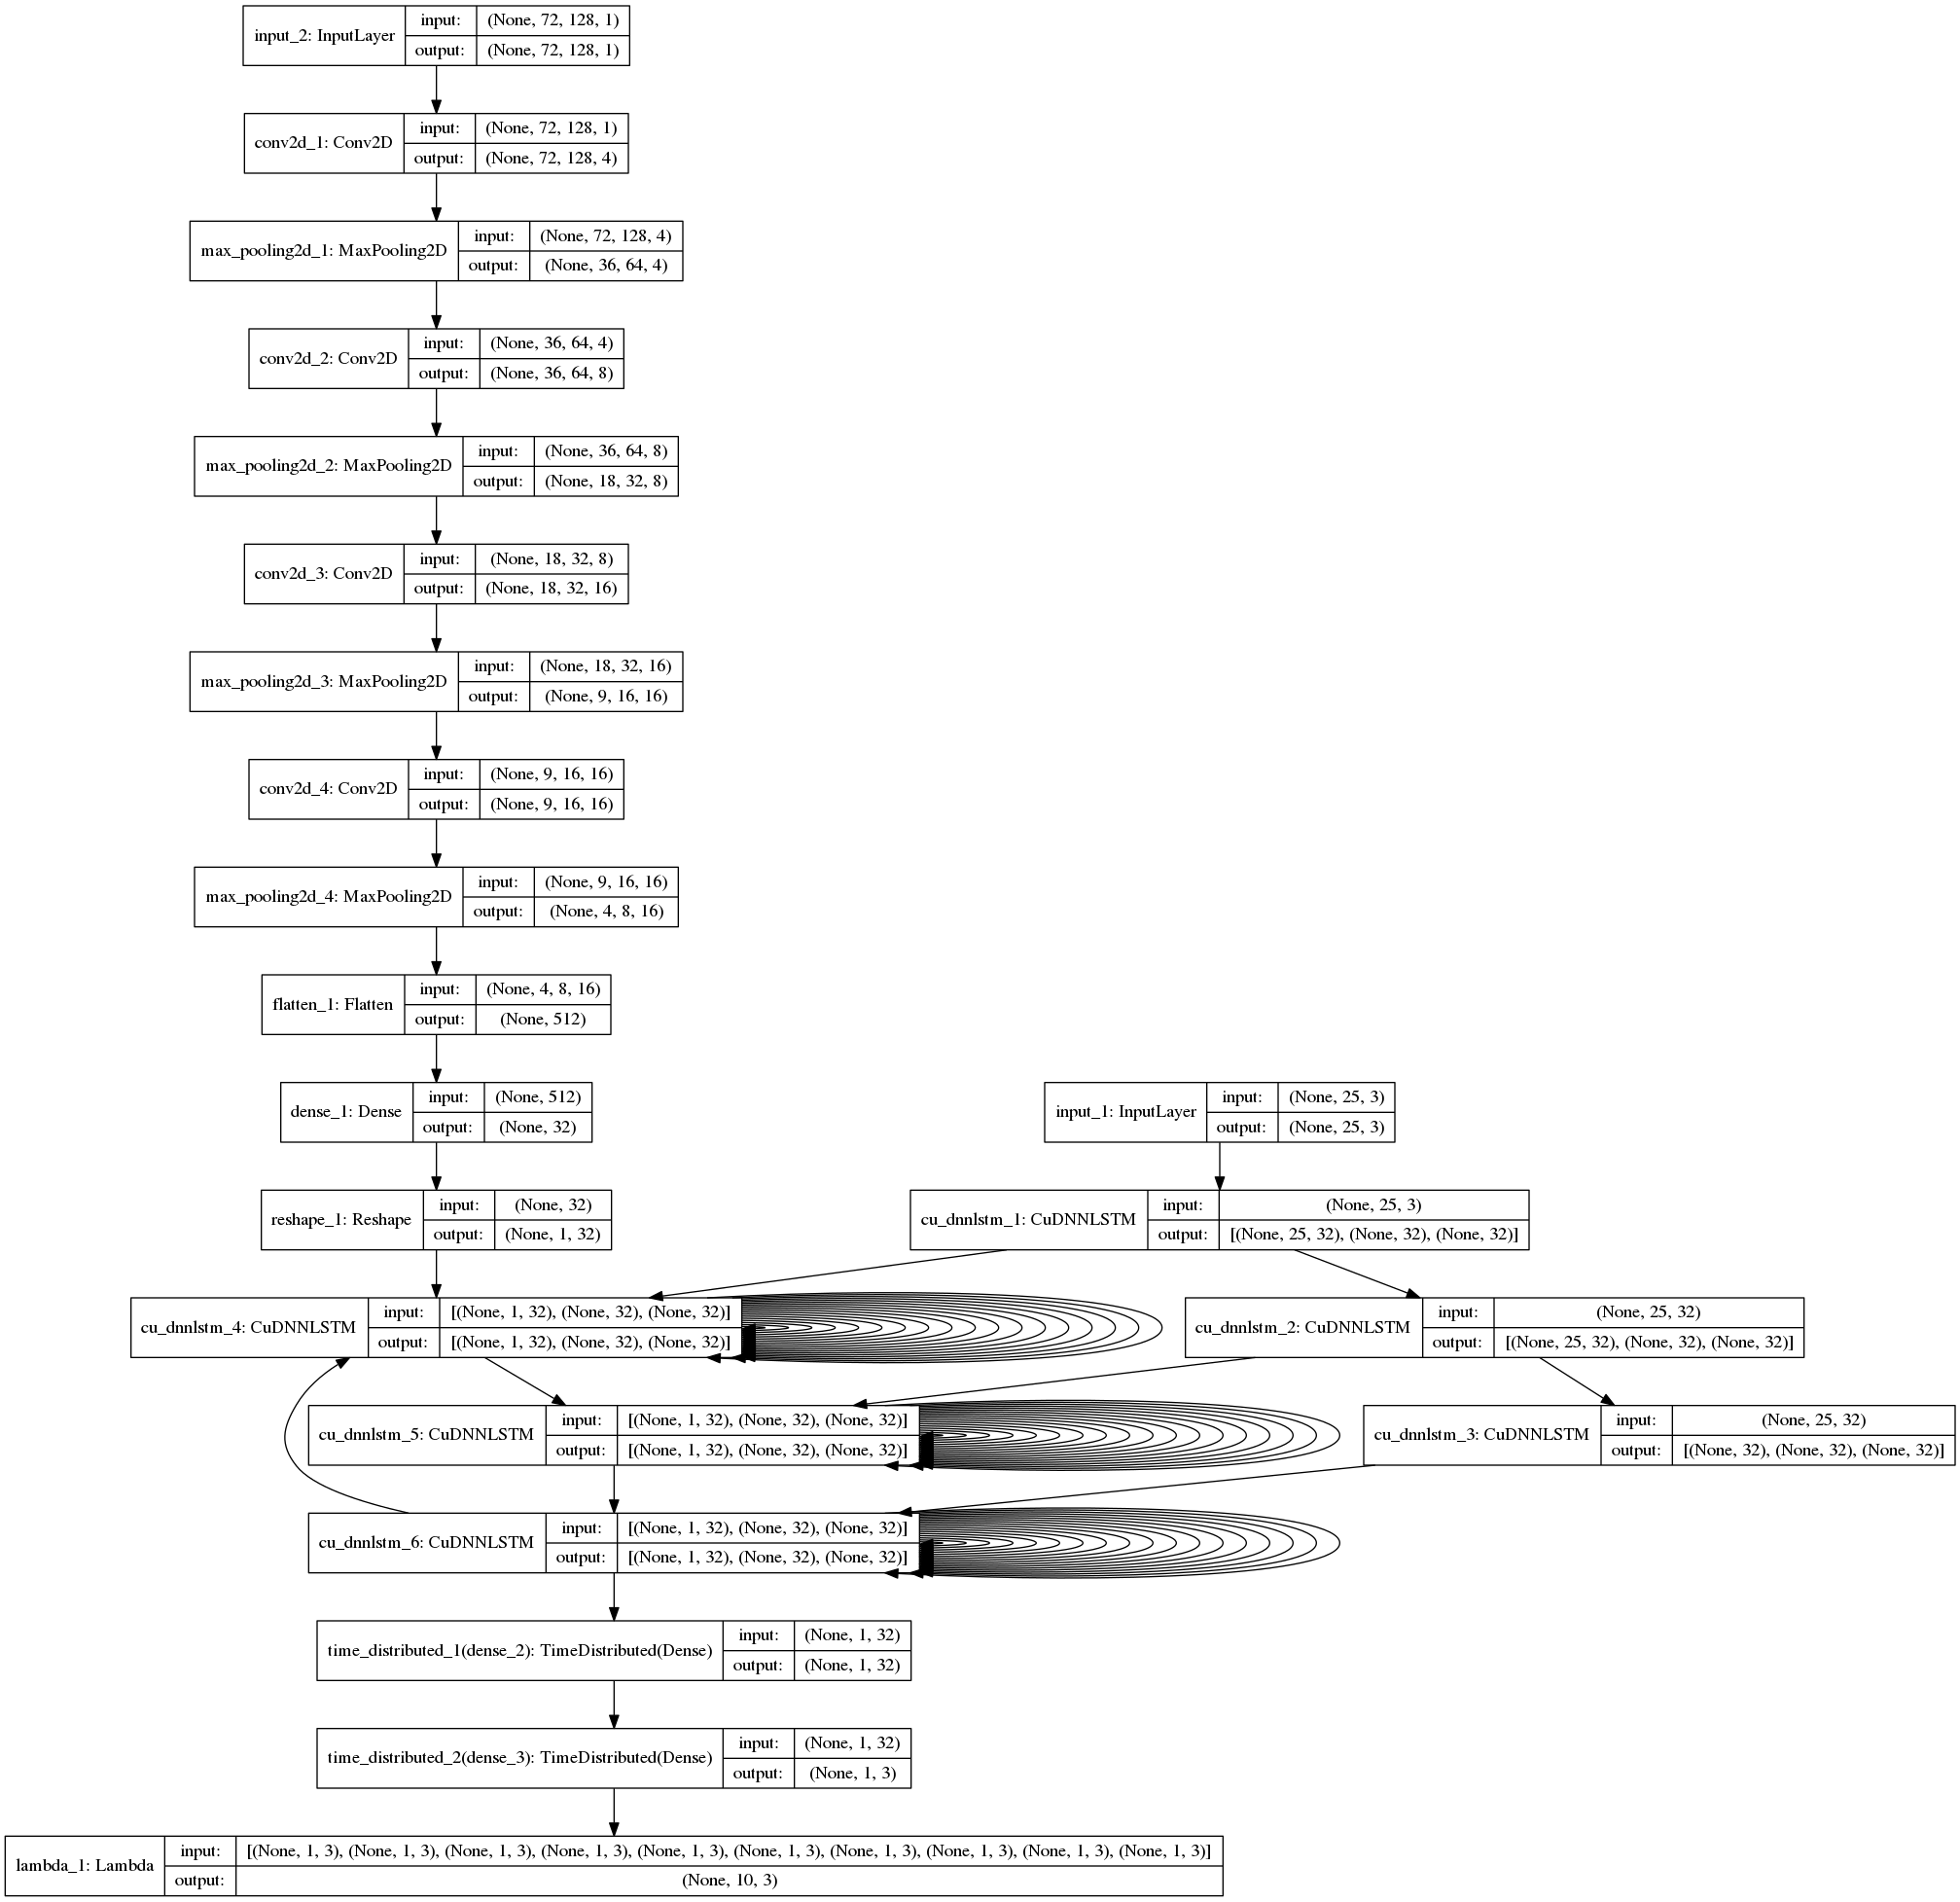

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


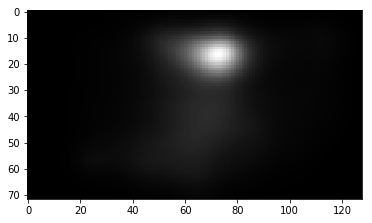

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 35:55 - loss: 0.0616 - rmse: 0.1885

  2/422 [..............................] - ETA: 26:20 - loss: 0.0514 - rmse: 0.1391

  3/422 [..............................] - ETA: 23:01 - loss: 0.0552 - rmse: 0.1416

  4/422 [..............................] - ETA: 21:17 - loss: 0.0467 - rmse: 0.1167

  5/422 [..............................] - ETA: 20:21 - loss: 0.0459 - rmse: 0.1278

  6/422 [..............................] - ETA: 19:49 - loss: 0.0454 - rmse: 0.1272

  7/422 [..............................] - ETA: 18:41 - loss: 0.0516 - rmse: 0.1477

  8/422 [..............................] - ETA: 18:29 - loss: 0.0570 - rmse: 0.1556

  9/422 [..............................] - ETA: 18:17 - loss: 0.0697 - rmse: 0.1883

 10/422 [..............................] - ETA: 18:00 - loss: 0.0667 - rmse: 0.1782

 11/422 [..............................] - ETA: 17:36 - loss: 0.0672 - rmse: 0.1774

 12/422 [..............................] - ETA: 17:28 - loss: 0.0667 - rmse: 0.1766

 13/422 [..............................] - ETA: 17:18 - loss: 0.0642 - rmse: 0.1705

 14/422 [..............................] - ETA: 17:13 - loss: 0.0638 - rmse: 0.1687

 15/422 [>.............................] - ETA: 17:08 - loss: 0.0653 - rmse: 0.1730

 16/422 [>.............................] - ETA: 17:04 - loss: 0.0661 - rmse: 0.1773

 17/422 [>.............................] - ETA: 16:58 - loss: 0.0691 - rmse: 0.1862

 18/422 [>.............................] - ETA: 16:56 - loss: 0.0669 - rmse: 0.1807

 19/422 [>.............................] - ETA: 16:11 - loss: 0.0654 - rmse: 0.1760

 20/422 [>.............................] - ETA: 15:30 - loss: 0.0648 - rmse: 0.1746

 21/422 [>.............................] - ETA: 15:31 - loss: 0.0684 - rmse: 0.1808

 22/422 [>.............................] - ETA: 15:32 - loss: 0.0713 - rmse: 0.1899

 23/422 [>.............................] - ETA: 15:32 - loss: 0.0691 - rmse: 0.1842

 24/422 [>.............................] - ETA: 15:33 - loss: 0.0682 - rmse: 0.1830

 25/422 [>.............................] - ETA: 15:33 - loss: 0.0665 - rmse: 0.1802

 26/422 [>.............................] - ETA: 15:32 - loss: 0.0660 - rmse: 0.1782

 27/422 [>.............................] - ETA: 15:31 - loss: 0.0665 - rmse: 0.1790

 28/422 [>.............................] - ETA: 15:29 - loss: 0.0674 - rmse: 0.1813

 29/422 [=>............................] - ETA: 15:02 - loss: 0.0668 - rmse: 0.1786

 30/422 [=>............................] - ETA: 14:57 - loss: 0.0671 - rmse: 0.1788

 31/422 [=>............................] - ETA: 14:57 - loss: 0.0675 - rmse: 0.1802

 32/422 [=>............................] - ETA: 14:33 - loss: 0.0669 - rmse: 0.1778

 33/422 [=>............................] - ETA: 14:25 - loss: 0.0689 - rmse: 0.1831

 34/422 [=>............................] - ETA: 14:26 - loss: 0.0692 - rmse: 0.1855

 35/422 [=>............................] - ETA: 14:26 - loss: 0.0694 - rmse: 0.1865

 36/422 [=>............................] - ETA: 14:26 - loss: 0.0698 - rmse: 0.1876

 37/422 [=>............................] - ETA: 14:18 - loss: 0.0708 - rmse: 0.1901

 38/422 [=>............................] - ETA: 14:19 - loss: 0.0710 - rmse: 0.1902

 39/422 [=>............................] - ETA: 14:19 - loss: 0.0713 - rmse: 0.1918

 40/422 [=>............................] - ETA: 14:19 - loss: 0.0701 - rmse: 0.1886

 41/422 [=>............................] - ETA: 14:19 - loss: 0.0692 - rmse: 0.1860

 42/422 [=>............................] - ETA: 14:18 - loss: 0.0689 - rmse: 0.1852

 43/422 [==>...........................] - ETA: 14:00 - loss: 0.0693 - rmse: 0.1862

 44/422 [==>...........................] - ETA: 14:01 - loss: 0.0693 - rmse: 0.1864

 45/422 [==>...........................] - ETA: 14:00 - loss: 0.0686 - rmse: 0.1843

 46/422 [==>...........................] - ETA: 14:00 - loss: 0.0678 - rmse: 0.1822

 47/422 [==>...........................] - ETA: 13:44 - loss: 0.0678 - rmse: 0.1823

 48/422 [==>...........................] - ETA: 13:44 - loss: 0.0684 - rmse: 0.1837

 49/422 [==>...........................] - ETA: 13:29 - loss: 0.0672 - rmse: 0.1804

 50/422 [==>...........................] - ETA: 13:28 - loss: 0.0674 - rmse: 0.1809

 51/422 [==>...........................] - ETA: 13:28 - loss: 0.0677 - rmse: 0.1814

 52/422 [==>...........................] - ETA: 13:25 - loss: 0.0678 - rmse: 0.1814

 53/422 [==>...........................] - ETA: 13:25 - loss: 0.0672 - rmse: 0.1794

 54/422 [==>...........................] - ETA: 13:24 - loss: 0.0668 - rmse: 0.1795

 55/422 [==>...........................] - ETA: 13:24 - loss: 0.0665 - rmse: 0.1788

 56/422 [==>...........................] - ETA: 13:23 - loss: 0.0658 - rmse: 0.1769

 57/422 [===>..........................] - ETA: 13:22 - loss: 0.0654 - rmse: 0.1765

 58/422 [===>..........................] - ETA: 13:17 - loss: 0.0651 - rmse: 0.1755

 59/422 [===>..........................] - ETA: 13:17 - loss: 0.0657 - rmse: 0.1764

 60/422 [===>..........................] - ETA: 13:16 - loss: 0.0658 - rmse: 0.1765

 61/422 [===>..........................] - ETA: 13:15 - loss: 0.0655 - rmse: 0.1759

 62/422 [===>..........................] - ETA: 13:03 - loss: 0.0656 - rmse: 0.1761

 63/422 [===>..........................] - ETA: 13:02 - loss: 0.0648 - rmse: 0.1737

 64/422 [===>..........................] - ETA: 12:50 - loss: 0.0650 - rmse: 0.1741

 65/422 [===>..........................] - ETA: 12:39 - loss: 0.0649 - rmse: 0.1737

 66/422 [===>..........................] - ETA: 12:39 - loss: 0.0652 - rmse: 0.1743

 67/422 [===>..........................] - ETA: 12:38 - loss: 0.0646 - rmse: 0.1736

 68/422 [===>..........................] - ETA: 12:27 - loss: 0.0642 - rmse: 0.1732

 69/422 [===>..........................] - ETA: 12:27 - loss: 0.0640 - rmse: 0.1729

 70/422 [===>..........................] - ETA: 12:25 - loss: 0.0635 - rmse: 0.1714

 71/422 [====>.........................] - ETA: 12:25 - loss: 0.0644 - rmse: 0.1729

 72/422 [====>.........................] - ETA: 12:24 - loss: 0.0640 - rmse: 0.1717

 73/422 [====>.........................] - ETA: 12:24 - loss: 0.0638 - rmse: 0.1709

 74/422 [====>.........................] - ETA: 12:23 - loss: 0.0634 - rmse: 0.1696

 75/422 [====>.........................] - ETA: 12:23 - loss: 0.0633 - rmse: 0.1696

 76/422 [====>.........................] - ETA: 12:20 - loss: 0.0638 - rmse: 0.1705

 77/422 [====>.........................] - ETA: 12:20 - loss: 0.0642 - rmse: 0.1721

 78/422 [====>.........................] - ETA: 12:19 - loss: 0.0638 - rmse: 0.1715

 79/422 [====>.........................] - ETA: 12:18 - loss: 0.0633 - rmse: 0.1700

 80/422 [====>.........................] - ETA: 12:18 - loss: 0.0632 - rmse: 0.1698

 81/422 [====>.........................] - ETA: 12:17 - loss: 0.0637 - rmse: 0.1708

 82/422 [====>.........................] - ETA: 12:16 - loss: 0.0640 - rmse: 0.1713

 83/422 [====>.........................] - ETA: 12:15 - loss: 0.0640 - rmse: 0.1711

 84/422 [====>.........................] - ETA: 12:15 - loss: 0.0643 - rmse: 0.1723

 85/422 [=====>........................] - ETA: 12:06 - loss: 0.0643 - rmse: 0.1721

 86/422 [=====>........................] - ETA: 12:05 - loss: 0.0640 - rmse: 0.1717

 87/422 [=====>........................] - ETA: 12:03 - loss: 0.0638 - rmse: 0.1712

 88/422 [=====>........................] - ETA: 11:54 - loss: 0.0632 - rmse: 0.1698

 89/422 [=====>........................] - ETA: 11:46 - loss: 0.0631 - rmse: 0.1689

 90/422 [=====>........................] - ETA: 11:38 - loss: 0.0628 - rmse: 0.1683

 91/422 [=====>........................] - ETA: 11:37 - loss: 0.0634 - rmse: 0.1697

 92/422 [=====>........................] - ETA: 11:29 - loss: 0.0629 - rmse: 0.1684

 93/422 [=====>........................] - ETA: 11:28 - loss: 0.0632 - rmse: 0.1696

 94/422 [=====>........................] - ETA: 11:25 - loss: 0.0630 - rmse: 0.1694

 95/422 [=====>........................] - ETA: 11:23 - loss: 0.0630 - rmse: 0.1691

 96/422 [=====>........................] - ETA: 11:22 - loss: 0.0628 - rmse: 0.1685

 97/422 [=====>........................] - ETA: 11:21 - loss: 0.0627 - rmse: 0.1680

 98/422 [=====>........................] - ETA: 11:20 - loss: 0.0626 - rmse: 0.1682

 99/422 [======>.......................] - ETA: 11:13 - loss: 0.0627 - rmse: 0.1682

100/422 [======>.......................] - ETA: 11:06 - loss: 0.0626 - rmse: 0.1677

101/422 [======>.......................] - ETA: 11:05 - loss: 0.0623 - rmse: 0.1672

102/422 [======>.......................] - ETA: 11:04 - loss: 0.0622 - rmse: 0.1669

103/422 [======>.......................] - ETA: 11:03 - loss: 0.0620 - rmse: 0.1663

104/422 [======>.......................] - ETA: 10:56 - loss: 0.0621 - rmse: 0.1664

105/422 [======>.......................] - ETA: 10:49 - loss: 0.0626 - rmse: 0.1676

106/422 [======>.......................] - ETA: 10:48 - loss: 0.0629 - rmse: 0.1689

107/422 [======>.......................] - ETA: 10:48 - loss: 0.0628 - rmse: 0.1688

108/422 [======>.......................] - ETA: 10:41 - loss: 0.0626 - rmse: 0.1682

109/422 [======>.......................] - ETA: 10:40 - loss: 0.0626 - rmse: 0.1686

110/422 [======>.......................] - ETA: 10:39 - loss: 0.0624 - rmse: 0.1679

111/422 [======>.......................] - ETA: 10:32 - loss: 0.0623 - rmse: 0.1676

112/422 [======>.......................] - ETA: 10:26 - loss: 0.0624 - rmse: 0.1680

113/422 [=======>......................] - ETA: 10:25 - loss: 0.0624 - rmse: 0.1681

114/422 [=======>......................] - ETA: 10:19 - loss: 0.0623 - rmse: 0.1679

115/422 [=======>......................] - ETA: 10:17 - loss: 0.0623 - rmse: 0.1677

116/422 [=======>......................] - ETA: 10:16 - loss: 0.0623 - rmse: 0.1678

117/422 [=======>......................] - ETA: 10:16 - loss: 0.0621 - rmse: 0.1672

118/422 [=======>......................] - ETA: 10:10 - loss: 0.0618 - rmse: 0.1664

119/422 [=======>......................] - ETA: 10:04 - loss: 0.0618 - rmse: 0.1664

120/422 [=======>......................] - ETA: 10:03 - loss: 0.0620 - rmse: 0.1669

121/422 [=======>......................] - ETA: 10:01 - loss: 0.0620 - rmse: 0.1666

122/422 [=======>......................] - ETA: 9:59 - loss: 0.0618 - rmse: 0.1661 

123/422 [=======>......................] - ETA: 9:57 - loss: 0.0620 - rmse: 0.1663

124/422 [=======>......................] - ETA: 9:57 - loss: 0.0619 - rmse: 0.1664

125/422 [=======>......................] - ETA: 9:55 - loss: 0.0621 - rmse: 0.1667

126/422 [=======>......................] - ETA: 9:50 - loss: 0.0621 - rmse: 0.1664

127/422 [========>.....................] - ETA: 9:49 - loss: 0.0619 - rmse: 0.1662

128/422 [========>.....................] - ETA: 9:46 - loss: 0.0618 - rmse: 0.1662

129/422 [========>.....................] - ETA: 9:45 - loss: 0.0618 - rmse: 0.1661

130/422 [========>.....................] - ETA: 9:43 - loss: 0.0616 - rmse: 0.1659

131/422 [========>.....................] - ETA: 9:38 - loss: 0.0618 - rmse: 0.1665

132/422 [========>.....................] - ETA: 9:32 - loss: 0.0622 - rmse: 0.1673

133/422 [========>.....................] - ETA: 9:31 - loss: 0.0623 - rmse: 0.1680

134/422 [========>.....................] - ETA: 9:30 - loss: 0.0623 - rmse: 0.1680

135/422 [========>.....................] - ETA: 9:29 - loss: 0.0623 - rmse: 0.1683

136/422 [========>.....................] - ETA: 9:28 - loss: 0.0623 - rmse: 0.1684

137/422 [========>.....................] - ETA: 9:23 - loss: 0.0622 - rmse: 0.1684

138/422 [========>.....................] - ETA: 9:22 - loss: 0.0619 - rmse: 0.1674

139/422 [========>.....................] - ETA: 9:20 - loss: 0.0618 - rmse: 0.1675

140/422 [========>.....................] - ETA: 9:15 - loss: 0.0618 - rmse: 0.1675

141/422 [=========>....................] - ETA: 9:14 - loss: 0.0620 - rmse: 0.1684

142/422 [=========>....................] - ETA: 9:09 - loss: 0.0622 - rmse: 0.1687

143/422 [=========>....................] - ETA: 9:05 - loss: 0.0620 - rmse: 0.1685

144/422 [=========>....................] - ETA: 9:00 - loss: 0.0621 - rmse: 0.1687

145/422 [=========>....................] - ETA: 8:59 - loss: 0.0620 - rmse: 0.1686

146/422 [=========>....................] - ETA: 8:57 - loss: 0.0622 - rmse: 0.1688

147/422 [=========>....................] - ETA: 8:55 - loss: 0.0621 - rmse: 0.1689

148/422 [=========>....................] - ETA: 8:51 - loss: 0.0620 - rmse: 0.1685

149/422 [=========>....................] - ETA: 8:46 - loss: 0.0619 - rmse: 0.1681

150/422 [=========>....................] - ETA: 8:41 - loss: 0.0618 - rmse: 0.1681

151/422 [=========>....................] - ETA: 8:37 - loss: 0.0619 - rmse: 0.1682

152/422 [=========>....................] - ETA: 8:36 - loss: 0.0618 - rmse: 0.1683

153/422 [=========>....................] - ETA: 8:32 - loss: 0.0618 - rmse: 0.1683

154/422 [=========>....................] - ETA: 8:27 - loss: 0.0617 - rmse: 0.1680

155/422 [==========>...................] - ETA: 8:23 - loss: 0.0618 - rmse: 0.1683

156/422 [==========>...................] - ETA: 8:19 - loss: 0.0618 - rmse: 0.1679

157/422 [==========>...................] - ETA: 8:18 - loss: 0.0618 - rmse: 0.1681

158/422 [==========>...................] - ETA: 8:14 - loss: 0.0619 - rmse: 0.1682

159/422 [==========>...................] - ETA: 8:12 - loss: 0.0620 - rmse: 0.1683

160/422 [==========>...................] - ETA: 8:08 - loss: 0.0619 - rmse: 0.1681

161/422 [==========>...................] - ETA: 8:04 - loss: 0.0619 - rmse: 0.1679

162/422 [==========>...................] - ETA: 8:00 - loss: 0.0619 - rmse: 0.1680

163/422 [==========>...................] - ETA: 7:56 - loss: 0.0620 - rmse: 0.1683

164/422 [==========>...................] - ETA: 7:52 - loss: 0.0620 - rmse: 0.1684

165/422 [==========>...................] - ETA: 7:48 - loss: 0.0622 - rmse: 0.1688

166/422 [==========>...................] - ETA: 7:47 - loss: 0.0621 - rmse: 0.1687

167/422 [==========>...................] - ETA: 7:43 - loss: 0.0621 - rmse: 0.1684

168/422 [==========>...................] - ETA: 7:39 - loss: 0.0622 - rmse: 0.1689

169/422 [===========>..................] - ETA: 7:35 - loss: 0.0622 - rmse: 0.1687

170/422 [===========>..................] - ETA: 7:32 - loss: 0.0621 - rmse: 0.1685

171/422 [===========>..................] - ETA: 7:31 - loss: 0.0621 - rmse: 0.1685

172/422 [===========>..................] - ETA: 7:30 - loss: 0.0620 - rmse: 0.1683

173/422 [===========>..................] - ETA: 7:26 - loss: 0.0619 - rmse: 0.1680

174/422 [===========>..................] - ETA: 7:23 - loss: 0.0619 - rmse: 0.1682

175/422 [===========>..................] - ETA: 7:19 - loss: 0.0617 - rmse: 0.1676

176/422 [===========>..................] - ETA: 7:18 - loss: 0.0616 - rmse: 0.1674

177/422 [===========>..................] - ETA: 7:17 - loss: 0.0615 - rmse: 0.1672

178/422 [===========>..................] - ETA: 7:14 - loss: 0.0616 - rmse: 0.1673

179/422 [===========>..................] - ETA: 7:10 - loss: 0.0616 - rmse: 0.1674

180/422 [===========>..................] - ETA: 7:07 - loss: 0.0615 - rmse: 0.1670

181/422 [===========>..................] - ETA: 7:06 - loss: 0.0615 - rmse: 0.1672

182/422 [===========>..................] - ETA: 7:03 - loss: 0.0613 - rmse: 0.1668

183/422 [============>.................] - ETA: 7:02 - loss: 0.0612 - rmse: 0.1667

184/422 [============>.................] - ETA: 7:01 - loss: 0.0610 - rmse: 0.1661

185/422 [============>.................] - ETA: 7:00 - loss: 0.0615 - rmse: 0.1673

186/422 [============>.................] - ETA: 6:56 - loss: 0.0615 - rmse: 0.1671

187/422 [============>.................] - ETA: 6:53 - loss: 0.0614 - rmse: 0.1669

188/422 [============>.................] - ETA: 6:50 - loss: 0.0614 - rmse: 0.1669

189/422 [============>.................] - ETA: 6:49 - loss: 0.0615 - rmse: 0.1672

190/422 [============>.................] - ETA: 6:46 - loss: 0.0616 - rmse: 0.1674

191/422 [============>.................] - ETA: 6:42 - loss: 0.0616 - rmse: 0.1674

192/422 [============>.................] - ETA: 6:39 - loss: 0.0615 - rmse: 0.1670

193/422 [============>.................] - ETA: 6:36 - loss: 0.0613 - rmse: 0.1667

194/422 [============>.................] - ETA: 6:35 - loss: 0.0614 - rmse: 0.1667

195/422 [============>.................] - ETA: 6:34 - loss: 0.0612 - rmse: 0.1660

196/422 [============>.................] - ETA: 6:31 - loss: 0.0611 - rmse: 0.1659

197/422 [=============>................] - ETA: 6:30 - loss: 0.0612 - rmse: 0.1661

198/422 [=============>................] - ETA: 6:29 - loss: 0.0611 - rmse: 0.1659

199/422 [=============>................] - ETA: 6:28 - loss: 0.0611 - rmse: 0.1659

200/422 [=============>................] - ETA: 6:27 - loss: 0.0610 - rmse: 0.1659

201/422 [=============>................] - ETA: 6:25 - loss: 0.0610 - rmse: 0.1661

202/422 [=============>................] - ETA: 6:22 - loss: 0.0610 - rmse: 0.1663

203/422 [=============>................] - ETA: 6:21 - loss: 0.0610 - rmse: 0.1663

204/422 [=============>................] - ETA: 6:18 - loss: 0.0612 - rmse: 0.1666

205/422 [=============>................] - ETA: 6:17 - loss: 0.0611 - rmse: 0.1667

206/422 [=============>................] - ETA: 6:16 - loss: 0.0610 - rmse: 0.1662

207/422 [=============>................] - ETA: 6:15 - loss: 0.0608 - rmse: 0.1658

208/422 [=============>................] - ETA: 6:12 - loss: 0.0607 - rmse: 0.1654

209/422 [=============>................] - ETA: 6:10 - loss: 0.0607 - rmse: 0.1655

210/422 [=============>................] - ETA: 6:07 - loss: 0.0606 - rmse: 0.1653

211/422 [==============>...............] - ETA: 6:04 - loss: 0.0607 - rmse: 0.1655

212/422 [==============>...............] - ETA: 6:02 - loss: 0.0607 - rmse: 0.1652

213/422 [==============>...............] - ETA: 6:01 - loss: 0.0607 - rmse: 0.1652

214/422 [==============>...............] - ETA: 5:58 - loss: 0.0607 - rmse: 0.1653

215/422 [==============>...............] - ETA: 5:57 - loss: 0.0607 - rmse: 0.1654

216/422 [==============>...............] - ETA: 5:54 - loss: 0.0605 - rmse: 0.1649

217/422 [==============>...............] - ETA: 5:51 - loss: 0.0606 - rmse: 0.1650

218/422 [==============>...............] - ETA: 5:48 - loss: 0.0607 - rmse: 0.1653

219/422 [==============>...............] - ETA: 5:47 - loss: 0.0607 - rmse: 0.1652

220/422 [==============>...............] - ETA: 5:44 - loss: 0.0606 - rmse: 0.1650

221/422 [==============>...............] - ETA: 5:43 - loss: 0.0606 - rmse: 0.1650

222/422 [==============>...............] - ETA: 5:42 - loss: 0.0607 - rmse: 0.1652

223/422 [==============>...............] - ETA: 5:39 - loss: 0.0606 - rmse: 0.1651

224/422 [==============>...............] - ETA: 5:38 - loss: 0.0606 - rmse: 0.1650

225/422 [==============>...............] - ETA: 5:35 - loss: 0.0607 - rmse: 0.1652

226/422 [===============>..............] - ETA: 5:34 - loss: 0.0607 - rmse: 0.1653

227/422 [===============>..............] - ETA: 5:33 - loss: 0.0606 - rmse: 0.1649

228/422 [===============>..............] - ETA: 5:32 - loss: 0.0605 - rmse: 0.1647

229/422 [===============>..............] - ETA: 5:29 - loss: 0.0604 - rmse: 0.1642

230/422 [===============>..............] - ETA: 5:28 - loss: 0.0604 - rmse: 0.1643

231/422 [===============>..............] - ETA: 5:25 - loss: 0.0603 - rmse: 0.1643

232/422 [===============>..............] - ETA: 5:24 - loss: 0.0603 - rmse: 0.1645

233/422 [===============>..............] - ETA: 5:21 - loss: 0.0601 - rmse: 0.1640

234/422 [===============>..............] - ETA: 5:18 - loss: 0.0602 - rmse: 0.1641

235/422 [===============>..............] - ETA: 5:16 - loss: 0.0603 - rmse: 0.1645

236/422 [===============>..............] - ETA: 5:15 - loss: 0.0602 - rmse: 0.1642

237/422 [===============>..............] - ETA: 5:12 - loss: 0.0603 - rmse: 0.1644

238/422 [===============>..............] - ETA: 5:09 - loss: 0.0603 - rmse: 0.1646

239/422 [===============>..............] - ETA: 5:08 - loss: 0.0604 - rmse: 0.1646

240/422 [================>.............] - ETA: 5:07 - loss: 0.0603 - rmse: 0.1643

241/422 [================>.............] - ETA: 5:05 - loss: 0.0604 - rmse: 0.1647

242/422 [================>.............] - ETA: 5:02 - loss: 0.0605 - rmse: 0.1648

243/422 [================>.............] - ETA: 5:01 - loss: 0.0605 - rmse: 0.1648

244/422 [================>.............] - ETA: 4:58 - loss: 0.0604 - rmse: 0.1646

245/422 [================>.............] - ETA: 4:57 - loss: 0.0606 - rmse: 0.1650

246/422 [================>.............] - ETA: 4:55 - loss: 0.0609 - rmse: 0.1658

247/422 [================>.............] - ETA: 4:52 - loss: 0.0609 - rmse: 0.1657

248/422 [================>.............] - ETA: 4:51 - loss: 0.0609 - rmse: 0.1657

249/422 [================>.............] - ETA: 4:50 - loss: 0.0610 - rmse: 0.1658

250/422 [================>.............] - ETA: 4:49 - loss: 0.0608 - rmse: 0.1654

251/422 [================>.............] - ETA: 4:47 - loss: 0.0610 - rmse: 0.1659

252/422 [================>.............] - ETA: 4:46 - loss: 0.0612 - rmse: 0.1662

253/422 [================>.............] - ETA: 4:43 - loss: 0.0613 - rmse: 0.1666

254/422 [=================>............] - ETA: 4:41 - loss: 0.0613 - rmse: 0.1667

255/422 [=================>............] - ETA: 4:40 - loss: 0.0612 - rmse: 0.1662

256/422 [=================>............] - ETA: 4:37 - loss: 0.0612 - rmse: 0.1662

257/422 [=================>............] - ETA: 4:35 - loss: 0.0612 - rmse: 0.1663

258/422 [=================>............] - ETA: 4:34 - loss: 0.0613 - rmse: 0.1664

259/422 [=================>............] - ETA: 4:32 - loss: 0.0613 - rmse: 0.1665

260/422 [=================>............] - ETA: 4:31 - loss: 0.0611 - rmse: 0.1661

261/422 [=================>............] - ETA: 4:30 - loss: 0.0610 - rmse: 0.1657

262/422 [=================>............] - ETA: 4:28 - loss: 0.0610 - rmse: 0.1658

263/422 [=================>............] - ETA: 4:26 - loss: 0.0610 - rmse: 0.1658

264/422 [=================>............] - ETA: 4:25 - loss: 0.0610 - rmse: 0.1658

265/422 [=================>............] - ETA: 4:24 - loss: 0.0610 - rmse: 0.1657

266/422 [=================>............] - ETA: 4:23 - loss: 0.0610 - rmse: 0.1657

267/422 [=================>............] - ETA: 4:20 - loss: 0.0610 - rmse: 0.1657

268/422 [==================>...........] - ETA: 4:18 - loss: 0.0609 - rmse: 0.1654

269/422 [==================>...........] - ETA: 4:15 - loss: 0.0611 - rmse: 0.1658

270/422 [==================>...........] - ETA: 4:13 - loss: 0.0612 - rmse: 0.1662

271/422 [==================>...........] - ETA: 4:11 - loss: 0.0612 - rmse: 0.1661

272/422 [==================>...........] - ETA: 4:10 - loss: 0.0612 - rmse: 0.1659

273/422 [==================>...........] - ETA: 4:07 - loss: 0.0612 - rmse: 0.1660

274/422 [==================>...........] - ETA: 4:05 - loss: 0.0612 - rmse: 0.1658

275/422 [==================>...........] - ETA: 4:04 - loss: 0.0611 - rmse: 0.1656

276/422 [==================>...........] - ETA: 4:02 - loss: 0.0611 - rmse: 0.1658

277/422 [==================>...........] - ETA: 4:00 - loss: 0.0612 - rmse: 0.1661

278/422 [==================>...........] - ETA: 3:58 - loss: 0.0611 - rmse: 0.1658

279/422 [==================>...........] - ETA: 3:56 - loss: 0.0613 - rmse: 0.1662

280/422 [==================>...........] - ETA: 3:53 - loss: 0.0612 - rmse: 0.1662

281/422 [==================>...........] - ETA: 3:52 - loss: 0.0612 - rmse: 0.1661

282/422 [===================>..........] - ETA: 3:50 - loss: 0.0612 - rmse: 0.1661

283/422 [===================>..........] - ETA: 3:49 - loss: 0.0614 - rmse: 0.1666

284/422 [===================>..........] - ETA: 3:47 - loss: 0.0614 - rmse: 0.1668

285/422 [===================>..........] - ETA: 3:44 - loss: 0.0614 - rmse: 0.1666

286/422 [===================>..........] - ETA: 3:42 - loss: 0.0614 - rmse: 0.1665

287/422 [===================>..........] - ETA: 3:40 - loss: 0.0613 - rmse: 0.1663

288/422 [===================>..........] - ETA: 3:38 - loss: 0.0613 - rmse: 0.1663

289/422 [===================>..........] - ETA: 3:36 - loss: 0.0613 - rmse: 0.1665

290/422 [===================>..........] - ETA: 3:34 - loss: 0.0615 - rmse: 0.1667

291/422 [===================>..........] - ETA: 3:32 - loss: 0.0615 - rmse: 0.1667

292/422 [===================>..........] - ETA: 3:30 - loss: 0.0616 - rmse: 0.1668

293/422 [===================>..........] - ETA: 3:29 - loss: 0.0616 - rmse: 0.1669

294/422 [===================>..........] - ETA: 3:27 - loss: 0.0617 - rmse: 0.1672

295/422 [===================>..........] - ETA: 3:25 - loss: 0.0616 - rmse: 0.1669

296/422 [====================>.........] - ETA: 3:24 - loss: 0.0616 - rmse: 0.1668

297/422 [====================>.........] - ETA: 3:21 - loss: 0.0616 - rmse: 0.1670

298/422 [====================>.........] - ETA: 3:20 - loss: 0.0616 - rmse: 0.1670

299/422 [====================>.........] - ETA: 3:19 - loss: 0.0614 - rmse: 0.1666

300/422 [====================>.........] - ETA: 3:17 - loss: 0.0614 - rmse: 0.1665

301/422 [====================>.........] - ETA: 3:16 - loss: 0.0614 - rmse: 0.1665

302/422 [====================>.........] - ETA: 3:14 - loss: 0.0613 - rmse: 0.1664

303/422 [====================>.........] - ETA: 3:12 - loss: 0.0615 - rmse: 0.1669

304/422 [====================>.........] - ETA: 3:10 - loss: 0.0616 - rmse: 0.1670

305/422 [====================>.........] - ETA: 3:08 - loss: 0.0617 - rmse: 0.1672

306/422 [====================>.........] - ETA: 3:06 - loss: 0.0616 - rmse: 0.1669

307/422 [====================>.........] - ETA: 3:04 - loss: 0.0615 - rmse: 0.1668

308/422 [====================>.........] - ETA: 3:02 - loss: 0.0615 - rmse: 0.1668

309/422 [====================>.........] - ETA: 3:00 - loss: 0.0615 - rmse: 0.1666

310/422 [=====================>........] - ETA: 2:59 - loss: 0.0616 - rmse: 0.1670

311/422 [=====================>........] - ETA: 2:57 - loss: 0.0616 - rmse: 0.1670

312/422 [=====================>........] - ETA: 2:55 - loss: 0.0616 - rmse: 0.1671

313/422 [=====================>........] - ETA: 2:53 - loss: 0.0616 - rmse: 0.1670

314/422 [=====================>........] - ETA: 2:51 - loss: 0.0616 - rmse: 0.1670

315/422 [=====================>........] - ETA: 2:49 - loss: 0.0617 - rmse: 0.1672

316/422 [=====================>........] - ETA: 2:47 - loss: 0.0617 - rmse: 0.1672

317/422 [=====================>........] - ETA: 2:45 - loss: 0.0618 - rmse: 0.1673

318/422 [=====================>........] - ETA: 2:43 - loss: 0.0618 - rmse: 0.1674

319/422 [=====================>........] - ETA: 2:42 - loss: 0.0617 - rmse: 0.1672

320/422 [=====================>........] - ETA: 2:40 - loss: 0.0618 - rmse: 0.1676

321/422 [=====================>........] - ETA: 2:38 - loss: 0.0618 - rmse: 0.1678

322/422 [=====================>........] - ETA: 2:36 - loss: 0.0618 - rmse: 0.1678

323/422 [=====================>........] - ETA: 2:35 - loss: 0.0618 - rmse: 0.1678

324/422 [======================>.......] - ETA: 2:34 - loss: 0.0618 - rmse: 0.1676

325/422 [======================>.......] - ETA: 2:32 - loss: 0.0618 - rmse: 0.1678

326/422 [======================>.......] - ETA: 2:30 - loss: 0.0619 - rmse: 0.1678

327/422 [======================>.......] - ETA: 2:28 - loss: 0.0618 - rmse: 0.1679

328/422 [======================>.......] - ETA: 2:27 - loss: 0.0619 - rmse: 0.1681

329/422 [======================>.......] - ETA: 2:25 - loss: 0.0618 - rmse: 0.1679

330/422 [======================>.......] - ETA: 2:23 - loss: 0.0618 - rmse: 0.1678

331/422 [======================>.......] - ETA: 2:22 - loss: 0.0619 - rmse: 0.1680

332/422 [======================>.......] - ETA: 2:20 - loss: 0.0619 - rmse: 0.1683

333/422 [======================>.......] - ETA: 2:18 - loss: 0.0621 - rmse: 0.1686

334/422 [======================>.......] - ETA: 2:17 - loss: 0.0621 - rmse: 0.1686

335/422 [======================>.......] - ETA: 2:15 - loss: 0.0620 - rmse: 0.1684

336/422 [======================>.......] - ETA: 2:13 - loss: 0.0619 - rmse: 0.1682

337/422 [======================>.......] - ETA: 2:12 - loss: 0.0619 - rmse: 0.1680

338/422 [=======================>......] - ETA: 2:10 - loss: 0.0620 - rmse: 0.1682

339/422 [=======================>......] - ETA: 2:08 - loss: 0.0621 - rmse: 0.1684

340/422 [=======================>......] - ETA: 2:06 - loss: 0.0620 - rmse: 0.1683

341/422 [=======================>......] - ETA: 2:05 - loss: 0.0620 - rmse: 0.1683

342/422 [=======================>......] - ETA: 2:03 - loss: 0.0620 - rmse: 0.1682

343/422 [=======================>......] - ETA: 2:02 - loss: 0.0619 - rmse: 0.1680

344/422 [=======================>......] - ETA: 2:01 - loss: 0.0619 - rmse: 0.1678

345/422 [=======================>......] - ETA: 1:59 - loss: 0.0618 - rmse: 0.1675

346/422 [=======================>......] - ETA: 1:57 - loss: 0.0617 - rmse: 0.1675

347/422 [=======================>......] - ETA: 1:56 - loss: 0.0616 - rmse: 0.1673

348/422 [=======================>......] - ETA: 1:54 - loss: 0.0615 - rmse: 0.1670

349/422 [=======================>......] - ETA: 1:53 - loss: 0.0617 - rmse: 0.1673

350/422 [=======================>......] - ETA: 1:51 - loss: 0.0617 - rmse: 0.1674

351/422 [=======================>......] - ETA: 1:50 - loss: 0.0617 - rmse: 0.1673

352/422 [========================>.....] - ETA: 1:48 - loss: 0.0618 - rmse: 0.1674

353/422 [========================>.....] - ETA: 1:46 - loss: 0.0619 - rmse: 0.1677

354/422 [========================>.....] - ETA: 1:45 - loss: 0.0618 - rmse: 0.1675

355/422 [========================>.....] - ETA: 1:44 - loss: 0.0617 - rmse: 0.1673

356/422 [========================>.....] - ETA: 1:42 - loss: 0.0617 - rmse: 0.1674

357/422 [========================>.....] - ETA: 1:41 - loss: 0.0617 - rmse: 0.1674

358/422 [========================>.....] - ETA: 1:39 - loss: 0.0616 - rmse: 0.1672

359/422 [========================>.....] - ETA: 1:37 - loss: 0.0615 - rmse: 0.1671

360/422 [========================>.....] - ETA: 1:36 - loss: 0.0615 - rmse: 0.1671

361/422 [========================>.....] - ETA: 1:34 - loss: 0.0616 - rmse: 0.1672

362/422 [========================>.....] - ETA: 1:32 - loss: 0.0615 - rmse: 0.1671

363/422 [========================>.....] - ETA: 1:31 - loss: 0.0615 - rmse: 0.1670

364/422 [========================>.....] - ETA: 1:29 - loss: 0.0614 - rmse: 0.1667

365/422 [========================>.....] - ETA: 1:28 - loss: 0.0616 - rmse: 0.1671

366/422 [=========================>....] - ETA: 1:26 - loss: 0.0616 - rmse: 0.1671

367/422 [=========================>....] - ETA: 1:25 - loss: 0.0616 - rmse: 0.1671

368/422 [=========================>....] - ETA: 1:23 - loss: 0.0616 - rmse: 0.1671

369/422 [=========================>....] - ETA: 1:21 - loss: 0.0616 - rmse: 0.1672

370/422 [=========================>....] - ETA: 1:20 - loss: 0.0616 - rmse: 0.1673

371/422 [=========================>....] - ETA: 1:18 - loss: 0.0616 - rmse: 0.1672

372/422 [=========================>....] - ETA: 1:16 - loss: 0.0617 - rmse: 0.1674

373/422 [=========================>....] - ETA: 1:15 - loss: 0.0617 - rmse: 0.1674

374/422 [=========================>....] - ETA: 1:13 - loss: 0.0616 - rmse: 0.1671

375/422 [=========================>....] - ETA: 1:12 - loss: 0.0616 - rmse: 0.1672

376/422 [=========================>....] - ETA: 1:10 - loss: 0.0619 - rmse: 0.1677

377/422 [=========================>....] - ETA: 1:08 - loss: 0.0620 - rmse: 0.1679

378/422 [=========================>....] - ETA: 1:07 - loss: 0.0620 - rmse: 0.1680

379/422 [=========================>....] - ETA: 1:05 - loss: 0.0620 - rmse: 0.1679

380/422 [==========================>...] - ETA: 1:04 - loss: 0.0621 - rmse: 0.1680

381/422 [==========================>...] - ETA: 1:02 - loss: 0.0620 - rmse: 0.1679

382/422 [==========================>...] - ETA: 1:01 - loss: 0.0619 - rmse: 0.1677

383/422 [==========================>...] - ETA: 59s - loss: 0.0620 - rmse: 0.1679 

384/422 [==========================>...] - ETA: 58s - loss: 0.0619 - rmse: 0.1677

385/422 [==========================>...] - ETA: 56s - loss: 0.0619 - rmse: 0.1677

386/422 [==========================>...] - ETA: 54s - loss: 0.0620 - rmse: 0.1679

387/422 [==========================>...] - ETA: 53s - loss: 0.0619 - rmse: 0.1678

388/422 [==========================>...] - ETA: 51s - loss: 0.0620 - rmse: 0.1682

389/422 [==========================>...] - ETA: 50s - loss: 0.0620 - rmse: 0.1681

390/422 [==========================>...] - ETA: 48s - loss: 0.0620 - rmse: 0.1681

391/422 [==========================>...] - ETA: 47s - loss: 0.0619 - rmse: 0.1678

392/422 [==========================>...] - ETA: 45s - loss: 0.0619 - rmse: 0.1679

393/422 [==========================>...] - ETA: 44s - loss: 0.0619 - rmse: 0.1680

394/422 [===========================>..] - ETA: 42s - loss: 0.0619 - rmse: 0.1678

395/422 [===========================>..] - ETA: 40s - loss: 0.0619 - rmse: 0.1679

396/422 [===========================>..] - ETA: 39s - loss: 0.0619 - rmse: 0.1677

397/422 [===========================>..] - ETA: 37s - loss: 0.0618 - rmse: 0.1676

398/422 [===========================>..] - ETA: 36s - loss: 0.0618 - rmse: 0.1678

399/422 [===========================>..] - ETA: 34s - loss: 0.0618 - rmse: 0.1677

400/422 [===========================>..] - ETA: 33s - loss: 0.0618 - rmse: 0.1677

401/422 [===========================>..] - ETA: 31s - loss: 0.0618 - rmse: 0.1677

402/422 [===========================>..] - ETA: 30s - loss: 0.0618 - rmse: 0.1677

403/422 [===========================>..] - ETA: 28s - loss: 0.0617 - rmse: 0.1674

404/422 [===========================>..] - ETA: 27s - loss: 0.0617 - rmse: 0.1675

405/422 [===========================>..] - ETA: 25s - loss: 0.0616 - rmse: 0.1677

406/422 [===========================>..] - ETA: 24s - loss: 0.0615 - rmse: 0.1673

407/422 [===========================>..] - ETA: 22s - loss: 0.0615 - rmse: 0.1671

408/422 [============================>.] - ETA: 21s - loss: 0.0615 - rmse: 0.1672

409/422 [============================>.] - ETA: 19s - loss: 0.0616 - rmse: 0.1675

410/422 [============================>.] - ETA: 18s - loss: 0.0616 - rmse: 0.1674

411/422 [============================>.] - ETA: 16s - loss: 0.0616 - rmse: 0.1675

412/422 [============================>.] - ETA: 15s - loss: 0.0617 - rmse: 0.1677

413/422 [============================>.] - ETA: 13s - loss: 0.0617 - rmse: 0.1677

414/422 [============================>.] - ETA: 11s - loss: 0.0617 - rmse: 0.1677

415/422 [============================>.] - ETA: 10s - loss: 0.0617 - rmse: 0.1677

416/422 [============================>.] - ETA: 8s - loss: 0.0618 - rmse: 0.1680 

417/422 [============================>.] - ETA: 7s - loss: 0.0618 - rmse: 0.1679

418/422 [============================>.] - ETA: 5s - loss: 0.0618 - rmse: 0.1680

419/422 [============================>.] - ETA: 4s - loss: 0.0617 - rmse: 0.1678

420/422 [============================>.] - ETA: 2s - loss: 0.0616 - rmse: 0.1675

421/422 [============================>.] - ETA: 1s - loss: 0.0618 - rmse: 0.1678

422/422 [==============================] - 681s 2s/step - loss: 0.0618 - rmse: 0.1680 - val_loss: 0.0613 - val_rmse: 0.1748


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_4/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_4/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150


  1/422 [..............................] - ETA: 2:57 - loss: 0.1230 - rmse: 0.2875

  2/422 [..............................] - ETA: 3:10 - loss: 0.0889 - rmse: 0.2113

  3/422 [..............................] - ETA: 2:57 - loss: 0.0737 - rmse: 0.1814

  4/422 [..............................] - ETA: 3:02 - loss: 0.0597 - rmse: 0.1465

  5/422 [..............................] - ETA: 3:07 - loss: 0.0528 - rmse: 0.1395

  6/422 [..............................] - ETA: 3:08 - loss: 0.0571 - rmse: 0.1473

  7/422 [..............................] - ETA: 3:09 - loss: 0.0542 - rmse: 0.1408

  8/422 [..............................] - ETA: 3:10 - loss: 0.0539 - rmse: 0.1412

  9/422 [..............................] - ETA: 3:10 - loss: 0.0525 - rmse: 0.1352

 10/422 [..............................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1503

 11/422 [..............................] - ETA: 3:07 - loss: 0.0517 - rmse: 0.1395

 12/422 [..............................] - ETA: 3:08 - loss: 0.0570 - rmse: 0.1566

 13/422 [..............................] - ETA: 3:09 - loss: 0.0592 - rmse: 0.1608

 14/422 [..............................] - ETA: 3:09 - loss: 0.0577 - rmse: 0.1582

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0591 - rmse: 0.1611

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0578 - rmse: 0.1578

 17/422 [>.............................] - ETA: 3:10 - loss: 0.0571 - rmse: 0.1552

 18/422 [>.............................] - ETA: 3:08 - loss: 0.0571 - rmse: 0.1566

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0583 - rmse: 0.1622

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0568 - rmse: 0.1582

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0563 - rmse: 0.1566

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0557 - rmse: 0.1536

 23/422 [>.............................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1538

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0553 - rmse: 0.1508

 25/422 [>.............................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1499

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0550 - rmse: 0.1509

 27/422 [>.............................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1473

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1516

 29/422 [=>............................] - ETA: 3:07 - loss: 0.0561 - rmse: 0.1521

 30/422 [=>............................] - ETA: 3:07 - loss: 0.0567 - rmse: 0.1535

 31/422 [=>............................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1511

 32/422 [=>............................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1520

 33/422 [=>............................] - ETA: 3:06 - loss: 0.0550 - rmse: 0.1481

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1502

 35/422 [=>............................] - ETA: 3:05 - loss: 0.0573 - rmse: 0.1544

 36/422 [=>............................] - ETA: 3:05 - loss: 0.0563 - rmse: 0.1515

 37/422 [=>............................] - ETA: 3:05 - loss: 0.0579 - rmse: 0.1559

 38/422 [=>............................] - ETA: 3:04 - loss: 0.0570 - rmse: 0.1533

 39/422 [=>............................] - ETA: 3:04 - loss: 0.0587 - rmse: 0.1572

 40/422 [=>............................] - ETA: 3:03 - loss: 0.0586 - rmse: 0.1563

 41/422 [=>............................] - ETA: 3:02 - loss: 0.0589 - rmse: 0.1567

 42/422 [=>............................] - ETA: 3:02 - loss: 0.0583 - rmse: 0.1546

 43/422 [==>...........................] - ETA: 3:02 - loss: 0.0580 - rmse: 0.1532

 44/422 [==>...........................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1510

 45/422 [==>...........................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1505

 46/422 [==>...........................] - ETA: 3:00 - loss: 0.0570 - rmse: 0.1512

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0571 - rmse: 0.1511

 48/422 [==>...........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1515

 49/422 [==>...........................] - ETA: 2:58 - loss: 0.0573 - rmse: 0.1513

 50/422 [==>...........................] - ETA: 2:58 - loss: 0.0582 - rmse: 0.1543

 51/422 [==>...........................] - ETA: 2:58 - loss: 0.0580 - rmse: 0.1533

 52/422 [==>...........................] - ETA: 2:57 - loss: 0.0578 - rmse: 0.1533

 53/422 [==>...........................] - ETA: 2:57 - loss: 0.0573 - rmse: 0.1522

 54/422 [==>...........................] - ETA: 2:57 - loss: 0.0572 - rmse: 0.1517

 55/422 [==>...........................] - ETA: 2:56 - loss: 0.0574 - rmse: 0.1520

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0569 - rmse: 0.1510

 57/422 [===>..........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1504

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1502

 59/422 [===>..........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1504

 60/422 [===>..........................] - ETA: 2:53 - loss: 0.0570 - rmse: 0.1523

 61/422 [===>..........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1518

 62/422 [===>..........................] - ETA: 2:53 - loss: 0.0575 - rmse: 0.1531

 63/422 [===>..........................] - ETA: 2:52 - loss: 0.0574 - rmse: 0.1529

 64/422 [===>..........................] - ETA: 2:52 - loss: 0.0576 - rmse: 0.1529

 65/422 [===>..........................] - ETA: 2:51 - loss: 0.0579 - rmse: 0.1540

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0582 - rmse: 0.1555

 67/422 [===>..........................] - ETA: 2:50 - loss: 0.0578 - rmse: 0.1542

 68/422 [===>..........................] - ETA: 2:49 - loss: 0.0577 - rmse: 0.1543

 69/422 [===>..........................] - ETA: 2:49 - loss: 0.0573 - rmse: 0.1533

 70/422 [===>..........................] - ETA: 2:49 - loss: 0.0572 - rmse: 0.1525

 71/422 [====>.........................] - ETA: 2:48 - loss: 0.0569 - rmse: 0.1518

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0571 - rmse: 0.1524

 73/422 [====>.........................] - ETA: 2:47 - loss: 0.0567 - rmse: 0.1522

 74/422 [====>.........................] - ETA: 2:46 - loss: 0.0570 - rmse: 0.1528

 75/422 [====>.........................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1522

 76/422 [====>.........................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1511

 77/422 [====>.........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1510

 78/422 [====>.........................] - ETA: 2:44 - loss: 0.0563 - rmse: 0.1511

 79/422 [====>.........................] - ETA: 2:44 - loss: 0.0575 - rmse: 0.1537

 80/422 [====>.........................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1531

 81/422 [====>.........................] - ETA: 2:43 - loss: 0.0575 - rmse: 0.1538

 82/422 [====>.........................] - ETA: 2:42 - loss: 0.0577 - rmse: 0.1546

 83/422 [====>.........................] - ETA: 2:42 - loss: 0.0574 - rmse: 0.1536

 84/422 [====>.........................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1535

 85/422 [=====>........................] - ETA: 2:41 - loss: 0.0575 - rmse: 0.1536

 86/422 [=====>........................] - ETA: 2:40 - loss: 0.0573 - rmse: 0.1531

 87/422 [=====>........................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1536

 88/422 [=====>........................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1532

 89/422 [=====>........................] - ETA: 2:39 - loss: 0.0577 - rmse: 0.1542

 90/422 [=====>........................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1538

 91/422 [=====>........................] - ETA: 2:38 - loss: 0.0574 - rmse: 0.1542

 92/422 [=====>........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1539

 93/422 [=====>........................] - ETA: 2:37 - loss: 0.0570 - rmse: 0.1532

 94/422 [=====>........................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1532

 95/422 [=====>........................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1531

 96/422 [=====>........................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1536

 97/422 [=====>........................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1529

 98/422 [=====>........................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1531

 99/422 [======>.......................] - ETA: 2:35 - loss: 0.0572 - rmse: 0.1543

100/422 [======>.......................] - ETA: 2:34 - loss: 0.0572 - rmse: 0.1544

101/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1539

102/422 [======>.......................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1543

103/422 [======>.......................] - ETA: 2:33 - loss: 0.0572 - rmse: 0.1545

104/422 [======>.......................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1547

105/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1540

106/422 [======>.......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1533

107/422 [======>.......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1534

108/422 [======>.......................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1528

109/422 [======>.......................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1538

110/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1532

111/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1535

112/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1533

113/422 [=======>......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1544

114/422 [=======>......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1534

115/422 [=======>......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1536

116/422 [=======>......................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1529

117/422 [=======>......................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1518

118/422 [=======>......................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1517

119/422 [=======>......................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1526

120/422 [=======>......................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1521

121/422 [=======>......................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1524

122/422 [=======>......................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1529

123/422 [=======>......................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1520

124/422 [=======>......................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1526

125/422 [=======>......................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1528

126/422 [=======>......................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1529

127/422 [========>.....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1530

128/422 [========>.....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1526

129/422 [========>.....................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1524

130/422 [========>.....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1528

131/422 [========>.....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1525

132/422 [========>.....................] - ETA: 2:19 - loss: 0.0566 - rmse: 0.1537

133/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1531

134/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1530

135/422 [========>.....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1530

136/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1525

137/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1522

138/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1529

139/422 [========>.....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1524

140/422 [========>.....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1532

141/422 [=========>....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1526

142/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1531

143/422 [=========>....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1533

144/422 [=========>....................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1525

145/422 [=========>....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1532

146/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1525

147/422 [=========>....................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1533

148/422 [=========>....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1540

149/422 [=========>....................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1545

150/422 [=========>....................] - ETA: 2:10 - loss: 0.0571 - rmse: 0.1548

151/422 [=========>....................] - ETA: 2:10 - loss: 0.0572 - rmse: 0.1549

152/422 [=========>....................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1543

153/422 [=========>....................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1536

154/422 [=========>....................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1539

155/422 [==========>...................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1532

156/422 [==========>...................] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1541

157/422 [==========>...................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1540

158/422 [==========>...................] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1539

159/422 [==========>...................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1535

160/422 [==========>...................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1532

161/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1533

162/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1535

163/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1539

164/422 [==========>...................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1539

165/422 [==========>...................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1541

166/422 [==========>...................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1546

167/422 [==========>...................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1545

168/422 [==========>...................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1543

169/422 [===========>..................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1544

170/422 [===========>..................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1548

171/422 [===========>..................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1550

172/422 [===========>..................] - ETA: 2:00 - loss: 0.0569 - rmse: 0.1545

173/422 [===========>..................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1546

174/422 [===========>..................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1548

175/422 [===========>..................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1549

176/422 [===========>..................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1555

177/422 [===========>..................] - ETA: 1:58 - loss: 0.0571 - rmse: 0.1552

178/422 [===========>..................] - ETA: 1:57 - loss: 0.0572 - rmse: 0.1555

179/422 [===========>..................] - ETA: 1:57 - loss: 0.0572 - rmse: 0.1555

180/422 [===========>..................] - ETA: 1:56 - loss: 0.0574 - rmse: 0.1559

181/422 [===========>..................] - ETA: 1:56 - loss: 0.0573 - rmse: 0.1559

182/422 [===========>..................] - ETA: 1:55 - loss: 0.0573 - rmse: 0.1559

183/422 [============>.................] - ETA: 1:55 - loss: 0.0576 - rmse: 0.1570

184/422 [============>.................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1573

185/422 [============>.................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1570

186/422 [============>.................] - ETA: 1:53 - loss: 0.0577 - rmse: 0.1576

187/422 [============>.................] - ETA: 1:53 - loss: 0.0579 - rmse: 0.1580

188/422 [============>.................] - ETA: 1:52 - loss: 0.0578 - rmse: 0.1576

189/422 [============>.................] - ETA: 1:52 - loss: 0.0577 - rmse: 0.1575

190/422 [============>.................] - ETA: 1:51 - loss: 0.0578 - rmse: 0.1575

191/422 [============>.................] - ETA: 1:51 - loss: 0.0579 - rmse: 0.1580

192/422 [============>.................] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1578

193/422 [============>.................] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1580

194/422 [============>.................] - ETA: 1:49 - loss: 0.0581 - rmse: 0.1588

195/422 [============>.................] - ETA: 1:49 - loss: 0.0580 - rmse: 0.1586

196/422 [============>.................] - ETA: 1:48 - loss: 0.0580 - rmse: 0.1586

197/422 [=============>................] - ETA: 1:48 - loss: 0.0581 - rmse: 0.1589

198/422 [=============>................] - ETA: 1:47 - loss: 0.0580 - rmse: 0.1587

199/422 [=============>................] - ETA: 1:47 - loss: 0.0580 - rmse: 0.1587

200/422 [=============>................] - ETA: 1:46 - loss: 0.0581 - rmse: 0.1588

201/422 [=============>................] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1594

202/422 [=============>................] - ETA: 1:45 - loss: 0.0583 - rmse: 0.1597

203/422 [=============>................] - ETA: 1:45 - loss: 0.0582 - rmse: 0.1594

204/422 [=============>................] - ETA: 1:44 - loss: 0.0583 - rmse: 0.1596

205/422 [=============>................] - ETA: 1:44 - loss: 0.0582 - rmse: 0.1594

206/422 [=============>................] - ETA: 1:43 - loss: 0.0581 - rmse: 0.1592

207/422 [=============>................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:42 - loss: 0.0580 - rmse: 0.1590

209/422 [=============>................] - ETA: 1:42 - loss: 0.0581 - rmse: 0.1592

210/422 [=============>................] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1596

211/422 [==============>...............] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1595

212/422 [==============>...............] - ETA: 1:40 - loss: 0.0584 - rmse: 0.1595

213/422 [==============>...............] - ETA: 1:40 - loss: 0.0583 - rmse: 0.1593

214/422 [==============>...............] - ETA: 1:39 - loss: 0.0584 - rmse: 0.1595

215/422 [==============>...............] - ETA: 1:39 - loss: 0.0585 - rmse: 0.1599

216/422 [==============>...............] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1605

217/422 [==============>...............] - ETA: 1:38 - loss: 0.0585 - rmse: 0.1600

218/422 [==============>...............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1600

219/422 [==============>...............] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1603

220/422 [==============>...............] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1602

221/422 [==============>...............] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1605

222/422 [==============>...............] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1604

223/422 [==============>...............] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1608

224/422 [==============>...............] - ETA: 1:35 - loss: 0.0589 - rmse: 0.1611

225/422 [==============>...............] - ETA: 1:34 - loss: 0.0590 - rmse: 0.1612

226/422 [===============>..............] - ETA: 1:34 - loss: 0.0591 - rmse: 0.1614

227/422 [===============>..............] - ETA: 1:33 - loss: 0.0591 - rmse: 0.1615

228/422 [===============>..............] - ETA: 1:33 - loss: 0.0590 - rmse: 0.1614

229/422 [===============>..............] - ETA: 1:32 - loss: 0.0590 - rmse: 0.1613

230/422 [===============>..............] - ETA: 1:32 - loss: 0.0588 - rmse: 0.1610

231/422 [===============>..............] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1606

232/422 [===============>..............] - ETA: 1:31 - loss: 0.0586 - rmse: 0.1607

233/422 [===============>..............] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1607

234/422 [===============>..............] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1607

235/422 [===============>..............] - ETA: 1:29 - loss: 0.0588 - rmse: 0.1608

236/422 [===============>..............] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1604

237/422 [===============>..............] - ETA: 1:28 - loss: 0.0586 - rmse: 0.1602

238/422 [===============>..............] - ETA: 1:28 - loss: 0.0584 - rmse: 0.1597

239/422 [===============>..............] - ETA: 1:27 - loss: 0.0584 - rmse: 0.1596

240/422 [================>.............] - ETA: 1:27 - loss: 0.0584 - rmse: 0.1596

241/422 [================>.............] - ETA: 1:27 - loss: 0.0584 - rmse: 0.1595

242/422 [================>.............] - ETA: 1:26 - loss: 0.0584 - rmse: 0.1594

243/422 [================>.............] - ETA: 1:26 - loss: 0.0584 - rmse: 0.1594

244/422 [================>.............] - ETA: 1:25 - loss: 0.0583 - rmse: 0.1594

245/422 [================>.............] - ETA: 1:25 - loss: 0.0583 - rmse: 0.1594

246/422 [================>.............] - ETA: 1:24 - loss: 0.0583 - rmse: 0.1594

247/422 [================>.............] - ETA: 1:24 - loss: 0.0583 - rmse: 0.1596

248/422 [================>.............] - ETA: 1:23 - loss: 0.0583 - rmse: 0.1595

249/422 [================>.............] - ETA: 1:23 - loss: 0.0582 - rmse: 0.1593

250/422 [================>.............] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1594

251/422 [================>.............] - ETA: 1:22 - loss: 0.0584 - rmse: 0.1596

252/422 [================>.............] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1598

253/422 [================>.............] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1599

254/422 [=================>............] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1598

255/422 [=================>............] - ETA: 1:20 - loss: 0.0586 - rmse: 0.1602

256/422 [=================>............] - ETA: 1:19 - loss: 0.0584 - rmse: 0.1598

257/422 [=================>............] - ETA: 1:19 - loss: 0.0585 - rmse: 0.1600

258/422 [=================>............] - ETA: 1:18 - loss: 0.0584 - rmse: 0.1599

259/422 [=================>............] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1598

260/422 [=================>............] - ETA: 1:17 - loss: 0.0584 - rmse: 0.1600

261/422 [=================>............] - ETA: 1:17 - loss: 0.0583 - rmse: 0.1598

262/422 [=================>............] - ETA: 1:17 - loss: 0.0582 - rmse: 0.1596

263/422 [=================>............] - ETA: 1:16 - loss: 0.0582 - rmse: 0.1595

264/422 [=================>............] - ETA: 1:16 - loss: 0.0583 - rmse: 0.1598

265/422 [=================>............] - ETA: 1:15 - loss: 0.0581 - rmse: 0.1594

266/422 [=================>............] - ETA: 1:15 - loss: 0.0582 - rmse: 0.1596

267/422 [=================>............] - ETA: 1:14 - loss: 0.0582 - rmse: 0.1597

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0583 - rmse: 0.1598

269/422 [==================>...........] - ETA: 1:13 - loss: 0.0584 - rmse: 0.1600

270/422 [==================>...........] - ETA: 1:13 - loss: 0.0584 - rmse: 0.1602

271/422 [==================>...........] - ETA: 1:12 - loss: 0.0584 - rmse: 0.1602

272/422 [==================>...........] - ETA: 1:12 - loss: 0.0584 - rmse: 0.1603

273/422 [==================>...........] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1603

274/422 [==================>...........] - ETA: 1:11 - loss: 0.0583 - rmse: 0.1599

275/422 [==================>...........] - ETA: 1:10 - loss: 0.0583 - rmse: 0.1600

276/422 [==================>...........] - ETA: 1:10 - loss: 0.0582 - rmse: 0.1599

277/422 [==================>...........] - ETA: 1:09 - loss: 0.0581 - rmse: 0.1598

278/422 [==================>...........] - ETA: 1:09 - loss: 0.0582 - rmse: 0.1599

279/422 [==================>...........] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1600

280/422 [==================>...........] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1598

281/422 [==================>...........] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1597

282/422 [===================>..........] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1596

283/422 [===================>..........] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1599

284/422 [===================>..........] - ETA: 1:06 - loss: 0.0581 - rmse: 0.1597

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0582 - rmse: 0.1599

286/422 [===================>..........] - ETA: 1:05 - loss: 0.0581 - rmse: 0.1598

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1595

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1595

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1596

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1596

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0581 - rmse: 0.1597

292/422 [===================>..........] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1596

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1600

294/422 [===================>..........] - ETA: 1:01 - loss: 0.0582 - rmse: 0.1601

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0580 - rmse: 0.1597

296/422 [====================>.........] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1598

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0582 - rmse: 0.1601

298/422 [====================>.........] - ETA: 59s - loss: 0.0582 - rmse: 0.1600 

299/422 [====================>.........] - ETA: 59s - loss: 0.0582 - rmse: 0.1602

300/422 [====================>.........] - ETA: 58s - loss: 0.0582 - rmse: 0.1603

301/422 [====================>.........] - ETA: 58s - loss: 0.0582 - rmse: 0.1601

302/422 [====================>.........] - ETA: 57s - loss: 0.0580 - rmse: 0.1598

303/422 [====================>.........] - ETA: 57s - loss: 0.0581 - rmse: 0.1597

304/422 [====================>.........] - ETA: 56s - loss: 0.0580 - rmse: 0.1595

305/422 [====================>.........] - ETA: 56s - loss: 0.0580 - rmse: 0.1595

306/422 [====================>.........] - ETA: 55s - loss: 0.0580 - rmse: 0.1597

307/422 [====================>.........] - ETA: 55s - loss: 0.0579 - rmse: 0.1594

308/422 [====================>.........] - ETA: 54s - loss: 0.0580 - rmse: 0.1595

309/422 [====================>.........] - ETA: 54s - loss: 0.0579 - rmse: 0.1594

310/422 [=====================>........] - ETA: 53s - loss: 0.0579 - rmse: 0.1594

311/422 [=====================>........] - ETA: 53s - loss: 0.0579 - rmse: 0.1592

312/422 [=====================>........] - ETA: 52s - loss: 0.0579 - rmse: 0.1592

313/422 [=====================>........] - ETA: 52s - loss: 0.0579 - rmse: 0.1591

314/422 [=====================>........] - ETA: 51s - loss: 0.0580 - rmse: 0.1594

315/422 [=====================>........] - ETA: 51s - loss: 0.0579 - rmse: 0.1591

316/422 [=====================>........] - ETA: 51s - loss: 0.0579 - rmse: 0.1592

317/422 [=====================>........] - ETA: 50s - loss: 0.0580 - rmse: 0.1593

318/422 [=====================>........] - ETA: 50s - loss: 0.0579 - rmse: 0.1593

319/422 [=====================>........] - ETA: 49s - loss: 0.0580 - rmse: 0.1594

320/422 [=====================>........] - ETA: 49s - loss: 0.0581 - rmse: 0.1596

321/422 [=====================>........] - ETA: 48s - loss: 0.0581 - rmse: 0.1596

322/422 [=====================>........] - ETA: 48s - loss: 0.0581 - rmse: 0.1597

323/422 [=====================>........] - ETA: 47s - loss: 0.0581 - rmse: 0.1597

324/422 [======================>.......] - ETA: 47s - loss: 0.0580 - rmse: 0.1594

325/422 [======================>.......] - ETA: 46s - loss: 0.0579 - rmse: 0.1593

326/422 [======================>.......] - ETA: 46s - loss: 0.0579 - rmse: 0.1592

327/422 [======================>.......] - ETA: 45s - loss: 0.0579 - rmse: 0.1594

328/422 [======================>.......] - ETA: 45s - loss: 0.0579 - rmse: 0.1594

329/422 [======================>.......] - ETA: 44s - loss: 0.0579 - rmse: 0.1593

330/422 [======================>.......] - ETA: 44s - loss: 0.0578 - rmse: 0.1591

331/422 [======================>.......] - ETA: 43s - loss: 0.0578 - rmse: 0.1590

332/422 [======================>.......] - ETA: 43s - loss: 0.0578 - rmse: 0.1589

333/422 [======================>.......] - ETA: 42s - loss: 0.0578 - rmse: 0.1590

334/422 [======================>.......] - ETA: 42s - loss: 0.0578 - rmse: 0.1589

335/422 [======================>.......] - ETA: 41s - loss: 0.0578 - rmse: 0.1590

336/422 [======================>.......] - ETA: 41s - loss: 0.0578 - rmse: 0.1588

337/422 [======================>.......] - ETA: 40s - loss: 0.0578 - rmse: 0.1588

338/422 [=======================>......] - ETA: 40s - loss: 0.0577 - rmse: 0.1587

339/422 [=======================>......] - ETA: 39s - loss: 0.0577 - rmse: 0.1588

340/422 [=======================>......] - ETA: 39s - loss: 0.0577 - rmse: 0.1585

341/422 [=======================>......] - ETA: 39s - loss: 0.0578 - rmse: 0.1589

342/422 [=======================>......] - ETA: 38s - loss: 0.0579 - rmse: 0.1590

343/422 [=======================>......] - ETA: 38s - loss: 0.0579 - rmse: 0.1591

344/422 [=======================>......] - ETA: 37s - loss: 0.0579 - rmse: 0.1591

345/422 [=======================>......] - ETA: 37s - loss: 0.0579 - rmse: 0.1592

346/422 [=======================>......] - ETA: 36s - loss: 0.0579 - rmse: 0.1591

347/422 [=======================>......] - ETA: 36s - loss: 0.0579 - rmse: 0.1592

348/422 [=======================>......] - ETA: 35s - loss: 0.0579 - rmse: 0.1593

349/422 [=======================>......] - ETA: 35s - loss: 0.0582 - rmse: 0.1600

350/422 [=======================>......] - ETA: 34s - loss: 0.0581 - rmse: 0.1598

351/422 [=======================>......] - ETA: 34s - loss: 0.0582 - rmse: 0.1599

352/422 [========================>.....] - ETA: 33s - loss: 0.0582 - rmse: 0.1600

353/422 [========================>.....] - ETA: 33s - loss: 0.0582 - rmse: 0.1600

354/422 [========================>.....] - ETA: 32s - loss: 0.0581 - rmse: 0.1600

355/422 [========================>.....] - ETA: 32s - loss: 0.0581 - rmse: 0.1597

356/422 [========================>.....] - ETA: 31s - loss: 0.0583 - rmse: 0.1603

357/422 [========================>.....] - ETA: 31s - loss: 0.0582 - rmse: 0.1600

358/422 [========================>.....] - ETA: 30s - loss: 0.0582 - rmse: 0.1602

359/422 [========================>.....] - ETA: 30s - loss: 0.0583 - rmse: 0.1604

360/422 [========================>.....] - ETA: 29s - loss: 0.0583 - rmse: 0.1602

361/422 [========================>.....] - ETA: 29s - loss: 0.0584 - rmse: 0.1605

362/422 [========================>.....] - ETA: 28s - loss: 0.0583 - rmse: 0.1605

363/422 [========================>.....] - ETA: 28s - loss: 0.0585 - rmse: 0.1609

364/422 [========================>.....] - ETA: 27s - loss: 0.0585 - rmse: 0.1608

365/422 [========================>.....] - ETA: 27s - loss: 0.0584 - rmse: 0.1605

366/422 [=========================>....] - ETA: 26s - loss: 0.0584 - rmse: 0.1606

367/422 [=========================>....] - ETA: 26s - loss: 0.0584 - rmse: 0.1607

368/422 [=========================>....] - ETA: 26s - loss: 0.0583 - rmse: 0.1603

369/422 [=========================>....] - ETA: 25s - loss: 0.0583 - rmse: 0.1604

370/422 [=========================>....] - ETA: 25s - loss: 0.0584 - rmse: 0.1606

371/422 [=========================>....] - ETA: 24s - loss: 0.0584 - rmse: 0.1605

372/422 [=========================>....] - ETA: 24s - loss: 0.0585 - rmse: 0.1605

373/422 [=========================>....] - ETA: 23s - loss: 0.0585 - rmse: 0.1607

374/422 [=========================>....] - ETA: 23s - loss: 0.0585 - rmse: 0.1607

375/422 [=========================>....] - ETA: 22s - loss: 0.0584 - rmse: 0.1606

376/422 [=========================>....] - ETA: 22s - loss: 0.0584 - rmse: 0.1605

377/422 [=========================>....] - ETA: 21s - loss: 0.0584 - rmse: 0.1605

378/422 [=========================>....] - ETA: 21s - loss: 0.0584 - rmse: 0.1606

379/422 [=========================>....] - ETA: 20s - loss: 0.0585 - rmse: 0.1607

380/422 [==========================>...] - ETA: 20s - loss: 0.0585 - rmse: 0.1608

381/422 [==========================>...] - ETA: 19s - loss: 0.0585 - rmse: 0.1606

382/422 [==========================>...] - ETA: 19s - loss: 0.0586 - rmse: 0.1609

383/422 [==========================>...] - ETA: 18s - loss: 0.0586 - rmse: 0.1608

384/422 [==========================>...] - ETA: 18s - loss: 0.0586 - rmse: 0.1608

385/422 [==========================>...] - ETA: 17s - loss: 0.0586 - rmse: 0.1608

386/422 [==========================>...] - ETA: 17s - loss: 0.0586 - rmse: 0.1611

387/422 [==========================>...] - ETA: 16s - loss: 0.0586 - rmse: 0.1609

388/422 [==========================>...] - ETA: 16s - loss: 0.0586 - rmse: 0.1609

389/422 [==========================>...] - ETA: 15s - loss: 0.0585 - rmse: 0.1607

390/422 [==========================>...] - ETA: 15s - loss: 0.0585 - rmse: 0.1609

391/422 [==========================>...] - ETA: 14s - loss: 0.0585 - rmse: 0.1607

392/422 [==========================>...] - ETA: 14s - loss: 0.0585 - rmse: 0.1609

393/422 [==========================>...] - ETA: 13s - loss: 0.0586 - rmse: 0.1612

394/422 [===========================>..] - ETA: 13s - loss: 0.0586 - rmse: 0.1612

395/422 [===========================>..] - ETA: 13s - loss: 0.0586 - rmse: 0.1612

396/422 [===========================>..] - ETA: 12s - loss: 0.0585 - rmse: 0.1611

397/422 [===========================>..] - ETA: 12s - loss: 0.0586 - rmse: 0.1612

398/422 [===========================>..] - ETA: 11s - loss: 0.0586 - rmse: 0.1613

399/422 [===========================>..] - ETA: 11s - loss: 0.0586 - rmse: 0.1612

400/422 [===========================>..] - ETA: 10s - loss: 0.0586 - rmse: 0.1611

401/422 [===========================>..] - ETA: 10s - loss: 0.0585 - rmse: 0.1610

402/422 [===========================>..] - ETA: 9s - loss: 0.0586 - rmse: 0.1611 

403/422 [===========================>..] - ETA: 9s - loss: 0.0587 - rmse: 0.1613

404/422 [===========================>..] - ETA: 8s - loss: 0.0587 - rmse: 0.1613

405/422 [===========================>..] - ETA: 8s - loss: 0.0587 - rmse: 0.1613

406/422 [===========================>..] - ETA: 7s - loss: 0.0587 - rmse: 0.1613

407/422 [===========================>..] - ETA: 7s - loss: 0.0587 - rmse: 0.1613

408/422 [============================>.] - ETA: 6s - loss: 0.0586 - rmse: 0.1611

409/422 [============================>.] - ETA: 6s - loss: 0.0586 - rmse: 0.1610

410/422 [============================>.] - ETA: 5s - loss: 0.0586 - rmse: 0.1611

411/422 [============================>.] - ETA: 5s - loss: 0.0586 - rmse: 0.1610

412/422 [============================>.] - ETA: 4s - loss: 0.0586 - rmse: 0.1610

413/422 [============================>.] - ETA: 4s - loss: 0.0585 - rmse: 0.1610

414/422 [============================>.] - ETA: 3s - loss: 0.0585 - rmse: 0.1607

415/422 [============================>.] - ETA: 3s - loss: 0.0585 - rmse: 0.1607

416/422 [============================>.] - ETA: 2s - loss: 0.0585 - rmse: 0.1609

417/422 [============================>.] - ETA: 2s - loss: 0.0585 - rmse: 0.1608

418/422 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1608

419/422 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1609

420/422 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1608

421/422 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1611

422/422 [==============================] - 236s 558ms/step - loss: 0.0586 - rmse: 0.1612 - val_loss: 0.0600 - val_rmse: 0.1723


Epoch 3/150


  1/422 [..............................] - ETA: 3:28 - loss: 0.0579 - rmse: 0.1454

  2/422 [..............................] - ETA: 3:25 - loss: 0.0455 - rmse: 0.1197

  3/422 [..............................] - ETA: 3:25 - loss: 0.0370 - rmse: 0.0944

  4/422 [..............................] - ETA: 3:23 - loss: 0.0338 - rmse: 0.1015

  5/422 [..............................] - ETA: 3:24 - loss: 0.0388 - rmse: 0.1102

  6/422 [..............................] - ETA: 3:26 - loss: 0.0461 - rmse: 0.1365

  7/422 [..............................] - ETA: 3:26 - loss: 0.0488 - rmse: 0.1440

  8/422 [..............................] - ETA: 3:27 - loss: 0.0502 - rmse: 0.1474

  9/422 [..............................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1589

 10/422 [..............................] - ETA: 3:19 - loss: 0.0527 - rmse: 0.1500

 11/422 [..............................] - ETA: 3:19 - loss: 0.0523 - rmse: 0.1492

 12/422 [..............................] - ETA: 3:19 - loss: 0.0494 - rmse: 0.1428

 13/422 [..............................] - ETA: 3:19 - loss: 0.0502 - rmse: 0.1465

 14/422 [..............................] - ETA: 3:18 - loss: 0.0502 - rmse: 0.1484

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0504 - rmse: 0.1541

 16/422 [>.............................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1589

 17/422 [>.............................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1612

 18/422 [>.............................] - ETA: 3:14 - loss: 0.0522 - rmse: 0.1573

 19/422 [>.............................] - ETA: 3:12 - loss: 0.0525 - rmse: 0.1561

 20/422 [>.............................] - ETA: 3:12 - loss: 0.0511 - rmse: 0.1511

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0509 - rmse: 0.1488

 22/422 [>.............................] - ETA: 3:12 - loss: 0.0529 - rmse: 0.1542

 23/422 [>.............................] - ETA: 3:12 - loss: 0.0531 - rmse: 0.1545

 24/422 [>.............................] - ETA: 3:11 - loss: 0.0539 - rmse: 0.1564

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0534 - rmse: 0.1551

 26/422 [>.............................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1546

 27/422 [>.............................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1563

 28/422 [>.............................] - ETA: 3:08 - loss: 0.0532 - rmse: 0.1558

 29/422 [=>............................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1559

 30/422 [=>............................] - ETA: 3:08 - loss: 0.0533 - rmse: 0.1548

 31/422 [=>............................] - ETA: 3:08 - loss: 0.0538 - rmse: 0.1556

 32/422 [=>............................] - ETA: 3:08 - loss: 0.0525 - rmse: 0.1515

 33/422 [=>............................] - ETA: 3:08 - loss: 0.0524 - rmse: 0.1512

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1478

 35/422 [=>............................] - ETA: 3:05 - loss: 0.0505 - rmse: 0.1457

 36/422 [=>............................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1462

 37/422 [=>............................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1517

 38/422 [=>............................] - ETA: 3:03 - loss: 0.0520 - rmse: 0.1493

 39/422 [=>............................] - ETA: 3:03 - loss: 0.0519 - rmse: 0.1483

 40/422 [=>............................] - ETA: 3:03 - loss: 0.0516 - rmse: 0.1477

 41/422 [=>............................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1478

 42/422 [=>............................] - ETA: 3:01 - loss: 0.0510 - rmse: 0.1453

 43/422 [==>...........................] - ETA: 3:01 - loss: 0.0509 - rmse: 0.1452

 44/422 [==>...........................] - ETA: 3:01 - loss: 0.0502 - rmse: 0.1438

 45/422 [==>...........................] - ETA: 3:00 - loss: 0.0510 - rmse: 0.1454

 46/422 [==>...........................] - ETA: 3:00 - loss: 0.0513 - rmse: 0.1462

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0512 - rmse: 0.1466

 48/422 [==>...........................] - ETA: 2:59 - loss: 0.0508 - rmse: 0.1452

 49/422 [==>...........................] - ETA: 2:59 - loss: 0.0511 - rmse: 0.1458

 50/422 [==>...........................] - ETA: 2:58 - loss: 0.0511 - rmse: 0.1469

 51/422 [==>...........................] - ETA: 2:58 - loss: 0.0507 - rmse: 0.1453

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0520 - rmse: 0.1477

 53/422 [==>...........................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1490

 54/422 [==>...........................] - ETA: 2:57 - loss: 0.0521 - rmse: 0.1479

 55/422 [==>...........................] - ETA: 2:56 - loss: 0.0523 - rmse: 0.1480

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0521 - rmse: 0.1471

 57/422 [===>..........................] - ETA: 2:56 - loss: 0.0522 - rmse: 0.1475

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0525 - rmse: 0.1479

 59/422 [===>..........................] - ETA: 2:54 - loss: 0.0530 - rmse: 0.1484

 60/422 [===>..........................] - ETA: 2:53 - loss: 0.0527 - rmse: 0.1487

 61/422 [===>..........................] - ETA: 2:53 - loss: 0.0536 - rmse: 0.1510

 62/422 [===>..........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1507

 63/422 [===>..........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1503

 64/422 [===>..........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1507

 65/422 [===>..........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1520

 66/422 [===>..........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1519

 67/422 [===>..........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1519

 68/422 [===>..........................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1524

 69/422 [===>..........................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1520

 70/422 [===>..........................] - ETA: 2:50 - loss: 0.0532 - rmse: 0.1507

 71/422 [====>.........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1507

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0533 - rmse: 0.1501

 73/422 [====>.........................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1499

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0530 - rmse: 0.1495

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0534 - rmse: 0.1516

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1520

 77/422 [====>.........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1518

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1519

 79/422 [====>.........................] - ETA: 2:46 - loss: 0.0535 - rmse: 0.1511

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1525

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0540 - rmse: 0.1517

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0543 - rmse: 0.1523

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1537

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1529

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0547 - rmse: 0.1531

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1528

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1533

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1525

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1521

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0548 - rmse: 0.1525

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1527

 92/422 [=====>........................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1521

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1522

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1528

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1530

 96/422 [=====>........................] - ETA: 2:38 - loss: 0.0552 - rmse: 0.1537

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1542

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1545

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1555

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1552

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1555

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1556

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1562

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1564

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1556

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1569

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1567

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1564

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1562

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0560 - rmse: 0.1572

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1565

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1562

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1570

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1574

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1570

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1580

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1585

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1582

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1592

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1590

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1585

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0563 - rmse: 0.1584

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1581

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1581

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1579

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1576

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1574

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1574

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1572

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1576

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1577

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1586

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1590

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1590

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1595

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1587

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0565 - rmse: 0.1594

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1586

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1583

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1580

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1577

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1575

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1577

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1575

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1574

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1574

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1575

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1576

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1582

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1577

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1575

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1576

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1582

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1579

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1578

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1574

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1575

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1571

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1569

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1574

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1571

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1572

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1572

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1573

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1575

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1575

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1580

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1579

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0556 - rmse: 0.1577

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1569

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1570

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1584

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1584

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1585

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1580

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1575

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1575

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1577

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1576

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1571

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1573

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1574

183/422 [============>.................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1573

184/422 [============>.................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1576

185/422 [============>.................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1580

186/422 [============>.................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1583

187/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1593

188/422 [============>.................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1590

189/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1588

190/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1590

191/422 [============>.................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1593

192/422 [============>.................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1593

193/422 [============>.................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1597

194/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1594

195/422 [============>.................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1591

196/422 [============>.................] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1588

197/422 [=============>................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1597

198/422 [=============>................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1591

199/422 [=============>................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1592

200/422 [=============>................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1589

201/422 [=============>................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1583

202/422 [=============>................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1585

203/422 [=============>................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1582

204/422 [=============>................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1583

205/422 [=============>................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1580

206/422 [=============>................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1583

207/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1583

208/422 [=============>................] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1581

209/422 [=============>................] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1587

210/422 [=============>................] - ETA: 1:44 - loss: 0.0565 - rmse: 0.1589

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1596

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1600

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1597

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1597

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1598

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1604

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1606

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1606

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1607

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1605

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1605

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1604

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0574 - rmse: 0.1606

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1605

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1600

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1599

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1600

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1600

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1603

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1606

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1607

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1602

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1600

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1600

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1598

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1604

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1602

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1606

240/422 [================>.............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1605

241/422 [================>.............] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1602

242/422 [================>.............] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1603

243/422 [================>.............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1600

244/422 [================>.............] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1600

245/422 [================>.............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1600

246/422 [================>.............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1598

247/422 [================>.............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1599

248/422 [================>.............] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1599

249/422 [================>.............] - ETA: 1:24 - loss: 0.0572 - rmse: 0.1600

250/422 [================>.............] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1599

251/422 [================>.............] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1600

252/422 [================>.............] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1600

253/422 [================>.............] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1597

254/422 [=================>............] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1597

255/422 [=================>............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1594

256/422 [=================>............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1596

257/422 [=================>............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1597

258/422 [=================>............] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1601

259/422 [=================>............] - ETA: 1:19 - loss: 0.0575 - rmse: 0.1608

260/422 [=================>............] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1606

261/422 [=================>............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1603

262/422 [=================>............] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1600

263/422 [=================>............] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1606

264/422 [=================>............] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1601

265/422 [=================>............] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1600

266/422 [=================>............] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1596

267/422 [=================>............] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1597

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1597

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1597

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1600

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1597

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1595

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1591

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1591

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1593

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1592

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1589

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1588

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0568 - rmse: 0.1589

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1590

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1587

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1590

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1590

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1593

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1591

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1592

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1593

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1596

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1596

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1598

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1596

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1595

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1593

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1590

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1589

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1589

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1590

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1593

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1594

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1591

301/422 [====================>.........] - ETA: 59s - loss: 0.0568 - rmse: 0.1587 

302/422 [====================>.........] - ETA: 59s - loss: 0.0567 - rmse: 0.1585

303/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1586

304/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1586

305/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1585

306/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1584

307/422 [====================>.........] - ETA: 56s - loss: 0.0567 - rmse: 0.1583

308/422 [====================>.........] - ETA: 56s - loss: 0.0567 - rmse: 0.1582

309/422 [====================>.........] - ETA: 55s - loss: 0.0567 - rmse: 0.1584

310/422 [=====================>........] - ETA: 55s - loss: 0.0569 - rmse: 0.1588

311/422 [=====================>........] - ETA: 54s - loss: 0.0568 - rmse: 0.1585

312/422 [=====================>........] - ETA: 54s - loss: 0.0568 - rmse: 0.1584

313/422 [=====================>........] - ETA: 53s - loss: 0.0568 - rmse: 0.1584

314/422 [=====================>........] - ETA: 53s - loss: 0.0567 - rmse: 0.1583

315/422 [=====================>........] - ETA: 52s - loss: 0.0568 - rmse: 0.1586

316/422 [=====================>........] - ETA: 52s - loss: 0.0568 - rmse: 0.1585

317/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1588

318/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1586

319/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1587

320/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1587

321/422 [=====================>........] - ETA: 49s - loss: 0.0568 - rmse: 0.1587

322/422 [=====================>........] - ETA: 49s - loss: 0.0569 - rmse: 0.1588

323/422 [=====================>........] - ETA: 48s - loss: 0.0569 - rmse: 0.1588

324/422 [======================>.......] - ETA: 48s - loss: 0.0568 - rmse: 0.1586

325/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1584

326/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1585

327/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1581

328/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1583

329/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1580

330/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1580

331/422 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1578

332/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1578

333/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1578

334/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1579

335/422 [======================>.......] - ETA: 42s - loss: 0.0566 - rmse: 0.1580

336/422 [======================>.......] - ETA: 42s - loss: 0.0566 - rmse: 0.1580

337/422 [======================>.......] - ETA: 41s - loss: 0.0565 - rmse: 0.1577

338/422 [=======================>......] - ETA: 41s - loss: 0.0565 - rmse: 0.1576

339/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1575

340/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1575

341/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1572

342/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1573

343/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1574

344/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1574

345/422 [=======================>......] - ETA: 37s - loss: 0.0563 - rmse: 0.1572

346/422 [=======================>......] - ETA: 37s - loss: 0.0563 - rmse: 0.1573

347/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1574

348/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1574

349/422 [=======================>......] - ETA: 35s - loss: 0.0564 - rmse: 0.1572

350/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1572

351/422 [=======================>......] - ETA: 34s - loss: 0.0564 - rmse: 0.1573

352/422 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1572

353/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1572

354/422 [========================>.....] - ETA: 33s - loss: 0.0565 - rmse: 0.1576

355/422 [========================>.....] - ETA: 32s - loss: 0.0566 - rmse: 0.1577

356/422 [========================>.....] - ETA: 32s - loss: 0.0567 - rmse: 0.1581

357/422 [========================>.....] - ETA: 31s - loss: 0.0567 - rmse: 0.1580

358/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1579

359/422 [========================>.....] - ETA: 30s - loss: 0.0567 - rmse: 0.1581

360/422 [========================>.....] - ETA: 30s - loss: 0.0567 - rmse: 0.1581

361/422 [========================>.....] - ETA: 29s - loss: 0.0567 - rmse: 0.1581

362/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1578

363/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1579

364/422 [========================>.....] - ETA: 28s - loss: 0.0567 - rmse: 0.1580

365/422 [========================>.....] - ETA: 27s - loss: 0.0568 - rmse: 0.1582

366/422 [=========================>....] - ETA: 27s - loss: 0.0569 - rmse: 0.1583

367/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1581

368/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1581

369/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1582

370/422 [=========================>....] - ETA: 25s - loss: 0.0569 - rmse: 0.1586

371/422 [=========================>....] - ETA: 25s - loss: 0.0569 - rmse: 0.1585

372/422 [=========================>....] - ETA: 24s - loss: 0.0570 - rmse: 0.1588

373/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1589

374/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1590

375/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1590

376/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1588

377/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1587

378/422 [=========================>....] - ETA: 21s - loss: 0.0571 - rmse: 0.1588

379/422 [=========================>....] - ETA: 21s - loss: 0.0572 - rmse: 0.1590

380/422 [==========================>...] - ETA: 20s - loss: 0.0573 - rmse: 0.1592

381/422 [==========================>...] - ETA: 20s - loss: 0.0573 - rmse: 0.1592

382/422 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1591

383/422 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1592

384/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1591

385/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1591

386/422 [==========================>...] - ETA: 17s - loss: 0.0571 - rmse: 0.1589

387/422 [==========================>...] - ETA: 17s - loss: 0.0571 - rmse: 0.1590

388/422 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1589

389/422 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1589

390/422 [==========================>...] - ETA: 15s - loss: 0.0570 - rmse: 0.1586

391/422 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1588

392/422 [==========================>...] - ETA: 14s - loss: 0.0570 - rmse: 0.1588

393/422 [==========================>...] - ETA: 14s - loss: 0.0571 - rmse: 0.1589

394/422 [===========================>..] - ETA: 13s - loss: 0.0570 - rmse: 0.1587

395/422 [===========================>..] - ETA: 13s - loss: 0.0570 - rmse: 0.1586

396/422 [===========================>..] - ETA: 12s - loss: 0.0570 - rmse: 0.1587

397/422 [===========================>..] - ETA: 12s - loss: 0.0571 - rmse: 0.1589

398/422 [===========================>..] - ETA: 11s - loss: 0.0571 - rmse: 0.1590

399/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1588

400/422 [===========================>..] - ETA: 10s - loss: 0.0570 - rmse: 0.1587

401/422 [===========================>..] - ETA: 10s - loss: 0.0571 - rmse: 0.1588

402/422 [===========================>..] - ETA: 9s - loss: 0.0571 - rmse: 0.1588 

403/422 [===========================>..] - ETA: 9s - loss: 0.0571 - rmse: 0.1591

404/422 [===========================>..] - ETA: 8s - loss: 0.0572 - rmse: 0.1591

405/422 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1594

406/422 [===========================>..] - ETA: 7s - loss: 0.0572 - rmse: 0.1593

407/422 [===========================>..] - ETA: 7s - loss: 0.0572 - rmse: 0.1592

408/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1592

409/422 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1594

410/422 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1594

411/422 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1593

412/422 [============================>.] - ETA: 4s - loss: 0.0574 - rmse: 0.1595

413/422 [============================>.] - ETA: 4s - loss: 0.0574 - rmse: 0.1596

414/422 [============================>.] - ETA: 3s - loss: 0.0574 - rmse: 0.1596

415/422 [============================>.] - ETA: 3s - loss: 0.0574 - rmse: 0.1595

416/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1596

417/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1597

418/422 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1598

419/422 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1597

420/422 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1599

421/422 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1599

422/422 [==============================] - 239s 567ms/step - loss: 0.0574 - rmse: 0.1598 - val_loss: 0.0588 - val_rmse: 0.1715


Epoch 4/150


  1/422 [..............................] - ETA: 3:22 - loss: 0.0549 - rmse: 0.1781

  2/422 [..............................] - ETA: 3:03 - loss: 0.0375 - rmse: 0.1185

  3/422 [..............................] - ETA: 3:09 - loss: 0.0423 - rmse: 0.1442

  4/422 [..............................] - ETA: 3:18 - loss: 0.0565 - rmse: 0.1714

  5/422 [..............................] - ETA: 3:21 - loss: 0.0571 - rmse: 0.1777

  6/422 [..............................] - ETA: 3:22 - loss: 0.0647 - rmse: 0.1941

  7/422 [..............................] - ETA: 3:22 - loss: 0.0629 - rmse: 0.1841

  8/422 [..............................] - ETA: 3:23 - loss: 0.0685 - rmse: 0.1931

  9/422 [..............................] - ETA: 3:23 - loss: 0.0674 - rmse: 0.1888

 10/422 [..............................] - ETA: 3:23 - loss: 0.0681 - rmse: 0.1890

 11/422 [..............................] - ETA: 3:23 - loss: 0.0693 - rmse: 0.1918

 12/422 [..............................] - ETA: 3:24 - loss: 0.0708 - rmse: 0.1949

 13/422 [..............................] - ETA: 3:24 - loss: 0.0732 - rmse: 0.1998

 14/422 [..............................] - ETA: 3:23 - loss: 0.0710 - rmse: 0.1942

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0698 - rmse: 0.1902

 16/422 [>.............................] - ETA: 3:23 - loss: 0.0703 - rmse: 0.1933

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0703 - rmse: 0.1962

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0682 - rmse: 0.1898

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0664 - rmse: 0.1854

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0666 - rmse: 0.1850

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0666 - rmse: 0.1861

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0650 - rmse: 0.1818

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0638 - rmse: 0.1798

 24/422 [>.............................] - ETA: 3:18 - loss: 0.0637 - rmse: 0.1778

 25/422 [>.............................] - ETA: 3:17 - loss: 0.0628 - rmse: 0.1768

 26/422 [>.............................] - ETA: 3:17 - loss: 0.0617 - rmse: 0.1729

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0615 - rmse: 0.1723

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0611 - rmse: 0.1724

 29/422 [=>............................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1681

 30/422 [=>............................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1688

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0597 - rmse: 0.1694

 32/422 [=>............................] - ETA: 3:16 - loss: 0.0586 - rmse: 0.1678

 33/422 [=>............................] - ETA: 3:16 - loss: 0.0580 - rmse: 0.1658

 34/422 [=>............................] - ETA: 3:14 - loss: 0.0590 - rmse: 0.1672

 35/422 [=>............................] - ETA: 3:14 - loss: 0.0599 - rmse: 0.1688

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0597 - rmse: 0.1680

 37/422 [=>............................] - ETA: 3:13 - loss: 0.0590 - rmse: 0.1671

 38/422 [=>............................] - ETA: 3:12 - loss: 0.0586 - rmse: 0.1663

 39/422 [=>............................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1668

 40/422 [=>............................] - ETA: 3:12 - loss: 0.0576 - rmse: 0.1643

 41/422 [=>............................] - ETA: 3:11 - loss: 0.0572 - rmse: 0.1630

 42/422 [=>............................] - ETA: 3:11 - loss: 0.0570 - rmse: 0.1622

 43/422 [==>...........................] - ETA: 3:11 - loss: 0.0569 - rmse: 0.1620

 44/422 [==>...........................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1598

 45/422 [==>...........................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1584

 46/422 [==>...........................] - ETA: 3:09 - loss: 0.0560 - rmse: 0.1589

 47/422 [==>...........................] - ETA: 3:09 - loss: 0.0557 - rmse: 0.1585

 48/422 [==>...........................] - ETA: 3:08 - loss: 0.0554 - rmse: 0.1571

 49/422 [==>...........................] - ETA: 3:08 - loss: 0.0552 - rmse: 0.1564

 50/422 [==>...........................] - ETA: 3:08 - loss: 0.0556 - rmse: 0.1575

 51/422 [==>...........................] - ETA: 3:08 - loss: 0.0560 - rmse: 0.1581

 52/422 [==>...........................] - ETA: 3:07 - loss: 0.0565 - rmse: 0.1594

 53/422 [==>...........................] - ETA: 3:06 - loss: 0.0558 - rmse: 0.1575

 54/422 [==>...........................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1556

 55/422 [==>...........................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1557

 56/422 [==>...........................] - ETA: 3:05 - loss: 0.0562 - rmse: 0.1578

 57/422 [===>..........................] - ETA: 3:04 - loss: 0.0562 - rmse: 0.1583

 58/422 [===>..........................] - ETA: 3:04 - loss: 0.0565 - rmse: 0.1593

 59/422 [===>..........................] - ETA: 3:03 - loss: 0.0565 - rmse: 0.1597

 60/422 [===>..........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1611

 61/422 [===>..........................] - ETA: 3:02 - loss: 0.0566 - rmse: 0.1605

 62/422 [===>..........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1608

 63/422 [===>..........................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1605

 64/422 [===>..........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1608

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0573 - rmse: 0.1618

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1619

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1602

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1591

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0573 - rmse: 0.1610

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0574 - rmse: 0.1613

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0574 - rmse: 0.1615

 72/422 [====>.........................] - ETA: 2:56 - loss: 0.0571 - rmse: 0.1608

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0574 - rmse: 0.1617

 74/422 [====>.........................] - ETA: 2:55 - loss: 0.0572 - rmse: 0.1613

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1608

 76/422 [====>.........................] - ETA: 2:54 - loss: 0.0572 - rmse: 0.1608

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1604

 78/422 [====>.........................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1604

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0570 - rmse: 0.1600

 80/422 [====>.........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1595

 81/422 [====>.........................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1603

 82/422 [====>.........................] - ETA: 2:51 - loss: 0.0566 - rmse: 0.1590

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1590

 84/422 [====>.........................] - ETA: 2:50 - loss: 0.0563 - rmse: 0.1580

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1579

 86/422 [=====>........................] - ETA: 2:49 - loss: 0.0564 - rmse: 0.1580

 87/422 [=====>........................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1578

 88/422 [=====>........................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1570

 89/422 [=====>........................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1569

 90/422 [=====>........................] - ETA: 2:46 - loss: 0.0558 - rmse: 0.1561

 91/422 [=====>........................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1566

 92/422 [=====>........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1587

 93/422 [=====>........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1586

 94/422 [=====>........................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1596

 95/422 [=====>........................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1598

 96/422 [=====>........................] - ETA: 2:43 - loss: 0.0570 - rmse: 0.1593

 97/422 [=====>........................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1589

 98/422 [=====>........................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1591

 99/422 [======>.......................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1582

100/422 [======>.......................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1572

101/422 [======>.......................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1582

102/422 [======>.......................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1583

103/422 [======>.......................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1572

104/422 [======>.......................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1566

105/422 [======>.......................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1573

106/422 [======>.......................] - ETA: 2:37 - loss: 0.0565 - rmse: 0.1572

107/422 [======>.......................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1570

108/422 [======>.......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1580

109/422 [======>.......................] - ETA: 2:36 - loss: 0.0570 - rmse: 0.1583

110/422 [======>.......................] - ETA: 2:35 - loss: 0.0570 - rmse: 0.1585

111/422 [======>.......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1579

112/422 [======>.......................] - ETA: 2:34 - loss: 0.0573 - rmse: 0.1596

113/422 [=======>......................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1597

114/422 [=======>......................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1592

115/422 [=======>......................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1605

116/422 [=======>......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1604

117/422 [=======>......................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1607

118/422 [=======>......................] - ETA: 2:31 - loss: 0.0576 - rmse: 0.1610

119/422 [=======>......................] - ETA: 2:31 - loss: 0.0575 - rmse: 0.1611

120/422 [=======>......................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1607

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1602

122/422 [=======>......................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1606

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1603

124/422 [=======>......................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1598

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1601

126/422 [=======>......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1600

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1596

128/422 [========>.....................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1597

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1593

130/422 [========>.....................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1591

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1595

132/422 [========>.....................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1597

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1601

134/422 [========>.....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1595

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1592

136/422 [========>.....................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1592

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1584

138/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1583

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1583

140/422 [========>.....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1576

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1578

142/422 [=========>....................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1579

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1573

144/422 [=========>....................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1568

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1569

146/422 [=========>....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1573

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1572

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1580

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1578

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1572

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1570

152/422 [=========>....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1575

153/422 [=========>....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1586

154/422 [=========>....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1585

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1586

156/422 [==========>...................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1586

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1578

158/422 [==========>...................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1579

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1577

160/422 [==========>...................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1579

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0562 - rmse: 0.1580

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1582

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1580

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1581

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1584

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1580

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1580

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1573

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1573

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1574

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1569

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1574

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1575

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1572

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1575

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1572

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1577

178/422 [===========>..................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1583

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1577

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1583

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1577

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1577

183/422 [============>.................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1577

184/422 [============>.................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1578

185/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1576

186/422 [============>.................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1575

187/422 [============>.................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1572

188/422 [============>.................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1578

189/422 [============>.................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1581

190/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1583

191/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1584

192/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1583

193/422 [============>.................] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1583

194/422 [============>.................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1579

195/422 [============>.................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1579

196/422 [============>.................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1578

197/422 [=============>................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1574

198/422 [=============>................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1573

199/422 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1577

200/422 [=============>................] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1582

201/422 [=============>................] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1586

202/422 [=============>................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1587

203/422 [=============>................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1588

204/422 [=============>................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1589

205/422 [=============>................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1592

206/422 [=============>................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1596

207/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1596

208/422 [=============>................] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1596

209/422 [=============>................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1596

210/422 [=============>................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1594

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1592

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1590

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1593

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1590

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1590

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1593

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1591

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1587

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1587

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1589

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1584

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1583

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1581

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1587

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1587

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1593

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1587

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1586

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1586

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1586

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1581

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1585

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1581

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1581

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1585

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1579

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1578

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1580

240/422 [================>.............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1582

241/422 [================>.............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1585

242/422 [================>.............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1586

243/422 [================>.............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1585

244/422 [================>.............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1585

245/422 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1586

246/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1587

247/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1586

248/422 [================>.............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1585

249/422 [================>.............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1584

250/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1586

251/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1586

252/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1587

253/422 [================>.............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1582

254/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1582

255/422 [=================>............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1579

256/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1577

257/422 [=================>............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1579

258/422 [=================>............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1575

259/422 [=================>............] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1574

260/422 [=================>............] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1571

261/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1569

262/422 [=================>............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1567

263/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1570

264/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1571

265/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1566

266/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1566

267/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1564

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1568

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1565

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1564

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1568

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1571

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1569

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1570

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1567

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1573

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1572

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1570

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1571

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1574

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1573

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1574

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1574

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1578

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1578

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1576

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1581

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1581

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1577

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1576

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1575

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1575

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1574

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1575

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1574

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1575

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1573

300/422 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1574 

301/422 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1573

302/422 [====================>.........] - ETA: 58s - loss: 0.0563 - rmse: 0.1573

303/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1577

304/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1575

305/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1572

306/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1571

307/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1570

308/422 [====================>.........] - ETA: 56s - loss: 0.0561 - rmse: 0.1569

309/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1572

310/422 [=====================>........] - ETA: 55s - loss: 0.0562 - rmse: 0.1570

311/422 [=====================>........] - ETA: 54s - loss: 0.0561 - rmse: 0.1566

312/422 [=====================>........] - ETA: 54s - loss: 0.0560 - rmse: 0.1564

313/422 [=====================>........] - ETA: 53s - loss: 0.0561 - rmse: 0.1566

314/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1565

315/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1562

316/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1564

317/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1564

318/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1564

319/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1564

320/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1571

321/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1570

322/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1571

323/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1570

324/422 [======================>.......] - ETA: 48s - loss: 0.0562 - rmse: 0.1568

325/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1567

326/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1567

327/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1568

328/422 [======================>.......] - ETA: 46s - loss: 0.0561 - rmse: 0.1566

329/422 [======================>.......] - ETA: 45s - loss: 0.0561 - rmse: 0.1565

330/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1563

331/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1560

332/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1559

333/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1560

334/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1559

335/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1562

336/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1562

337/422 [======================>.......] - ETA: 41s - loss: 0.0561 - rmse: 0.1568

338/422 [=======================>......] - ETA: 41s - loss: 0.0561 - rmse: 0.1568

339/422 [=======================>......] - ETA: 40s - loss: 0.0561 - rmse: 0.1567

340/422 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1570

341/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1569

342/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1569

343/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1567

344/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1568

345/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1566

346/422 [=======================>......] - ETA: 37s - loss: 0.0562 - rmse: 0.1570

347/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1569

348/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1571

349/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1574

350/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1572

351/422 [=======================>......] - ETA: 34s - loss: 0.0563 - rmse: 0.1574

352/422 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1576

353/422 [========================>.....] - ETA: 33s - loss: 0.0563 - rmse: 0.1574

354/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1575

355/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1574

356/422 [========================>.....] - ETA: 32s - loss: 0.0562 - rmse: 0.1571

357/422 [========================>.....] - ETA: 31s - loss: 0.0562 - rmse: 0.1572

358/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1574

359/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1575

360/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1574

361/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1576

362/422 [========================>.....] - ETA: 29s - loss: 0.0563 - rmse: 0.1576

363/422 [========================>.....] - ETA: 28s - loss: 0.0563 - rmse: 0.1577

364/422 [========================>.....] - ETA: 28s - loss: 0.0563 - rmse: 0.1577

365/422 [========================>.....] - ETA: 27s - loss: 0.0563 - rmse: 0.1578

366/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1578

367/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1579

368/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1579

369/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1580

370/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1581

371/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1581

372/422 [=========================>....] - ETA: 24s - loss: 0.0564 - rmse: 0.1580

373/422 [=========================>....] - ETA: 24s - loss: 0.0564 - rmse: 0.1579

374/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1579

375/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1577

376/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1578

377/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1576

378/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1577

379/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1577

380/422 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1577

381/422 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1577

382/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1573

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1572

384/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1572

385/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1576

386/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1575

387/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1573

388/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1574

389/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1574

390/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1573

391/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1572

392/422 [==========================>...] - ETA: 14s - loss: 0.0562 - rmse: 0.1574

393/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1576

394/422 [===========================>..] - ETA: 13s - loss: 0.0563 - rmse: 0.1576

395/422 [===========================>..] - ETA: 13s - loss: 0.0563 - rmse: 0.1578

396/422 [===========================>..] - ETA: 12s - loss: 0.0563 - rmse: 0.1576

397/422 [===========================>..] - ETA: 12s - loss: 0.0563 - rmse: 0.1577

398/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1578

399/422 [===========================>..] - ETA: 11s - loss: 0.0564 - rmse: 0.1581

400/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1579

401/422 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1583

402/422 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1584 

403/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1585

404/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1586

405/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1587

406/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1585

407/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1584

408/422 [============================>.] - ETA: 6s - loss: 0.0565 - rmse: 0.1583

409/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1585

410/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1585

411/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1585

412/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1586

413/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1590

414/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1590

415/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1590

416/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1591

417/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1592

418/422 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1592

419/422 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1592

420/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1593

421/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1594

422/422 [==============================] - 240s 568ms/step - loss: 0.0570 - rmse: 0.1595 - val_loss: 0.0583 - val_rmse: 0.1715


Epoch 5/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0825 - rmse: 0.2218

  2/422 [..............................] - ETA: 3:25 - loss: 0.0613 - rmse: 0.1680

  3/422 [..............................] - ETA: 3:16 - loss: 0.0694 - rmse: 0.1862

  4/422 [..............................] - ETA: 3:19 - loss: 0.0640 - rmse: 0.1791

  5/422 [..............................] - ETA: 3:22 - loss: 0.0610 - rmse: 0.1735

  6/422 [..............................] - ETA: 3:21 - loss: 0.0647 - rmse: 0.1821

  7/422 [..............................] - ETA: 3:21 - loss: 0.0604 - rmse: 0.1690

  8/422 [..............................] - ETA: 3:20 - loss: 0.0603 - rmse: 0.1728

  9/422 [..............................] - ETA: 3:19 - loss: 0.0620 - rmse: 0.1755

 10/422 [..............................] - ETA: 3:19 - loss: 0.0590 - rmse: 0.1662

 11/422 [..............................] - ETA: 3:19 - loss: 0.0555 - rmse: 0.1566

 12/422 [..............................] - ETA: 3:20 - loss: 0.0542 - rmse: 0.1534

 13/422 [..............................] - ETA: 3:20 - loss: 0.0546 - rmse: 0.1523

 14/422 [..............................] - ETA: 3:20 - loss: 0.0544 - rmse: 0.1518

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0531 - rmse: 0.1507

 16/422 [>.............................] - ETA: 3:16 - loss: 0.0529 - rmse: 0.1527

 17/422 [>.............................] - ETA: 3:16 - loss: 0.0508 - rmse: 0.1462

 18/422 [>.............................] - ETA: 3:16 - loss: 0.0540 - rmse: 0.1541

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1531

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0526 - rmse: 0.1523

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0567 - rmse: 0.1635

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0565 - rmse: 0.1621

 23/422 [>.............................] - ETA: 3:15 - loss: 0.0585 - rmse: 0.1669

 24/422 [>.............................] - ETA: 3:14 - loss: 0.0582 - rmse: 0.1658

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0584 - rmse: 0.1658

 26/422 [>.............................] - ETA: 3:13 - loss: 0.0574 - rmse: 0.1641

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0582 - rmse: 0.1690

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0589 - rmse: 0.1701

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0581 - rmse: 0.1679

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0585 - rmse: 0.1681

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0572 - rmse: 0.1651

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0571 - rmse: 0.1644

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0575 - rmse: 0.1652

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1636

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1606

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1607

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0576 - rmse: 0.1625

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0567 - rmse: 0.1594

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0571 - rmse: 0.1603

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0578 - rmse: 0.1616

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1625

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0579 - rmse: 0.1615

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0576 - rmse: 0.1602

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0575 - rmse: 0.1603

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0573 - rmse: 0.1598

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0573 - rmse: 0.1602

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0577 - rmse: 0.1617

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0588 - rmse: 0.1648

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0585 - rmse: 0.1652

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0580 - rmse: 0.1634

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0584 - rmse: 0.1645

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1648

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1630

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1622

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1616

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0575 - rmse: 0.1621

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1617

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0583 - rmse: 0.1636

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0580 - rmse: 0.1627

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0577 - rmse: 0.1617

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0576 - rmse: 0.1616

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0573 - rmse: 0.1607

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1625

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0575 - rmse: 0.1622

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1605

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0566 - rmse: 0.1593

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1594

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1593

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1595

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1589

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1584

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0569 - rmse: 0.1599

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0568 - rmse: 0.1599

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0565 - rmse: 0.1589

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0568 - rmse: 0.1599

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1602

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0567 - rmse: 0.1604

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0568 - rmse: 0.1603

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0569 - rmse: 0.1604

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0568 - rmse: 0.1602

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0571 - rmse: 0.1609

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0568 - rmse: 0.1601

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0567 - rmse: 0.1599

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1599

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1611

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1605

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1600

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0570 - rmse: 0.1601

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1594

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1586

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1588

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0569 - rmse: 0.1603

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1592

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1582

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1581

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1586

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1578

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1580

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0560 - rmse: 0.1571

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1576

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0561 - rmse: 0.1575

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0563 - rmse: 0.1581

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1585

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0562 - rmse: 0.1584

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1584

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1577

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1572

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1575

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1572

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1585

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1584

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1585

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1586

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1585

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1581

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1581

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0560 - rmse: 0.1570

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1559

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1561

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1561

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1554

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1554

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1557

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1559

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1570

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1571

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1578

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1580

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1582

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1579

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0568 - rmse: 0.1586

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1581

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1581

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0568 - rmse: 0.1589

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1585

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1585

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1584

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1578

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1573

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1574

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1582

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1581

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1579

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1579

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1579

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1577

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1580

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1576

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1574

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1568

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1574

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1572

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1573

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0566 - rmse: 0.1577

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1574

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1580

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1581

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1575

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1573

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1574

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1573

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1572

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1566

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1564

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1565

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1568

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1568

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1565

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1561

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1558

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1560

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1563

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1561

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1555

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1561

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1558

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1556

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1555

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1556

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1558

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1557

183/422 [============>.................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1563

184/422 [============>.................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1557

185/422 [============>.................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1558

186/422 [============>.................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1560

187/422 [============>.................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1556

188/422 [============>.................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1553

189/422 [============>.................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1554

190/422 [============>.................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1554

191/422 [============>.................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1554

192/422 [============>.................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1552

193/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1549

194/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1551

195/422 [============>.................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1554

196/422 [============>.................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1555

197/422 [=============>................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1559

198/422 [=============>................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1554

199/422 [=============>................] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1555

200/422 [=============>................] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1554

201/422 [=============>................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1553

202/422 [=============>................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1552

203/422 [=============>................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1553

204/422 [=============>................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1555

205/422 [=============>................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1556

206/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1565

207/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1568

208/422 [=============>................] - ETA: 1:44 - loss: 0.0565 - rmse: 0.1577

209/422 [=============>................] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1578

210/422 [=============>................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1575

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1573

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1574

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1578

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1575

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1578

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1578

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1576

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1577

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1580

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1583

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1584

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1587

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1583

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1583

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1588

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1591

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1594

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1595

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1593

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1594

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1592

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1591

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1586

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1589

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1589

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1586

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1585

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1586

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1589

240/422 [================>.............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1591

241/422 [================>.............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1589

242/422 [================>.............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1590

243/422 [================>.............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1591

244/422 [================>.............] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1590

245/422 [================>.............] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1592

246/422 [================>.............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1592

247/422 [================>.............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1588

248/422 [================>.............] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1592

249/422 [================>.............] - ETA: 1:24 - loss: 0.0572 - rmse: 0.1597

250/422 [================>.............] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1597

251/422 [================>.............] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1596

252/422 [================>.............] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1597

253/422 [================>.............] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1597

254/422 [=================>............] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1596

255/422 [=================>............] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1593

256/422 [=================>............] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1598

257/422 [=================>............] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1596

258/422 [=================>............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1592

259/422 [=================>............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1591

260/422 [=================>............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1589

262/422 [=================>............] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1592

263/422 [=================>............] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1594

264/422 [=================>............] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1595

265/422 [=================>............] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1590

266/422 [=================>............] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1587

267/422 [=================>............] - ETA: 1:15 - loss: 0.0570 - rmse: 0.1589

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1587

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1588

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1591

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1589

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1590

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1590

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1592

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1598

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1600

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1599

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1599

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1603

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1599

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1599

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1603

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1600

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1598

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1601

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1604

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1606

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1605

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1602

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1603

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1607

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1606

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1606

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1609

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1610

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1605

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1602

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1598

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1599

300/422 [====================>.........] - ETA: 59s - loss: 0.0571 - rmse: 0.1600 

301/422 [====================>.........] - ETA: 59s - loss: 0.0570 - rmse: 0.1599

302/422 [====================>.........] - ETA: 58s - loss: 0.0570 - rmse: 0.1599

303/422 [====================>.........] - ETA: 58s - loss: 0.0570 - rmse: 0.1599

304/422 [====================>.........] - ETA: 57s - loss: 0.0570 - rmse: 0.1599

305/422 [====================>.........] - ETA: 57s - loss: 0.0569 - rmse: 0.1596

306/422 [====================>.........] - ETA: 56s - loss: 0.0570 - rmse: 0.1597

307/422 [====================>.........] - ETA: 56s - loss: 0.0570 - rmse: 0.1598

308/422 [====================>.........] - ETA: 55s - loss: 0.0570 - rmse: 0.1599

309/422 [====================>.........] - ETA: 55s - loss: 0.0569 - rmse: 0.1598

310/422 [=====================>........] - ETA: 54s - loss: 0.0568 - rmse: 0.1595

311/422 [=====================>........] - ETA: 54s - loss: 0.0567 - rmse: 0.1592

312/422 [=====================>........] - ETA: 53s - loss: 0.0570 - rmse: 0.1599

313/422 [=====================>........] - ETA: 53s - loss: 0.0569 - rmse: 0.1596

314/422 [=====================>........] - ETA: 52s - loss: 0.0569 - rmse: 0.1595

315/422 [=====================>........] - ETA: 52s - loss: 0.0568 - rmse: 0.1593

316/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1596

317/422 [=====================>........] - ETA: 51s - loss: 0.0570 - rmse: 0.1596

318/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1598

319/422 [=====================>........] - ETA: 50s - loss: 0.0571 - rmse: 0.1600

320/422 [=====================>........] - ETA: 49s - loss: 0.0570 - rmse: 0.1598

321/422 [=====================>........] - ETA: 49s - loss: 0.0569 - rmse: 0.1594

322/422 [=====================>........] - ETA: 48s - loss: 0.0570 - rmse: 0.1598

323/422 [=====================>........] - ETA: 48s - loss: 0.0570 - rmse: 0.1599

324/422 [======================>.......] - ETA: 48s - loss: 0.0570 - rmse: 0.1597

325/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1593

326/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1593

327/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1592

328/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1590

329/422 [======================>.......] - ETA: 45s - loss: 0.0567 - rmse: 0.1590

330/422 [======================>.......] - ETA: 45s - loss: 0.0567 - rmse: 0.1590

331/422 [======================>.......] - ETA: 44s - loss: 0.0567 - rmse: 0.1591

332/422 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1588

333/422 [======================>.......] - ETA: 43s - loss: 0.0567 - rmse: 0.1591

334/422 [======================>.......] - ETA: 43s - loss: 0.0567 - rmse: 0.1593

335/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1593

336/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1594

337/422 [======================>.......] - ETA: 41s - loss: 0.0567 - rmse: 0.1592

338/422 [=======================>......] - ETA: 41s - loss: 0.0567 - rmse: 0.1593

339/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1592

340/422 [=======================>......] - ETA: 40s - loss: 0.0568 - rmse: 0.1594

341/422 [=======================>......] - ETA: 39s - loss: 0.0568 - rmse: 0.1594

342/422 [=======================>......] - ETA: 39s - loss: 0.0568 - rmse: 0.1594

343/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1597

344/422 [=======================>......] - ETA: 38s - loss: 0.0570 - rmse: 0.1599

345/422 [=======================>......] - ETA: 37s - loss: 0.0570 - rmse: 0.1600

346/422 [=======================>......] - ETA: 37s - loss: 0.0571 - rmse: 0.1603

347/422 [=======================>......] - ETA: 36s - loss: 0.0571 - rmse: 0.1601

348/422 [=======================>......] - ETA: 36s - loss: 0.0571 - rmse: 0.1600

349/422 [=======================>......] - ETA: 35s - loss: 0.0570 - rmse: 0.1600

350/422 [=======================>......] - ETA: 35s - loss: 0.0571 - rmse: 0.1599

351/422 [=======================>......] - ETA: 34s - loss: 0.0571 - rmse: 0.1600

352/422 [========================>.....] - ETA: 34s - loss: 0.0570 - rmse: 0.1597

353/422 [========================>.....] - ETA: 33s - loss: 0.0570 - rmse: 0.1599

354/422 [========================>.....] - ETA: 33s - loss: 0.0570 - rmse: 0.1599

355/422 [========================>.....] - ETA: 32s - loss: 0.0571 - rmse: 0.1601

356/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1597

357/422 [========================>.....] - ETA: 31s - loss: 0.0569 - rmse: 0.1594

358/422 [========================>.....] - ETA: 31s - loss: 0.0569 - rmse: 0.1595

359/422 [========================>.....] - ETA: 30s - loss: 0.0569 - rmse: 0.1595

360/422 [========================>.....] - ETA: 30s - loss: 0.0570 - rmse: 0.1595

361/422 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1595

362/422 [========================>.....] - ETA: 29s - loss: 0.0569 - rmse: 0.1594

363/422 [========================>.....] - ETA: 28s - loss: 0.0570 - rmse: 0.1594

364/422 [========================>.....] - ETA: 28s - loss: 0.0569 - rmse: 0.1593

365/422 [========================>.....] - ETA: 27s - loss: 0.0569 - rmse: 0.1593

366/422 [=========================>....] - ETA: 27s - loss: 0.0570 - rmse: 0.1595

367/422 [=========================>....] - ETA: 26s - loss: 0.0569 - rmse: 0.1595

368/422 [=========================>....] - ETA: 26s - loss: 0.0569 - rmse: 0.1593

369/422 [=========================>....] - ETA: 25s - loss: 0.0569 - rmse: 0.1595

370/422 [=========================>....] - ETA: 25s - loss: 0.0569 - rmse: 0.1595

371/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1593

372/422 [=========================>....] - ETA: 24s - loss: 0.0569 - rmse: 0.1593

373/422 [=========================>....] - ETA: 24s - loss: 0.0568 - rmse: 0.1592

374/422 [=========================>....] - ETA: 23s - loss: 0.0568 - rmse: 0.1594

375/422 [=========================>....] - ETA: 23s - loss: 0.0568 - rmse: 0.1593

376/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1593

377/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1592

378/422 [=========================>....] - ETA: 21s - loss: 0.0567 - rmse: 0.1591

379/422 [=========================>....] - ETA: 21s - loss: 0.0567 - rmse: 0.1590

380/422 [==========================>...] - ETA: 20s - loss: 0.0567 - rmse: 0.1589

381/422 [==========================>...] - ETA: 20s - loss: 0.0568 - rmse: 0.1591

382/422 [==========================>...] - ETA: 19s - loss: 0.0568 - rmse: 0.1591

383/422 [==========================>...] - ETA: 19s - loss: 0.0568 - rmse: 0.1591

384/422 [==========================>...] - ETA: 18s - loss: 0.0567 - rmse: 0.1589

385/422 [==========================>...] - ETA: 18s - loss: 0.0567 - rmse: 0.1589

386/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1587

387/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1587

388/422 [==========================>...] - ETA: 16s - loss: 0.0566 - rmse: 0.1586

389/422 [==========================>...] - ETA: 16s - loss: 0.0567 - rmse: 0.1589

390/422 [==========================>...] - ETA: 15s - loss: 0.0567 - rmse: 0.1590

391/422 [==========================>...] - ETA: 15s - loss: 0.0566 - rmse: 0.1588

392/422 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1590

393/422 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1591

394/422 [===========================>..] - ETA: 13s - loss: 0.0568 - rmse: 0.1592

395/422 [===========================>..] - ETA: 13s - loss: 0.0568 - rmse: 0.1593

396/422 [===========================>..] - ETA: 12s - loss: 0.0568 - rmse: 0.1591

397/422 [===========================>..] - ETA: 12s - loss: 0.0567 - rmse: 0.1589

398/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1589

399/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1588

400/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1587

401/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1589

402/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1590 

403/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1590

404/422 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1589

405/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1589

406/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1587

407/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1588

408/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1587

409/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1588

410/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1587

411/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1588

412/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1586

413/422 [============================>.] - ETA: 4s - loss: 0.0566 - rmse: 0.1590

414/422 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1588

415/422 [============================>.] - ETA: 3s - loss: 0.0566 - rmse: 0.1590

416/422 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1589

417/422 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1589

418/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1586

419/422 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1587

420/422 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1587

421/422 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1587

422/422 [==============================] - 240s 569ms/step - loss: 0.0566 - rmse: 0.1590 - val_loss: 0.0582 - val_rmse: 0.1711


Epoch 6/150


  1/422 [..............................] - ETA: 3:36 - loss: 0.0508 - rmse: 0.1729

  2/422 [..............................] - ETA: 3:35 - loss: 0.0635 - rmse: 0.1864

  3/422 [..............................] - ETA: 3:33 - loss: 0.0593 - rmse: 0.1838

  4/422 [..............................] - ETA: 3:33 - loss: 0.0677 - rmse: 0.1941

  5/422 [..............................] - ETA: 3:32 - loss: 0.0668 - rmse: 0.1903

  6/422 [..............................] - ETA: 3:31 - loss: 0.0643 - rmse: 0.1931

  7/422 [..............................] - ETA: 3:31 - loss: 0.0648 - rmse: 0.1905

  8/422 [..............................] - ETA: 3:31 - loss: 0.0636 - rmse: 0.1894

  9/422 [..............................] - ETA: 3:31 - loss: 0.0639 - rmse: 0.1914

 10/422 [..............................] - ETA: 3:30 - loss: 0.0629 - rmse: 0.1873

 11/422 [..............................] - ETA: 3:30 - loss: 0.0597 - rmse: 0.1764

 12/422 [..............................] - ETA: 3:29 - loss: 0.0626 - rmse: 0.1808

 13/422 [..............................] - ETA: 3:29 - loss: 0.0594 - rmse: 0.1709

 14/422 [..............................] - ETA: 3:28 - loss: 0.0573 - rmse: 0.1657

 15/422 [>.............................] - ETA: 3:27 - loss: 0.0562 - rmse: 0.1616

 16/422 [>.............................] - ETA: 3:27 - loss: 0.0558 - rmse: 0.1595

 17/422 [>.............................] - ETA: 3:27 - loss: 0.0546 - rmse: 0.1562

 18/422 [>.............................] - ETA: 3:27 - loss: 0.0538 - rmse: 0.1548

 19/422 [>.............................] - ETA: 3:26 - loss: 0.0549 - rmse: 0.1569

 20/422 [>.............................] - ETA: 3:25 - loss: 0.0554 - rmse: 0.1577

 21/422 [>.............................] - ETA: 3:25 - loss: 0.0542 - rmse: 0.1559

 22/422 [>.............................] - ETA: 3:24 - loss: 0.0536 - rmse: 0.1532

 23/422 [>.............................] - ETA: 3:21 - loss: 0.0540 - rmse: 0.1546

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0526 - rmse: 0.1502

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0533 - rmse: 0.1522

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0528 - rmse: 0.1510

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0519 - rmse: 0.1489

 28/422 [>.............................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1501

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0520 - rmse: 0.1471

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0524 - rmse: 0.1478

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0521 - rmse: 0.1469

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0540 - rmse: 0.1529

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1569

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1578

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0556 - rmse: 0.1586

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1601

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1590

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0554 - rmse: 0.1566

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0559 - rmse: 0.1586

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0566 - rmse: 0.1595

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0563 - rmse: 0.1590

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0560 - rmse: 0.1575

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0561 - rmse: 0.1576

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1579

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0560 - rmse: 0.1576

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0564 - rmse: 0.1583

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0569 - rmse: 0.1589

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1578

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1577

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1587

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0559 - rmse: 0.1566

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0561 - rmse: 0.1569

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0563 - rmse: 0.1578

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1568

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0560 - rmse: 0.1571

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0559 - rmse: 0.1566

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1568

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1569

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1569

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1579

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0560 - rmse: 0.1576

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0554 - rmse: 0.1558

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0552 - rmse: 0.1566

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1548

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1565

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0553 - rmse: 0.1564

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1573

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0556 - rmse: 0.1568

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0556 - rmse: 0.1566

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1558

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1565

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1561

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1565

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1586

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0561 - rmse: 0.1584

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0561 - rmse: 0.1586

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1591

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1597

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0564 - rmse: 0.1596

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1583

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1582

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1578

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1574

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0558 - rmse: 0.1585

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1586

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0560 - rmse: 0.1598

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1595

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1595

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1606

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1597

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1605

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1609

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1610

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1609

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1612

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1607

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1621

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1627

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1622

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0572 - rmse: 0.1626

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1621

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0574 - rmse: 0.1634

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0576 - rmse: 0.1636

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0578 - rmse: 0.1640

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0577 - rmse: 0.1639

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0577 - rmse: 0.1639

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0575 - rmse: 0.1633

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1633

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0576 - rmse: 0.1635

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0578 - rmse: 0.1640

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0581 - rmse: 0.1644

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0580 - rmse: 0.1640

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1640

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0577 - rmse: 0.1641

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1631

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0575 - rmse: 0.1633

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0576 - rmse: 0.1638

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0575 - rmse: 0.1636

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0576 - rmse: 0.1640

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0578 - rmse: 0.1646

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0578 - rmse: 0.1645

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1639

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0575 - rmse: 0.1636

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0571 - rmse: 0.1625

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1622

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1623

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1623

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1622

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1626

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1624

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1623

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0571 - rmse: 0.1624

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1621

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0575 - rmse: 0.1631

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0579 - rmse: 0.1642

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0581 - rmse: 0.1650

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0579 - rmse: 0.1646

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1650

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0580 - rmse: 0.1646

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0580 - rmse: 0.1647

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1648

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0581 - rmse: 0.1648

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0579 - rmse: 0.1643

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1637

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1637

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0576 - rmse: 0.1638

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0576 - rmse: 0.1635

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0573 - rmse: 0.1628

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0577 - rmse: 0.1640

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0576 - rmse: 0.1637

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0577 - rmse: 0.1640

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0576 - rmse: 0.1638

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1640

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0578 - rmse: 0.1644

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1641

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0575 - rmse: 0.1635

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1633

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1645

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0577 - rmse: 0.1640

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0576 - rmse: 0.1637

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0576 - rmse: 0.1635

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1632

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0575 - rmse: 0.1632

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0580 - rmse: 0.1643

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0580 - rmse: 0.1643

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1641

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0578 - rmse: 0.1640

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1635

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0574 - rmse: 0.1631

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0575 - rmse: 0.1633

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0575 - rmse: 0.1632

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1630

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0572 - rmse: 0.1628

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1625

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0570 - rmse: 0.1621

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1620

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1617

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0568 - rmse: 0.1613

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1613

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1611

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1611

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1611

183/422 [============>.................] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1610

184/422 [============>.................] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1613

185/422 [============>.................] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1606

186/422 [============>.................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1605

187/422 [============>.................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1600

188/422 [============>.................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1597

189/422 [============>.................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1599

190/422 [============>.................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1604

191/422 [============>.................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1608

192/422 [============>.................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1605

193/422 [============>.................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1600

194/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1602

195/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1606

196/422 [============>.................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1606

197/422 [=============>................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1603

198/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1599

199/422 [=============>................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1597

200/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1600

201/422 [=============>................] - ETA: 1:48 - loss: 0.0564 - rmse: 0.1602

202/422 [=============>................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1603

203/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1601

204/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1600

205/422 [=============>................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1604

206/422 [=============>................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1598

207/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1594

209/422 [=============>................] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1595

210/422 [=============>................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1600

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1599

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1600

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1599

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1595

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1594

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1598

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1599

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1602

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1599

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1604

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1607

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1602

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1601

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1602

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1600

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1600

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1594

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1593

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1594

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1598

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1597

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1598

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1598

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1608

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1605

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1604

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1609

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1608

240/422 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1607

241/422 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1608

242/422 [================>.............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1609

243/422 [================>.............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1611

244/422 [================>.............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1612

245/422 [================>.............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1609

246/422 [================>.............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1609

247/422 [================>.............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1610

248/422 [================>.............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1607

249/422 [================>.............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1606

250/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1610

251/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1609

252/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1608

253/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1607

254/422 [=================>............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1608

255/422 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1609

256/422 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1609

257/422 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1608

258/422 [=================>............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1605

259/422 [=================>............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1606

260/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1610

261/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1610

262/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1613

263/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1612

264/422 [=================>............] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1608

265/422 [=================>............] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1605

266/422 [=================>............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1605

267/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1602

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1599

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1599

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1598

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1597

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1595

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1600

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1604

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1607

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1607

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1607

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0568 - rmse: 0.1610

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1612

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1613

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1610

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1609

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1607

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1607

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1610

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1611

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1609

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1610

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1609

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1609

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1608

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1604

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1603

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1604

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1605

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1602

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1600

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1597

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1598

300/422 [====================>.........] - ETA: 59s - loss: 0.0567 - rmse: 0.1603 

301/422 [====================>.........] - ETA: 59s - loss: 0.0567 - rmse: 0.1605

302/422 [====================>.........] - ETA: 58s - loss: 0.0568 - rmse: 0.1605

303/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1604

304/422 [====================>.........] - ETA: 57s - loss: 0.0566 - rmse: 0.1600

305/422 [====================>.........] - ETA: 57s - loss: 0.0566 - rmse: 0.1601

306/422 [====================>.........] - ETA: 56s - loss: 0.0566 - rmse: 0.1600

307/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1597

308/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1595

309/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1595

310/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1594

311/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1593

312/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1594

313/422 [=====================>........] - ETA: 53s - loss: 0.0562 - rmse: 0.1591

314/422 [=====================>........] - ETA: 53s - loss: 0.0562 - rmse: 0.1591

315/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1590

316/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1590

317/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1589

318/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1590

319/422 [=====================>........] - ETA: 50s - loss: 0.0564 - rmse: 0.1592

320/422 [=====================>........] - ETA: 50s - loss: 0.0564 - rmse: 0.1592

321/422 [=====================>........] - ETA: 49s - loss: 0.0564 - rmse: 0.1594

322/422 [=====================>........] - ETA: 49s - loss: 0.0564 - rmse: 0.1595

323/422 [=====================>........] - ETA: 48s - loss: 0.0564 - rmse: 0.1595

324/422 [======================>.......] - ETA: 48s - loss: 0.0563 - rmse: 0.1592

325/422 [======================>.......] - ETA: 47s - loss: 0.0563 - rmse: 0.1593

326/422 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1596

327/422 [======================>.......] - ETA: 46s - loss: 0.0564 - rmse: 0.1597

328/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1599

329/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1598

330/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1597

331/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1596

332/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1597

333/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1594

334/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1593

335/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1594

336/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1596

337/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1596

338/422 [=======================>......] - ETA: 41s - loss: 0.0565 - rmse: 0.1597

339/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1596

340/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1596

341/422 [=======================>......] - ETA: 39s - loss: 0.0564 - rmse: 0.1596

342/422 [=======================>......] - ETA: 39s - loss: 0.0564 - rmse: 0.1594

343/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1593

344/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1594

345/422 [=======================>......] - ETA: 37s - loss: 0.0564 - rmse: 0.1595

346/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1597

347/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1600

348/422 [=======================>......] - ETA: 36s - loss: 0.0567 - rmse: 0.1601

349/422 [=======================>......] - ETA: 35s - loss: 0.0567 - rmse: 0.1599

350/422 [=======================>......] - ETA: 35s - loss: 0.0566 - rmse: 0.1597

351/422 [=======================>......] - ETA: 34s - loss: 0.0565 - rmse: 0.1594

352/422 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1596

353/422 [========================>.....] - ETA: 33s - loss: 0.0566 - rmse: 0.1599

354/422 [========================>.....] - ETA: 33s - loss: 0.0566 - rmse: 0.1598

355/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1598

356/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1598

357/422 [========================>.....] - ETA: 31s - loss: 0.0565 - rmse: 0.1597

358/422 [========================>.....] - ETA: 31s - loss: 0.0565 - rmse: 0.1596

359/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1597

360/422 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1597

361/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1599

362/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1601

363/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1599

364/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1601

365/422 [========================>.....] - ETA: 27s - loss: 0.0567 - rmse: 0.1602

366/422 [=========================>....] - ETA: 27s - loss: 0.0567 - rmse: 0.1603

367/422 [=========================>....] - ETA: 27s - loss: 0.0568 - rmse: 0.1603

368/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1605

369/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1607

370/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1606

371/422 [=========================>....] - ETA: 25s - loss: 0.0567 - rmse: 0.1603

372/422 [=========================>....] - ETA: 24s - loss: 0.0567 - rmse: 0.1603

373/422 [=========================>....] - ETA: 24s - loss: 0.0566 - rmse: 0.1602

374/422 [=========================>....] - ETA: 23s - loss: 0.0566 - rmse: 0.1602

375/422 [=========================>....] - ETA: 23s - loss: 0.0567 - rmse: 0.1604

376/422 [=========================>....] - ETA: 22s - loss: 0.0567 - rmse: 0.1602

377/422 [=========================>....] - ETA: 22s - loss: 0.0567 - rmse: 0.1603

378/422 [=========================>....] - ETA: 21s - loss: 0.0567 - rmse: 0.1603

379/422 [=========================>....] - ETA: 21s - loss: 0.0567 - rmse: 0.1603

380/422 [==========================>...] - ETA: 20s - loss: 0.0566 - rmse: 0.1600

381/422 [==========================>...] - ETA: 20s - loss: 0.0565 - rmse: 0.1598

382/422 [==========================>...] - ETA: 19s - loss: 0.0564 - rmse: 0.1595

383/422 [==========================>...] - ETA: 19s - loss: 0.0565 - rmse: 0.1598

384/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1599

385/422 [==========================>...] - ETA: 18s - loss: 0.0565 - rmse: 0.1595

386/422 [==========================>...] - ETA: 17s - loss: 0.0565 - rmse: 0.1595

387/422 [==========================>...] - ETA: 17s - loss: 0.0565 - rmse: 0.1597

388/422 [==========================>...] - ETA: 16s - loss: 0.0566 - rmse: 0.1597

389/422 [==========================>...] - ETA: 16s - loss: 0.0567 - rmse: 0.1599

390/422 [==========================>...] - ETA: 15s - loss: 0.0566 - rmse: 0.1597

391/422 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1594

392/422 [==========================>...] - ETA: 14s - loss: 0.0566 - rmse: 0.1597

393/422 [==========================>...] - ETA: 14s - loss: 0.0566 - rmse: 0.1598

394/422 [===========================>..] - ETA: 13s - loss: 0.0566 - rmse: 0.1596

395/422 [===========================>..] - ETA: 13s - loss: 0.0566 - rmse: 0.1596

396/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1594

397/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1596

398/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1596

399/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1595

400/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

401/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1596

402/422 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1594 

403/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1596

404/422 [===========================>..] - ETA: 8s - loss: 0.0565 - rmse: 0.1595

405/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1596

406/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1596

407/422 [===========================>..] - ETA: 7s - loss: 0.0565 - rmse: 0.1594

408/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

409/422 [============================>.] - ETA: 6s - loss: 0.0565 - rmse: 0.1593

410/422 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1592

411/422 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

412/422 [============================>.] - ETA: 4s - loss: 0.0564 - rmse: 0.1588

413/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1586

414/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1589

415/422 [============================>.] - ETA: 3s - loss: 0.0563 - rmse: 0.1586

416/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1585

417/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1582

418/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1581

420/422 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1580

421/422 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1582

422/422 [==============================] - 240s 569ms/step - loss: 0.0561 - rmse: 0.1583 - val_loss: 0.0580 - val_rmse: 0.1707


Epoch 7/150


  1/422 [..............................] - ETA: 3:29 - loss: 0.0673 - rmse: 0.1966

  2/422 [..............................] - ETA: 3:35 - loss: 0.0388 - rmse: 0.1110

  3/422 [..............................] - ETA: 3:24 - loss: 0.0504 - rmse: 0.1331

  4/422 [..............................] - ETA: 3:24 - loss: 0.0567 - rmse: 0.1450

  5/422 [..............................] - ETA: 3:28 - loss: 0.0548 - rmse: 0.1432

  6/422 [..............................] - ETA: 3:28 - loss: 0.0516 - rmse: 0.1344

  7/422 [..............................] - ETA: 3:27 - loss: 0.0542 - rmse: 0.1441

  8/422 [..............................] - ETA: 3:27 - loss: 0.0574 - rmse: 0.1519

  9/422 [..............................] - ETA: 3:28 - loss: 0.0549 - rmse: 0.1500

 10/422 [..............................] - ETA: 3:23 - loss: 0.0538 - rmse: 0.1490

 11/422 [..............................] - ETA: 3:22 - loss: 0.0505 - rmse: 0.1392

 12/422 [..............................] - ETA: 3:22 - loss: 0.0490 - rmse: 0.1345

 13/422 [..............................] - ETA: 3:23 - loss: 0.0538 - rmse: 0.1480

 14/422 [..............................] - ETA: 3:23 - loss: 0.0520 - rmse: 0.1438

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0543 - rmse: 0.1494

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0571 - rmse: 0.1571

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0557 - rmse: 0.1526

 18/422 [>.............................] - ETA: 3:21 - loss: 0.0589 - rmse: 0.1632

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1662

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0585 - rmse: 0.1640

 21/422 [>.............................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1664

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0612 - rmse: 0.1699

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0608 - rmse: 0.1703

 24/422 [>.............................] - ETA: 3:16 - loss: 0.0591 - rmse: 0.1667

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0600 - rmse: 0.1691

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0607 - rmse: 0.1704

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0599 - rmse: 0.1680

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0598 - rmse: 0.1686

 29/422 [=>............................] - ETA: 3:13 - loss: 0.0598 - rmse: 0.1687

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0586 - rmse: 0.1651

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0579 - rmse: 0.1631

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0573 - rmse: 0.1609

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0567 - rmse: 0.1599

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0575 - rmse: 0.1617

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1653

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0584 - rmse: 0.1642

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0594 - rmse: 0.1659

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0586 - rmse: 0.1633

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0578 - rmse: 0.1608

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1606

 41/422 [=>............................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1577

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0569 - rmse: 0.1585

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0565 - rmse: 0.1574

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0565 - rmse: 0.1577

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0566 - rmse: 0.1584

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0567 - rmse: 0.1580

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0564 - rmse: 0.1567

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0560 - rmse: 0.1569

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0563 - rmse: 0.1576

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0556 - rmse: 0.1558

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1555

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1540

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1539

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1534

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0545 - rmse: 0.1518

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1518

 57/422 [===>..........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1519

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0545 - rmse: 0.1524

 59/422 [===>..........................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1541

 60/422 [===>..........................] - ETA: 2:59 - loss: 0.0550 - rmse: 0.1538

 61/422 [===>..........................] - ETA: 2:59 - loss: 0.0551 - rmse: 0.1537

 62/422 [===>..........................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1527

 63/422 [===>..........................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1523

 64/422 [===>..........................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1518

 65/422 [===>..........................] - ETA: 2:57 - loss: 0.0541 - rmse: 0.1512

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1512

 67/422 [===>..........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1505

 68/422 [===>..........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1495

 69/422 [===>..........................] - ETA: 2:55 - loss: 0.0537 - rmse: 0.1500

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1500

 71/422 [====>.........................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1503

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1501

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0535 - rmse: 0.1505

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0529 - rmse: 0.1490

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0530 - rmse: 0.1488

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0528 - rmse: 0.1482

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1480

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1485

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1502

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1503

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1508

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1523

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1540

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0553 - rmse: 0.1562

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1561

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1561

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1566

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1568

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1565

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1558

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1551

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1542

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1540

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1539

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0548 - rmse: 0.1545

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1546

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1549

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1554

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1554

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1552

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1542

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1544

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0546 - rmse: 0.1554

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0547 - rmse: 0.1558

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1561

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1552

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1555

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1560

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0550 - rmse: 0.1558

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1559

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1560

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1572

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1576

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1575

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1572

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1588

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1577

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1582

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1587

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1606

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1600

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1598

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1605

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1610

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1610

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1614

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1616

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0568 - rmse: 0.1609

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1605

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0567 - rmse: 0.1606

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1609

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1607

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1598

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0567 - rmse: 0.1605

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1601

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1601

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1607

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0570 - rmse: 0.1609

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1601

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0568 - rmse: 0.1603

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1601

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1608

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1607

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1604

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1609

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1610

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1607

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1605

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1607

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1610

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1615

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1615

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1616

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1608

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1611

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0572 - rmse: 0.1616

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1610

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1609

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1609

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1614

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1618

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1617

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0573 - rmse: 0.1620

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1617

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1616

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1619

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1615

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1615

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1608

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1601

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1595

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1594

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1593

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1590

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1598

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1597

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1594

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1594

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1591

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1591

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1587

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1580

183/422 [============>.................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1581

184/422 [============>.................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1585

185/422 [============>.................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1587

186/422 [============>.................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1584

187/422 [============>.................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1589

188/422 [============>.................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1596

189/422 [============>.................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1596

190/422 [============>.................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1602

191/422 [============>.................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1597

192/422 [============>.................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1597

193/422 [============>.................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1593

194/422 [============>.................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1593

195/422 [============>.................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1598

196/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1601

197/422 [=============>................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1597

198/422 [=============>................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1602

199/422 [=============>................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1603

200/422 [=============>................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1603

201/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1600

202/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1598

203/422 [=============>................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1603

204/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1606

205/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1604

206/422 [=============>................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1605

207/422 [=============>................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1602

208/422 [=============>................] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1602

209/422 [=============>................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1606

210/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1612

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1616

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0572 - rmse: 0.1618

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1618

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1614

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1612

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1611

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1609

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1605

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1607

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1607

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1608

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0566 - rmse: 0.1607

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1608

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1609

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1610

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1614

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1613

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1616

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1613

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1616

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1619

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1621

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0573 - rmse: 0.1621

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1621

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1621

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1623

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1623

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1621

240/422 [================>.............] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1619

241/422 [================>.............] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1621

242/422 [================>.............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1621

243/422 [================>.............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1619

244/422 [================>.............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1621

245/422 [================>.............] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1622

246/422 [================>.............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1619

247/422 [================>.............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1617

248/422 [================>.............] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1613

249/422 [================>.............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1618

250/422 [================>.............] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1613

251/422 [================>.............] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1616

252/422 [================>.............] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1617

253/422 [================>.............] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1613

254/422 [=================>............] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1612

255/422 [=================>............] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1612

256/422 [=================>............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1612

257/422 [=================>............] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1613

258/422 [=================>............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1611

259/422 [=================>............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1610

260/422 [=================>............] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1609

261/422 [=================>............] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1609

262/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1605

263/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1608

264/422 [=================>............] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1608

265/422 [=================>............] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1614

266/422 [=================>............] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1612

267/422 [=================>............] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1612

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1609

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1607

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1608

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1604

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1604

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1601

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1601

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1599

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1601

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1601

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1600

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1598

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1597

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1600

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1600

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1598

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1597

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1597

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1597

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1597

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1595

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1596

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1597

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1598

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1601

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1600

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1598

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1596

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1597

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1598

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1597

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1596

300/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1594 

301/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1596

302/422 [====================>.........] - ETA: 58s - loss: 0.0565 - rmse: 0.1594

303/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1591

304/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1590

305/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1588

306/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1586

307/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1589

308/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1588

309/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1591

310/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1592

311/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1591

312/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1589

313/422 [=====================>........] - ETA: 53s - loss: 0.0564 - rmse: 0.1591

314/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1592

315/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1591

316/422 [=====================>........] - ETA: 51s - loss: 0.0566 - rmse: 0.1594

317/422 [=====================>........] - ETA: 51s - loss: 0.0566 - rmse: 0.1595

318/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1596

319/422 [=====================>........] - ETA: 50s - loss: 0.0566 - rmse: 0.1596

320/422 [=====================>........] - ETA: 49s - loss: 0.0566 - rmse: 0.1596

321/422 [=====================>........] - ETA: 49s - loss: 0.0566 - rmse: 0.1594

322/422 [=====================>........] - ETA: 48s - loss: 0.0565 - rmse: 0.1592

323/422 [=====================>........] - ETA: 48s - loss: 0.0565 - rmse: 0.1592

324/422 [======================>.......] - ETA: 47s - loss: 0.0565 - rmse: 0.1592

325/422 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1592

326/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1591

327/422 [======================>.......] - ETA: 46s - loss: 0.0564 - rmse: 0.1590

328/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1591

329/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1588

330/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1586

331/422 [======================>.......] - ETA: 44s - loss: 0.0563 - rmse: 0.1585

332/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1585

333/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1586

334/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1587

335/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1588

336/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1588

337/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1590

338/422 [=======================>......] - ETA: 41s - loss: 0.0566 - rmse: 0.1594

339/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1596

340/422 [=======================>......] - ETA: 40s - loss: 0.0566 - rmse: 0.1595

341/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1593

342/422 [=======================>......] - ETA: 39s - loss: 0.0565 - rmse: 0.1592

343/422 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1590

344/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1588

345/422 [=======================>......] - ETA: 37s - loss: 0.0564 - rmse: 0.1588

346/422 [=======================>......] - ETA: 37s - loss: 0.0564 - rmse: 0.1590

347/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1589

348/422 [=======================>......] - ETA: 36s - loss: 0.0563 - rmse: 0.1587

349/422 [=======================>......] - ETA: 35s - loss: 0.0564 - rmse: 0.1590

350/422 [=======================>......] - ETA: 35s - loss: 0.0564 - rmse: 0.1591

351/422 [=======================>......] - ETA: 34s - loss: 0.0564 - rmse: 0.1588

352/422 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1589

353/422 [========================>.....] - ETA: 33s - loss: 0.0565 - rmse: 0.1591

354/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1588

355/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1587

356/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1586

357/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1587

358/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1586

359/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1584

360/422 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1589

361/422 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1588

362/422 [========================>.....] - ETA: 29s - loss: 0.0565 - rmse: 0.1590

363/422 [========================>.....] - ETA: 28s - loss: 0.0564 - rmse: 0.1587

364/422 [========================>.....] - ETA: 28s - loss: 0.0564 - rmse: 0.1587

365/422 [========================>.....] - ETA: 27s - loss: 0.0563 - rmse: 0.1586

366/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1586

367/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1588

368/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1585

369/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1585

370/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1585

371/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1586

372/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1587

373/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1585

374/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1585

375/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1586

376/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1586

377/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1586

378/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1584

379/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1581

380/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1580

381/422 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1581

382/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1581

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1578

384/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1578

385/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1581

386/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1580

387/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1581

388/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1578

389/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1578

390/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

391/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1578

392/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1577

393/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1577

394/422 [===========================>..] - ETA: 13s - loss: 0.0562 - rmse: 0.1579

395/422 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1577

396/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1575

397/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1578

398/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1579

399/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1579

400/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1579

401/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1579

402/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1578 

403/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1578

404/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1579

405/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1580

406/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1582

407/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1582

408/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1585

409/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1587

410/422 [============================>.] - ETA: 5s - loss: 0.0562 - rmse: 0.1585

411/422 [============================>.] - ETA: 5s - loss: 0.0562 - rmse: 0.1585

412/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1585

413/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1585

414/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1586

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1584

416/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1583

417/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1582

418/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1581

420/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1580

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1581

422/422 [==============================] - 239s 566ms/step - loss: 0.0560 - rmse: 0.1580 - val_loss: 0.0579 - val_rmse: 0.1703


Epoch 8/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0526 - rmse: 0.1425

  2/422 [..............................] - ETA: 3:32 - loss: 0.0773 - rmse: 0.2022

  3/422 [..............................] - ETA: 3:34 - loss: 0.0679 - rmse: 0.1929

  4/422 [..............................] - ETA: 3:33 - loss: 0.0604 - rmse: 0.1764

  5/422 [..............................] - ETA: 3:32 - loss: 0.0570 - rmse: 0.1639

  6/422 [..............................] - ETA: 3:31 - loss: 0.0610 - rmse: 0.1818

  7/422 [..............................] - ETA: 3:31 - loss: 0.0653 - rmse: 0.1928

  8/422 [..............................] - ETA: 3:30 - loss: 0.0651 - rmse: 0.1903

  9/422 [..............................] - ETA: 3:30 - loss: 0.0638 - rmse: 0.1848

 10/422 [..............................] - ETA: 3:24 - loss: 0.0646 - rmse: 0.1881

 11/422 [..............................] - ETA: 3:23 - loss: 0.0605 - rmse: 0.1763

 12/422 [..............................] - ETA: 3:23 - loss: 0.0577 - rmse: 0.1681

 13/422 [..............................] - ETA: 3:23 - loss: 0.0605 - rmse: 0.1738

 14/422 [..............................] - ETA: 3:20 - loss: 0.0595 - rmse: 0.1689

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0590 - rmse: 0.1657

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0603 - rmse: 0.1670

 17/422 [>.............................] - ETA: 3:20 - loss: 0.0616 - rmse: 0.1693

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0606 - rmse: 0.1667

 19/422 [>.............................] - ETA: 3:20 - loss: 0.0601 - rmse: 0.1646

 20/422 [>.............................] - ETA: 3:19 - loss: 0.0592 - rmse: 0.1633

 21/422 [>.............................] - ETA: 3:19 - loss: 0.0578 - rmse: 0.1629

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0585 - rmse: 0.1653

 23/422 [>.............................] - ETA: 3:18 - loss: 0.0577 - rmse: 0.1653

 24/422 [>.............................] - ETA: 3:18 - loss: 0.0569 - rmse: 0.1637

 25/422 [>.............................] - ETA: 3:18 - loss: 0.0560 - rmse: 0.1625

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1605

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0548 - rmse: 0.1579

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0549 - rmse: 0.1580

 29/422 [=>............................] - ETA: 3:16 - loss: 0.0551 - rmse: 0.1576

 30/422 [=>............................] - ETA: 3:16 - loss: 0.0569 - rmse: 0.1635

 31/422 [=>............................] - ETA: 3:16 - loss: 0.0564 - rmse: 0.1618

 32/422 [=>............................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1615

 33/422 [=>............................] - ETA: 3:15 - loss: 0.0579 - rmse: 0.1645

 34/422 [=>............................] - ETA: 3:14 - loss: 0.0574 - rmse: 0.1632

 35/422 [=>............................] - ETA: 3:14 - loss: 0.0574 - rmse: 0.1635

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1627

 37/422 [=>............................] - ETA: 3:13 - loss: 0.0564 - rmse: 0.1614

 38/422 [=>............................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1618

 39/422 [=>............................] - ETA: 3:11 - loss: 0.0555 - rmse: 0.1599

 40/422 [=>............................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1576

 41/422 [=>............................] - ETA: 3:10 - loss: 0.0545 - rmse: 0.1575

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0543 - rmse: 0.1568

 43/422 [==>...........................] - ETA: 3:09 - loss: 0.0538 - rmse: 0.1552

 44/422 [==>...........................] - ETA: 3:08 - loss: 0.0538 - rmse: 0.1549

 45/422 [==>...........................] - ETA: 3:08 - loss: 0.0531 - rmse: 0.1535

 46/422 [==>...........................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1534

 47/422 [==>...........................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1554

 48/422 [==>...........................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1579

 49/422 [==>...........................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1595

 50/422 [==>...........................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1586

 51/422 [==>...........................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1592

 52/422 [==>...........................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1567

 53/422 [==>...........................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1580

 54/422 [==>...........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1585

 55/422 [==>...........................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1566

 56/422 [==>...........................] - ETA: 3:03 - loss: 0.0546 - rmse: 0.1558

 57/422 [===>..........................] - ETA: 3:02 - loss: 0.0548 - rmse: 0.1566

 58/422 [===>..........................] - ETA: 3:02 - loss: 0.0544 - rmse: 0.1559

 59/422 [===>..........................] - ETA: 3:01 - loss: 0.0551 - rmse: 0.1569

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1586

 61/422 [===>..........................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1588

 62/422 [===>..........................] - ETA: 2:59 - loss: 0.0561 - rmse: 0.1607

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1608

 64/422 [===>..........................] - ETA: 2:58 - loss: 0.0563 - rmse: 0.1625

 65/422 [===>..........................] - ETA: 2:58 - loss: 0.0562 - rmse: 0.1618

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0563 - rmse: 0.1616

 67/422 [===>..........................] - ETA: 2:57 - loss: 0.0558 - rmse: 0.1599

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0558 - rmse: 0.1595

 69/422 [===>..........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1582

 70/422 [===>..........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1578

 71/422 [====>.........................] - ETA: 2:55 - loss: 0.0552 - rmse: 0.1579

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1576

 73/422 [====>.........................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1579

 74/422 [====>.........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1574

 75/422 [====>.........................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1577

 76/422 [====>.........................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1588

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1585

 78/422 [====>.........................] - ETA: 2:52 - loss: 0.0548 - rmse: 0.1582

 79/422 [====>.........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1590

 80/422 [====>.........................] - ETA: 2:51 - loss: 0.0550 - rmse: 0.1585

 81/422 [====>.........................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1588

 82/422 [====>.........................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1588

 83/422 [====>.........................] - ETA: 2:49 - loss: 0.0550 - rmse: 0.1584

 84/422 [====>.........................] - ETA: 2:49 - loss: 0.0550 - rmse: 0.1583

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1584

 86/422 [=====>........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1578

 87/422 [=====>........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1605

 88/422 [=====>........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1614

 89/422 [=====>........................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1602

 90/422 [=====>........................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1602

 91/422 [=====>........................] - ETA: 2:45 - loss: 0.0552 - rmse: 0.1589

 92/422 [=====>........................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1581

 93/422 [=====>........................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1601

 94/422 [=====>........................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1596

 95/422 [=====>........................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1589

 96/422 [=====>........................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1584

 97/422 [=====>........................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1573

 98/422 [=====>........................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1568

 99/422 [======>.......................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1573

100/422 [======>.......................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1560

101/422 [======>.......................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1561

102/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1564

103/422 [======>.......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1567

104/422 [======>.......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1570

105/422 [======>.......................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1566

106/422 [======>.......................] - ETA: 2:37 - loss: 0.0549 - rmse: 0.1568

107/422 [======>.......................] - ETA: 2:37 - loss: 0.0546 - rmse: 0.1558

108/422 [======>.......................] - ETA: 2:37 - loss: 0.0548 - rmse: 0.1565

109/422 [======>.......................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1570

110/422 [======>.......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1577

111/422 [======>.......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1581

112/422 [======>.......................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1594

113/422 [=======>......................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1597

114/422 [=======>......................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1599

115/422 [=======>......................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1600

116/422 [=======>......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1601

117/422 [=======>......................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1606

118/422 [=======>......................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1601

119/422 [=======>......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1606

120/422 [=======>......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1609

121/422 [=======>......................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1614

122/422 [=======>......................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1608

123/422 [=======>......................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1612

124/422 [=======>......................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1615

125/422 [=======>......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1610

126/422 [=======>......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1610

127/422 [========>.....................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1603

128/422 [========>.....................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1598

129/422 [========>.....................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1602

130/422 [========>.....................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1604

131/422 [========>.....................] - ETA: 2:25 - loss: 0.0564 - rmse: 0.1600

132/422 [========>.....................] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1604

133/422 [========>.....................] - ETA: 2:24 - loss: 0.0566 - rmse: 0.1605

134/422 [========>.....................] - ETA: 2:24 - loss: 0.0565 - rmse: 0.1601

135/422 [========>.....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1592

136/422 [========>.....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1591

137/422 [========>.....................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1591

138/422 [========>.....................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1595

139/422 [========>.....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1592

140/422 [========>.....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1591

141/422 [=========>....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1591

142/422 [=========>....................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1592

143/422 [=========>....................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1592

144/422 [=========>....................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1592

145/422 [=========>....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1593

146/422 [=========>....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1602

147/422 [=========>....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1604

148/422 [=========>....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1604

149/422 [=========>....................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1605

150/422 [=========>....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1600

151/422 [=========>....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1593

152/422 [=========>....................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1594

153/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1597

154/422 [=========>....................] - ETA: 2:13 - loss: 0.0565 - rmse: 0.1598

155/422 [==========>...................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1594

156/422 [==========>...................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1594

157/422 [==========>...................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1593

158/422 [==========>...................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1592

159/422 [==========>...................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1595

160/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1599

161/422 [==========>...................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1599

162/422 [==========>...................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1601

163/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1600

164/422 [==========>...................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1598

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1594

166/422 [==========>...................] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1602

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0569 - rmse: 0.1604

168/422 [==========>...................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1601

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1597

170/422 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1597

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1597

172/422 [===========>..................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1592

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1590

174/422 [===========>..................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1590

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1597

176/422 [===========>..................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1595

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1596

178/422 [===========>..................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1592

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1587

180/422 [===========>..................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1586

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1584

182/422 [===========>..................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1586

183/422 [============>.................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1585

184/422 [============>.................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1584

185/422 [============>.................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1581

186/422 [============>.................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1581

187/422 [============>.................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1586

188/422 [============>.................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1585

189/422 [============>.................] - ETA: 1:55 - loss: 0.0568 - rmse: 0.1595

190/422 [============>.................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1589

191/422 [============>.................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1590

192/422 [============>.................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1588

193/422 [============>.................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1590

194/422 [============>.................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1592

195/422 [============>.................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1586

196/422 [============>.................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1587

197/422 [=============>................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1587

198/422 [=============>................] - ETA: 1:51 - loss: 0.0567 - rmse: 0.1588

199/422 [=============>................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1585

200/422 [=============>................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1589

201/422 [=============>................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1586

202/422 [=============>................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1591

203/422 [=============>................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1591

204/422 [=============>................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1594

205/422 [=============>................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1593

206/422 [=============>................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1590

207/422 [=============>................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1587

208/422 [=============>................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1589

209/422 [=============>................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1592

210/422 [=============>................] - ETA: 1:44 - loss: 0.0567 - rmse: 0.1588

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1586

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1587

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1590

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1594

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1590

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1594

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1590

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1591

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1591

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1591

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1591

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1595

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1597

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1600

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1601

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1600

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1603

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1606

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1601

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1599

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1600

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1603

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1606

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1607

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1608

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1609

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1608

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1607

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1607

240/422 [================>.............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1608

241/422 [================>.............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1610

242/422 [================>.............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1605

243/422 [================>.............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1606

244/422 [================>.............] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1604

245/422 [================>.............] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1606

246/422 [================>.............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1602

247/422 [================>.............] - ETA: 1:26 - loss: 0.0565 - rmse: 0.1599

248/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1604

249/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1604

250/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1603

251/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1604

252/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1601

253/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1600

254/422 [=================>............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1597

255/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1595

256/422 [=================>............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1595

257/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1592

258/422 [=================>............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1593

259/422 [=================>............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1596

260/422 [=================>............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1595

261/422 [=================>............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1597

262/422 [=================>............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1599

263/422 [=================>............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1602

264/422 [=================>............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1601

265/422 [=================>............] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1596

266/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1600

267/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1600

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1601

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1601

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1598

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1594

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1598

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1598

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1596

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1596

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1593

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1593

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1594

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1593

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1595

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1596

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1601

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1601

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1601

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1601

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1606

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1605

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1603

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1601

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1599

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1599

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1599

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1598

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1596

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1597

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1601

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1597

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1597

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1598

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1596

301/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1596 

302/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1595

303/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1597

304/422 [====================>.........] - ETA: 58s - loss: 0.0565 - rmse: 0.1600

305/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1599

306/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1598

307/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1597

308/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1595

309/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1597

310/422 [=====================>........] - ETA: 55s - loss: 0.0563 - rmse: 0.1596

311/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1595

312/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1597

313/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1597

314/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1596

315/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1597

316/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1595

317/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1593

318/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1590

319/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1590

320/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1594

321/422 [=====================>........] - ETA: 49s - loss: 0.0564 - rmse: 0.1597

322/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1594

323/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1595

324/422 [======================>.......] - ETA: 48s - loss: 0.0563 - rmse: 0.1595

325/422 [======================>.......] - ETA: 47s - loss: 0.0562 - rmse: 0.1593

326/422 [======================>.......] - ETA: 47s - loss: 0.0562 - rmse: 0.1594

327/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1594

328/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1594

329/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1592

330/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1595

331/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1593

332/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1592

333/422 [======================>.......] - ETA: 43s - loss: 0.0561 - rmse: 0.1591

334/422 [======================>.......] - ETA: 43s - loss: 0.0562 - rmse: 0.1591

335/422 [======================>.......] - ETA: 42s - loss: 0.0561 - rmse: 0.1588

336/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1585

337/422 [======================>.......] - ETA: 41s - loss: 0.0558 - rmse: 0.1582

338/422 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1583

339/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1580

340/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1581

341/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1580

342/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1577

343/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1578

344/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1580

345/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1579

346/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1580

347/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1579

348/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1576

349/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1577

350/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1577

351/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1574

352/422 [========================>.....] - ETA: 34s - loss: 0.0558 - rmse: 0.1574

353/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1577

354/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1576

355/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1573

356/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1573

357/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1572

358/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1570

359/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1573

360/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1578

361/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1580

362/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1580

363/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1581

364/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1580

365/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1581

366/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1584

367/422 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1585

368/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1587

369/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1589

370/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1588

371/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1587

372/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1584

373/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1583

374/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1583

375/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1582

376/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1580

377/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1580

378/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1582

379/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1582

380/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1582

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1582

382/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1579

383/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1578

384/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1580

385/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1580

386/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1576

387/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1577

388/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1575

389/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1577

390/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

391/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1580

392/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1579

393/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1578

394/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1578

395/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1577

396/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1577

397/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

398/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1577

399/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1578

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

401/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1577

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577 

403/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1579

405/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1582

406/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1580

408/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

410/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1576

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1577

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1577

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1577

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1576

416/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1578

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1577

418/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1581

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1579

420/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1579

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1581

422/422 [==============================] - 240s 568ms/step - loss: 0.0560 - rmse: 0.1581 - val_loss: 0.0579 - val_rmse: 0.1695


Epoch 9/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.1416 - rmse: 0.3407

  2/422 [..............................] - ETA: 3:29 - loss: 0.0910 - rmse: 0.2535

  3/422 [..............................] - ETA: 3:27 - loss: 0.0795 - rmse: 0.2164

  4/422 [..............................] - ETA: 3:28 - loss: 0.0709 - rmse: 0.2013

  5/422 [..............................] - ETA: 3:29 - loss: 0.0674 - rmse: 0.1864

  6/422 [..............................] - ETA: 3:28 - loss: 0.0653 - rmse: 0.1778

  7/422 [..............................] - ETA: 3:28 - loss: 0.0638 - rmse: 0.1745

  8/422 [..............................] - ETA: 3:26 - loss: 0.0580 - rmse: 0.1579

  9/422 [..............................] - ETA: 3:26 - loss: 0.0621 - rmse: 0.1679

 10/422 [..............................] - ETA: 3:26 - loss: 0.0610 - rmse: 0.1740

 11/422 [..............................] - ETA: 3:25 - loss: 0.0581 - rmse: 0.1671

 12/422 [..............................] - ETA: 3:24 - loss: 0.0574 - rmse: 0.1645

 13/422 [..............................] - ETA: 3:24 - loss: 0.0564 - rmse: 0.1605

 14/422 [..............................] - ETA: 3:23 - loss: 0.0560 - rmse: 0.1581

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0576 - rmse: 0.1641

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0597 - rmse: 0.1670

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0590 - rmse: 0.1674

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0585 - rmse: 0.1667

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0600 - rmse: 0.1693

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0589 - rmse: 0.1665

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1623

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0573 - rmse: 0.1627

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0567 - rmse: 0.1610

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0557 - rmse: 0.1579

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0565 - rmse: 0.1611

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0586 - rmse: 0.1663

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0591 - rmse: 0.1685

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0587 - rmse: 0.1689

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0589 - rmse: 0.1690

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0588 - rmse: 0.1701

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0588 - rmse: 0.1701

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0580 - rmse: 0.1683

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0575 - rmse: 0.1668

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0577 - rmse: 0.1673

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0574 - rmse: 0.1666

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1642

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0569 - rmse: 0.1651

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1654

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0571 - rmse: 0.1657

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0568 - rmse: 0.1650

 41/422 [=>............................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1655

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0581 - rmse: 0.1684

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0586 - rmse: 0.1697

 44/422 [==>...........................] - ETA: 3:04 - loss: 0.0585 - rmse: 0.1688

 45/422 [==>...........................] - ETA: 3:04 - loss: 0.0580 - rmse: 0.1677

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0575 - rmse: 0.1660

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0575 - rmse: 0.1660

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0568 - rmse: 0.1637

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0584 - rmse: 0.1674

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0584 - rmse: 0.1670

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0585 - rmse: 0.1668

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0583 - rmse: 0.1659

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0587 - rmse: 0.1661

 54/422 [==>...........................] - ETA: 2:58 - loss: 0.0585 - rmse: 0.1655

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1636

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0577 - rmse: 0.1643

 57/422 [===>..........................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1651

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0585 - rmse: 0.1659

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0586 - rmse: 0.1657

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0590 - rmse: 0.1667

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0583 - rmse: 0.1647

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0579 - rmse: 0.1635

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1632

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0575 - rmse: 0.1628

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0579 - rmse: 0.1636

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1638

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0586 - rmse: 0.1653

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0581 - rmse: 0.1638

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0581 - rmse: 0.1633

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1640

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1645

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0583 - rmse: 0.1644

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0584 - rmse: 0.1651

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0584 - rmse: 0.1646

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0584 - rmse: 0.1646

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0586 - rmse: 0.1650

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1661

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0592 - rmse: 0.1665

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0591 - rmse: 0.1660

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1658

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0593 - rmse: 0.1662

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0589 - rmse: 0.1652

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0589 - rmse: 0.1652

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0588 - rmse: 0.1649

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0588 - rmse: 0.1650

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0589 - rmse: 0.1651

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0588 - rmse: 0.1647

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0582 - rmse: 0.1632

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0583 - rmse: 0.1632

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0580 - rmse: 0.1628

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0579 - rmse: 0.1623

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1613

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0579 - rmse: 0.1624

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0581 - rmse: 0.1630

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0581 - rmse: 0.1631

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0580 - rmse: 0.1631

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0582 - rmse: 0.1642

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0582 - rmse: 0.1644

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0582 - rmse: 0.1646

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0581 - rmse: 0.1642

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0582 - rmse: 0.1644

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0581 - rmse: 0.1642

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0583 - rmse: 0.1645

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1640

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0578 - rmse: 0.1636

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0582 - rmse: 0.1648

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0581 - rmse: 0.1649

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0583 - rmse: 0.1652

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0585 - rmse: 0.1659

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0582 - rmse: 0.1650

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1657

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0586 - rmse: 0.1656

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0584 - rmse: 0.1647

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0583 - rmse: 0.1642

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1642

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1638

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1638

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1638

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1635

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0583 - rmse: 0.1647

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0583 - rmse: 0.1648

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0584 - rmse: 0.1650

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0581 - rmse: 0.1641

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0585 - rmse: 0.1650

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0584 - rmse: 0.1647

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0582 - rmse: 0.1644

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0581 - rmse: 0.1638

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0580 - rmse: 0.1638

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0584 - rmse: 0.1646

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0581 - rmse: 0.1640

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1645

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1645

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0584 - rmse: 0.1646

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0581 - rmse: 0.1638

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1641

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0582 - rmse: 0.1642

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0583 - rmse: 0.1645

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0583 - rmse: 0.1644

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1641

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0584 - rmse: 0.1645

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0585 - rmse: 0.1648

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0587 - rmse: 0.1654

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0586 - rmse: 0.1652

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0585 - rmse: 0.1650

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0585 - rmse: 0.1653

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0583 - rmse: 0.1647

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0582 - rmse: 0.1646

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0580 - rmse: 0.1639

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0579 - rmse: 0.1635

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0580 - rmse: 0.1633

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0581 - rmse: 0.1635

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0579 - rmse: 0.1635

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0578 - rmse: 0.1630

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1629

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0576 - rmse: 0.1627

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1620

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1620

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0575 - rmse: 0.1625

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0575 - rmse: 0.1627

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0575 - rmse: 0.1624

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0575 - rmse: 0.1623

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1621

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1620

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1616

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1614

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0569 - rmse: 0.1608

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1606

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1606

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1608

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1610

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1615

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1611

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1615

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0572 - rmse: 0.1616

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0572 - rmse: 0.1615

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0572 - rmse: 0.1616

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0573 - rmse: 0.1617

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1617

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0573 - rmse: 0.1619

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1618

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0574 - rmse: 0.1622

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1628

183/422 [============>.................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1625

184/422 [============>.................] - ETA: 1:56 - loss: 0.0574 - rmse: 0.1622

185/422 [============>.................] - ETA: 1:55 - loss: 0.0575 - rmse: 0.1627

186/422 [============>.................] - ETA: 1:55 - loss: 0.0574 - rmse: 0.1624

187/422 [============>.................] - ETA: 1:54 - loss: 0.0575 - rmse: 0.1626

188/422 [============>.................] - ETA: 1:54 - loss: 0.0574 - rmse: 0.1626

189/422 [============>.................] - ETA: 1:53 - loss: 0.0575 - rmse: 0.1630

190/422 [============>.................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1634

191/422 [============>.................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1634

192/422 [============>.................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1632

193/422 [============>.................] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1633

194/422 [============>.................] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1632

195/422 [============>.................] - ETA: 1:50 - loss: 0.0576 - rmse: 0.1634

196/422 [============>.................] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1631

197/422 [=============>................] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1629

198/422 [=============>................] - ETA: 1:49 - loss: 0.0574 - rmse: 0.1626

199/422 [=============>................] - ETA: 1:48 - loss: 0.0574 - rmse: 0.1626

200/422 [=============>................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1620

201/422 [=============>................] - ETA: 1:47 - loss: 0.0571 - rmse: 0.1615

202/422 [=============>................] - ETA: 1:47 - loss: 0.0570 - rmse: 0.1614

203/422 [=============>................] - ETA: 1:46 - loss: 0.0570 - rmse: 0.1615

204/422 [=============>................] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1611

205/422 [=============>................] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1607

206/422 [=============>................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1603

207/422 [=============>................] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1599

208/422 [=============>................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1600

209/422 [=============>................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1602

210/422 [=============>................] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1602

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1596

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1591

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1587

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1586

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1589

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1589

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1592

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1590

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1585

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1586

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1593

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1594

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1598

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1599

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1604

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1600

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1598

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1596

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1597

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1602

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1600

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1598

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1597

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1597

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1600

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1598

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1597

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1593

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1595

240/422 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1594

241/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1593

242/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1590

243/422 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1589

244/422 [================>.............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1584

245/422 [================>.............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1582

246/422 [================>.............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1581

247/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1579

248/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1579

249/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1579

250/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1578

251/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1576

252/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1575

253/422 [================>.............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1574

254/422 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1573

255/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1573

256/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1573

257/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1574

258/422 [=================>............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1571

259/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1571

260/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1569

261/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1568

262/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1570

263/422 [=================>............] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1570

264/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1567

265/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1564

266/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1560

267/422 [=================>............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1562

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1562

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1564

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1562

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1560

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1562

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1563

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1567

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1569

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1569

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1568

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1565

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1563

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1562

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1561

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1558

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1559

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1559

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1562

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1566

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1569

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1577

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1579

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1577

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1577

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1579

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1580

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1581

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1582

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1583

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1584

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1584

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1586

300/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1587 

301/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1587

302/422 [====================>.........] - ETA: 58s - loss: 0.0565 - rmse: 0.1588

303/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1585

304/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1584

305/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1584

306/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1583

307/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1584

308/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1584

309/422 [====================>.........] - ETA: 55s - loss: 0.0561 - rmse: 0.1582

310/422 [=====================>........] - ETA: 54s - loss: 0.0561 - rmse: 0.1583

311/422 [=====================>........] - ETA: 54s - loss: 0.0561 - rmse: 0.1584

312/422 [=====================>........] - ETA: 53s - loss: 0.0561 - rmse: 0.1586

313/422 [=====================>........] - ETA: 53s - loss: 0.0562 - rmse: 0.1587

314/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1587

315/422 [=====================>........] - ETA: 52s - loss: 0.0561 - rmse: 0.1585

316/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1583

317/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1586

318/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1584

319/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1582

320/422 [=====================>........] - ETA: 49s - loss: 0.0559 - rmse: 0.1581

321/422 [=====================>........] - ETA: 49s - loss: 0.0559 - rmse: 0.1580

322/422 [=====================>........] - ETA: 48s - loss: 0.0560 - rmse: 0.1582

323/422 [=====================>........] - ETA: 48s - loss: 0.0560 - rmse: 0.1580

324/422 [======================>.......] - ETA: 47s - loss: 0.0560 - rmse: 0.1581

325/422 [======================>.......] - ETA: 47s - loss: 0.0560 - rmse: 0.1581

326/422 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1579

327/422 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1580

328/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1578

329/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1579

330/422 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1579

331/422 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1579

332/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1582

333/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1583

334/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1582

335/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1584

336/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1584

337/422 [======================>.......] - ETA: 41s - loss: 0.0560 - rmse: 0.1584

338/422 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1582

339/422 [=======================>......] - ETA: 40s - loss: 0.0560 - rmse: 0.1584

340/422 [=======================>......] - ETA: 40s - loss: 0.0561 - rmse: 0.1586

341/422 [=======================>......] - ETA: 39s - loss: 0.0561 - rmse: 0.1586

342/422 [=======================>......] - ETA: 39s - loss: 0.0561 - rmse: 0.1584

343/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1583

344/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1585

345/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1581

346/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1577

347/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1582

348/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1585

349/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1590

350/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1589

351/422 [=======================>......] - ETA: 34s - loss: 0.0562 - rmse: 0.1589

352/422 [========================>.....] - ETA: 34s - loss: 0.0563 - rmse: 0.1591

353/422 [========================>.....] - ETA: 33s - loss: 0.0562 - rmse: 0.1590

354/422 [========================>.....] - ETA: 33s - loss: 0.0561 - rmse: 0.1586

355/422 [========================>.....] - ETA: 32s - loss: 0.0562 - rmse: 0.1590

356/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1590

357/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1589

358/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1591

359/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1591

360/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1591

361/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1590

362/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1588

363/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1586

364/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1588

365/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1589

366/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1590

367/422 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1590

368/422 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1589

369/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1587

370/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1585

371/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1587

372/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1588

373/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1589

374/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1586

375/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1584

376/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1583

377/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1586

378/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1589

379/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1587

380/422 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1584

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1587

382/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1588

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1589

384/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

385/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1587

386/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1587

387/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1587

388/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1586

389/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1587

390/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1586

391/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1589

392/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1589

393/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1589

394/422 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1590

395/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1588

396/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1587

397/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

399/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1581

401/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1579

402/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1577 

403/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577

404/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1577

405/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1580

406/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1580

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1579

408/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

409/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1579

410/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1580

411/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1580

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

414/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1581

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1580

416/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1580

417/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1580

418/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1580

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1580

420/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1581

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1578

422/422 [==============================] - 239s 566ms/step - loss: 0.0559 - rmse: 0.1580 - val_loss: 0.0573 - val_rmse: 0.1688


Epoch 10/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0751 - rmse: 0.2310

  2/422 [..............................] - ETA: 3:31 - loss: 0.0601 - rmse: 0.1864

  3/422 [..............................] - ETA: 3:30 - loss: 0.0535 - rmse: 0.1539

  4/422 [..............................] - ETA: 3:16 - loss: 0.0564 - rmse: 0.1528

  5/422 [..............................] - ETA: 3:07 - loss: 0.0489 - rmse: 0.1339

  6/422 [..............................] - ETA: 3:09 - loss: 0.0500 - rmse: 0.1395

  7/422 [..............................] - ETA: 3:11 - loss: 0.0516 - rmse: 0.1477

  8/422 [..............................] - ETA: 3:12 - loss: 0.0479 - rmse: 0.1348

  9/422 [..............................] - ETA: 3:13 - loss: 0.0488 - rmse: 0.1403

 10/422 [..............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1498

 11/422 [..............................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1482

 12/422 [..............................] - ETA: 3:13 - loss: 0.0559 - rmse: 0.1537

 13/422 [..............................] - ETA: 3:09 - loss: 0.0522 - rmse: 0.1443

 14/422 [..............................] - ETA: 3:09 - loss: 0.0508 - rmse: 0.1401

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0500 - rmse: 0.1397

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0487 - rmse: 0.1364

 17/422 [>.............................] - ETA: 3:10 - loss: 0.0483 - rmse: 0.1360

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0504 - rmse: 0.1410

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0510 - rmse: 0.1433

 20/422 [>.............................] - ETA: 3:09 - loss: 0.0503 - rmse: 0.1412

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0493 - rmse: 0.1390

 22/422 [>.............................] - ETA: 3:10 - loss: 0.0493 - rmse: 0.1406

 23/422 [>.............................] - ETA: 3:10 - loss: 0.0502 - rmse: 0.1424

 24/422 [>.............................] - ETA: 3:10 - loss: 0.0499 - rmse: 0.1405

 25/422 [>.............................] - ETA: 3:10 - loss: 0.0505 - rmse: 0.1432

 26/422 [>.............................] - ETA: 3:10 - loss: 0.0522 - rmse: 0.1464

 27/422 [>.............................] - ETA: 3:10 - loss: 0.0543 - rmse: 0.1533

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0542 - rmse: 0.1548

 29/422 [=>............................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1543

 30/422 [=>............................] - ETA: 3:08 - loss: 0.0540 - rmse: 0.1532

 31/422 [=>............................] - ETA: 3:07 - loss: 0.0534 - rmse: 0.1516

 32/422 [=>............................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1528

 33/422 [=>............................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1543

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1534

 35/422 [=>............................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1525

 36/422 [=>............................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1526

 37/422 [=>............................] - ETA: 3:04 - loss: 0.0535 - rmse: 0.1521

 38/422 [=>............................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1511

 39/422 [=>............................] - ETA: 3:04 - loss: 0.0545 - rmse: 0.1548

 40/422 [=>............................] - ETA: 3:04 - loss: 0.0555 - rmse: 0.1570

 41/422 [=>............................] - ETA: 3:03 - loss: 0.0554 - rmse: 0.1571

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0557 - rmse: 0.1576

 43/422 [==>...........................] - ETA: 3:03 - loss: 0.0559 - rmse: 0.1578

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1610

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0574 - rmse: 0.1637

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1612

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1615

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1607

 49/422 [==>...........................] - ETA: 3:00 - loss: 0.0567 - rmse: 0.1611

 50/422 [==>...........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1617

 51/422 [==>...........................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1598

 52/422 [==>...........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1615

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1600

 54/422 [==>...........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1602

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0569 - rmse: 0.1596

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1588

 57/422 [===>..........................] - ETA: 2:57 - loss: 0.0574 - rmse: 0.1607

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1611

 59/422 [===>..........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1617

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1620

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1623

 62/422 [===>..........................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1615

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1600

 64/422 [===>..........................] - ETA: 2:53 - loss: 0.0564 - rmse: 0.1587

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0573 - rmse: 0.1607

 66/422 [===>..........................] - ETA: 2:52 - loss: 0.0569 - rmse: 0.1595

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0570 - rmse: 0.1598

 68/422 [===>..........................] - ETA: 2:51 - loss: 0.0569 - rmse: 0.1597

 69/422 [===>..........................] - ETA: 2:51 - loss: 0.0568 - rmse: 0.1594

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0568 - rmse: 0.1593

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0570 - rmse: 0.1595

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1588

 73/422 [====>.........................] - ETA: 2:49 - loss: 0.0572 - rmse: 0.1592

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1590

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1608

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0579 - rmse: 0.1608

 77/422 [====>.........................] - ETA: 2:46 - loss: 0.0584 - rmse: 0.1622

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0585 - rmse: 0.1623

 79/422 [====>.........................] - ETA: 2:45 - loss: 0.0585 - rmse: 0.1619

 80/422 [====>.........................] - ETA: 2:45 - loss: 0.0582 - rmse: 0.1611

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0581 - rmse: 0.1605

 82/422 [====>.........................] - ETA: 2:44 - loss: 0.0576 - rmse: 0.1593

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0577 - rmse: 0.1591

 84/422 [====>.........................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1580

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1575

 86/422 [=====>........................] - ETA: 2:42 - loss: 0.0571 - rmse: 0.1579

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1579

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1577

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0569 - rmse: 0.1571

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0569 - rmse: 0.1572

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0570 - rmse: 0.1572

 92/422 [=====>........................] - ETA: 2:40 - loss: 0.0571 - rmse: 0.1573

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1558

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0568 - rmse: 0.1566

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1565

 96/422 [=====>........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1569

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1572

 98/422 [=====>........................] - ETA: 2:37 - loss: 0.0571 - rmse: 0.1573

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0572 - rmse: 0.1573

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1567

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1566

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0572 - rmse: 0.1568

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0572 - rmse: 0.1565

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1571

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1571

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0576 - rmse: 0.1579

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1577

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0573 - rmse: 0.1579

109/422 [======>.......................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1574

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1578

111/422 [======>.......................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1584

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0577 - rmse: 0.1594

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1596

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1594

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0577 - rmse: 0.1593

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0576 - rmse: 0.1592

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1586

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0573 - rmse: 0.1583

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0573 - rmse: 0.1588

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1599

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1593

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1594

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1593

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0579 - rmse: 0.1598

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1603

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0580 - rmse: 0.1599

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0581 - rmse: 0.1602

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0582 - rmse: 0.1603

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1607

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1609

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0583 - rmse: 0.1608

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0587 - rmse: 0.1619

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0588 - rmse: 0.1625

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0586 - rmse: 0.1620

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0588 - rmse: 0.1624

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0588 - rmse: 0.1625

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0589 - rmse: 0.1626

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0589 - rmse: 0.1628

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0590 - rmse: 0.1632

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0590 - rmse: 0.1630

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0588 - rmse: 0.1630

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0589 - rmse: 0.1633

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0591 - rmse: 0.1637

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0592 - rmse: 0.1639

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0590 - rmse: 0.1634

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0591 - rmse: 0.1637

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0592 - rmse: 0.1638

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0597 - rmse: 0.1650

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1646

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0597 - rmse: 0.1647

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0595 - rmse: 0.1645

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0593 - rmse: 0.1642

153/422 [=========>....................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1641

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0593 - rmse: 0.1642

155/422 [==========>...................] - ETA: 2:09 - loss: 0.0592 - rmse: 0.1638

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0592 - rmse: 0.1638

157/422 [==========>...................] - ETA: 2:08 - loss: 0.0592 - rmse: 0.1636

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0591 - rmse: 0.1635

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0592 - rmse: 0.1638

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0590 - rmse: 0.1632

161/422 [==========>...................] - ETA: 2:06 - loss: 0.0590 - rmse: 0.1634

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0590 - rmse: 0.1633

163/422 [==========>...................] - ETA: 2:05 - loss: 0.0595 - rmse: 0.1647

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0596 - rmse: 0.1647

165/422 [==========>...................] - ETA: 2:04 - loss: 0.0595 - rmse: 0.1644

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0595 - rmse: 0.1646

167/422 [==========>...................] - ETA: 2:03 - loss: 0.0594 - rmse: 0.1645

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0594 - rmse: 0.1646

169/422 [===========>..................] - ETA: 2:02 - loss: 0.0593 - rmse: 0.1643

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0593 - rmse: 0.1641

171/422 [===========>..................] - ETA: 2:01 - loss: 0.0590 - rmse: 0.1635

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0589 - rmse: 0.1633

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0591 - rmse: 0.1637

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0591 - rmse: 0.1637

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0590 - rmse: 0.1634

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0590 - rmse: 0.1631

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0589 - rmse: 0.1630

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0587 - rmse: 0.1624

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0587 - rmse: 0.1622

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1623

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1622

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1620

183/422 [============>.................] - ETA: 1:56 - loss: 0.0584 - rmse: 0.1616

184/422 [============>.................] - ETA: 1:55 - loss: 0.0585 - rmse: 0.1619

185/422 [============>.................] - ETA: 1:55 - loss: 0.0585 - rmse: 0.1620

186/422 [============>.................] - ETA: 1:54 - loss: 0.0583 - rmse: 0.1615

187/422 [============>.................] - ETA: 1:54 - loss: 0.0583 - rmse: 0.1616

188/422 [============>.................] - ETA: 1:53 - loss: 0.0582 - rmse: 0.1614

189/422 [============>.................] - ETA: 1:53 - loss: 0.0581 - rmse: 0.1612

190/422 [============>.................] - ETA: 1:52 - loss: 0.0582 - rmse: 0.1616

191/422 [============>.................] - ETA: 1:52 - loss: 0.0583 - rmse: 0.1616

192/422 [============>.................] - ETA: 1:51 - loss: 0.0581 - rmse: 0.1610

193/422 [============>.................] - ETA: 1:51 - loss: 0.0579 - rmse: 0.1606

194/422 [============>.................] - ETA: 1:51 - loss: 0.0578 - rmse: 0.1606

195/422 [============>.................] - ETA: 1:50 - loss: 0.0580 - rmse: 0.1610

196/422 [============>.................] - ETA: 1:50 - loss: 0.0581 - rmse: 0.1613

197/422 [=============>................] - ETA: 1:49 - loss: 0.0579 - rmse: 0.1608

198/422 [=============>................] - ETA: 1:49 - loss: 0.0579 - rmse: 0.1608

199/422 [=============>................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1605

200/422 [=============>................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1605

201/422 [=============>................] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1605

202/422 [=============>................] - ETA: 1:47 - loss: 0.0577 - rmse: 0.1603

203/422 [=============>................] - ETA: 1:46 - loss: 0.0579 - rmse: 0.1608

204/422 [=============>................] - ETA: 1:46 - loss: 0.0578 - rmse: 0.1604

205/422 [=============>................] - ETA: 1:45 - loss: 0.0576 - rmse: 0.1600

206/422 [=============>................] - ETA: 1:45 - loss: 0.0576 - rmse: 0.1599

207/422 [=============>................] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1597

208/422 [=============>................] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1597

209/422 [=============>................] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1596

210/422 [=============>................] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1598

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0579 - rmse: 0.1607

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0580 - rmse: 0.1611

213/422 [==============>...............] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1611

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0578 - rmse: 0.1607

215/422 [==============>...............] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1607

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1606

217/422 [==============>...............] - ETA: 1:39 - loss: 0.0577 - rmse: 0.1604

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0578 - rmse: 0.1608

219/422 [==============>...............] - ETA: 1:38 - loss: 0.0578 - rmse: 0.1609

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0578 - rmse: 0.1611

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0577 - rmse: 0.1609

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0576 - rmse: 0.1608

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0576 - rmse: 0.1608

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0577 - rmse: 0.1609

225/422 [==============>...............] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1604

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1607

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0577 - rmse: 0.1610

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0579 - rmse: 0.1615

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0579 - rmse: 0.1617

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0580 - rmse: 0.1620

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0580 - rmse: 0.1619

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0581 - rmse: 0.1622

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0580 - rmse: 0.1617

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1612

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0577 - rmse: 0.1609

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1613

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1612

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0579 - rmse: 0.1612

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1610

240/422 [================>.............] - ETA: 1:28 - loss: 0.0577 - rmse: 0.1607

241/422 [================>.............] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1601

242/422 [================>.............] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1596

243/422 [================>.............] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1597

244/422 [================>.............] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1599

245/422 [================>.............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1597

246/422 [================>.............] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1594

247/422 [================>.............] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1590

248/422 [================>.............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1585

249/422 [================>.............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1586

250/422 [================>.............] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1590

252/422 [================>.............] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1594

253/422 [================>.............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1590

254/422 [=================>............] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1590

255/422 [=================>............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1594

256/422 [=================>............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1595

257/422 [=================>............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1597

258/422 [=================>............] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1592

259/422 [=================>............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1595

260/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1595

261/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1595

262/422 [=================>............] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1593

263/422 [=================>............] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1593

264/422 [=================>............] - ETA: 1:16 - loss: 0.0568 - rmse: 0.1591

265/422 [=================>............] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1594

266/422 [=================>............] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1592

267/422 [=================>............] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1591

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1593

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1594

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1597

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1600

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1598

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1596

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1595

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1593

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1589

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1590

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1591

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1589

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1586

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1585

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1585

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1585

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1583

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1583

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1587

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1588

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1591

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1587

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1588

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1585

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1587

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1587

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0567 - rmse: 0.1589

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1590

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1587

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1586

299/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1581 

300/422 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1579

301/422 [====================>.........] - ETA: 58s - loss: 0.0563 - rmse: 0.1576

302/422 [====================>.........] - ETA: 58s - loss: 0.0565 - rmse: 0.1582

303/422 [====================>.........] - ETA: 57s - loss: 0.0565 - rmse: 0.1580

304/422 [====================>.........] - ETA: 57s - loss: 0.0565 - rmse: 0.1580

305/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1581

306/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1580

307/422 [====================>.........] - ETA: 55s - loss: 0.0566 - rmse: 0.1581

308/422 [====================>.........] - ETA: 55s - loss: 0.0565 - rmse: 0.1579

309/422 [====================>.........] - ETA: 55s - loss: 0.0565 - rmse: 0.1580

310/422 [=====================>........] - ETA: 54s - loss: 0.0565 - rmse: 0.1579

311/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1578

312/422 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1581

313/422 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1582

314/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1579

315/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1577

316/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1573

317/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1574

318/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1574

319/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1574

320/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1574

321/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1574

322/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1573

323/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1572

324/422 [======================>.......] - ETA: 47s - loss: 0.0562 - rmse: 0.1571

325/422 [======================>.......] - ETA: 47s - loss: 0.0563 - rmse: 0.1574

326/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1571

327/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1570

328/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1571

329/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1570

330/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1574

331/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1574

332/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1571

333/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1573

334/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1573

335/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1574

336/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1575

337/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1577

338/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1576

339/422 [=======================>......] - ETA: 40s - loss: 0.0563 - rmse: 0.1575

340/422 [=======================>......] - ETA: 39s - loss: 0.0564 - rmse: 0.1575

341/422 [=======================>......] - ETA: 39s - loss: 0.0564 - rmse: 0.1576

342/422 [=======================>......] - ETA: 38s - loss: 0.0563 - rmse: 0.1575

343/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1573

344/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1573

345/422 [=======================>......] - ETA: 37s - loss: 0.0562 - rmse: 0.1574

346/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1572

347/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1571

348/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1573

349/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1573

350/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1572

351/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1572

352/422 [========================>.....] - ETA: 34s - loss: 0.0560 - rmse: 0.1569

353/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1567

354/422 [========================>.....] - ETA: 33s - loss: 0.0560 - rmse: 0.1568

355/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1566

356/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1565

357/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1564

358/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1566

359/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1567

360/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1566

361/422 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1566

362/422 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1564

363/422 [========================>.....] - ETA: 28s - loss: 0.0559 - rmse: 0.1568

364/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1570

365/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1570

366/422 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1570

367/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1568

368/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1566

369/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1566

370/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1569

371/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1568

372/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1567

373/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1568

374/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1570

375/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1570

376/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1567

377/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1568

378/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1567

379/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1567

380/422 [==========================>...] - ETA: 20s - loss: 0.0559 - rmse: 0.1570

381/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1570

382/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1570

383/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1569

384/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1569

385/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1570

386/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1572

387/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1573

388/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1573

389/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1572

390/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1572

391/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1571

392/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1571

393/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1573

394/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1573

395/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1571

396/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1572

397/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1571

398/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1570

399/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1571

400/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1571

401/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1574

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1573 

403/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1570

404/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1573

405/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1574

406/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1572

407/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1575

408/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1572

409/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1573

410/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1574

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1573

412/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1576

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1575

414/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1572

416/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1572

417/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1573

418/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1573

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1574

420/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1573

422/422 [==============================] - 238s 564ms/step - loss: 0.0556 - rmse: 0.1574 - val_loss: 0.0573 - val_rmse: 0.1691


Epoch 11/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0513 - rmse: 0.1307

  2/422 [..............................] - ETA: 3:28 - loss: 0.0618 - rmse: 0.1581

  3/422 [..............................] - ETA: 3:25 - loss: 0.0793 - rmse: 0.2026

  4/422 [..............................] - ETA: 3:27 - loss: 0.0695 - rmse: 0.1843

  5/422 [..............................] - ETA: 3:27 - loss: 0.0741 - rmse: 0.1952

  6/422 [..............................] - ETA: 3:27 - loss: 0.0658 - rmse: 0.1807

  7/422 [..............................] - ETA: 3:26 - loss: 0.0688 - rmse: 0.1866

  8/422 [..............................] - ETA: 3:26 - loss: 0.0656 - rmse: 0.1775

  9/422 [..............................] - ETA: 3:25 - loss: 0.0686 - rmse: 0.1849

 10/422 [..............................] - ETA: 3:25 - loss: 0.0693 - rmse: 0.1885

 11/422 [..............................] - ETA: 3:24 - loss: 0.0703 - rmse: 0.1884

 12/422 [..............................] - ETA: 3:23 - loss: 0.0674 - rmse: 0.1822

 13/422 [..............................] - ETA: 3:24 - loss: 0.0663 - rmse: 0.1805

 14/422 [..............................] - ETA: 3:23 - loss: 0.0652 - rmse: 0.1761

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0624 - rmse: 0.1674

 16/422 [>.............................] - ETA: 3:22 - loss: 0.0623 - rmse: 0.1671

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0621 - rmse: 0.1668

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0615 - rmse: 0.1660

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0599 - rmse: 0.1615

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0591 - rmse: 0.1586

 21/422 [>.............................] - ETA: 3:20 - loss: 0.0598 - rmse: 0.1596

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0592 - rmse: 0.1590

 23/422 [>.............................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1585

 24/422 [>.............................] - ETA: 3:18 - loss: 0.0593 - rmse: 0.1610

 25/422 [>.............................] - ETA: 3:18 - loss: 0.0582 - rmse: 0.1573

 26/422 [>.............................] - ETA: 3:17 - loss: 0.0577 - rmse: 0.1559

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0584 - rmse: 0.1585

 28/422 [>.............................] - ETA: 3:16 - loss: 0.0574 - rmse: 0.1554

 29/422 [=>............................] - ETA: 3:16 - loss: 0.0580 - rmse: 0.1567

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0581 - rmse: 0.1581

 31/422 [=>............................] - ETA: 3:15 - loss: 0.0576 - rmse: 0.1569

 32/422 [=>............................] - ETA: 3:14 - loss: 0.0579 - rmse: 0.1578

 33/422 [=>............................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1569

 34/422 [=>............................] - ETA: 3:14 - loss: 0.0586 - rmse: 0.1598

 35/422 [=>............................] - ETA: 3:13 - loss: 0.0580 - rmse: 0.1580

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0572 - rmse: 0.1558

 37/422 [=>............................] - ETA: 3:12 - loss: 0.0559 - rmse: 0.1523

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0556 - rmse: 0.1520

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0560 - rmse: 0.1535

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1535

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0557 - rmse: 0.1527

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0569 - rmse: 0.1555

 43/422 [==>...........................] - ETA: 3:07 - loss: 0.0567 - rmse: 0.1551

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0565 - rmse: 0.1550

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0560 - rmse: 0.1534

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0560 - rmse: 0.1533

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0560 - rmse: 0.1534

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0555 - rmse: 0.1521

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0558 - rmse: 0.1530

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1538

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1540

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1546

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0565 - rmse: 0.1552

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1535

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0559 - rmse: 0.1540

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0559 - rmse: 0.1539

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0557 - rmse: 0.1536

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1523

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1524

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1537

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0552 - rmse: 0.1520

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0561 - rmse: 0.1540

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1552

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1558

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0569 - rmse: 0.1562

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0569 - rmse: 0.1560

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1555

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0565 - rmse: 0.1550

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0565 - rmse: 0.1545

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1553

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1559

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0582 - rmse: 0.1584

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0587 - rmse: 0.1597

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0585 - rmse: 0.1592

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0586 - rmse: 0.1596

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0585 - rmse: 0.1593

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0587 - rmse: 0.1596

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0589 - rmse: 0.1602

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0591 - rmse: 0.1608

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0591 - rmse: 0.1611

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0592 - rmse: 0.1611

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0587 - rmse: 0.1597

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0583 - rmse: 0.1584

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0581 - rmse: 0.1579

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1578

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0582 - rmse: 0.1592

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0588 - rmse: 0.1613

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0589 - rmse: 0.1616

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0586 - rmse: 0.1607

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0586 - rmse: 0.1608

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0580 - rmse: 0.1594

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0581 - rmse: 0.1600

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0587 - rmse: 0.1616

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0586 - rmse: 0.1615

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0586 - rmse: 0.1616

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0588 - rmse: 0.1627

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0589 - rmse: 0.1627

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1628

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0586 - rmse: 0.1630

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0584 - rmse: 0.1622

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0580 - rmse: 0.1614

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0578 - rmse: 0.1608

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0574 - rmse: 0.1599

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0572 - rmse: 0.1592

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0572 - rmse: 0.1591

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1590

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1589

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1576

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1582

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1582

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1579

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1568

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0567 - rmse: 0.1574

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1572

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1571

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0562 - rmse: 0.1563

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1559

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1563

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1563

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1562

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1567

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1566

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1571

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1569

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1572

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1576

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1573

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1575

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1576

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1572

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1568

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0565 - rmse: 0.1569

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0565 - rmse: 0.1569

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1569

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1560

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1571

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1570

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1570

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1567

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1568

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1570

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1574

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1574

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1570

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1583

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1584

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1588

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1587

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1595

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1599

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1591

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1589

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1591

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1597

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1602

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1600

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1597

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1594

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1603

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1603

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1605

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1601

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1603

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1606

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1612

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1616

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1611

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0569 - rmse: 0.1609

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1615

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1621

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0571 - rmse: 0.1615

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0571 - rmse: 0.1614

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0570 - rmse: 0.1615

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0570 - rmse: 0.1614

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1617

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1623

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0575 - rmse: 0.1626

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0575 - rmse: 0.1626

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1627

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1627

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1624

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0575 - rmse: 0.1622

183/422 [============>.................] - ETA: 1:56 - loss: 0.0574 - rmse: 0.1620

184/422 [============>.................] - ETA: 1:56 - loss: 0.0576 - rmse: 0.1625

185/422 [============>.................] - ETA: 1:55 - loss: 0.0575 - rmse: 0.1622

186/422 [============>.................] - ETA: 1:55 - loss: 0.0573 - rmse: 0.1617

187/422 [============>.................] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1616

188/422 [============>.................] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1617

189/422 [============>.................] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1614

190/422 [============>.................] - ETA: 1:53 - loss: 0.0573 - rmse: 0.1616

191/422 [============>.................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1612

192/422 [============>.................] - ETA: 1:52 - loss: 0.0570 - rmse: 0.1606

193/422 [============>.................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1601

194/422 [============>.................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1602

195/422 [============>.................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1600

196/422 [============>.................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1598

197/422 [=============>................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1600

198/422 [=============>................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1601

199/422 [=============>................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1600

200/422 [=============>................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1599

201/422 [=============>................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1597

202/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1594

203/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1596

204/422 [=============>................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1594

205/422 [=============>................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1595

206/422 [=============>................] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1591

207/422 [=============>................] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1594

208/422 [=============>................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1593

209/422 [=============>................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1592

210/422 [=============>................] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1594

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1588

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1585

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1583

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1580

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1578

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1579

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1577

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1576

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1580

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1583

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1584

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1584

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1585

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1582

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1583

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1583

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1581

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1577

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1578

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1580

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1575

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1574

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1572

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1571

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1575

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1578

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1577

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1582

240/422 [================>.............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1576

241/422 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1573

242/422 [================>.............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1570

243/422 [================>.............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1571

244/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1572

245/422 [================>.............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1568

246/422 [================>.............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1567

247/422 [================>.............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1565

248/422 [================>.............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1565

249/422 [================>.............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1563

250/422 [================>.............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1564

251/422 [================>.............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1566

252/422 [================>.............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1563

254/422 [=================>............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1568

255/422 [=================>............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1572

256/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1570

257/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1571

258/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1572

259/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1570

260/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1570

261/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1571

262/422 [=================>............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1574

263/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1573

264/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1573

265/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1574

266/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1571

267/422 [=================>............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1568

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1565

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1562

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1561

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1561

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1559

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1555

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1556

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1553

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1556

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1560

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1562

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1562

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1564

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1566

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1566

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1565

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1562

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1562

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1563

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1565

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1562

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1563

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1559

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1559

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1557

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1556

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1554

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1552

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1551

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1552

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1552

300/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1556 

301/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1554

302/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1550

303/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1552

304/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1552

305/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1552

306/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1553

307/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1552

308/422 [====================>.........] - ETA: 55s - loss: 0.0550 - rmse: 0.1550

309/422 [====================>.........] - ETA: 55s - loss: 0.0550 - rmse: 0.1551

310/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1549

311/422 [=====================>........] - ETA: 54s - loss: 0.0550 - rmse: 0.1553

312/422 [=====================>........] - ETA: 53s - loss: 0.0550 - rmse: 0.1553

313/422 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1550

314/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1550

315/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1552

316/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1553

317/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1553

318/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1553

319/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1551

320/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1552

321/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1555

322/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1555

323/422 [=====================>........] - ETA: 48s - loss: 0.0553 - rmse: 0.1560

324/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1559

325/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1560

326/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1558

327/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1565

328/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1564

329/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1561

330/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1561

331/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1560

332/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1560

333/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1560

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1560

335/422 [======================>.......] - ETA: 42s - loss: 0.0554 - rmse: 0.1559

336/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1559

337/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1559

338/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1557

339/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1562

340/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1564

341/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1566

342/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1568

343/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1565

344/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1564

345/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1563

346/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1562

347/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1563

348/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1566

349/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1566

350/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1568

351/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1566

352/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1566

353/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1566

354/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1567

355/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1568

356/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1568

357/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1567

358/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1566

359/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1569

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1570

361/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1567

362/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1567

363/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1566

364/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1565

365/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1565

366/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1565

367/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1565

368/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1568

369/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1567

370/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1569

371/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1569

372/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1570

373/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1568

374/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1569

375/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1569

376/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1570

377/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1571

378/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1572

379/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1572

380/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1572

381/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1569

382/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1572

383/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1571

384/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1569

385/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1566

386/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1568

387/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1569

388/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1571

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1570

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1570

391/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1570

392/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1569

393/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1570

394/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1568

395/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1568

396/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1569

397/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1571

398/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1570

399/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1569

400/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1568

401/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1566

402/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1566 

403/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1565

404/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

405/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1563

406/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1561

407/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1561

408/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1562

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1562

410/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1562

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1565

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1563

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1563

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1564

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1562

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1564

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1565

418/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1565

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1565

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1568

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1569

422/422 [==============================] - 239s 565ms/step - loss: 0.0555 - rmse: 0.1570 - val_loss: 0.0573 - val_rmse: 0.1682


Epoch 12/150


  1/422 [..............................] - ETA: 3:35 - loss: 0.0645 - rmse: 0.2364

  2/422 [..............................] - ETA: 3:28 - loss: 0.0414 - rmse: 0.1543

  3/422 [..............................] - ETA: 3:29 - loss: 0.0391 - rmse: 0.1302

  4/422 [..............................] - ETA: 3:21 - loss: 0.0412 - rmse: 0.1246

  5/422 [..............................] - ETA: 3:23 - loss: 0.0399 - rmse: 0.1206

  6/422 [..............................] - ETA: 3:23 - loss: 0.0464 - rmse: 0.1348

  7/422 [..............................] - ETA: 3:23 - loss: 0.0470 - rmse: 0.1336

  8/422 [..............................] - ETA: 3:23 - loss: 0.0509 - rmse: 0.1424

  9/422 [..............................] - ETA: 3:23 - loss: 0.0508 - rmse: 0.1454

 10/422 [..............................] - ETA: 3:22 - loss: 0.0512 - rmse: 0.1494

 11/422 [..............................] - ETA: 3:22 - loss: 0.0528 - rmse: 0.1520

 12/422 [..............................] - ETA: 3:22 - loss: 0.0522 - rmse: 0.1496

 13/422 [..............................] - ETA: 3:21 - loss: 0.0497 - rmse: 0.1432

 14/422 [..............................] - ETA: 3:21 - loss: 0.0498 - rmse: 0.1423

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0526 - rmse: 0.1492

 16/422 [>.............................] - ETA: 3:20 - loss: 0.0512 - rmse: 0.1473

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0506 - rmse: 0.1474

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0495 - rmse: 0.1477

 19/422 [>.............................] - ETA: 3:18 - loss: 0.0494 - rmse: 0.1456

 20/422 [>.............................] - ETA: 3:18 - loss: 0.0505 - rmse: 0.1494

 21/422 [>.............................] - ETA: 3:17 - loss: 0.0516 - rmse: 0.1527

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0526 - rmse: 0.1560

 23/422 [>.............................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1566

 24/422 [>.............................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1582

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0531 - rmse: 0.1556

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1567

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1568

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0542 - rmse: 0.1564

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1557

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0530 - rmse: 0.1545

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0519 - rmse: 0.1510

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0518 - rmse: 0.1515

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0522 - rmse: 0.1523

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0525 - rmse: 0.1526

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0525 - rmse: 0.1533

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0530 - rmse: 0.1543

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0518 - rmse: 0.1509

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0523 - rmse: 0.1518

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1500

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0513 - rmse: 0.1489

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1489

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0507 - rmse: 0.1473

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0519 - rmse: 0.1505

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0517 - rmse: 0.1494

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0519 - rmse: 0.1495

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0514 - rmse: 0.1482

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0526 - rmse: 0.1504

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0535 - rmse: 0.1534

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0533 - rmse: 0.1536

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0530 - rmse: 0.1527

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1506

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0528 - rmse: 0.1534

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1537

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0528 - rmse: 0.1528

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1545

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1545

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1544

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1546

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1544

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1554

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1549

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0545 - rmse: 0.1565

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1570

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0541 - rmse: 0.1555

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0540 - rmse: 0.1552

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1555

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0542 - rmse: 0.1553

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1563

 69/422 [===>..........................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1581

 70/422 [===>..........................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1577

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0549 - rmse: 0.1570

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1566

 73/422 [====>.........................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1573

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1565

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0551 - rmse: 0.1581

 76/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1577

 77/422 [====>.........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1580

 78/422 [====>.........................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1565

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1575

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0553 - rmse: 0.1587

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1599

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0556 - rmse: 0.1596

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0556 - rmse: 0.1591

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0555 - rmse: 0.1591

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0550 - rmse: 0.1577

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1590

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1591

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0555 - rmse: 0.1597

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1606

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1603

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0553 - rmse: 0.1599

 92/422 [=====>........................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1600

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0559 - rmse: 0.1615

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1610

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1605

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1606

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1602

 98/422 [=====>........................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1603

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1600

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1596

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1591

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1583

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0552 - rmse: 0.1592

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1598

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1610

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1606

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1610

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1616

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1622

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1616

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1613

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0559 - rmse: 0.1608

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1611

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0560 - rmse: 0.1611

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1600

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1602

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1603

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1593

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1592

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1593

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1588

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1578

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1579

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1597

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1603

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1611

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1612

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1612

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1618

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1617

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0565 - rmse: 0.1621

132/422 [========>.....................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1621

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1613

134/422 [========>.....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1606

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1609

136/422 [========>.....................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1607

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1606

138/422 [========>.....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1606

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1604

140/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1606

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1604

142/422 [=========>....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1605

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1606

144/422 [=========>....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1612

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1619

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1616

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1623

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1621

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1620

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1617

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1617

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1618

153/422 [=========>....................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1616

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1615

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1616

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1623

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1619

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1621

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0569 - rmse: 0.1621

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1617

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1622

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1617

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1615

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1613

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1612

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1606

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1608

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1610

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1611

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1610

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1612

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1618

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1616

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1616

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1614

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1613

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1607

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1606

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1604

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1599

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1599

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1609

183/422 [============>.................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1611

184/422 [============>.................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1611

185/422 [============>.................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1612

186/422 [============>.................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1616

187/422 [============>.................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1615

188/422 [============>.................] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1618

189/422 [============>.................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1618

190/422 [============>.................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1614

191/422 [============>.................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1619

192/422 [============>.................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1620

193/422 [============>.................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1622

194/422 [============>.................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1623

195/422 [============>.................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1624

196/422 [============>.................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1620

197/422 [=============>................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1614

198/422 [=============>................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1610

199/422 [=============>................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1610

200/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1606

201/422 [=============>................] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1607

202/422 [=============>................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1612

203/422 [=============>................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1606

204/422 [=============>................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1606

205/422 [=============>................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1601

206/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1601

207/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1598

208/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1596

209/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1599

210/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1600

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1599

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1597

213/422 [==============>...............] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1595

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1598

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1598

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1598

217/422 [==============>...............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1596

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1596

219/422 [==============>...............] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1597

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1600

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1602

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1603

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1604

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1604

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1599

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1596

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1595

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1596

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1593

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1596

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1595

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1592

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1590

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1589

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1589

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1590

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1591

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1587

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1585

240/422 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1582

241/422 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1589

242/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1591

243/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1589

244/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1591

245/422 [================>.............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1587

246/422 [================>.............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1583

247/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1582

248/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1584

249/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1585

250/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1589

252/422 [================>.............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1590

253/422 [================>.............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1587

254/422 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1585

255/422 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1585

256/422 [=================>............] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1588

257/422 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1586

258/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1581

259/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1580

260/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1579

261/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1582

262/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1586

263/422 [=================>............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1585

264/422 [=================>............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1586

265/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1584

266/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1583

267/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1585

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1584

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1584

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1583

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1579

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1578

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1577

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1579

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1582

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1582

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1583

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1584

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1586

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1587

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1586

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1585

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1584

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1581

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1580

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1578

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1580

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1577

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1576

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1576

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1574

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1574

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1574

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1572

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1572

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1571

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1574

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1575

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1575

300/422 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1578 

301/422 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1577

302/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1576

303/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1575

304/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1574

305/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1574

306/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1576

307/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1575

308/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1574

309/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1573

310/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1573

311/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1573

312/422 [=====================>........] - ETA: 53s - loss: 0.0552 - rmse: 0.1571

313/422 [=====================>........] - ETA: 53s - loss: 0.0552 - rmse: 0.1573

314/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1575

315/422 [=====================>........] - ETA: 52s - loss: 0.0552 - rmse: 0.1572

316/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1572

317/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1574

318/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1572

319/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1574

320/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1575

321/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1574

322/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1572

323/422 [=====================>........] - ETA: 48s - loss: 0.0550 - rmse: 0.1571

324/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1567

325/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1567

326/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1570

327/422 [======================>.......] - ETA: 46s - loss: 0.0551 - rmse: 0.1574

328/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1572

329/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1571

330/422 [======================>.......] - ETA: 45s - loss: 0.0549 - rmse: 0.1570

331/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1571

332/422 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1572

333/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1572

334/422 [======================>.......] - ETA: 43s - loss: 0.0550 - rmse: 0.1570

335/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1571

336/422 [======================>.......] - ETA: 42s - loss: 0.0549 - rmse: 0.1567

337/422 [======================>.......] - ETA: 41s - loss: 0.0550 - rmse: 0.1568

338/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1571

339/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1569

340/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1568

341/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1565

342/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1563

343/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1562

344/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1563

345/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1561

346/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1561

347/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1562

348/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1563

349/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1564

350/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1565

351/422 [=======================>......] - ETA: 34s - loss: 0.0549 - rmse: 0.1564

352/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1562

353/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1561

354/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1564

355/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1562

356/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1560

357/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1560

358/422 [========================>.....] - ETA: 31s - loss: 0.0547 - rmse: 0.1558

359/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1558

360/422 [========================>.....] - ETA: 30s - loss: 0.0549 - rmse: 0.1564

361/422 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1565

362/422 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1566

363/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1571

364/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1573

365/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1573

366/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1573

367/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1576

368/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1577

369/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1576

370/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1581

371/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1582

372/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1584

373/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1582

374/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1583

375/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1582

376/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1579

377/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1578

378/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1576

379/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1577

380/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1577

381/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1578

382/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1580

383/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1579

384/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1577

385/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1579

386/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1581

387/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1579

388/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1579

389/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1580

390/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1578

391/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1577

392/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1575

393/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1573

394/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1573

395/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1573

396/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1572

397/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1572

398/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1573

399/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1572

400/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1572

401/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1572

402/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1572 

403/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1573

404/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

405/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1575

406/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1575

407/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

408/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1577

409/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1574

410/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1573

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1572

412/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1572

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

414/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1571

415/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1571

416/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1569

418/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1568

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1567

420/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1566

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1569

422/422 [==============================] - 239s 566ms/step - loss: 0.0555 - rmse: 0.1570 - val_loss: 0.0575 - val_rmse: 0.1697


Epoch 13/150


  1/422 [..............................] - ETA: 3:43 - loss: 0.0677 - rmse: 0.1734

  2/422 [..............................] - ETA: 3:42 - loss: 0.0495 - rmse: 0.1266

  3/422 [..............................] - ETA: 3:40 - loss: 0.0506 - rmse: 0.1349

  4/422 [..............................] - ETA: 3:37 - loss: 0.0526 - rmse: 0.1414

  5/422 [..............................] - ETA: 3:33 - loss: 0.0501 - rmse: 0.1461

  6/422 [..............................] - ETA: 3:32 - loss: 0.0536 - rmse: 0.1525

  7/422 [..............................] - ETA: 3:30 - loss: 0.0573 - rmse: 0.1690

  8/422 [..............................] - ETA: 3:29 - loss: 0.0571 - rmse: 0.1689

  9/422 [..............................] - ETA: 3:28 - loss: 0.0566 - rmse: 0.1640

 10/422 [..............................] - ETA: 3:27 - loss: 0.0539 - rmse: 0.1574

 11/422 [..............................] - ETA: 3:26 - loss: 0.0542 - rmse: 0.1593

 12/422 [..............................] - ETA: 3:26 - loss: 0.0538 - rmse: 0.1650

 13/422 [..............................] - ETA: 3:26 - loss: 0.0521 - rmse: 0.1625

 14/422 [..............................] - ETA: 3:26 - loss: 0.0533 - rmse: 0.1679

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0535 - rmse: 0.1657

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0543 - rmse: 0.1661

 17/422 [>.............................] - ETA: 3:24 - loss: 0.0536 - rmse: 0.1619

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0531 - rmse: 0.1607

 19/422 [>.............................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1638

 20/422 [>.............................] - ETA: 3:22 - loss: 0.0537 - rmse: 0.1617

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0575 - rmse: 0.1705

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0583 - rmse: 0.1717

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0565 - rmse: 0.1671

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0556 - rmse: 0.1643

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1699

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0579 - rmse: 0.1704

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0584 - rmse: 0.1711

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0583 - rmse: 0.1704

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1713

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0594 - rmse: 0.1726

 31/422 [=>............................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1685

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0573 - rmse: 0.1665

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0566 - rmse: 0.1654

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1653

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1661

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0582 - rmse: 0.1687

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0577 - rmse: 0.1670

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1654

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0557 - rmse: 0.1630

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0555 - rmse: 0.1632

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0559 - rmse: 0.1644

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0556 - rmse: 0.1634

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1646

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1667

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0560 - rmse: 0.1644

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0558 - rmse: 0.1645

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1618

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1620

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0542 - rmse: 0.1611

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0543 - rmse: 0.1612

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1611

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1603

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0534 - rmse: 0.1578

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0527 - rmse: 0.1560

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1585

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1578

 57/422 [===>..........................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1580

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1587

 59/422 [===>..........................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1583

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1594

 61/422 [===>..........................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1596

 62/422 [===>..........................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1604

 63/422 [===>..........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1596

 64/422 [===>..........................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1579

 65/422 [===>..........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1574

 66/422 [===>..........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1572

 67/422 [===>..........................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1576

 68/422 [===>..........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1572

 69/422 [===>..........................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1580

 70/422 [===>..........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1589

 71/422 [====>.........................] - ETA: 2:54 - loss: 0.0545 - rmse: 0.1592

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0545 - rmse: 0.1589

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1570

 74/422 [====>.........................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1564

 75/422 [====>.........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1560

 76/422 [====>.........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1557

 77/422 [====>.........................] - ETA: 2:51 - loss: 0.0532 - rmse: 0.1548

 78/422 [====>.........................] - ETA: 2:51 - loss: 0.0527 - rmse: 0.1537

 79/422 [====>.........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1559

 80/422 [====>.........................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1562

 81/422 [====>.........................] - ETA: 2:49 - loss: 0.0531 - rmse: 0.1554

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1556

 83/422 [====>.........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1554

 84/422 [====>.........................] - ETA: 2:48 - loss: 0.0533 - rmse: 0.1563

 85/422 [=====>........................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1562

 86/422 [=====>........................] - ETA: 2:47 - loss: 0.0533 - rmse: 0.1555

 87/422 [=====>........................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1562

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0537 - rmse: 0.1565

 89/422 [=====>........................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1562

 90/422 [=====>........................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1547

 91/422 [=====>........................] - ETA: 2:44 - loss: 0.0532 - rmse: 0.1553

 92/422 [=====>........................] - ETA: 2:44 - loss: 0.0531 - rmse: 0.1550

 93/422 [=====>........................] - ETA: 2:43 - loss: 0.0531 - rmse: 0.1548

 94/422 [=====>........................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1548

 95/422 [=====>........................] - ETA: 2:42 - loss: 0.0534 - rmse: 0.1559

 96/422 [=====>........................] - ETA: 2:42 - loss: 0.0533 - rmse: 0.1558

 97/422 [=====>........................] - ETA: 2:41 - loss: 0.0535 - rmse: 0.1565

 98/422 [=====>........................] - ETA: 2:41 - loss: 0.0533 - rmse: 0.1556

 99/422 [======>.......................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1567

100/422 [======>.......................] - ETA: 2:40 - loss: 0.0535 - rmse: 0.1559

101/422 [======>.......................] - ETA: 2:39 - loss: 0.0537 - rmse: 0.1564

102/422 [======>.......................] - ETA: 2:39 - loss: 0.0538 - rmse: 0.1565

103/422 [======>.......................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1577

104/422 [======>.......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1579

105/422 [======>.......................] - ETA: 2:37 - loss: 0.0549 - rmse: 0.1591

106/422 [======>.......................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1587

107/422 [======>.......................] - ETA: 2:36 - loss: 0.0550 - rmse: 0.1597

108/422 [======>.......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1593

109/422 [======>.......................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1592

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0547 - rmse: 0.1590

111/422 [======>.......................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1582

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1577

113/422 [=======>......................] - ETA: 2:33 - loss: 0.0545 - rmse: 0.1587

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1587

115/422 [=======>......................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1583

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1576

117/422 [=======>......................] - ETA: 2:31 - loss: 0.0544 - rmse: 0.1581

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1576

119/422 [=======>......................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1586

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1582

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1588

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1584

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1579

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0541 - rmse: 0.1570

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0544 - rmse: 0.1575

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1585

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0547 - rmse: 0.1584

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1588

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1588

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1595

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1597

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1591

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1592

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0549 - rmse: 0.1594

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0548 - rmse: 0.1590

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1592

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1590

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0548 - rmse: 0.1587

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1583

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1589

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1590

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0547 - rmse: 0.1584

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1590

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1589

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1599

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1611

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1614

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1615

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1607

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1610

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0555 - rmse: 0.1612

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1607

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1604

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1599

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1610

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1612

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1608

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1608

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1605

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1608

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1607

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1607

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1606

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0554 - rmse: 0.1602

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1606

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1606

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1600

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1601

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1600

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1598

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1599

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1599

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1599

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1598

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1597

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1597

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1597

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1595

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1593

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1592

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1591

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1594

183/422 [============>.................] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1591

184/422 [============>.................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1585

185/422 [============>.................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1597

186/422 [============>.................] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1599

187/422 [============>.................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1600

188/422 [============>.................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1599

189/422 [============>.................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1598

190/422 [============>.................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1597

191/422 [============>.................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1595

192/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1590

193/422 [============>.................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1586

194/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1587

195/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1589

196/422 [============>.................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1590

197/422 [=============>................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1590

198/422 [=============>................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1588

199/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1589

200/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1589

201/422 [=============>................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1591

202/422 [=============>................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1593

203/422 [=============>................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1593

204/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1593

205/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1592

206/422 [=============>................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1592

207/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1595

209/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1593

210/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1591

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1597

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1592

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1594

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1598

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1600

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1597

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1597

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1601

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1602

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1603

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1605

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1605

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1609

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1607

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1608

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1609

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1608

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1611

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1609

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1609

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1606

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1602

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1600

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1604

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1605

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1603

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1600

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1601

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1603

240/422 [================>.............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1600

241/422 [================>.............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1599

242/422 [================>.............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1602

243/422 [================>.............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1601

244/422 [================>.............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1605

245/422 [================>.............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1604

246/422 [================>.............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1608

247/422 [================>.............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1606

248/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1605

249/422 [================>.............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1608

250/422 [================>.............] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1611

251/422 [================>.............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1611

252/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1615

253/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1614

254/422 [=================>............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1611

255/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1611

256/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1611

257/422 [=================>............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1608

258/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1607

259/422 [=================>............] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1603

260/422 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1601

261/422 [=================>............] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1602

262/422 [=================>............] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1605

263/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1602

264/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1603

265/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1606

266/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1604

267/422 [=================>............] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1603

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1604

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1601

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1602

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1603

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1600

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1599

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1595

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1593

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1590

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1591

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1591

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1587

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1587

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1583

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1583

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1588

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1588

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1590

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1590

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1588

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1587

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1590

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1587

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1590

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1590

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1593

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1594

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1592

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1592

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1593

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1591

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1593

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1592

301/422 [====================>.........] - ETA: 59s - loss: 0.0557 - rmse: 0.1588 

302/422 [====================>.........] - ETA: 59s - loss: 0.0559 - rmse: 0.1592

303/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1596

304/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1597

305/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1596

306/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1595

307/422 [====================>.........] - ETA: 56s - loss: 0.0561 - rmse: 0.1595

308/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1593

309/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1592

310/422 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1590

311/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1588

312/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1590

313/422 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1592

314/422 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1593

315/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1592

316/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1591

317/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1590

318/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1590

319/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1586

320/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1586

321/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1587

322/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1587

323/422 [=====================>........] - ETA: 48s - loss: 0.0556 - rmse: 0.1584

324/422 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1584

325/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1583

326/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1581

327/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1579

328/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1580

329/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1581

330/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1580

331/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1582

332/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1579

333/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1581

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1580

335/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1584

336/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1582

337/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1581

338/422 [=======================>......] - ETA: 41s - loss: 0.0556 - rmse: 0.1582

339/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1583

340/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1580

341/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1578

342/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1578

343/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1577

344/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1578

345/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1579

346/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1578

347/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1580

348/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1582

349/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1583

350/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1586

351/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1584

352/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1580

353/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1581

354/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1582

355/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1581

356/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1581

357/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1578

358/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1578

359/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1580

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1580

361/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1578

362/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1579

363/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1577

364/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1576

365/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1576

366/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1576

367/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1576

368/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1576

369/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1577

370/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1577

371/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1578

372/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1578

373/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1580

374/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1579

375/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1578

376/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1578

377/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1576

378/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1576

379/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1577

380/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1580

381/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1577

382/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1576

383/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1576

384/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1572

385/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1570

386/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1571

387/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1570

388/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1571

389/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1570

390/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1571

391/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1569

392/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1568

393/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1566

394/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1566

395/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1566

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1564

397/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1566

399/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1565

400/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1563

401/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1564

402/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1561 

403/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1560

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1561

405/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

406/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1559

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1560

408/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1561

409/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1561

410/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

411/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

412/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1561

413/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1561

414/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1563

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1564

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1566

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1564

418/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1563

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1563

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1565

422/422 [==============================] - 240s 568ms/step - loss: 0.0554 - rmse: 0.1568 - val_loss: 0.0573 - val_rmse: 0.1681


Epoch 14/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0535 - rmse: 0.1769

  2/422 [..............................] - ETA: 3:30 - loss: 0.0495 - rmse: 0.1408

  3/422 [..............................] - ETA: 3:29 - loss: 0.0395 - rmse: 0.1117

  4/422 [..............................] - ETA: 3:21 - loss: 0.0424 - rmse: 0.1188

  5/422 [..............................] - ETA: 3:22 - loss: 0.0445 - rmse: 0.1202

  6/422 [..............................] - ETA: 3:23 - loss: 0.0406 - rmse: 0.1086

  7/422 [..............................] - ETA: 3:23 - loss: 0.0379 - rmse: 0.0995

  8/422 [..............................] - ETA: 3:20 - loss: 0.0438 - rmse: 0.1138

  9/422 [..............................] - ETA: 3:20 - loss: 0.0544 - rmse: 0.1385

 10/422 [..............................] - ETA: 3:19 - loss: 0.0563 - rmse: 0.1424

 11/422 [..............................] - ETA: 3:19 - loss: 0.0521 - rmse: 0.1319

 12/422 [..............................] - ETA: 3:19 - loss: 0.0501 - rmse: 0.1262

 13/422 [..............................] - ETA: 3:20 - loss: 0.0524 - rmse: 0.1368

 14/422 [..............................] - ETA: 3:19 - loss: 0.0514 - rmse: 0.1367

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1402

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0540 - rmse: 0.1421

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0573 - rmse: 0.1532

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0562 - rmse: 0.1517

 19/422 [>.............................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1523

 20/422 [>.............................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1529

 21/422 [>.............................] - ETA: 3:18 - loss: 0.0548 - rmse: 0.1509

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1540

 23/422 [>.............................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1535

 24/422 [>.............................] - ETA: 3:17 - loss: 0.0545 - rmse: 0.1507

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1545

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0575 - rmse: 0.1603

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1590

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1585

 29/422 [=>............................] - ETA: 3:13 - loss: 0.0575 - rmse: 0.1613

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0575 - rmse: 0.1611

 31/422 [=>............................] - ETA: 3:12 - loss: 0.0572 - rmse: 0.1601

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0579 - rmse: 0.1644

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0573 - rmse: 0.1631

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0571 - rmse: 0.1619

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0564 - rmse: 0.1607

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0564 - rmse: 0.1600

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1594

 38/422 [=>............................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1587

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1584

 40/422 [=>............................] - ETA: 3:08 - loss: 0.0564 - rmse: 0.1588

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0563 - rmse: 0.1585

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0571 - rmse: 0.1597

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0561 - rmse: 0.1570

 44/422 [==>...........................] - ETA: 3:03 - loss: 0.0564 - rmse: 0.1573

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0569 - rmse: 0.1578

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0580 - rmse: 0.1600

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0592 - rmse: 0.1624

 48/422 [==>...........................] - ETA: 3:00 - loss: 0.0591 - rmse: 0.1631

 49/422 [==>...........................] - ETA: 3:00 - loss: 0.0592 - rmse: 0.1634

 50/422 [==>...........................] - ETA: 2:59 - loss: 0.0595 - rmse: 0.1644

 51/422 [==>...........................] - ETA: 2:59 - loss: 0.0590 - rmse: 0.1629

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0591 - rmse: 0.1632

 53/422 [==>...........................] - ETA: 2:58 - loss: 0.0588 - rmse: 0.1626

 54/422 [==>...........................] - ETA: 2:57 - loss: 0.0585 - rmse: 0.1614

 55/422 [==>...........................] - ETA: 2:57 - loss: 0.0586 - rmse: 0.1627

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0586 - rmse: 0.1626

 57/422 [===>..........................] - ETA: 2:55 - loss: 0.0587 - rmse: 0.1624

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0585 - rmse: 0.1619

 59/422 [===>..........................] - ETA: 2:54 - loss: 0.0582 - rmse: 0.1612

 60/422 [===>..........................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1613

 61/422 [===>..........................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1615

 62/422 [===>..........................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1614

 63/422 [===>..........................] - ETA: 2:52 - loss: 0.0578 - rmse: 0.1603

 64/422 [===>..........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1613

 65/422 [===>..........................] - ETA: 2:52 - loss: 0.0579 - rmse: 0.1606

 66/422 [===>..........................] - ETA: 2:51 - loss: 0.0581 - rmse: 0.1618

 67/422 [===>..........................] - ETA: 2:51 - loss: 0.0581 - rmse: 0.1621

 68/422 [===>..........................] - ETA: 2:51 - loss: 0.0582 - rmse: 0.1625

 69/422 [===>..........................] - ETA: 2:50 - loss: 0.0580 - rmse: 0.1627

 70/422 [===>..........................] - ETA: 2:50 - loss: 0.0584 - rmse: 0.1641

 71/422 [====>.........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1630

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0584 - rmse: 0.1633

 73/422 [====>.........................] - ETA: 2:49 - loss: 0.0586 - rmse: 0.1637

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0593 - rmse: 0.1661

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1654

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0587 - rmse: 0.1646

 77/422 [====>.........................] - ETA: 2:47 - loss: 0.0587 - rmse: 0.1644

 78/422 [====>.........................] - ETA: 2:47 - loss: 0.0589 - rmse: 0.1651

 79/422 [====>.........................] - ETA: 2:46 - loss: 0.0590 - rmse: 0.1661

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0591 - rmse: 0.1664

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0596 - rmse: 0.1672

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0599 - rmse: 0.1677

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0595 - rmse: 0.1670

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0599 - rmse: 0.1678

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0597 - rmse: 0.1673

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0595 - rmse: 0.1665

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0596 - rmse: 0.1665

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0596 - rmse: 0.1665

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0592 - rmse: 0.1660

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0594 - rmse: 0.1662

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0591 - rmse: 0.1655

 92/422 [=====>........................] - ETA: 2:39 - loss: 0.0589 - rmse: 0.1654

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0589 - rmse: 0.1650

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0591 - rmse: 0.1655

 95/422 [=====>........................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1661

 96/422 [=====>........................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1647

 97/422 [=====>........................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1650

 98/422 [=====>........................] - ETA: 2:37 - loss: 0.0591 - rmse: 0.1654

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0592 - rmse: 0.1657

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0589 - rmse: 0.1646

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0589 - rmse: 0.1646

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0585 - rmse: 0.1637

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1643

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1645

105/422 [======>.......................] - ETA: 2:33 - loss: 0.0586 - rmse: 0.1645

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0585 - rmse: 0.1643

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1643

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0588 - rmse: 0.1648

109/422 [======>.......................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1647

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1651

111/422 [======>.......................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1651

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0589 - rmse: 0.1661

113/422 [=======>......................] - ETA: 2:29 - loss: 0.0587 - rmse: 0.1659

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1655

115/422 [=======>......................] - ETA: 2:28 - loss: 0.0585 - rmse: 0.1652

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1655

117/422 [=======>......................] - ETA: 2:27 - loss: 0.0584 - rmse: 0.1655

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1655

119/422 [=======>......................] - ETA: 2:26 - loss: 0.0582 - rmse: 0.1647

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0584 - rmse: 0.1655

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0581 - rmse: 0.1653

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0582 - rmse: 0.1655

123/422 [=======>......................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1654

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0581 - rmse: 0.1649

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0580 - rmse: 0.1648

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1644

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0577 - rmse: 0.1638

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0576 - rmse: 0.1637

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1643

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0575 - rmse: 0.1640

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0573 - rmse: 0.1638

132/422 [========>.....................] - ETA: 2:20 - loss: 0.0574 - rmse: 0.1639

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1644

134/422 [========>.....................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1641

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1640

136/422 [========>.....................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1640

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1637

138/422 [========>.....................] - ETA: 2:17 - loss: 0.0571 - rmse: 0.1639

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0571 - rmse: 0.1640

140/422 [========>.....................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1637

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1636

142/422 [=========>....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1639

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1631

144/422 [=========>....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1635

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1632

146/422 [=========>....................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1627

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1624

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0565 - rmse: 0.1619

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1611

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1612

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1612

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1609

153/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1616

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1616

155/422 [==========>...................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1618

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1611

157/422 [==========>...................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1613

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1614

159/422 [==========>...................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1613

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1617

161/422 [==========>...................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1624

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1624

163/422 [==========>...................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1621

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1626

165/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1617

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1615

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1611

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1609

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1615

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1615

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1615

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1615

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1616

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1616

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1617

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1615

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1616

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1613

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1613

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1620

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1619

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1616

183/422 [============>.................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1611

184/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1610

185/422 [============>.................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1616

186/422 [============>.................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1614

187/422 [============>.................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1608

188/422 [============>.................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1608

189/422 [============>.................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1605

190/422 [============>.................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1607

191/422 [============>.................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1606

192/422 [============>.................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1607

193/422 [============>.................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1604

194/422 [============>.................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1602

195/422 [============>.................] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1601

196/422 [============>.................] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1600

197/422 [=============>................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1602

198/422 [=============>................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1601

199/422 [=============>................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1598

200/422 [=============>................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1594

201/422 [=============>................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1595

202/422 [=============>................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1594

203/422 [=============>................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1596

204/422 [=============>................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1593

205/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1589

206/422 [=============>................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1588

207/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1590

208/422 [=============>................] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1593

209/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1595

210/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1593

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1596

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1592

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1593

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1589

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1594

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1594

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1596

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1591

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1589

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1590

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1592

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1592

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1590

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1589

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1593

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1591

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1595

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1593

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1592

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1592

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1598

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1599

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1596

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1596

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1592

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1592

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1593

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1594

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1595

240/422 [================>.............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1596

241/422 [================>.............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1600

242/422 [================>.............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1601

243/422 [================>.............] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1601

244/422 [================>.............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1601

245/422 [================>.............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1602

246/422 [================>.............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1608

247/422 [================>.............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1606

248/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1604

249/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1601

250/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1599

251/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1596

252/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1597

253/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1598

254/422 [=================>............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1597

255/422 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1599

256/422 [=================>............] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1600

257/422 [=================>............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1597

258/422 [=================>............] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1595

259/422 [=================>............] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1596

260/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1592

261/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1592

262/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1592

263/422 [=================>............] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1591

264/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1592

265/422 [=================>............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1591

266/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1592

267/422 [=================>............] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1593

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1594

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1592

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1590

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1590

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1589

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1589

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1591

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1590

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1591

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1589

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1592

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1588

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1588

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1586

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1588

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1586

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1586

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1583

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1580

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1582

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1583

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1586

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1585

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1588

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1589

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1592

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1593

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1593

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1591

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1591

299/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1591 

300/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1589

301/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1591

302/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1591

303/422 [====================>.........] - ETA: 57s - loss: 0.0565 - rmse: 0.1594

304/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1593

305/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1590

306/422 [====================>.........] - ETA: 56s - loss: 0.0564 - rmse: 0.1593

307/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1590

308/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1587

309/422 [====================>.........] - ETA: 54s - loss: 0.0564 - rmse: 0.1590

310/422 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1587

311/422 [=====================>........] - ETA: 54s - loss: 0.0561 - rmse: 0.1585

312/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1581

313/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1581

314/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1580

315/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1577

316/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1580

317/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1582

318/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1579

319/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1579

320/422 [=====================>........] - ETA: 49s - loss: 0.0561 - rmse: 0.1581

321/422 [=====================>........] - ETA: 49s - loss: 0.0560 - rmse: 0.1578

322/422 [=====================>........] - ETA: 48s - loss: 0.0559 - rmse: 0.1577

323/422 [=====================>........] - ETA: 48s - loss: 0.0560 - rmse: 0.1579

324/422 [======================>.......] - ETA: 47s - loss: 0.0560 - rmse: 0.1580

325/422 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1576

326/422 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1575

327/422 [======================>.......] - ETA: 46s - loss: 0.0560 - rmse: 0.1579

328/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1579

329/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1579

330/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1576

331/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1580

332/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1577

333/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1577

334/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1577

335/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1574

336/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1576

337/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1577

338/422 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1577

339/422 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1576

340/422 [=======================>......] - ETA: 39s - loss: 0.0560 - rmse: 0.1578

341/422 [=======================>......] - ETA: 39s - loss: 0.0560 - rmse: 0.1580

342/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1581

343/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1579

344/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1580

345/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1581

346/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1578

347/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1578

348/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1576

349/422 [=======================>......] - ETA: 35s - loss: 0.0560 - rmse: 0.1576

350/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1576

351/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1577

352/422 [========================>.....] - ETA: 34s - loss: 0.0560 - rmse: 0.1578

353/422 [========================>.....] - ETA: 33s - loss: 0.0560 - rmse: 0.1576

354/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1577

355/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1576

356/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1575

357/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1574

358/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1575

359/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1574

360/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1574

361/422 [========================>.....] - ETA: 29s - loss: 0.0559 - rmse: 0.1574

362/422 [========================>.....] - ETA: 29s - loss: 0.0559 - rmse: 0.1575

363/422 [========================>.....] - ETA: 28s - loss: 0.0559 - rmse: 0.1573

364/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1573

365/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1573

366/422 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1572

367/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1573

368/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1573

369/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1570

370/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1569

371/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1570

372/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1570

373/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1569

374/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1567

375/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1573

376/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1575

377/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1572

378/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1573

379/422 [=========================>....] - ETA: 20s - loss: 0.0556 - rmse: 0.1572

380/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1573

381/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1574

382/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1575

383/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1577

384/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1576

385/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1573

386/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1572

387/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1574

388/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1572

389/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1574

390/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1575

391/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1572

392/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1573

393/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1572

394/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1571

395/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1568

396/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1565

397/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1564

398/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1569

399/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1572

400/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1570

401/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1568

402/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1568 

403/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1568

404/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1567

405/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

406/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1569

407/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1569

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

410/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1570

411/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1569

412/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1568

413/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1569

414/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1568

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1565

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1564

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1564

418/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1563

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1560

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1560

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1559

422/422 [==============================] - 238s 564ms/step - loss: 0.0552 - rmse: 0.1563 - val_loss: 0.0576 - val_rmse: 0.1699


Epoch 15/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0331 - rmse: 0.0978

  2/422 [..............................] - ETA: 3:25 - loss: 0.0476 - rmse: 0.1310

  3/422 [..............................] - ETA: 3:08 - loss: 0.0477 - rmse: 0.1468

  4/422 [..............................] - ETA: 3:12 - loss: 0.0499 - rmse: 0.1466

  5/422 [..............................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1552

  6/422 [..............................] - ETA: 3:16 - loss: 0.0578 - rmse: 0.1657

  7/422 [..............................] - ETA: 3:13 - loss: 0.0529 - rmse: 0.1506

  8/422 [..............................] - ETA: 3:14 - loss: 0.0579 - rmse: 0.1619

  9/422 [..............................] - ETA: 3:15 - loss: 0.0602 - rmse: 0.1678

 10/422 [..............................] - ETA: 3:16 - loss: 0.0586 - rmse: 0.1631

 11/422 [..............................] - ETA: 3:17 - loss: 0.0604 - rmse: 0.1707

 12/422 [..............................] - ETA: 3:18 - loss: 0.0617 - rmse: 0.1766

 13/422 [..............................] - ETA: 3:18 - loss: 0.0626 - rmse: 0.1781

 14/422 [..............................] - ETA: 3:18 - loss: 0.0625 - rmse: 0.1771

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0630 - rmse: 0.1774

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0634 - rmse: 0.1786

 17/422 [>.............................] - ETA: 3:17 - loss: 0.0629 - rmse: 0.1765

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0625 - rmse: 0.1763

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0616 - rmse: 0.1737

 20/422 [>.............................] - ETA: 3:15 - loss: 0.0642 - rmse: 0.1788

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0626 - rmse: 0.1759

 22/422 [>.............................] - ETA: 3:14 - loss: 0.0632 - rmse: 0.1779

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0627 - rmse: 0.1759

 24/422 [>.............................] - ETA: 3:11 - loss: 0.0628 - rmse: 0.1766

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0619 - rmse: 0.1742

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0604 - rmse: 0.1716

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0606 - rmse: 0.1721

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0612 - rmse: 0.1754

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0612 - rmse: 0.1754

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0610 - rmse: 0.1742

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0600 - rmse: 0.1712

 32/422 [=>............................] - ETA: 3:09 - loss: 0.0596 - rmse: 0.1707

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0595 - rmse: 0.1707

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0596 - rmse: 0.1700

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0594 - rmse: 0.1696

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0587 - rmse: 0.1673

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0584 - rmse: 0.1674

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0582 - rmse: 0.1671

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0576 - rmse: 0.1655

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1652

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0583 - rmse: 0.1669

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0583 - rmse: 0.1664

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0581 - rmse: 0.1656

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0587 - rmse: 0.1665

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0596 - rmse: 0.1684

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0593 - rmse: 0.1674

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0589 - rmse: 0.1664

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0591 - rmse: 0.1671

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0584 - rmse: 0.1650

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0579 - rmse: 0.1631

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0583 - rmse: 0.1640

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0586 - rmse: 0.1647

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1649

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0593 - rmse: 0.1663

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0590 - rmse: 0.1655

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0597 - rmse: 0.1670

 57/422 [===>..........................] - ETA: 2:57 - loss: 0.0589 - rmse: 0.1649

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1626

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1625

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0590 - rmse: 0.1649

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0595 - rmse: 0.1659

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0596 - rmse: 0.1658

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0594 - rmse: 0.1649

 64/422 [===>..........................] - ETA: 2:53 - loss: 0.0601 - rmse: 0.1665

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0599 - rmse: 0.1660

 66/422 [===>..........................] - ETA: 2:52 - loss: 0.0606 - rmse: 0.1681

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0600 - rmse: 0.1662

 68/422 [===>..........................] - ETA: 2:51 - loss: 0.0602 - rmse: 0.1673

 69/422 [===>..........................] - ETA: 2:51 - loss: 0.0603 - rmse: 0.1679

 70/422 [===>..........................] - ETA: 2:50 - loss: 0.0610 - rmse: 0.1694

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0604 - rmse: 0.1676

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0605 - rmse: 0.1676

 73/422 [====>.........................] - ETA: 2:49 - loss: 0.0602 - rmse: 0.1669

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0604 - rmse: 0.1674

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0604 - rmse: 0.1671

 76/422 [====>.........................] - ETA: 2:48 - loss: 0.0602 - rmse: 0.1665

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0597 - rmse: 0.1650

 78/422 [====>.........................] - ETA: 2:47 - loss: 0.0597 - rmse: 0.1647

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0598 - rmse: 0.1650

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1637

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1640

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0590 - rmse: 0.1637

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0592 - rmse: 0.1639

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0593 - rmse: 0.1642

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0591 - rmse: 0.1638

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0594 - rmse: 0.1643

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0591 - rmse: 0.1638

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0594 - rmse: 0.1648

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0591 - rmse: 0.1637

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0588 - rmse: 0.1633

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1625

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0587 - rmse: 0.1631

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0584 - rmse: 0.1622

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0585 - rmse: 0.1624

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0585 - rmse: 0.1623

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0585 - rmse: 0.1628

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0586 - rmse: 0.1629

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0586 - rmse: 0.1629

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0585 - rmse: 0.1626

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0584 - rmse: 0.1627

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0586 - rmse: 0.1630

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0583 - rmse: 0.1623

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0582 - rmse: 0.1618

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0581 - rmse: 0.1618

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0578 - rmse: 0.1610

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0584 - rmse: 0.1622

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0582 - rmse: 0.1620

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0580 - rmse: 0.1615

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0580 - rmse: 0.1613

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0582 - rmse: 0.1623

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0581 - rmse: 0.1620

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1619

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0585 - rmse: 0.1630

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0581 - rmse: 0.1620

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0581 - rmse: 0.1620

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1620

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1615

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0579 - rmse: 0.1616

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0581 - rmse: 0.1617

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0577 - rmse: 0.1607

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1604

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1599

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0578 - rmse: 0.1608

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1612

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0579 - rmse: 0.1609

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0577 - rmse: 0.1605

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1594

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1597

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1598

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1600

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1594

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1593

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1593

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0568 - rmse: 0.1587

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1586

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1582

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1573

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1569

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1565

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1567

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1567

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1566

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1562

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1560

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1562

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1556

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1554

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1547

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1549

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1549

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1554

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0560 - rmse: 0.1557

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1551

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1552

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1553

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1556

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1551

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1551

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1549

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0554 - rmse: 0.1544

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1549

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1549

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1552

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1552

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1555

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1565

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1563

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1564

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1563

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1561

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1568

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1569

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1564

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1561

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1564

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1567

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1565

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1561

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1557

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1561

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1563

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1560

183/422 [============>.................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1564

184/422 [============>.................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1564

185/422 [============>.................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1564

186/422 [============>.................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1564

187/422 [============>.................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1568

188/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1568

189/422 [============>.................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1575

190/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1573

191/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1572

192/422 [============>.................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1572

193/422 [============>.................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1573

194/422 [============>.................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1572

195/422 [============>.................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1582

196/422 [============>.................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1583

197/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1584

198/422 [=============>................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1581

199/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1581

200/422 [=============>................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1587

201/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1585

202/422 [=============>................] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1581

203/422 [=============>................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1578

204/422 [=============>................] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1579

205/422 [=============>................] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1577

206/422 [=============>................] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1570

207/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1576

208/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1577

209/422 [=============>................] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1578

210/422 [=============>................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1579

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1580

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1578

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1580

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1582

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1580

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1577

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1572

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1572

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1573

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1577

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1576

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1575

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1572

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1569

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1565

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1567

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1567

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1569

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1570

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1572

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1573

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1570

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1572

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1569

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1564

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1560

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1558

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1562

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1560

240/422 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1563

241/422 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1563

242/422 [================>.............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1562

243/422 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1560

244/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1561

245/422 [================>.............] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1570

246/422 [================>.............] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1569

247/422 [================>.............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1570

248/422 [================>.............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1571

249/422 [================>.............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1569

250/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1576

251/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1579

252/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1579

253/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1580

254/422 [=================>............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1581

255/422 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1581

256/422 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1582

257/422 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1581

258/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1577

259/422 [=================>............] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1579

260/422 [=================>............] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1581

261/422 [=================>............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1579

262/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1580

263/422 [=================>............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1580

264/422 [=================>............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1579

265/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1582

266/422 [=================>............] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1581

267/422 [=================>............] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1578

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1579

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1578

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1579

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1582

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1589

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1589

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1588

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1590

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1586

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1585

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1585

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1585

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1584

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1586

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1587

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1588

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1585

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1585

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1582

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1584

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1585

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1583

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1587

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1588

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1590

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1588

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1587

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1586

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1586

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1586

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1588

300/422 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1588 

301/422 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1588

302/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1583

303/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1584

304/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1584

305/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1583

306/422 [====================>.........] - ETA: 56s - loss: 0.0559 - rmse: 0.1583

307/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1585

308/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1588

309/422 [====================>.........] - ETA: 55s - loss: 0.0561 - rmse: 0.1586

310/422 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1585

311/422 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1587

312/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1588

313/422 [=====================>........] - ETA: 53s - loss: 0.0562 - rmse: 0.1586

314/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1586

315/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1585

316/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1582

317/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1581

318/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1582

319/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1583

320/422 [=====================>........] - ETA: 49s - loss: 0.0561 - rmse: 0.1583

321/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1586

322/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1586

323/422 [=====================>........] - ETA: 48s - loss: 0.0561 - rmse: 0.1585

324/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1583

325/422 [======================>.......] - ETA: 47s - loss: 0.0562 - rmse: 0.1586

326/422 [======================>.......] - ETA: 47s - loss: 0.0562 - rmse: 0.1586

327/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1585

328/422 [======================>.......] - ETA: 46s - loss: 0.0561 - rmse: 0.1582

329/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1584

330/422 [======================>.......] - ETA: 45s - loss: 0.0561 - rmse: 0.1583

331/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1581

332/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1580

333/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1579

334/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1578

335/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1577

336/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1576

337/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1576

338/422 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1578

339/422 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1576

340/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1575

341/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1571

342/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1574

343/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1577

344/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1576

345/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1580

346/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1579

347/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1579

348/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1580

349/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1579

350/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1579

351/422 [=======================>......] - ETA: 34s - loss: 0.0559 - rmse: 0.1579

352/422 [========================>.....] - ETA: 34s - loss: 0.0558 - rmse: 0.1577

353/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1577

354/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1580

355/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1580

356/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1578

357/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1579

358/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1576

359/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1574

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1572

361/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1574

362/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1573

363/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1573

364/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1569

365/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1566

366/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1567

367/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1566

368/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1566

369/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1566

370/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1567

371/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1567

372/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1567

373/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1569

374/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1568

375/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1566

376/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1565

377/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1563

378/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1563

379/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1563

380/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1566

381/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1563

382/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1563

383/422 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1565

384/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1566

385/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1564

386/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1563

387/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1563

388/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1562

389/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1561

390/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1560

391/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1562

392/422 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1562

393/422 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1563

394/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1562

395/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1564

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1563

397/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1563

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1562

399/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1561

400/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1563

401/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1562

402/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1562 

403/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1562

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

405/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

406/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1563

407/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1566

408/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

410/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1566

411/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1565

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1564

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1566

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1563

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1561

418/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1562

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1562

420/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1562

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1560

422/422 [==============================] - 239s 566ms/step - loss: 0.0552 - rmse: 0.1561 - val_loss: 0.0575 - val_rmse: 0.1699


Epoch 16/150


  1/422 [..............................] - ETA: 3:37 - loss: 0.0311 - rmse: 0.1182

  2/422 [..............................] - ETA: 3:33 - loss: 0.0369 - rmse: 0.1207

  3/422 [..............................] - ETA: 3:34 - loss: 0.0587 - rmse: 0.1701

  4/422 [..............................] - ETA: 3:35 - loss: 0.0542 - rmse: 0.1562

  5/422 [..............................] - ETA: 3:31 - loss: 0.0552 - rmse: 0.1542

  6/422 [..............................] - ETA: 3:29 - loss: 0.0482 - rmse: 0.1403

  7/422 [..............................] - ETA: 3:28 - loss: 0.0483 - rmse: 0.1368

  8/422 [..............................] - ETA: 3:29 - loss: 0.0462 - rmse: 0.1365

  9/422 [..............................] - ETA: 3:28 - loss: 0.0494 - rmse: 0.1449

 10/422 [..............................] - ETA: 3:28 - loss: 0.0477 - rmse: 0.1390

 11/422 [..............................] - ETA: 3:26 - loss: 0.0463 - rmse: 0.1366

 12/422 [..............................] - ETA: 3:21 - loss: 0.0441 - rmse: 0.1301

 13/422 [..............................] - ETA: 3:21 - loss: 0.0454 - rmse: 0.1320

 14/422 [..............................] - ETA: 3:20 - loss: 0.0476 - rmse: 0.1384

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0466 - rmse: 0.1347

 16/422 [>.............................] - ETA: 3:17 - loss: 0.0468 - rmse: 0.1349

 17/422 [>.............................] - ETA: 3:17 - loss: 0.0471 - rmse: 0.1375

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0467 - rmse: 0.1361

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0464 - rmse: 0.1351

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0464 - rmse: 0.1347

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0473 - rmse: 0.1376

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0465 - rmse: 0.1345

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0480 - rmse: 0.1401

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0478 - rmse: 0.1383

 25/422 [>.............................] - ETA: 3:13 - loss: 0.0489 - rmse: 0.1407

 26/422 [>.............................] - ETA: 3:13 - loss: 0.0491 - rmse: 0.1411

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0485 - rmse: 0.1389

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0496 - rmse: 0.1427

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0503 - rmse: 0.1451

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0496 - rmse: 0.1429

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0510 - rmse: 0.1456

 32/422 [=>............................] - ETA: 3:09 - loss: 0.0522 - rmse: 0.1488

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0515 - rmse: 0.1464

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0517 - rmse: 0.1468

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0511 - rmse: 0.1453

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0499 - rmse: 0.1431

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0508 - rmse: 0.1466

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0505 - rmse: 0.1462

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0517 - rmse: 0.1491

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0513 - rmse: 0.1474

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0518 - rmse: 0.1483

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0522 - rmse: 0.1493

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0534 - rmse: 0.1525

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0543 - rmse: 0.1546

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0542 - rmse: 0.1540

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1525

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1549

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1565

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1603

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0562 - rmse: 0.1608

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0558 - rmse: 0.1602

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1597

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1604

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0556 - rmse: 0.1598

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1594

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0558 - rmse: 0.1597

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1605

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1609

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0564 - rmse: 0.1619

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0556 - rmse: 0.1599

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1590

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1595

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0555 - rmse: 0.1583

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1575

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0552 - rmse: 0.1572

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0552 - rmse: 0.1575

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1567

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1557

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1561

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1569

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1596

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0558 - rmse: 0.1591

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1594

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1590

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0550 - rmse: 0.1572

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1568

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1574

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1581

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1580

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0555 - rmse: 0.1577

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1582

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1579

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0553 - rmse: 0.1579

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0551 - rmse: 0.1572

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0555 - rmse: 0.1583

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1599

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0562 - rmse: 0.1599

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1595

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1597

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0560 - rmse: 0.1598

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1587

 92/422 [=====>........................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1588

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1595

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1587

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1592

 96/422 [=====>........................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1588

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1586

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1594

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1588

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1596

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1598

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1587

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1575

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1574

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1566

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1557

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1559

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1558

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1559

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1556

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1557

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1551

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1546

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0542 - rmse: 0.1540

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1538

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0542 - rmse: 0.1538

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1542

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0545 - rmse: 0.1544

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0546 - rmse: 0.1550

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0543 - rmse: 0.1542

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1545

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1547

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0546 - rmse: 0.1555

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0547 - rmse: 0.1557

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0544 - rmse: 0.1550

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0542 - rmse: 0.1546

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0542 - rmse: 0.1548

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0540 - rmse: 0.1543

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0540 - rmse: 0.1547

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0537 - rmse: 0.1538

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1536

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1538

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1538

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1537

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1538

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1538

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1545

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0538 - rmse: 0.1549

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0536 - rmse: 0.1541

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1542

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1540

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1542

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0537 - rmse: 0.1541

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0534 - rmse: 0.1533

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0535 - rmse: 0.1537

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1541

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1542

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1542

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1544

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1540

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1537

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1541

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1541

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1543

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1540

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1539

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1541

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1542

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0538 - rmse: 0.1546

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1545

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0539 - rmse: 0.1550

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1544

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1549

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1548

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0540 - rmse: 0.1552

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0540 - rmse: 0.1553

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0540 - rmse: 0.1551

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1558

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1555

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1551

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1554

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1559

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1566

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1569

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1567

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1567

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1562

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1559

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1559

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1559

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1556

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1558

183/422 [============>.................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1550

184/422 [============>.................] - ETA: 1:56 - loss: 0.0540 - rmse: 0.1547

185/422 [============>.................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1547

186/422 [============>.................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1547

187/422 [============>.................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1541

188/422 [============>.................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1538

189/422 [============>.................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1539

190/422 [============>.................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1538

191/422 [============>.................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1534

192/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1536

193/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1535

194/422 [============>.................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1538

195/422 [============>.................] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1539

196/422 [============>.................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1536

197/422 [=============>................] - ETA: 1:50 - loss: 0.0535 - rmse: 0.1532

198/422 [=============>................] - ETA: 1:49 - loss: 0.0534 - rmse: 0.1531

199/422 [=============>................] - ETA: 1:49 - loss: 0.0534 - rmse: 0.1532

200/422 [=============>................] - ETA: 1:48 - loss: 0.0534 - rmse: 0.1531

201/422 [=============>................] - ETA: 1:48 - loss: 0.0533 - rmse: 0.1530

202/422 [=============>................] - ETA: 1:47 - loss: 0.0533 - rmse: 0.1531

203/422 [=============>................] - ETA: 1:47 - loss: 0.0533 - rmse: 0.1531

204/422 [=============>................] - ETA: 1:46 - loss: 0.0535 - rmse: 0.1535

205/422 [=============>................] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1539

206/422 [=============>................] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1540

207/422 [=============>................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1539

208/422 [=============>................] - ETA: 1:44 - loss: 0.0534 - rmse: 0.1535

209/422 [=============>................] - ETA: 1:44 - loss: 0.0534 - rmse: 0.1536

210/422 [=============>................] - ETA: 1:43 - loss: 0.0533 - rmse: 0.1533

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0534 - rmse: 0.1537

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1541

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1546

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0537 - rmse: 0.1543

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0536 - rmse: 0.1537

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0535 - rmse: 0.1537

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1540

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1540

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1545

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1539

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1540

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0537 - rmse: 0.1544

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1545

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1546

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1545

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1546

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1544

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1547

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1547

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1546

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1549

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1545

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1543

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1543

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0536 - rmse: 0.1540

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0536 - rmse: 0.1542

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0536 - rmse: 0.1540

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1543

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1541

240/422 [================>.............] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1539

241/422 [================>.............] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1547

242/422 [================>.............] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1545

243/422 [================>.............] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1544

244/422 [================>.............] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1544

245/422 [================>.............] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1545

246/422 [================>.............] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1545

247/422 [================>.............] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1547

248/422 [================>.............] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1544

249/422 [================>.............] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1541

250/422 [================>.............] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1543

251/422 [================>.............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1539

252/422 [================>.............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1540

253/422 [================>.............] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1540

254/422 [=================>............] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1538

255/422 [=================>............] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1537

256/422 [=================>............] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1539

257/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1540

258/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1540

259/422 [=================>............] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1541

260/422 [=================>............] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1551

261/422 [=================>............] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1556

262/422 [=================>............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1553

263/422 [=================>............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1552

264/422 [=================>............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1554

265/422 [=================>............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1552

266/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1550

267/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1550

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1551

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1555

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1554

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1554

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1555

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1554

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1551

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1554

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1554

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1554

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1557

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1558

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1562

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1563

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1561

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1556

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0541 - rmse: 0.1553

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1552

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1557

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1556

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1557

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1562

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1563

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1563

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1564

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1566

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1565

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1563

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1564

300/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1565 

301/422 [====================>.........] - ETA: 59s - loss: 0.0548 - rmse: 0.1567

302/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1566

303/422 [====================>.........] - ETA: 58s - loss: 0.0549 - rmse: 0.1569

304/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1567

305/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1568

306/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1568

307/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1566

308/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1564

309/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1563

310/422 [=====================>........] - ETA: 55s - loss: 0.0548 - rmse: 0.1564

311/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1562

312/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1561

313/422 [=====================>........] - ETA: 53s - loss: 0.0546 - rmse: 0.1558

314/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1559

315/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1559

316/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1556

317/422 [=====================>........] - ETA: 51s - loss: 0.0546 - rmse: 0.1555

318/422 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1554

319/422 [=====================>........] - ETA: 50s - loss: 0.0545 - rmse: 0.1554

320/422 [=====================>........] - ETA: 50s - loss: 0.0545 - rmse: 0.1555

321/422 [=====================>........] - ETA: 49s - loss: 0.0546 - rmse: 0.1555

322/422 [=====================>........] - ETA: 49s - loss: 0.0546 - rmse: 0.1556

323/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1557

324/422 [======================>.......] - ETA: 48s - loss: 0.0546 - rmse: 0.1556

325/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1555

326/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1559

327/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1556

328/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1556

329/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1554

330/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1555

331/422 [======================>.......] - ETA: 44s - loss: 0.0545 - rmse: 0.1554

332/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1552

333/422 [======================>.......] - ETA: 43s - loss: 0.0545 - rmse: 0.1552

334/422 [======================>.......] - ETA: 43s - loss: 0.0545 - rmse: 0.1551

335/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1553

336/422 [======================>.......] - ETA: 42s - loss: 0.0546 - rmse: 0.1556

337/422 [======================>.......] - ETA: 41s - loss: 0.0546 - rmse: 0.1557

338/422 [=======================>......] - ETA: 41s - loss: 0.0545 - rmse: 0.1553

339/422 [=======================>......] - ETA: 40s - loss: 0.0544 - rmse: 0.1554

340/422 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1557

341/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1557

342/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1558

343/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1558

344/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1560

345/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1560

346/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1563

347/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1564

348/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1564

349/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1565

350/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1565

351/422 [=======================>......] - ETA: 34s - loss: 0.0550 - rmse: 0.1565

352/422 [========================>.....] - ETA: 34s - loss: 0.0549 - rmse: 0.1562

353/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1561

354/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1561

355/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1560

356/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1560

357/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1560

358/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1560

359/422 [========================>.....] - ETA: 31s - loss: 0.0547 - rmse: 0.1558

360/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1561

361/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1559

362/422 [========================>.....] - ETA: 29s - loss: 0.0547 - rmse: 0.1559

363/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1560

364/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1560

365/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1560

366/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1560

367/422 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1563

368/422 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1563

369/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1560

370/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1561

371/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1561

372/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1562

373/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1561

374/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1561

375/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1560

376/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1563

377/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1564

378/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1567

379/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1567

380/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1567

381/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1564

382/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1564

383/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1564

384/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1564

385/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1563

386/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1563

387/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1565

388/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1565

389/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1564

390/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1563

391/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1564

392/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1563

393/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1561

394/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1561

395/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1559

396/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1559

397/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1561

398/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1560

399/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1560

400/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1559

401/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1560

402/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1561 

403/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1560

404/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1557

405/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1555

406/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1559

407/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1559

408/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1556

409/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1553

410/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1554

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1555

412/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1554

413/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1556

414/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1555

415/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1557

416/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1555

417/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1554

418/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1559

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1558

420/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1558

421/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1557

422/422 [==============================] - 240s 568ms/step - loss: 0.0551 - rmse: 0.1561 - val_loss: 0.0574 - val_rmse: 0.1684


Epoch 17/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0404 - rmse: 0.0887

  2/422 [..............................] - ETA: 3:32 - loss: 0.0598 - rmse: 0.1672

  3/422 [..............................] - ETA: 3:31 - loss: 0.0669 - rmse: 0.1799

  4/422 [..............................] - ETA: 3:31 - loss: 0.0685 - rmse: 0.1892

  5/422 [..............................] - ETA: 3:28 - loss: 0.0743 - rmse: 0.2103

  6/422 [..............................] - ETA: 3:29 - loss: 0.0661 - rmse: 0.1936

  7/422 [..............................] - ETA: 3:28 - loss: 0.0670 - rmse: 0.1925

  8/422 [..............................] - ETA: 3:21 - loss: 0.0665 - rmse: 0.1911

  9/422 [..............................] - ETA: 3:21 - loss: 0.0651 - rmse: 0.1876

 10/422 [..............................] - ETA: 3:21 - loss: 0.0605 - rmse: 0.1742

 11/422 [..............................] - ETA: 3:21 - loss: 0.0583 - rmse: 0.1673

 12/422 [..............................] - ETA: 3:20 - loss: 0.0599 - rmse: 0.1748

 13/422 [..............................] - ETA: 3:19 - loss: 0.0600 - rmse: 0.1760

 14/422 [..............................] - ETA: 3:19 - loss: 0.0626 - rmse: 0.1822

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0625 - rmse: 0.1823

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0599 - rmse: 0.1741

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0589 - rmse: 0.1718

 18/422 [>.............................] - ETA: 3:18 - loss: 0.0578 - rmse: 0.1693

 19/422 [>.............................] - ETA: 3:18 - loss: 0.0572 - rmse: 0.1679

 20/422 [>.............................] - ETA: 3:18 - loss: 0.0597 - rmse: 0.1721

 21/422 [>.............................] - ETA: 3:18 - loss: 0.0596 - rmse: 0.1719

 22/422 [>.............................] - ETA: 3:17 - loss: 0.0590 - rmse: 0.1706

 23/422 [>.............................] - ETA: 3:17 - loss: 0.0583 - rmse: 0.1684

 24/422 [>.............................] - ETA: 3:16 - loss: 0.0583 - rmse: 0.1694

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0582 - rmse: 0.1677

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0580 - rmse: 0.1666

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1620

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0552 - rmse: 0.1579

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1542

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0541 - rmse: 0.1539

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0533 - rmse: 0.1515

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1535

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0537 - rmse: 0.1522

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0528 - rmse: 0.1516

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1527

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0530 - rmse: 0.1516

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0523 - rmse: 0.1496

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0520 - rmse: 0.1483

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0521 - rmse: 0.1495

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0516 - rmse: 0.1477

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0516 - rmse: 0.1471

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0510 - rmse: 0.1453

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0513 - rmse: 0.1467

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0503 - rmse: 0.1441

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0502 - rmse: 0.1440

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0508 - rmse: 0.1466

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0510 - rmse: 0.1468

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0511 - rmse: 0.1476

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0515 - rmse: 0.1489

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0527 - rmse: 0.1519

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0532 - rmse: 0.1527

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0535 - rmse: 0.1533

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0535 - rmse: 0.1538

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1540

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1532

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1535

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1542

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1530

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0531 - rmse: 0.1516

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1526

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1549

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1552

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1557

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1568

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1584

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1591

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1602

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1610

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1620

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1621

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1617

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0557 - rmse: 0.1612

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1625

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1619

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0558 - rmse: 0.1609

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1603

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1604

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1606

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0555 - rmse: 0.1606

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1606

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1595

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1611

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1601

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1600

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1590

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1580

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1574

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0551 - rmse: 0.1581

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1573

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1577

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1575

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0547 - rmse: 0.1571

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1575

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1576

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1569

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1562

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1574

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1578

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1575

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1562

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1565

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1570

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1570

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1567

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1567

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1560

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0539 - rmse: 0.1557

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1562

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1566

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1561

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0538 - rmse: 0.1552

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0540 - rmse: 0.1558

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1559

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0540 - rmse: 0.1555

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1575

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1574

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1572

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0545 - rmse: 0.1569

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0545 - rmse: 0.1570

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1578

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1576

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1584

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1581

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1580

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1581

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0550 - rmse: 0.1580

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0547 - rmse: 0.1571

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0548 - rmse: 0.1573

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1570

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0544 - rmse: 0.1563

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1555

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1554

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0541 - rmse: 0.1550

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0545 - rmse: 0.1560

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0543 - rmse: 0.1554

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0542 - rmse: 0.1551

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1547

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1548

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1547

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1545

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1546

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1549

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1553

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1553

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1557

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1567

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1568

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1567

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1568

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1565

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1567

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1561

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1559

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1565

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1565

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1562

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1565

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1563

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1562

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1565

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1566

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1559

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1562

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1566

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1571

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1571

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1573

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1577

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1572

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1572

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1572

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1574

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1577

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1580

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1579

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0551 - rmse: 0.1579

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1580

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0551 - rmse: 0.1577

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0551 - rmse: 0.1577

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1578

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1573

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1583

183/422 [============>.................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1583

184/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1586

185/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1586

186/422 [============>.................] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1580

187/422 [============>.................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1586

188/422 [============>.................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1585

189/422 [============>.................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1581

190/422 [============>.................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1582

191/422 [============>.................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1578

192/422 [============>.................] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1574

193/422 [============>.................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1576

194/422 [============>.................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1577

195/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1571

196/422 [============>.................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1572

197/422 [=============>................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1573

198/422 [=============>................] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1579

199/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1585

200/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1583

201/422 [=============>................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1584

202/422 [=============>................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1585

203/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1586

204/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1586

205/422 [=============>................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1588

206/422 [=============>................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1587

207/422 [=============>................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1584

208/422 [=============>................] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1582

209/422 [=============>................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1583

210/422 [=============>................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1584

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1579

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1579

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1579

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1578

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1580

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1582

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1585

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1580

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1586

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1590

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1589

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1588

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1587

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1586

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1584

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1583

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1583

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1582

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1578

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1577

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1580

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1579

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1579

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1579

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1577

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1580

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1578

240/422 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1579

241/422 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1583

242/422 [================>.............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1586

243/422 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1587

244/422 [================>.............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1585

245/422 [================>.............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1586

246/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1582

247/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1578

248/422 [================>.............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1576

249/422 [================>.............] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1573

250/422 [================>.............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1574

251/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1572

252/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1568

253/422 [================>.............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1565

254/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1561

255/422 [=================>............] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1560

256/422 [=================>............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1561

257/422 [=================>............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1555

258/422 [=================>............] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1554

259/422 [=================>............] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1552

260/422 [=================>............] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1549

261/422 [=================>............] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1548

262/422 [=================>............] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1548

263/422 [=================>............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1547

264/422 [=================>............] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1554

265/422 [=================>............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1554

266/422 [=================>............] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1553

267/422 [=================>............] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1552

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1552

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1554

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1552

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1550

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1551

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1551

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1554

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1555

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1555

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1553

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1553

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1553

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1555

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1558

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1559

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1557

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1561

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1562

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1561

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1563

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1560

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1562

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1557

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1553

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1556

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1556

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1554

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1550

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1546

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1546

301/422 [====================>.........] - ETA: 59s - loss: 0.0542 - rmse: 0.1548 

302/422 [====================>.........] - ETA: 59s - loss: 0.0543 - rmse: 0.1551

303/422 [====================>.........] - ETA: 58s - loss: 0.0543 - rmse: 0.1551

304/422 [====================>.........] - ETA: 58s - loss: 0.0543 - rmse: 0.1550

305/422 [====================>.........] - ETA: 57s - loss: 0.0543 - rmse: 0.1551

306/422 [====================>.........] - ETA: 57s - loss: 0.0544 - rmse: 0.1552

307/422 [====================>.........] - ETA: 56s - loss: 0.0544 - rmse: 0.1550

308/422 [====================>.........] - ETA: 56s - loss: 0.0543 - rmse: 0.1549

309/422 [====================>.........] - ETA: 55s - loss: 0.0543 - rmse: 0.1549

310/422 [=====================>........] - ETA: 55s - loss: 0.0543 - rmse: 0.1549

311/422 [=====================>........] - ETA: 54s - loss: 0.0543 - rmse: 0.1548

312/422 [=====================>........] - ETA: 54s - loss: 0.0542 - rmse: 0.1545

313/422 [=====================>........] - ETA: 53s - loss: 0.0542 - rmse: 0.1545

314/422 [=====================>........] - ETA: 53s - loss: 0.0541 - rmse: 0.1542

315/422 [=====================>........] - ETA: 52s - loss: 0.0541 - rmse: 0.1542

316/422 [=====================>........] - ETA: 52s - loss: 0.0540 - rmse: 0.1540

317/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1540

318/422 [=====================>........] - ETA: 51s - loss: 0.0541 - rmse: 0.1541

319/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1542

320/422 [=====================>........] - ETA: 50s - loss: 0.0541 - rmse: 0.1541

321/422 [=====================>........] - ETA: 49s - loss: 0.0540 - rmse: 0.1542

322/422 [=====================>........] - ETA: 49s - loss: 0.0542 - rmse: 0.1545

323/422 [=====================>........] - ETA: 48s - loss: 0.0541 - rmse: 0.1543

324/422 [======================>.......] - ETA: 48s - loss: 0.0541 - rmse: 0.1544

325/422 [======================>.......] - ETA: 47s - loss: 0.0541 - rmse: 0.1543

326/422 [======================>.......] - ETA: 47s - loss: 0.0541 - rmse: 0.1541

327/422 [======================>.......] - ETA: 46s - loss: 0.0540 - rmse: 0.1540

328/422 [======================>.......] - ETA: 46s - loss: 0.0540 - rmse: 0.1539

329/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1536

330/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1536

331/422 [======================>.......] - ETA: 44s - loss: 0.0539 - rmse: 0.1535

332/422 [======================>.......] - ETA: 44s - loss: 0.0538 - rmse: 0.1534

333/422 [======================>.......] - ETA: 43s - loss: 0.0539 - rmse: 0.1535

334/422 [======================>.......] - ETA: 43s - loss: 0.0538 - rmse: 0.1532

335/422 [======================>.......] - ETA: 42s - loss: 0.0537 - rmse: 0.1529

336/422 [======================>.......] - ETA: 42s - loss: 0.0536 - rmse: 0.1528

337/422 [======================>.......] - ETA: 41s - loss: 0.0537 - rmse: 0.1531

338/422 [=======================>......] - ETA: 41s - loss: 0.0538 - rmse: 0.1533

339/422 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1532

340/422 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1532

341/422 [=======================>......] - ETA: 39s - loss: 0.0538 - rmse: 0.1532

342/422 [=======================>......] - ETA: 39s - loss: 0.0538 - rmse: 0.1535

343/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1537

344/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1537

345/422 [=======================>......] - ETA: 37s - loss: 0.0539 - rmse: 0.1535

346/422 [=======================>......] - ETA: 37s - loss: 0.0538 - rmse: 0.1533

347/422 [=======================>......] - ETA: 36s - loss: 0.0538 - rmse: 0.1534

348/422 [=======================>......] - ETA: 36s - loss: 0.0539 - rmse: 0.1535

349/422 [=======================>......] - ETA: 35s - loss: 0.0539 - rmse: 0.1535

350/422 [=======================>......] - ETA: 35s - loss: 0.0539 - rmse: 0.1535

351/422 [=======================>......] - ETA: 34s - loss: 0.0540 - rmse: 0.1538

352/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1538

353/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1538

354/422 [========================>.....] - ETA: 33s - loss: 0.0541 - rmse: 0.1539

355/422 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1539

356/422 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1540

357/422 [========================>.....] - ETA: 31s - loss: 0.0542 - rmse: 0.1541

358/422 [========================>.....] - ETA: 31s - loss: 0.0541 - rmse: 0.1539

359/422 [========================>.....] - ETA: 30s - loss: 0.0542 - rmse: 0.1539

360/422 [========================>.....] - ETA: 30s - loss: 0.0542 - rmse: 0.1541

361/422 [========================>.....] - ETA: 29s - loss: 0.0542 - rmse: 0.1540

362/422 [========================>.....] - ETA: 29s - loss: 0.0542 - rmse: 0.1541

363/422 [========================>.....] - ETA: 28s - loss: 0.0543 - rmse: 0.1543

364/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1544

365/422 [========================>.....] - ETA: 27s - loss: 0.0545 - rmse: 0.1547

366/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1546

367/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1548

368/422 [=========================>....] - ETA: 26s - loss: 0.0544 - rmse: 0.1547

369/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1545

370/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1546

371/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1546

372/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1549

373/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1551

374/422 [=========================>....] - ETA: 23s - loss: 0.0546 - rmse: 0.1552

375/422 [=========================>....] - ETA: 23s - loss: 0.0546 - rmse: 0.1552

376/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1551

377/422 [=========================>....] - ETA: 22s - loss: 0.0545 - rmse: 0.1549

378/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1547

379/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1548

380/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1548

381/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1551

382/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1553

383/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1552

384/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1553

385/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1554

386/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1555

387/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1555

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1555

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1557

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1556

391/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1558

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1558

393/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1556

394/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1555

395/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1560

396/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1558

397/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1558

398/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1558

399/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1558

400/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1557

401/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1555

402/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1555 

403/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1555

404/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1553

405/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1553

406/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1551

407/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1553

408/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

409/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1552

410/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1550

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1550

412/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1549

413/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

414/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1547

415/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1547

416/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1548

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1551

418/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1551

419/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1550

420/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1550

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1552

422/422 [==============================] - 240s 568ms/step - loss: 0.0547 - rmse: 0.1552 - val_loss: 0.0570 - val_rmse: 0.1688


Epoch 18/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0331 - rmse: 0.1146

  2/422 [..............................] - ETA: 3:31 - loss: 0.0419 - rmse: 0.1191

  3/422 [..............................] - ETA: 3:32 - loss: 0.0384 - rmse: 0.1058

  4/422 [..............................] - ETA: 3:17 - loss: 0.0463 - rmse: 0.1325

  5/422 [..............................] - ETA: 3:17 - loss: 0.0530 - rmse: 0.1489

  6/422 [..............................] - ETA: 3:19 - loss: 0.0549 - rmse: 0.1505

  7/422 [..............................] - ETA: 3:20 - loss: 0.0541 - rmse: 0.1531

  8/422 [..............................] - ETA: 3:21 - loss: 0.0528 - rmse: 0.1487

  9/422 [..............................] - ETA: 3:21 - loss: 0.0514 - rmse: 0.1420

 10/422 [..............................] - ETA: 3:20 - loss: 0.0502 - rmse: 0.1389

 11/422 [..............................] - ETA: 3:19 - loss: 0.0517 - rmse: 0.1429

 12/422 [..............................] - ETA: 3:20 - loss: 0.0564 - rmse: 0.1553

 13/422 [..............................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1526

 14/422 [..............................] - ETA: 3:20 - loss: 0.0550 - rmse: 0.1537

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1543

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0536 - rmse: 0.1504

 17/422 [>.............................] - ETA: 3:17 - loss: 0.0547 - rmse: 0.1519

 18/422 [>.............................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1602

 19/422 [>.............................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1657

 20/422 [>.............................] - ETA: 3:14 - loss: 0.0632 - rmse: 0.1741

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0624 - rmse: 0.1732

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0640 - rmse: 0.1786

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0631 - rmse: 0.1754

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0632 - rmse: 0.1754

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0616 - rmse: 0.1707

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0600 - rmse: 0.1664

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0605 - rmse: 0.1688

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0590 - rmse: 0.1652

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0591 - rmse: 0.1662

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0586 - rmse: 0.1644

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0585 - rmse: 0.1637

 32/422 [=>............................] - ETA: 3:09 - loss: 0.0573 - rmse: 0.1601

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0578 - rmse: 0.1612

 34/422 [=>............................] - ETA: 3:08 - loss: 0.0581 - rmse: 0.1637

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0596 - rmse: 0.1668

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1648

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0580 - rmse: 0.1625

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1644

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0578 - rmse: 0.1630

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0581 - rmse: 0.1633

 41/422 [=>............................] - ETA: 3:05 - loss: 0.0581 - rmse: 0.1636

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0587 - rmse: 0.1649

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0578 - rmse: 0.1623

 44/422 [==>...........................] - ETA: 3:04 - loss: 0.0580 - rmse: 0.1629

 45/422 [==>...........................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1620

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1617

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1620

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0575 - rmse: 0.1611

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0572 - rmse: 0.1612

 50/422 [==>...........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1599

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1607

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1600

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1607

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0567 - rmse: 0.1594

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1596

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0573 - rmse: 0.1601

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0580 - rmse: 0.1622

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0575 - rmse: 0.1614

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1615

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0573 - rmse: 0.1610

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0569 - rmse: 0.1595

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1585

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1567

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0563 - rmse: 0.1576

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1584

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1584

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1597

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1594

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0563 - rmse: 0.1578

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1575

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1570

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1571

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0562 - rmse: 0.1564

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1553

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1550

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0562 - rmse: 0.1575

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0559 - rmse: 0.1563

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1558

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1559

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1560

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0555 - rmse: 0.1554

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1551

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1540

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1542

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1543

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1544

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1549

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1560

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1563

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1567

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0556 - rmse: 0.1563

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1564

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1588

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1594

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1590

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1580

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1595

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1591

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0568 - rmse: 0.1594

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0568 - rmse: 0.1594

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1592

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1601

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0570 - rmse: 0.1596

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1590

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1589

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1584

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1590

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1582

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0564 - rmse: 0.1577

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1586

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1585

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1594

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1594

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1595

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1596

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1601

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1597

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1596

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1597

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1596

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1593

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1595

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1595

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1592

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1588

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1590

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1596

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1597

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1593

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1591

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1589

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1578

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1576

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1577

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1578

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0565 - rmse: 0.1579

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1576

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1578

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1573

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1570

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1571

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1566

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1570

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1573

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1577

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1575

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1574

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1584

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1586

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1578

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1573

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1570

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1575

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1567

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1570

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1571

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1566

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1570

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1565

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1569

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1571

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1565

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1566

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1571

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1573

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1569

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1568

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1570

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1572

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1576

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1578

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1577

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1571

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1572

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1570

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1568

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1569

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1569

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1569

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1567

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1563

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1567

183/422 [============>.................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1564

184/422 [============>.................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1567

185/422 [============>.................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1564

186/422 [============>.................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1561

187/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1555

188/422 [============>.................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1555

189/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1552

190/422 [============>.................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1553

191/422 [============>.................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1551

192/422 [============>.................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1557

193/422 [============>.................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1560

194/422 [============>.................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1560

195/422 [============>.................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1555

196/422 [============>.................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1553

197/422 [=============>................] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1556

198/422 [=============>................] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1555

199/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1553

200/422 [=============>................] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1550

201/422 [=============>................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1545

202/422 [=============>................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1546

203/422 [=============>................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1545

204/422 [=============>................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1541

205/422 [=============>................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1543

206/422 [=============>................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1538

207/422 [=============>................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1539

208/422 [=============>................] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1539

209/422 [=============>................] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1538

210/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1546

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1548

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1545

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1546

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1542

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1542

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1547

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1543

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1545

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1542

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1541

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1538

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1541

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0547 - rmse: 0.1538

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1538

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1536

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1536

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1539

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1544

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1543

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1537

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1541

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1540

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1539

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0549 - rmse: 0.1543

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0549 - rmse: 0.1545

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1545

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1544

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1544

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1545

240/422 [================>.............] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1546

241/422 [================>.............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1549

242/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1549

243/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1549

244/422 [================>.............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1547

245/422 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1552

246/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1551

247/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1553

248/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1554

249/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1554

251/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1553

252/422 [================>.............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1552

253/422 [================>.............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1551

254/422 [=================>............] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1549

255/422 [=================>............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1553

256/422 [=================>............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1555

257/422 [=================>............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1556

258/422 [=================>............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1560

259/422 [=================>............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1561

260/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1561

261/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1564

262/422 [=================>............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1566

263/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1565

264/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1562

265/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1557

266/422 [=================>............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1561

267/422 [=================>............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1562

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1562

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1565

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1565

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1563

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1565

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1571

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1572

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1572

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1573

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1569

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1570

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1573

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1570

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1569

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1570

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1570

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1572

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1570

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1569

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1569

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1567

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1567

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1565

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1565

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1562

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1560

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1564

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1564

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1568

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1565

301/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1563 

302/422 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1567

303/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1569

304/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1571

305/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1569

306/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1568

307/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1565

308/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1566

309/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1566

310/422 [=====================>........] - ETA: 55s - loss: 0.0553 - rmse: 0.1566

311/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1565

312/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1565

313/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1565

314/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1566

315/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1566

316/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1568

317/422 [=====================>........] - ETA: 51s - loss: 0.0553 - rmse: 0.1566

318/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1564

319/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1565

320/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1565

321/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1568

322/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1567

323/422 [=====================>........] - ETA: 48s - loss: 0.0555 - rmse: 0.1570

324/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1566

325/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1565

326/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1564

327/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1568

328/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1569

329/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1571

330/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1570

331/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1568

332/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1569

333/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1571

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1572

335/422 [======================>.......] - ETA: 42s - loss: 0.0554 - rmse: 0.1571

336/422 [======================>.......] - ETA: 42s - loss: 0.0553 - rmse: 0.1568

337/422 [======================>.......] - ETA: 41s - loss: 0.0553 - rmse: 0.1567

338/422 [=======================>......] - ETA: 41s - loss: 0.0553 - rmse: 0.1567

339/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1567

340/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1567

341/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1565

342/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1562

343/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1562

344/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1565

345/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1566

346/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1566

347/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1565

348/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1566

349/422 [=======================>......] - ETA: 36s - loss: 0.0551 - rmse: 0.1565

350/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1565

351/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1568

352/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1567

353/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1566

354/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1566

355/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1564

356/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1564

357/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1564

358/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1563

359/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1565

360/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1566

361/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1566

362/422 [========================>.....] - ETA: 29s - loss: 0.0551 - rmse: 0.1566

363/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1568

364/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1569

365/422 [========================>.....] - ETA: 28s - loss: 0.0551 - rmse: 0.1567

366/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1566

367/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1568

368/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1566

369/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1568

370/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1567

371/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1565

372/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1566

373/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1566

374/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1565

375/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1565

376/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1565

377/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1562

378/422 [=========================>....] - ETA: 21s - loss: 0.0550 - rmse: 0.1563

379/422 [=========================>....] - ETA: 21s - loss: 0.0550 - rmse: 0.1564

380/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1565

381/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1564

382/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1563

383/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1560

384/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1561

385/422 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1559

386/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1557

387/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1557

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1555

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1558

390/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1560

391/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1560

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1562

393/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1561

394/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1562

395/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1561

396/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1561

397/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1560

398/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1561

399/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1562

400/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1561

401/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1561

402/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1561 

403/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1561

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1562

405/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1561

406/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1560

407/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1558

408/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1556

409/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1556

410/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1558

411/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1559

412/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1556

413/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1557

414/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1556

415/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1555

416/422 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1555

417/422 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1555

418/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1553

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1554

420/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1554

421/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1552

422/422 [==============================] - 240s 569ms/step - loss: 0.0548 - rmse: 0.1552 - val_loss: 0.0569 - val_rmse: 0.1681


Epoch 19/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0719 - rmse: 0.1929

  2/422 [..............................] - ETA: 3:33 - loss: 0.0459 - rmse: 0.1221

  3/422 [..............................] - ETA: 3:34 - loss: 0.0426 - rmse: 0.1143

  4/422 [..............................] - ETA: 3:32 - loss: 0.0404 - rmse: 0.1060

  5/422 [..............................] - ETA: 3:31 - loss: 0.0430 - rmse: 0.1153

  6/422 [..............................] - ETA: 3:30 - loss: 0.0404 - rmse: 0.1065

  7/422 [..............................] - ETA: 3:29 - loss: 0.0448 - rmse: 0.1177

  8/422 [..............................] - ETA: 3:27 - loss: 0.0433 - rmse: 0.1127

  9/422 [..............................] - ETA: 3:26 - loss: 0.0487 - rmse: 0.1293

 10/422 [..............................] - ETA: 3:25 - loss: 0.0493 - rmse: 0.1347

 11/422 [..............................] - ETA: 3:24 - loss: 0.0504 - rmse: 0.1353

 12/422 [..............................] - ETA: 3:23 - loss: 0.0512 - rmse: 0.1376

 13/422 [..............................] - ETA: 3:23 - loss: 0.0503 - rmse: 0.1343

 14/422 [..............................] - ETA: 3:19 - loss: 0.0500 - rmse: 0.1372

 15/422 [>.............................] - ETA: 3:17 - loss: 0.0508 - rmse: 0.1382

 16/422 [>.............................] - ETA: 3:17 - loss: 0.0495 - rmse: 0.1377

 17/422 [>.............................] - ETA: 3:17 - loss: 0.0487 - rmse: 0.1358

 18/422 [>.............................] - ETA: 3:16 - loss: 0.0471 - rmse: 0.1311

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0468 - rmse: 0.1304

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0472 - rmse: 0.1315

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0480 - rmse: 0.1338

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0463 - rmse: 0.1291

 23/422 [>.............................] - ETA: 3:15 - loss: 0.0473 - rmse: 0.1312

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0495 - rmse: 0.1368

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0500 - rmse: 0.1378

 26/422 [>.............................] - ETA: 3:13 - loss: 0.0510 - rmse: 0.1424

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0514 - rmse: 0.1427

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0515 - rmse: 0.1428

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0514 - rmse: 0.1420

 30/422 [=>............................] - ETA: 3:08 - loss: 0.0520 - rmse: 0.1428

 31/422 [=>............................] - ETA: 3:08 - loss: 0.0516 - rmse: 0.1421

 32/422 [=>............................] - ETA: 3:08 - loss: 0.0519 - rmse: 0.1434

 33/422 [=>............................] - ETA: 3:08 - loss: 0.0521 - rmse: 0.1432

 34/422 [=>............................] - ETA: 3:07 - loss: 0.0517 - rmse: 0.1429

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0521 - rmse: 0.1437

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0519 - rmse: 0.1435

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1460

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0525 - rmse: 0.1469

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0526 - rmse: 0.1478

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0533 - rmse: 0.1487

 41/422 [=>............................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1507

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1506

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1502

 44/422 [==>...........................] - ETA: 3:04 - loss: 0.0534 - rmse: 0.1497

 45/422 [==>...........................] - ETA: 3:04 - loss: 0.0540 - rmse: 0.1521

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0537 - rmse: 0.1514

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0537 - rmse: 0.1530

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1532

 49/422 [==>...........................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1555

 50/422 [==>...........................] - ETA: 3:01 - loss: 0.0542 - rmse: 0.1534

 51/422 [==>...........................] - ETA: 3:00 - loss: 0.0543 - rmse: 0.1536

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1538

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0542 - rmse: 0.1532

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0551 - rmse: 0.1553

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0552 - rmse: 0.1555

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1544

 57/422 [===>..........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1537

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1541

 59/422 [===>..........................] - ETA: 2:55 - loss: 0.0548 - rmse: 0.1551

 60/422 [===>..........................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1540

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1549

 62/422 [===>..........................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1543

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0547 - rmse: 0.1555

 64/422 [===>..........................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1540

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0534 - rmse: 0.1519

 66/422 [===>..........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1515

 67/422 [===>..........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1516

 68/422 [===>..........................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1518

 69/422 [===>..........................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1527

 70/422 [===>..........................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1524

 71/422 [====>.........................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1525

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1538

 73/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1541

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1527

 75/422 [====>.........................] - ETA: 2:47 - loss: 0.0539 - rmse: 0.1516

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1510

 77/422 [====>.........................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1518

 78/422 [====>.........................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1517

 79/422 [====>.........................] - ETA: 2:45 - loss: 0.0537 - rmse: 0.1517

 80/422 [====>.........................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1513

 81/422 [====>.........................] - ETA: 2:44 - loss: 0.0532 - rmse: 0.1510

 82/422 [====>.........................] - ETA: 2:44 - loss: 0.0535 - rmse: 0.1517

 83/422 [====>.........................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1514

 84/422 [====>.........................] - ETA: 2:43 - loss: 0.0531 - rmse: 0.1509

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0531 - rmse: 0.1512

 86/422 [=====>........................] - ETA: 2:42 - loss: 0.0530 - rmse: 0.1512

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1516

 88/422 [=====>........................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1516

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1516

 90/422 [=====>........................] - ETA: 2:40 - loss: 0.0532 - rmse: 0.1514

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0531 - rmse: 0.1516

 92/422 [=====>........................] - ETA: 2:39 - loss: 0.0532 - rmse: 0.1517

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0531 - rmse: 0.1516

 94/422 [=====>........................] - ETA: 2:38 - loss: 0.0533 - rmse: 0.1519

 95/422 [=====>........................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1525

 96/422 [=====>........................] - ETA: 2:37 - loss: 0.0537 - rmse: 0.1531

 97/422 [=====>........................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1532

 98/422 [=====>........................] - ETA: 2:37 - loss: 0.0534 - rmse: 0.1528

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1522

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0531 - rmse: 0.1516

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0531 - rmse: 0.1516

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1514

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0531 - rmse: 0.1515

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1507

105/422 [======>.......................] - ETA: 2:33 - loss: 0.0528 - rmse: 0.1510

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0530 - rmse: 0.1514

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0530 - rmse: 0.1514

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0530 - rmse: 0.1513

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1509

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0528 - rmse: 0.1510

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0528 - rmse: 0.1516

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1520

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1514

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0528 - rmse: 0.1513

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0527 - rmse: 0.1509

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0527 - rmse: 0.1512

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0525 - rmse: 0.1502

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0524 - rmse: 0.1504

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0524 - rmse: 0.1504

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0523 - rmse: 0.1500

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0519 - rmse: 0.1490

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0518 - rmse: 0.1487

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0519 - rmse: 0.1488

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0524 - rmse: 0.1503

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0523 - rmse: 0.1500

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0521 - rmse: 0.1495

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0519 - rmse: 0.1487

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0519 - rmse: 0.1488

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0523 - rmse: 0.1497

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0523 - rmse: 0.1499

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0522 - rmse: 0.1497

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0521 - rmse: 0.1493

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0518 - rmse: 0.1485

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0519 - rmse: 0.1487

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0520 - rmse: 0.1487

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0521 - rmse: 0.1488

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0522 - rmse: 0.1489

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0522 - rmse: 0.1489

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0522 - rmse: 0.1490

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0521 - rmse: 0.1486

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0525 - rmse: 0.1496

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0525 - rmse: 0.1497

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0527 - rmse: 0.1501

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0526 - rmse: 0.1495

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0524 - rmse: 0.1492

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0526 - rmse: 0.1499

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0526 - rmse: 0.1501

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0528 - rmse: 0.1506

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0528 - rmse: 0.1505

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0525 - rmse: 0.1499

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0525 - rmse: 0.1499

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0526 - rmse: 0.1502

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0525 - rmse: 0.1503

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0524 - rmse: 0.1502

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0525 - rmse: 0.1504

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0525 - rmse: 0.1503

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0523 - rmse: 0.1503

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0524 - rmse: 0.1506

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1509

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1510

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0525 - rmse: 0.1509

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0526 - rmse: 0.1513

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0525 - rmse: 0.1512

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0524 - rmse: 0.1513

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0525 - rmse: 0.1515

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0527 - rmse: 0.1520

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0528 - rmse: 0.1519

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0529 - rmse: 0.1523

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1522

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1523

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1521

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0530 - rmse: 0.1523

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0531 - rmse: 0.1527

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0532 - rmse: 0.1529

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0531 - rmse: 0.1525

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0534 - rmse: 0.1533

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1538

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1536

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1541

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1536

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1546

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1547

183/422 [============>.................] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1542

184/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1542

185/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1541

186/422 [============>.................] - ETA: 1:55 - loss: 0.0537 - rmse: 0.1542

187/422 [============>.................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1544

188/422 [============>.................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1544

189/422 [============>.................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1543

190/422 [============>.................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1544

191/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1539

192/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1540

193/422 [============>.................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1543

194/422 [============>.................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1541

195/422 [============>.................] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1545

196/422 [============>.................] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1542

197/422 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1540

198/422 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1541

199/422 [=============>................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1541

200/422 [=============>................] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1545

201/422 [=============>................] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1545

202/422 [=============>................] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1544

203/422 [=============>................] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1540

204/422 [=============>................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1540

205/422 [=============>................] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1547

206/422 [=============>................] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1546

207/422 [=============>................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1550

208/422 [=============>................] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1554

209/422 [=============>................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1558

210/422 [=============>................] - ETA: 1:43 - loss: 0.0542 - rmse: 0.1557

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1554

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1552

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1550

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1546

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0538 - rmse: 0.1545

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1540

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1544

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1545

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1547

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1542

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1542

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1541

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1535

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0535 - rmse: 0.1532

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1533

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1535

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1541

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1538

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1534

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1534

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1533

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1534

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1532

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0536 - rmse: 0.1534

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1540

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1539

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0538 - rmse: 0.1537

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1535

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1531

240/422 [================>.............] - ETA: 1:28 - loss: 0.0535 - rmse: 0.1529

241/422 [================>.............] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1535

242/422 [================>.............] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1534

243/422 [================>.............] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1535

244/422 [================>.............] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1535

245/422 [================>.............] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1536

246/422 [================>.............] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1532

247/422 [================>.............] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1533

248/422 [================>.............] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1529

249/422 [================>.............] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1528

250/422 [================>.............] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1533

251/422 [================>.............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1532

252/422 [================>.............] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1533

253/422 [================>.............] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1531

254/422 [=================>............] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1530

255/422 [=================>............] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1531

256/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1531

257/422 [=================>............] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1534

258/422 [=================>............] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1536

259/422 [=================>............] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1537

260/422 [=================>............] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1534

261/422 [=================>............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1532

262/422 [=================>............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1535

263/422 [=================>............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1536

264/422 [=================>............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1536

265/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1541

266/422 [=================>............] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1543

267/422 [=================>............] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1547

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1549

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1549

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1550

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1553

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1552

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1552

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1549

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1546

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1544

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1551

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1552

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1552

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1555

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1554

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1555

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1552

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1549

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1547

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1550

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1547

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1548

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1548

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1545

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1549

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1548

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1548

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1547

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1545

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1546

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1550

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1549

300/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1550 

301/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1550

302/422 [====================>.........] - ETA: 58s - loss: 0.0545 - rmse: 0.1552

303/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1554

304/422 [====================>.........] - ETA: 57s - loss: 0.0546 - rmse: 0.1554

305/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1557

306/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1560

307/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1560

308/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1561

309/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1559

310/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1559

311/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1559

312/422 [=====================>........] - ETA: 53s - loss: 0.0550 - rmse: 0.1566

313/422 [=====================>........] - ETA: 53s - loss: 0.0550 - rmse: 0.1564

314/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1561

315/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1561

316/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1562

317/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1565

318/422 [=====================>........] - ETA: 50s - loss: 0.0549 - rmse: 0.1565

319/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1563

320/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1563

321/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1561

322/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1560

323/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1558

324/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1560

325/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1561

326/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1558

327/422 [======================>.......] - ETA: 46s - loss: 0.0547 - rmse: 0.1560

328/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1557

329/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1555

330/422 [======================>.......] - ETA: 45s - loss: 0.0544 - rmse: 0.1552

331/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1551

332/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1552

333/422 [======================>.......] - ETA: 43s - loss: 0.0545 - rmse: 0.1554

334/422 [======================>.......] - ETA: 43s - loss: 0.0545 - rmse: 0.1554

335/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1556

336/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1555

337/422 [======================>.......] - ETA: 41s - loss: 0.0545 - rmse: 0.1553

338/422 [=======================>......] - ETA: 41s - loss: 0.0546 - rmse: 0.1555

339/422 [=======================>......] - ETA: 40s - loss: 0.0545 - rmse: 0.1554

340/422 [=======================>......] - ETA: 40s - loss: 0.0545 - rmse: 0.1552

341/422 [=======================>......] - ETA: 39s - loss: 0.0545 - rmse: 0.1553

342/422 [=======================>......] - ETA: 39s - loss: 0.0545 - rmse: 0.1552

343/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1553

344/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1551

345/422 [=======================>......] - ETA: 37s - loss: 0.0545 - rmse: 0.1551

346/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1552

347/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1552

348/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1552

349/422 [=======================>......] - ETA: 35s - loss: 0.0547 - rmse: 0.1553

350/422 [=======================>......] - ETA: 35s - loss: 0.0546 - rmse: 0.1552

351/422 [=======================>......] - ETA: 34s - loss: 0.0547 - rmse: 0.1553

352/422 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1553

353/422 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1551

354/422 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1550

355/422 [========================>.....] - ETA: 32s - loss: 0.0545 - rmse: 0.1549

356/422 [========================>.....] - ETA: 32s - loss: 0.0545 - rmse: 0.1548

357/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1547

358/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1548

359/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1546

360/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1546

361/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1547

362/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1546

363/422 [========================>.....] - ETA: 28s - loss: 0.0545 - rmse: 0.1546

364/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1544

365/422 [========================>.....] - ETA: 27s - loss: 0.0543 - rmse: 0.1540

366/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1543

367/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1544

368/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1542

369/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1541

370/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1540

371/422 [=========================>....] - ETA: 24s - loss: 0.0542 - rmse: 0.1539

372/422 [=========================>....] - ETA: 24s - loss: 0.0542 - rmse: 0.1540

373/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1541

374/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1540

375/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1539

376/422 [=========================>....] - ETA: 22s - loss: 0.0544 - rmse: 0.1542

377/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1539

378/422 [=========================>....] - ETA: 21s - loss: 0.0543 - rmse: 0.1540

379/422 [=========================>....] - ETA: 21s - loss: 0.0544 - rmse: 0.1541

380/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1541

381/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1544

382/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1541

383/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1540

384/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1541

385/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1543

386/422 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1540

387/422 [==========================>...] - ETA: 17s - loss: 0.0545 - rmse: 0.1542

388/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1542

389/422 [==========================>...] - ETA: 16s - loss: 0.0544 - rmse: 0.1541

390/422 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1539

391/422 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1539

392/422 [==========================>...] - ETA: 14s - loss: 0.0543 - rmse: 0.1538

393/422 [==========================>...] - ETA: 14s - loss: 0.0543 - rmse: 0.1539

394/422 [===========================>..] - ETA: 13s - loss: 0.0542 - rmse: 0.1537

395/422 [===========================>..] - ETA: 13s - loss: 0.0542 - rmse: 0.1537

396/422 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1539

397/422 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1538

398/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1540

399/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1538

400/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1540

401/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1539

402/422 [===========================>..] - ETA: 9s - loss: 0.0543 - rmse: 0.1540 

403/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1543

404/422 [===========================>..] - ETA: 8s - loss: 0.0544 - rmse: 0.1543

405/422 [===========================>..] - ETA: 8s - loss: 0.0545 - rmse: 0.1545

406/422 [===========================>..] - ETA: 7s - loss: 0.0545 - rmse: 0.1546

407/422 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1546

408/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1547

409/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1551

410/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1551

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1550

412/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1549

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1550

414/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1549

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1550

416/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1548

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1550

418/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1552

419/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1550

420/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1548

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1549

422/422 [==============================] - 239s 567ms/step - loss: 0.0547 - rmse: 0.1550 - val_loss: 0.0571 - val_rmse: 0.1688


Epoch 20/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0489 - rmse: 0.1510

  2/422 [..............................] - ETA: 3:30 - loss: 0.0492 - rmse: 0.1471

  3/422 [..............................] - ETA: 3:11 - loss: 0.0574 - rmse: 0.1540

  4/422 [..............................] - ETA: 3:14 - loss: 0.0591 - rmse: 0.1609

  5/422 [..............................] - ETA: 3:18 - loss: 0.0638 - rmse: 0.1833

  6/422 [..............................] - ETA: 3:18 - loss: 0.0597 - rmse: 0.1714

  7/422 [..............................] - ETA: 3:19 - loss: 0.0579 - rmse: 0.1712

  8/422 [..............................] - ETA: 3:20 - loss: 0.0627 - rmse: 0.1826

  9/422 [..............................] - ETA: 3:20 - loss: 0.0620 - rmse: 0.1791

 10/422 [..............................] - ETA: 3:20 - loss: 0.0631 - rmse: 0.1824

 11/422 [..............................] - ETA: 3:20 - loss: 0.0618 - rmse: 0.1806

 12/422 [..............................] - ETA: 3:20 - loss: 0.0645 - rmse: 0.1886

 13/422 [..............................] - ETA: 3:20 - loss: 0.0642 - rmse: 0.1853

 14/422 [..............................] - ETA: 3:20 - loss: 0.0630 - rmse: 0.1806

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0629 - rmse: 0.1808

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0627 - rmse: 0.1785

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0628 - rmse: 0.1791

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0669 - rmse: 0.1874

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0643 - rmse: 0.1805

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0637 - rmse: 0.1777

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0646 - rmse: 0.1794

 22/422 [>.............................] - ETA: 3:14 - loss: 0.0633 - rmse: 0.1761

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0620 - rmse: 0.1737

 24/422 [>.............................] - ETA: 3:14 - loss: 0.0612 - rmse: 0.1720

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0614 - rmse: 0.1746

 26/422 [>.............................] - ETA: 3:13 - loss: 0.0603 - rmse: 0.1711

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0601 - rmse: 0.1705

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0618 - rmse: 0.1747

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0611 - rmse: 0.1721

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0601 - rmse: 0.1692

 31/422 [=>............................] - ETA: 3:12 - loss: 0.0606 - rmse: 0.1721

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0607 - rmse: 0.1721

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0619 - rmse: 0.1741

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0614 - rmse: 0.1732

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0610 - rmse: 0.1712

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0605 - rmse: 0.1698

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0613 - rmse: 0.1713

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0611 - rmse: 0.1714

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0609 - rmse: 0.1702

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0599 - rmse: 0.1680

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0590 - rmse: 0.1653

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0589 - rmse: 0.1646

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0590 - rmse: 0.1661

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1643

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0577 - rmse: 0.1629

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0573 - rmse: 0.1623

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1622

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0569 - rmse: 0.1607

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0567 - rmse: 0.1606

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1603

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1610

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1603

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1590

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0556 - rmse: 0.1584

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0553 - rmse: 0.1584

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1570

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1594

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1607

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0568 - rmse: 0.1613

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1590

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0557 - rmse: 0.1582

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1579

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1582

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1573

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1578

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0556 - rmse: 0.1574

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1575

 68/422 [===>..........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1555

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1557

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1563

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0552 - rmse: 0.1565

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1549

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1550

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0554 - rmse: 0.1565

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1568

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0552 - rmse: 0.1556

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1559

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1552

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1539

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0542 - rmse: 0.1534

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1541

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1545

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1553

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1541

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1539

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1550

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0542 - rmse: 0.1543

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1536

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1534

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0540 - rmse: 0.1527

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1534

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1544

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1535

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1531

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0542 - rmse: 0.1532

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1524

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1524

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1531

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1533

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1542

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1542

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1544

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1545

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0549 - rmse: 0.1541

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0553 - rmse: 0.1554

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1564

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1565

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0559 - rmse: 0.1567

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1574

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1568

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1562

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1560

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1552

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1552

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1541

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0550 - rmse: 0.1541

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0548 - rmse: 0.1535

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0547 - rmse: 0.1530

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1531

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1535

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1534

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1543

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1540

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1539

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1547

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1546

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0550 - rmse: 0.1542

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1548

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1546

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1548

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1543

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1533

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1534

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1537

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1530

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1524

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1530

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1526

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1537

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1541

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1542

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1546

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1546

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1544

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1548

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1549

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1551

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0551 - rmse: 0.1546

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1556

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1553

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1556

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1553

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0551 - rmse: 0.1554

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1552

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1549

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1550

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1548

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1546

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1547

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1545

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1545

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1539

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1537

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1535

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0541 - rmse: 0.1532

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1536

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1535

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1536

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1538

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0546 - rmse: 0.1545

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1547

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1541

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1538

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1533

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1530

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1531

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1531

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0542 - rmse: 0.1532

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1529

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1530

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1530

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1529

183/422 [============>.................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1527

184/422 [============>.................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1532

185/422 [============>.................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1529

186/422 [============>.................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1530

187/422 [============>.................] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1537

188/422 [============>.................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1537

189/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1536

190/422 [============>.................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1537

191/422 [============>.................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1536

192/422 [============>.................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1537

193/422 [============>.................] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1538

194/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1536

195/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1533

196/422 [============>.................] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1532

197/422 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1538

198/422 [=============>................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1538

199/422 [=============>................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1538

200/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1544

201/422 [=============>................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1551

202/422 [=============>................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1551

203/422 [=============>................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1556

204/422 [=============>................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1553

205/422 [=============>................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1552

206/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1560

207/422 [=============>................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1561

208/422 [=============>................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1563

209/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1559

210/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1560

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1563

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1564

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1560

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1564

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1563

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1561

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1561

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1562

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1567

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1564

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1565

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1567

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1566

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1565

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1568

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1569

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1571

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1575

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1576

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1577

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1577

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1576

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1580

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1575

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1575

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1577

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1579

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1577

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1581

240/422 [================>.............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1576

241/422 [================>.............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1575

242/422 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1568

244/422 [================>.............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1563

245/422 [================>.............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1559

246/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1563

247/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1565

248/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1566

249/422 [================>.............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1564

250/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1567

251/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1567

252/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1568

253/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1568

254/422 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1575

255/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1576

256/422 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1575

257/422 [=================>............] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1578

258/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1580

259/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1582

260/422 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1579

261/422 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1580

262/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1582

263/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1584

264/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1582

265/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1583

266/422 [=================>............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1581

267/422 [=================>............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1581

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1581

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1577

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1577

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1577

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1577

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1579

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1575

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1573

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1574

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1575

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1574

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1573

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1575

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1578

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1577

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1577

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1577

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1577

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1576

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1577

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1575

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1571

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1574

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1581

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1580

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1580

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1581

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1583

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1582

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1581

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1580

300/422 [====================>.........] - ETA: 59s - loss: 0.0556 - rmse: 0.1586 

301/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1583

302/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1583

303/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1580

304/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1581

305/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1581

306/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1578

307/422 [====================>.........] - ETA: 56s - loss: 0.0555 - rmse: 0.1580

308/422 [====================>.........] - ETA: 55s - loss: 0.0554 - rmse: 0.1577

309/422 [====================>.........] - ETA: 55s - loss: 0.0555 - rmse: 0.1576

310/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1573

311/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1574

312/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1575

313/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1576

314/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1574

315/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1576

316/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1576

317/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1577

318/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1577

319/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1577

320/422 [=====================>........] - ETA: 50s - loss: 0.0556 - rmse: 0.1577

321/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1575

322/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1575

323/422 [=====================>........] - ETA: 48s - loss: 0.0555 - rmse: 0.1575

324/422 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1578

325/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1578

326/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1580

327/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1580

328/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1579

329/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1578

330/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1579

331/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1581

332/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1579

333/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1579

334/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1577

335/422 [======================>.......] - ETA: 42s - loss: 0.0553 - rmse: 0.1575

336/422 [======================>.......] - ETA: 42s - loss: 0.0553 - rmse: 0.1577

337/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1574

338/422 [=======================>......] - ETA: 41s - loss: 0.0553 - rmse: 0.1576

339/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1578

340/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1579

341/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1579

342/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1579

343/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1581

344/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1580

345/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1580

346/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1582

347/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1582

348/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1584

349/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1586

350/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1587

351/422 [=======================>......] - ETA: 34s - loss: 0.0556 - rmse: 0.1586

352/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1587

353/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1587

354/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1585

355/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1585

356/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1585

357/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1588

358/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1587

359/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1587

360/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1586

361/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1585

362/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1585

363/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1584

364/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1581

365/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1582

366/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1580

367/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1581

368/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1581

369/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1578

370/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1577

371/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1580

372/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1581

373/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1581

374/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1582

375/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1581

376/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1579

377/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1578

378/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1577

379/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1578

380/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1576

381/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1574

382/422 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1573

383/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1575

384/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1574

385/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1573

386/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1573

387/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1573

388/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1575

389/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1574

390/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1572

391/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1573

392/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1573

393/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1572

394/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1570

395/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1570

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1569

397/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1568

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1568

399/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1567

400/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1565

401/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1563

402/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1562 

403/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1560

404/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1557

405/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1557

406/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1555

407/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1553

408/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1551

409/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1551

410/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1550

411/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1549

412/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1547

413/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1549

414/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1550

415/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1547

416/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1549

417/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1550

418/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1549

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1548

420/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1547

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1547

422/422 [==============================] - 239s 567ms/step - loss: 0.0546 - rmse: 0.1546 - val_loss: 0.0570 - val_rmse: 0.1679


Epoch 21/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.0778 - rmse: 0.2038

  2/422 [..............................] - ETA: 3:27 - loss: 0.0749 - rmse: 0.1981

  3/422 [..............................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1475

  4/422 [..............................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1608

  5/422 [..............................] - ETA: 3:15 - loss: 0.0579 - rmse: 0.1647

  6/422 [..............................] - ETA: 3:16 - loss: 0.0542 - rmse: 0.1516

  7/422 [..............................] - ETA: 3:16 - loss: 0.0489 - rmse: 0.1400

  8/422 [..............................] - ETA: 3:13 - loss: 0.0476 - rmse: 0.1373

  9/422 [..............................] - ETA: 3:15 - loss: 0.0498 - rmse: 0.1411

 10/422 [..............................] - ETA: 3:15 - loss: 0.0510 - rmse: 0.1411

 11/422 [..............................] - ETA: 3:15 - loss: 0.0495 - rmse: 0.1384

 12/422 [..............................] - ETA: 3:16 - loss: 0.0531 - rmse: 0.1472

 13/422 [..............................] - ETA: 3:15 - loss: 0.0510 - rmse: 0.1409

 14/422 [..............................] - ETA: 3:15 - loss: 0.0501 - rmse: 0.1394

 15/422 [>.............................] - ETA: 3:16 - loss: 0.0501 - rmse: 0.1404

 16/422 [>.............................] - ETA: 3:15 - loss: 0.0496 - rmse: 0.1386

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0488 - rmse: 0.1366

 18/422 [>.............................] - ETA: 3:15 - loss: 0.0505 - rmse: 0.1438

 19/422 [>.............................] - ETA: 3:14 - loss: 0.0509 - rmse: 0.1446

 20/422 [>.............................] - ETA: 3:14 - loss: 0.0500 - rmse: 0.1420

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0494 - rmse: 0.1415

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0488 - rmse: 0.1425

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0498 - rmse: 0.1451

 24/422 [>.............................] - ETA: 3:12 - loss: 0.0507 - rmse: 0.1459

 25/422 [>.............................] - ETA: 3:10 - loss: 0.0512 - rmse: 0.1460

 26/422 [>.............................] - ETA: 3:10 - loss: 0.0499 - rmse: 0.1422

 27/422 [>.............................] - ETA: 3:09 - loss: 0.0504 - rmse: 0.1437

 28/422 [>.............................] - ETA: 3:09 - loss: 0.0500 - rmse: 0.1420

 29/422 [=>............................] - ETA: 3:09 - loss: 0.0499 - rmse: 0.1419

 30/422 [=>............................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1447

 31/422 [=>............................] - ETA: 3:08 - loss: 0.0519 - rmse: 0.1453

 32/422 [=>............................] - ETA: 3:08 - loss: 0.0512 - rmse: 0.1432

 33/422 [=>............................] - ETA: 3:07 - loss: 0.0520 - rmse: 0.1466

 34/422 [=>............................] - ETA: 3:07 - loss: 0.0523 - rmse: 0.1470

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0511 - rmse: 0.1436

 36/422 [=>............................] - ETA: 3:06 - loss: 0.0513 - rmse: 0.1436

 37/422 [=>............................] - ETA: 3:05 - loss: 0.0519 - rmse: 0.1444

 38/422 [=>............................] - ETA: 3:04 - loss: 0.0516 - rmse: 0.1437

 39/422 [=>............................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1419

 40/422 [=>............................] - ETA: 3:03 - loss: 0.0508 - rmse: 0.1418

 41/422 [=>............................] - ETA: 3:03 - loss: 0.0512 - rmse: 0.1422

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0507 - rmse: 0.1404

 43/422 [==>...........................] - ETA: 3:02 - loss: 0.0507 - rmse: 0.1401

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0502 - rmse: 0.1385

 45/422 [==>...........................] - ETA: 3:01 - loss: 0.0498 - rmse: 0.1376

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0503 - rmse: 0.1384

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0508 - rmse: 0.1396

 48/422 [==>...........................] - ETA: 3:00 - loss: 0.0508 - rmse: 0.1395

 49/422 [==>...........................] - ETA: 3:00 - loss: 0.0506 - rmse: 0.1389

 50/422 [==>...........................] - ETA: 3:00 - loss: 0.0508 - rmse: 0.1391

 51/422 [==>...........................] - ETA: 2:59 - loss: 0.0504 - rmse: 0.1376

 52/422 [==>...........................] - ETA: 2:59 - loss: 0.0502 - rmse: 0.1368

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0514 - rmse: 0.1407

 54/422 [==>...........................] - ETA: 2:58 - loss: 0.0515 - rmse: 0.1411

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0513 - rmse: 0.1405

 56/422 [==>...........................] - ETA: 2:57 - loss: 0.0511 - rmse: 0.1398

 57/422 [===>..........................] - ETA: 2:56 - loss: 0.0517 - rmse: 0.1411

 58/422 [===>..........................] - ETA: 2:56 - loss: 0.0518 - rmse: 0.1420

 59/422 [===>..........................] - ETA: 2:55 - loss: 0.0516 - rmse: 0.1424

 60/422 [===>..........................] - ETA: 2:55 - loss: 0.0514 - rmse: 0.1428

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0517 - rmse: 0.1433

 62/422 [===>..........................] - ETA: 2:53 - loss: 0.0520 - rmse: 0.1437

 63/422 [===>..........................] - ETA: 2:53 - loss: 0.0515 - rmse: 0.1423

 64/422 [===>..........................] - ETA: 2:53 - loss: 0.0512 - rmse: 0.1413

 65/422 [===>..........................] - ETA: 2:52 - loss: 0.0512 - rmse: 0.1415

 66/422 [===>..........................] - ETA: 2:52 - loss: 0.0514 - rmse: 0.1426

 67/422 [===>..........................] - ETA: 2:51 - loss: 0.0516 - rmse: 0.1430

 68/422 [===>..........................] - ETA: 2:51 - loss: 0.0517 - rmse: 0.1432

 69/422 [===>..........................] - ETA: 2:50 - loss: 0.0514 - rmse: 0.1428

 70/422 [===>..........................] - ETA: 2:50 - loss: 0.0518 - rmse: 0.1438

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0519 - rmse: 0.1435

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0527 - rmse: 0.1453

 73/422 [====>.........................] - ETA: 2:48 - loss: 0.0525 - rmse: 0.1450

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0527 - rmse: 0.1454

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0522 - rmse: 0.1443

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0518 - rmse: 0.1430

 77/422 [====>.........................] - ETA: 2:47 - loss: 0.0516 - rmse: 0.1424

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0519 - rmse: 0.1434

 79/422 [====>.........................] - ETA: 2:46 - loss: 0.0520 - rmse: 0.1435

 80/422 [====>.........................] - ETA: 2:45 - loss: 0.0521 - rmse: 0.1437

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0520 - rmse: 0.1435

 82/422 [====>.........................] - ETA: 2:44 - loss: 0.0521 - rmse: 0.1437

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0523 - rmse: 0.1441

 84/422 [====>.........................] - ETA: 2:43 - loss: 0.0519 - rmse: 0.1429

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0520 - rmse: 0.1434

 86/422 [=====>........................] - ETA: 2:42 - loss: 0.0522 - rmse: 0.1436

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0521 - rmse: 0.1431

 88/422 [=====>........................] - ETA: 2:41 - loss: 0.0522 - rmse: 0.1436

 89/422 [=====>........................] - ETA: 2:40 - loss: 0.0521 - rmse: 0.1431

 90/422 [=====>........................] - ETA: 2:40 - loss: 0.0527 - rmse: 0.1447

 91/422 [=====>........................] - ETA: 2:39 - loss: 0.0532 - rmse: 0.1460

 92/422 [=====>........................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1471

 93/422 [=====>........................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1468

 94/422 [=====>........................] - ETA: 2:38 - loss: 0.0532 - rmse: 0.1461

 95/422 [=====>........................] - ETA: 2:37 - loss: 0.0527 - rmse: 0.1449

 96/422 [=====>........................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1461

 97/422 [=====>........................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1462

 98/422 [=====>........................] - ETA: 2:36 - loss: 0.0531 - rmse: 0.1466

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0529 - rmse: 0.1458

100/422 [======>.......................] - ETA: 2:35 - loss: 0.0531 - rmse: 0.1465

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1472

102/422 [======>.......................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1468

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1472

104/422 [======>.......................] - ETA: 2:33 - loss: 0.0532 - rmse: 0.1471

105/422 [======>.......................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1465

106/422 [======>.......................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1467

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1467

108/422 [======>.......................] - ETA: 2:31 - loss: 0.0533 - rmse: 0.1473

109/422 [======>.......................] - ETA: 2:31 - loss: 0.0533 - rmse: 0.1473

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1470

111/422 [======>.......................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1469

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1465

113/422 [=======>......................] - ETA: 2:29 - loss: 0.0530 - rmse: 0.1468

114/422 [=======>......................] - ETA: 2:28 - loss: 0.0531 - rmse: 0.1470

115/422 [=======>......................] - ETA: 2:28 - loss: 0.0531 - rmse: 0.1472

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0529 - rmse: 0.1467

117/422 [=======>......................] - ETA: 2:27 - loss: 0.0529 - rmse: 0.1468

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1470

119/422 [=======>......................] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1470

120/422 [=======>......................] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1470

121/422 [=======>......................] - ETA: 2:25 - loss: 0.0527 - rmse: 0.1461

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0533 - rmse: 0.1480

123/422 [=======>......................] - ETA: 2:24 - loss: 0.0533 - rmse: 0.1478

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0534 - rmse: 0.1480

125/422 [=======>......................] - ETA: 2:23 - loss: 0.0534 - rmse: 0.1483

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0532 - rmse: 0.1478

127/422 [========>.....................] - ETA: 2:22 - loss: 0.0533 - rmse: 0.1481

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0533 - rmse: 0.1483

129/422 [========>.....................] - ETA: 2:21 - loss: 0.0533 - rmse: 0.1480

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0532 - rmse: 0.1480

131/422 [========>.....................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1480

132/422 [========>.....................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1480

133/422 [========>.....................] - ETA: 2:19 - loss: 0.0530 - rmse: 0.1479

134/422 [========>.....................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1493

135/422 [========>.....................] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1498

136/422 [========>.....................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1505

137/422 [========>.....................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1510

138/422 [========>.....................] - ETA: 2:17 - loss: 0.0543 - rmse: 0.1518

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1516

140/422 [========>.....................] - ETA: 2:16 - loss: 0.0540 - rmse: 0.1514

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0540 - rmse: 0.1512

142/422 [=========>....................] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1510

143/422 [=========>....................] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1509

144/422 [=========>....................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1516

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1515

146/422 [=========>....................] - ETA: 2:13 - loss: 0.0541 - rmse: 0.1513

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0539 - rmse: 0.1509

148/422 [=========>....................] - ETA: 2:12 - loss: 0.0538 - rmse: 0.1506

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1513

150/422 [=========>....................] - ETA: 2:11 - loss: 0.0541 - rmse: 0.1516

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0540 - rmse: 0.1515

152/422 [=========>....................] - ETA: 2:10 - loss: 0.0540 - rmse: 0.1515

153/422 [=========>....................] - ETA: 2:10 - loss: 0.0542 - rmse: 0.1519

154/422 [=========>....................] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1518

155/422 [==========>...................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1522

156/422 [==========>...................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1525

157/422 [==========>...................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1524

158/422 [==========>...................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1519

159/422 [==========>...................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1522

160/422 [==========>...................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1518

161/422 [==========>...................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1516

162/422 [==========>...................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1520

163/422 [==========>...................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1524

164/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1527

165/422 [==========>...................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1533

166/422 [==========>...................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1529

167/422 [==========>...................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1527

168/422 [==========>...................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1524

169/422 [===========>..................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1524

170/422 [===========>..................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1521

171/422 [===========>..................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1524

172/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1527

173/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1525

174/422 [===========>..................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1530

175/422 [===========>..................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1531

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1525

177/422 [===========>..................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1526

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1530

179/422 [===========>..................] - ETA: 1:57 - loss: 0.0547 - rmse: 0.1533

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1531

181/422 [===========>..................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1529

182/422 [===========>..................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1534

183/422 [============>.................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1534

184/422 [============>.................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1535

185/422 [============>.................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1535

186/422 [============>.................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1532

187/422 [============>.................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1530

188/422 [============>.................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1527

189/422 [============>.................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1521

190/422 [============>.................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1517

191/422 [============>.................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1515

192/422 [============>.................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1520

193/422 [============>.................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1522

194/422 [============>.................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1525

195/422 [============>.................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1523

196/422 [============>.................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1520

197/422 [=============>................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1515

198/422 [=============>................] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1515

199/422 [=============>................] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1511

200/422 [=============>................] - ETA: 1:47 - loss: 0.0535 - rmse: 0.1508

201/422 [=============>................] - ETA: 1:46 - loss: 0.0535 - rmse: 0.1510

202/422 [=============>................] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1513

203/422 [=============>................] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1515

204/422 [=============>................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1514

205/422 [=============>................] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1515

206/422 [=============>................] - ETA: 1:44 - loss: 0.0537 - rmse: 0.1516

207/422 [=============>................] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1511

208/422 [=============>................] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1515

209/422 [=============>................] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1517

210/422 [=============>................] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1517

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1516

212/422 [==============>...............] - ETA: 1:41 - loss: 0.0538 - rmse: 0.1515

213/422 [==============>...............] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1514

214/422 [==============>...............] - ETA: 1:40 - loss: 0.0535 - rmse: 0.1509

215/422 [==============>...............] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1516

216/422 [==============>...............] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1517

217/422 [==============>...............] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1518

218/422 [==============>...............] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1519

219/422 [==============>...............] - ETA: 1:38 - loss: 0.0537 - rmse: 0.1515

220/422 [==============>...............] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1513

221/422 [==============>...............] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1515

222/422 [==============>...............] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1518

223/422 [==============>...............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1513

224/422 [==============>...............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1517

225/422 [==============>...............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1517

226/422 [===============>..............] - ETA: 1:34 - loss: 0.0534 - rmse: 0.1513

227/422 [===============>..............] - ETA: 1:34 - loss: 0.0533 - rmse: 0.1510

228/422 [===============>..............] - ETA: 1:33 - loss: 0.0534 - rmse: 0.1512

229/422 [===============>..............] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1515

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1517

231/422 [===============>..............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1522

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1518

233/422 [===============>..............] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1519

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1525

235/422 [===============>..............] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1526

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1527

237/422 [===============>..............] - ETA: 1:29 - loss: 0.0538 - rmse: 0.1530

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0538 - rmse: 0.1529

239/422 [===============>..............] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1527

240/422 [================>.............] - ETA: 1:28 - loss: 0.0535 - rmse: 0.1526

241/422 [================>.............] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1529

242/422 [================>.............] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1524

243/422 [================>.............] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1525

244/422 [================>.............] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1525

245/422 [================>.............] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1525

246/422 [================>.............] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1530

247/422 [================>.............] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1530

248/422 [================>.............] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1531

249/422 [================>.............] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1531

250/422 [================>.............] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1529

251/422 [================>.............] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1530

252/422 [================>.............] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1528

253/422 [================>.............] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1530

254/422 [=================>............] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1527

255/422 [=================>............] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1524

256/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1526

257/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1523

258/422 [=================>............] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1519

259/422 [=================>............] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1517

260/422 [=================>............] - ETA: 1:18 - loss: 0.0533 - rmse: 0.1515

261/422 [=================>............] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1514

262/422 [=================>............] - ETA: 1:17 - loss: 0.0532 - rmse: 0.1514

263/422 [=================>............] - ETA: 1:17 - loss: 0.0532 - rmse: 0.1512

264/422 [=================>............] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1513

265/422 [=================>............] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1511

266/422 [=================>............] - ETA: 1:15 - loss: 0.0532 - rmse: 0.1512

267/422 [=================>............] - ETA: 1:15 - loss: 0.0532 - rmse: 0.1512

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1511

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0530 - rmse: 0.1507

270/422 [==================>...........] - ETA: 1:13 - loss: 0.0530 - rmse: 0.1506

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0530 - rmse: 0.1505

272/422 [==================>...........] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1508

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1507

274/422 [==================>...........] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1503

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1506

276/422 [==================>...........] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1510

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0530 - rmse: 0.1506

278/422 [==================>...........] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1507

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0530 - rmse: 0.1506

280/422 [==================>...........] - ETA: 1:08 - loss: 0.0530 - rmse: 0.1508

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0530 - rmse: 0.1507

282/422 [===================>..........] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1504

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1503

284/422 [===================>..........] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1505

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1505

286/422 [===================>..........] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1506

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1508

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0531 - rmse: 0.1508

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0532 - rmse: 0.1513

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1513

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0531 - rmse: 0.1513

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0531 - rmse: 0.1514

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0531 - rmse: 0.1514

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0532 - rmse: 0.1516

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0531 - rmse: 0.1514

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0531 - rmse: 0.1516

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0531 - rmse: 0.1515

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0532 - rmse: 0.1519

299/422 [====================>.........] - ETA: 59s - loss: 0.0533 - rmse: 0.1521 

300/422 [====================>.........] - ETA: 59s - loss: 0.0533 - rmse: 0.1522

301/422 [====================>.........] - ETA: 58s - loss: 0.0533 - rmse: 0.1522

302/422 [====================>.........] - ETA: 58s - loss: 0.0534 - rmse: 0.1523

303/422 [====================>.........] - ETA: 57s - loss: 0.0533 - rmse: 0.1520

304/422 [====================>.........] - ETA: 57s - loss: 0.0533 - rmse: 0.1520

305/422 [====================>.........] - ETA: 56s - loss: 0.0534 - rmse: 0.1521

306/422 [====================>.........] - ETA: 56s - loss: 0.0534 - rmse: 0.1522

307/422 [====================>.........] - ETA: 55s - loss: 0.0533 - rmse: 0.1520

308/422 [====================>.........] - ETA: 55s - loss: 0.0533 - rmse: 0.1518

309/422 [====================>.........] - ETA: 54s - loss: 0.0534 - rmse: 0.1518

310/422 [=====================>........] - ETA: 54s - loss: 0.0535 - rmse: 0.1521

311/422 [=====================>........] - ETA: 53s - loss: 0.0534 - rmse: 0.1519

312/422 [=====================>........] - ETA: 53s - loss: 0.0535 - rmse: 0.1520

313/422 [=====================>........] - ETA: 52s - loss: 0.0535 - rmse: 0.1520

314/422 [=====================>........] - ETA: 52s - loss: 0.0535 - rmse: 0.1519

315/422 [=====================>........] - ETA: 51s - loss: 0.0534 - rmse: 0.1519

316/422 [=====================>........] - ETA: 51s - loss: 0.0534 - rmse: 0.1519

317/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1518

318/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1518

319/422 [=====================>........] - ETA: 49s - loss: 0.0535 - rmse: 0.1519

320/422 [=====================>........] - ETA: 49s - loss: 0.0534 - rmse: 0.1518

321/422 [=====================>........] - ETA: 49s - loss: 0.0534 - rmse: 0.1517

322/422 [=====================>........] - ETA: 48s - loss: 0.0536 - rmse: 0.1523

323/422 [=====================>........] - ETA: 48s - loss: 0.0535 - rmse: 0.1522

324/422 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1521

325/422 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1521

326/422 [======================>.......] - ETA: 46s - loss: 0.0535 - rmse: 0.1521

327/422 [======================>.......] - ETA: 46s - loss: 0.0536 - rmse: 0.1522

328/422 [======================>.......] - ETA: 45s - loss: 0.0536 - rmse: 0.1525

329/422 [======================>.......] - ETA: 45s - loss: 0.0537 - rmse: 0.1527

330/422 [======================>.......] - ETA: 44s - loss: 0.0537 - rmse: 0.1527

331/422 [======================>.......] - ETA: 44s - loss: 0.0536 - rmse: 0.1526

332/422 [======================>.......] - ETA: 43s - loss: 0.0537 - rmse: 0.1529

333/422 [======================>.......] - ETA: 43s - loss: 0.0536 - rmse: 0.1525

334/422 [======================>.......] - ETA: 42s - loss: 0.0537 - rmse: 0.1526

335/422 [======================>.......] - ETA: 42s - loss: 0.0538 - rmse: 0.1530

336/422 [======================>.......] - ETA: 41s - loss: 0.0537 - rmse: 0.1527

337/422 [======================>.......] - ETA: 41s - loss: 0.0537 - rmse: 0.1526

338/422 [=======================>......] - ETA: 40s - loss: 0.0537 - rmse: 0.1527

339/422 [=======================>......] - ETA: 40s - loss: 0.0537 - rmse: 0.1527

340/422 [=======================>......] - ETA: 39s - loss: 0.0537 - rmse: 0.1525

341/422 [=======================>......] - ETA: 39s - loss: 0.0536 - rmse: 0.1525

342/422 [=======================>......] - ETA: 38s - loss: 0.0537 - rmse: 0.1526

343/422 [=======================>......] - ETA: 38s - loss: 0.0537 - rmse: 0.1526

344/422 [=======================>......] - ETA: 37s - loss: 0.0536 - rmse: 0.1525

345/422 [=======================>......] - ETA: 37s - loss: 0.0536 - rmse: 0.1525

346/422 [=======================>......] - ETA: 36s - loss: 0.0536 - rmse: 0.1527

347/422 [=======================>......] - ETA: 36s - loss: 0.0536 - rmse: 0.1525

348/422 [=======================>......] - ETA: 35s - loss: 0.0536 - rmse: 0.1526

349/422 [=======================>......] - ETA: 35s - loss: 0.0535 - rmse: 0.1524

350/422 [=======================>......] - ETA: 34s - loss: 0.0535 - rmse: 0.1523

351/422 [=======================>......] - ETA: 34s - loss: 0.0536 - rmse: 0.1524

352/422 [========================>.....] - ETA: 33s - loss: 0.0535 - rmse: 0.1524

353/422 [========================>.....] - ETA: 33s - loss: 0.0535 - rmse: 0.1523

354/422 [========================>.....] - ETA: 33s - loss: 0.0534 - rmse: 0.1520

355/422 [========================>.....] - ETA: 32s - loss: 0.0535 - rmse: 0.1520

356/422 [========================>.....] - ETA: 32s - loss: 0.0536 - rmse: 0.1524

357/422 [========================>.....] - ETA: 31s - loss: 0.0535 - rmse: 0.1521

358/422 [========================>.....] - ETA: 31s - loss: 0.0535 - rmse: 0.1522

359/422 [========================>.....] - ETA: 30s - loss: 0.0534 - rmse: 0.1520

360/422 [========================>.....] - ETA: 30s - loss: 0.0534 - rmse: 0.1518

361/422 [========================>.....] - ETA: 29s - loss: 0.0534 - rmse: 0.1518

362/422 [========================>.....] - ETA: 29s - loss: 0.0533 - rmse: 0.1516

363/422 [========================>.....] - ETA: 28s - loss: 0.0533 - rmse: 0.1516

364/422 [========================>.....] - ETA: 28s - loss: 0.0532 - rmse: 0.1514

365/422 [========================>.....] - ETA: 27s - loss: 0.0533 - rmse: 0.1517

366/422 [=========================>....] - ETA: 27s - loss: 0.0533 - rmse: 0.1515

367/422 [=========================>....] - ETA: 26s - loss: 0.0533 - rmse: 0.1516

368/422 [=========================>....] - ETA: 26s - loss: 0.0533 - rmse: 0.1516

369/422 [=========================>....] - ETA: 25s - loss: 0.0532 - rmse: 0.1515

370/422 [=========================>....] - ETA: 25s - loss: 0.0533 - rmse: 0.1517

371/422 [=========================>....] - ETA: 24s - loss: 0.0533 - rmse: 0.1515

372/422 [=========================>....] - ETA: 24s - loss: 0.0532 - rmse: 0.1514

373/422 [=========================>....] - ETA: 23s - loss: 0.0533 - rmse: 0.1516

374/422 [=========================>....] - ETA: 23s - loss: 0.0533 - rmse: 0.1517

375/422 [=========================>....] - ETA: 22s - loss: 0.0533 - rmse: 0.1517

376/422 [=========================>....] - ETA: 22s - loss: 0.0533 - rmse: 0.1518

377/422 [=========================>....] - ETA: 21s - loss: 0.0533 - rmse: 0.1517

378/422 [=========================>....] - ETA: 21s - loss: 0.0534 - rmse: 0.1520

379/422 [=========================>....] - ETA: 20s - loss: 0.0533 - rmse: 0.1520

380/422 [==========================>...] - ETA: 20s - loss: 0.0533 - rmse: 0.1519

381/422 [==========================>...] - ETA: 19s - loss: 0.0535 - rmse: 0.1522

382/422 [==========================>...] - ETA: 19s - loss: 0.0535 - rmse: 0.1523

383/422 [==========================>...] - ETA: 18s - loss: 0.0534 - rmse: 0.1519

384/422 [==========================>...] - ETA: 18s - loss: 0.0534 - rmse: 0.1520

385/422 [==========================>...] - ETA: 17s - loss: 0.0534 - rmse: 0.1519

386/422 [==========================>...] - ETA: 17s - loss: 0.0533 - rmse: 0.1518

387/422 [==========================>...] - ETA: 17s - loss: 0.0533 - rmse: 0.1518

388/422 [==========================>...] - ETA: 16s - loss: 0.0535 - rmse: 0.1521

389/422 [==========================>...] - ETA: 16s - loss: 0.0534 - rmse: 0.1520

390/422 [==========================>...] - ETA: 15s - loss: 0.0535 - rmse: 0.1523

391/422 [==========================>...] - ETA: 15s - loss: 0.0536 - rmse: 0.1525

392/422 [==========================>...] - ETA: 14s - loss: 0.0537 - rmse: 0.1527

393/422 [==========================>...] - ETA: 14s - loss: 0.0537 - rmse: 0.1526

394/422 [===========================>..] - ETA: 13s - loss: 0.0537 - rmse: 0.1526

395/422 [===========================>..] - ETA: 13s - loss: 0.0537 - rmse: 0.1525

396/422 [===========================>..] - ETA: 12s - loss: 0.0537 - rmse: 0.1525

397/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1530

398/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1530

399/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1530

400/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1530

401/422 [===========================>..] - ETA: 10s - loss: 0.0539 - rmse: 0.1528

402/422 [===========================>..] - ETA: 9s - loss: 0.0539 - rmse: 0.1529 

403/422 [===========================>..] - ETA: 9s - loss: 0.0539 - rmse: 0.1528

404/422 [===========================>..] - ETA: 8s - loss: 0.0539 - rmse: 0.1529

405/422 [===========================>..] - ETA: 8s - loss: 0.0539 - rmse: 0.1530

406/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1532

407/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1534

408/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1536

409/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1536

410/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1536

411/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1535

412/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1536

413/422 [============================>.] - ETA: 4s - loss: 0.0543 - rmse: 0.1538

414/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1540

415/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1540

416/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1542

417/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1543

418/422 [============================>.] - ETA: 1s - loss: 0.0544 - rmse: 0.1542

419/422 [============================>.] - ETA: 1s - loss: 0.0543 - rmse: 0.1539

420/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1543

421/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1542

422/422 [==============================] - 237s 563ms/step - loss: 0.0544 - rmse: 0.1541 - val_loss: 0.0571 - val_rmse: 0.1689


Epoch 22/150


  1/422 [..............................] - ETA: 3:40 - loss: 0.0450 - rmse: 0.1264

  2/422 [..............................] - ETA: 3:35 - loss: 0.0491 - rmse: 0.1399

  3/422 [..............................] - ETA: 3:35 - loss: 0.0494 - rmse: 0.1353

  4/422 [..............................] - ETA: 3:33 - loss: 0.0417 - rmse: 0.1146

  5/422 [..............................] - ETA: 3:32 - loss: 0.0446 - rmse: 0.1225

  6/422 [..............................] - ETA: 3:30 - loss: 0.0390 - rmse: 0.1072

  7/422 [..............................] - ETA: 3:21 - loss: 0.0471 - rmse: 0.1274

  8/422 [..............................] - ETA: 3:21 - loss: 0.0495 - rmse: 0.1354

  9/422 [..............................] - ETA: 3:21 - loss: 0.0491 - rmse: 0.1352

 10/422 [..............................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1489

 11/422 [..............................] - ETA: 3:20 - loss: 0.0546 - rmse: 0.1517

 12/422 [..............................] - ETA: 3:16 - loss: 0.0541 - rmse: 0.1515

 13/422 [..............................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1488

 14/422 [..............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1476

 15/422 [>.............................] - ETA: 3:16 - loss: 0.0523 - rmse: 0.1528

 16/422 [>.............................] - ETA: 3:16 - loss: 0.0526 - rmse: 0.1546

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0526 - rmse: 0.1544

 18/422 [>.............................] - ETA: 3:15 - loss: 0.0509 - rmse: 0.1489

 19/422 [>.............................] - ETA: 3:15 - loss: 0.0533 - rmse: 0.1529

 20/422 [>.............................] - ETA: 3:15 - loss: 0.0530 - rmse: 0.1507

 21/422 [>.............................] - ETA: 3:15 - loss: 0.0535 - rmse: 0.1546

 22/422 [>.............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1546

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1602

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0554 - rmse: 0.1586

 25/422 [>.............................] - ETA: 3:13 - loss: 0.0537 - rmse: 0.1548

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0523 - rmse: 0.1513

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0524 - rmse: 0.1525

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0512 - rmse: 0.1490

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0518 - rmse: 0.1497

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0519 - rmse: 0.1501

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1530

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0522 - rmse: 0.1499

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0537 - rmse: 0.1531

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1550

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1532

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0534 - rmse: 0.1509

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0528 - rmse: 0.1500

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0527 - rmse: 0.1492

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0522 - rmse: 0.1479

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0525 - rmse: 0.1487

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1483

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1491

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0528 - rmse: 0.1488

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0530 - rmse: 0.1499

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0525 - rmse: 0.1485

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0525 - rmse: 0.1485

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0523 - rmse: 0.1479

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0517 - rmse: 0.1460

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1464

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0514 - rmse: 0.1455

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0518 - rmse: 0.1464

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1480

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0517 - rmse: 0.1477

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0513 - rmse: 0.1464

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0513 - rmse: 0.1469

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0511 - rmse: 0.1463

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0514 - rmse: 0.1480

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0511 - rmse: 0.1469

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0510 - rmse: 0.1467

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0508 - rmse: 0.1462

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0506 - rmse: 0.1455

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0505 - rmse: 0.1454

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0504 - rmse: 0.1451

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0504 - rmse: 0.1455

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0505 - rmse: 0.1456

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0508 - rmse: 0.1458

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0509 - rmse: 0.1458

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0504 - rmse: 0.1445

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0504 - rmse: 0.1451

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0504 - rmse: 0.1451

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0505 - rmse: 0.1454

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0506 - rmse: 0.1457

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0504 - rmse: 0.1450

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0508 - rmse: 0.1458

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0504 - rmse: 0.1445

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0504 - rmse: 0.1444

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0502 - rmse: 0.1440

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0505 - rmse: 0.1447

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0506 - rmse: 0.1445

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0509 - rmse: 0.1452

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0510 - rmse: 0.1456

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0509 - rmse: 0.1451

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0508 - rmse: 0.1451

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0512 - rmse: 0.1465

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0516 - rmse: 0.1474

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0516 - rmse: 0.1475

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0512 - rmse: 0.1466

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0514 - rmse: 0.1468

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0515 - rmse: 0.1468

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0511 - rmse: 0.1458

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0511 - rmse: 0.1458

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0514 - rmse: 0.1464

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0512 - rmse: 0.1458

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0511 - rmse: 0.1459

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0510 - rmse: 0.1455

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0512 - rmse: 0.1459

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0516 - rmse: 0.1470

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0514 - rmse: 0.1465

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0518 - rmse: 0.1474

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0518 - rmse: 0.1473

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0520 - rmse: 0.1482

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0525 - rmse: 0.1491

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0525 - rmse: 0.1491

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0523 - rmse: 0.1490

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0523 - rmse: 0.1490

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0522 - rmse: 0.1484

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0518 - rmse: 0.1474

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0518 - rmse: 0.1476

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0517 - rmse: 0.1472

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0516 - rmse: 0.1471

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0514 - rmse: 0.1471

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0514 - rmse: 0.1469

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0516 - rmse: 0.1475

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0518 - rmse: 0.1477

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0519 - rmse: 0.1477

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0520 - rmse: 0.1479

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0521 - rmse: 0.1482

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0519 - rmse: 0.1479

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0518 - rmse: 0.1475

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0519 - rmse: 0.1478

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0521 - rmse: 0.1483

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0520 - rmse: 0.1480

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1484

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0526 - rmse: 0.1494

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0527 - rmse: 0.1498

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0528 - rmse: 0.1498

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1503

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1500

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0530 - rmse: 0.1502

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0528 - rmse: 0.1497

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1508

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1519

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1521

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0536 - rmse: 0.1520

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1525

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1525

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1529

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1524

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0535 - rmse: 0.1522

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0535 - rmse: 0.1520

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0534 - rmse: 0.1519

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0536 - rmse: 0.1523

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0537 - rmse: 0.1527

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1522

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0535 - rmse: 0.1523

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0535 - rmse: 0.1521

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0536 - rmse: 0.1521

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0536 - rmse: 0.1522

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1520

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1515

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1520

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1517

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1524

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0535 - rmse: 0.1525

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1526

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0538 - rmse: 0.1530

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1526

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0537 - rmse: 0.1526

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1523

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0537 - rmse: 0.1524

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0537 - rmse: 0.1523

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1525

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1525

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1521

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1528

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1525

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1525

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0537 - rmse: 0.1523

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1520

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1520

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0536 - rmse: 0.1520

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1517

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0534 - rmse: 0.1514

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0533 - rmse: 0.1511

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0535 - rmse: 0.1513

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1521

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1525

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1530

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1530

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1530

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1535

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1532

183/422 [============>.................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1533

184/422 [============>.................] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1538

185/422 [============>.................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1539

186/422 [============>.................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1537

187/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1538

188/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1536

189/422 [============>.................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1536

190/422 [============>.................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1530

191/422 [============>.................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1530

192/422 [============>.................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1529

193/422 [============>.................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1523

194/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1521

195/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1522

196/422 [============>.................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1522

197/422 [=============>................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1524

198/422 [=============>................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1533

199/422 [=============>................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1531

200/422 [=============>................] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1533

201/422 [=============>................] - ETA: 1:49 - loss: 0.0541 - rmse: 0.1530

202/422 [=============>................] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1529

203/422 [=============>................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1523

204/422 [=============>................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1525

205/422 [=============>................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1525

206/422 [=============>................] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1521

207/422 [=============>................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1517

208/422 [=============>................] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1521

209/422 [=============>................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1523

210/422 [=============>................] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1522

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1529

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1530

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1528

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1529

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1531

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1532

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1531

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1532

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1533

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1531

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1532

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1528

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1526

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1530

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1526

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1529

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1532

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1531

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1529

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1527

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1535

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1540

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1540

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1539

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1538

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1537

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1542

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1537

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1537

240/422 [================>.............] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1543

241/422 [================>.............] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1544

242/422 [================>.............] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1543

243/422 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1552

244/422 [================>.............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1556

245/422 [================>.............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1555

246/422 [================>.............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1556

247/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1557

248/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1558

249/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1554

250/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1553

251/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1555

252/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1559

253/422 [================>.............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1559

254/422 [=================>............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1559

255/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1563

256/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1561

258/422 [=================>............] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1562

259/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1564

260/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1564

261/422 [=================>............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1565

262/422 [=================>............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1568

263/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1565

264/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1567

265/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1567

266/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1567

267/422 [=================>............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1566

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1563

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1560

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1561

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1560

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1558

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1557

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1556

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1558

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1554

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1553

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1552

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1551

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1554

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1555

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1553

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1550

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1548

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1552

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1549

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1551

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1554

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1553

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1550

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1548

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1550

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1548

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1550

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1551

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1551

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1552

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1552

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1554

301/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1554 

302/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1554

303/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1555

304/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1551

305/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1550

306/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1552

307/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1552

308/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1551

309/422 [====================>.........] - ETA: 55s - loss: 0.0550 - rmse: 0.1548

310/422 [=====================>........] - ETA: 55s - loss: 0.0550 - rmse: 0.1549

311/422 [=====================>........] - ETA: 54s - loss: 0.0550 - rmse: 0.1548

312/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1546

313/422 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1548

314/422 [=====================>........] - ETA: 53s - loss: 0.0550 - rmse: 0.1547

315/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1547

316/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1546

317/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1550

318/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1551

319/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1548

320/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1547

321/422 [=====================>........] - ETA: 49s - loss: 0.0549 - rmse: 0.1545

322/422 [=====================>........] - ETA: 49s - loss: 0.0549 - rmse: 0.1545

323/422 [=====================>........] - ETA: 48s - loss: 0.0548 - rmse: 0.1543

324/422 [======================>.......] - ETA: 48s - loss: 0.0547 - rmse: 0.1541

325/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1543

326/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1543

327/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1539

328/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1539

329/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1540

330/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1541

331/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1539

332/422 [======================>.......] - ETA: 44s - loss: 0.0545 - rmse: 0.1536

333/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1535

334/422 [======================>.......] - ETA: 43s - loss: 0.0545 - rmse: 0.1538

335/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1538

336/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1537

337/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1535

338/422 [=======================>......] - ETA: 41s - loss: 0.0545 - rmse: 0.1537

339/422 [=======================>......] - ETA: 41s - loss: 0.0545 - rmse: 0.1538

340/422 [=======================>......] - ETA: 40s - loss: 0.0545 - rmse: 0.1538

341/422 [=======================>......] - ETA: 40s - loss: 0.0545 - rmse: 0.1537

342/422 [=======================>......] - ETA: 39s - loss: 0.0544 - rmse: 0.1533

343/422 [=======================>......] - ETA: 39s - loss: 0.0543 - rmse: 0.1533

344/422 [=======================>......] - ETA: 38s - loss: 0.0543 - rmse: 0.1531

345/422 [=======================>......] - ETA: 38s - loss: 0.0543 - rmse: 0.1532

346/422 [=======================>......] - ETA: 37s - loss: 0.0543 - rmse: 0.1532

347/422 [=======================>......] - ETA: 37s - loss: 0.0542 - rmse: 0.1529

348/422 [=======================>......] - ETA: 36s - loss: 0.0541 - rmse: 0.1528

349/422 [=======================>......] - ETA: 36s - loss: 0.0541 - rmse: 0.1528

350/422 [=======================>......] - ETA: 35s - loss: 0.0541 - rmse: 0.1527

351/422 [=======================>......] - ETA: 35s - loss: 0.0541 - rmse: 0.1527

352/422 [========================>.....] - ETA: 34s - loss: 0.0541 - rmse: 0.1528

353/422 [========================>.....] - ETA: 34s - loss: 0.0541 - rmse: 0.1528

354/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1526

355/422 [========================>.....] - ETA: 33s - loss: 0.0541 - rmse: 0.1527

356/422 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1529

357/422 [========================>.....] - ETA: 32s - loss: 0.0542 - rmse: 0.1530

358/422 [========================>.....] - ETA: 31s - loss: 0.0541 - rmse: 0.1529

359/422 [========================>.....] - ETA: 31s - loss: 0.0541 - rmse: 0.1529

360/422 [========================>.....] - ETA: 30s - loss: 0.0542 - rmse: 0.1532

361/422 [========================>.....] - ETA: 30s - loss: 0.0542 - rmse: 0.1533

362/422 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1529

363/422 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1530

364/422 [========================>.....] - ETA: 28s - loss: 0.0542 - rmse: 0.1531

365/422 [========================>.....] - ETA: 28s - loss: 0.0541 - rmse: 0.1529

366/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1531

367/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1531

368/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1533

369/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1534

370/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1537

371/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1537

372/422 [=========================>....] - ETA: 24s - loss: 0.0543 - rmse: 0.1537

373/422 [=========================>....] - ETA: 24s - loss: 0.0543 - rmse: 0.1536

374/422 [=========================>....] - ETA: 23s - loss: 0.0542 - rmse: 0.1534

375/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1535

376/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1536

377/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1535

378/422 [=========================>....] - ETA: 21s - loss: 0.0543 - rmse: 0.1535

379/422 [=========================>....] - ETA: 21s - loss: 0.0543 - rmse: 0.1534

380/422 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1533

381/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1533

382/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1533

383/422 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1531

384/422 [==========================>...] - ETA: 18s - loss: 0.0542 - rmse: 0.1533

385/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1530

386/422 [==========================>...] - ETA: 17s - loss: 0.0541 - rmse: 0.1531

387/422 [==========================>...] - ETA: 17s - loss: 0.0541 - rmse: 0.1531

388/422 [==========================>...] - ETA: 16s - loss: 0.0541 - rmse: 0.1532

389/422 [==========================>...] - ETA: 16s - loss: 0.0542 - rmse: 0.1534

390/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1535

391/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1534

392/422 [==========================>...] - ETA: 14s - loss: 0.0541 - rmse: 0.1532

393/422 [==========================>...] - ETA: 14s - loss: 0.0541 - rmse: 0.1531

394/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1532

395/422 [===========================>..] - ETA: 13s - loss: 0.0542 - rmse: 0.1533

396/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1532

397/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1532

398/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1529

399/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1528

400/422 [===========================>..] - ETA: 10s - loss: 0.0539 - rmse: 0.1528

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1532

402/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1533 

403/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1533

404/422 [===========================>..] - ETA: 8s - loss: 0.0542 - rmse: 0.1532

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1532

406/422 [===========================>..] - ETA: 7s - loss: 0.0542 - rmse: 0.1532

407/422 [===========================>..] - ETA: 7s - loss: 0.0543 - rmse: 0.1537

408/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1535

409/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1534

410/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1536

411/422 [============================>.] - ETA: 5s - loss: 0.0543 - rmse: 0.1536

412/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1536

413/422 [============================>.] - ETA: 4s - loss: 0.0543 - rmse: 0.1537

414/422 [============================>.] - ETA: 3s - loss: 0.0543 - rmse: 0.1537

415/422 [============================>.] - ETA: 3s - loss: 0.0543 - rmse: 0.1538

416/422 [============================>.] - ETA: 2s - loss: 0.0543 - rmse: 0.1539

417/422 [============================>.] - ETA: 2s - loss: 0.0543 - rmse: 0.1540

418/422 [============================>.] - ETA: 1s - loss: 0.0542 - rmse: 0.1538

419/422 [============================>.] - ETA: 1s - loss: 0.0544 - rmse: 0.1541

420/422 [============================>.] - ETA: 0s - loss: 0.0544 - rmse: 0.1543

421/422 [============================>.] - ETA: 0s - loss: 0.0544 - rmse: 0.1542

422/422 [==============================] - 240s 569ms/step - loss: 0.0545 - rmse: 0.1544 - val_loss: 0.0571 - val_rmse: 0.1690


Epoch 23/150


  1/422 [..............................] - ETA: 3:25 - loss: 0.0562 - rmse: 0.1988

  2/422 [..............................] - ETA: 3:26 - loss: 0.0608 - rmse: 0.1937

  3/422 [..............................] - ETA: 3:26 - loss: 0.0563 - rmse: 0.1651

  4/422 [..............................] - ETA: 3:27 - loss: 0.0550 - rmse: 0.1574

  5/422 [..............................] - ETA: 3:27 - loss: 0.0547 - rmse: 0.1548

  6/422 [..............................] - ETA: 3:25 - loss: 0.0533 - rmse: 0.1525

  7/422 [..............................] - ETA: 3:25 - loss: 0.0540 - rmse: 0.1539

  8/422 [..............................] - ETA: 3:25 - loss: 0.0505 - rmse: 0.1454

  9/422 [..............................] - ETA: 3:23 - loss: 0.0468 - rmse: 0.1339

 10/422 [..............................] - ETA: 3:23 - loss: 0.0491 - rmse: 0.1391

 11/422 [..............................] - ETA: 3:23 - loss: 0.0534 - rmse: 0.1478

 12/422 [..............................] - ETA: 3:22 - loss: 0.0520 - rmse: 0.1439

 13/422 [..............................] - ETA: 3:21 - loss: 0.0506 - rmse: 0.1402

 14/422 [..............................] - ETA: 3:19 - loss: 0.0517 - rmse: 0.1425

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0524 - rmse: 0.1464

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0525 - rmse: 0.1483

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0525 - rmse: 0.1472

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1465

 19/422 [>.............................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1445

 20/422 [>.............................] - ETA: 3:15 - loss: 0.0507 - rmse: 0.1406

 21/422 [>.............................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1459

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0516 - rmse: 0.1418

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0512 - rmse: 0.1423

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0515 - rmse: 0.1432

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0506 - rmse: 0.1403

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0513 - rmse: 0.1425

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0527 - rmse: 0.1465

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0530 - rmse: 0.1468

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0529 - rmse: 0.1489

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0529 - rmse: 0.1490

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0518 - rmse: 0.1456

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0519 - rmse: 0.1458

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0505 - rmse: 0.1423

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0504 - rmse: 0.1415

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0505 - rmse: 0.1418

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0496 - rmse: 0.1401

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0507 - rmse: 0.1423

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0510 - rmse: 0.1435

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0513 - rmse: 0.1458

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0506 - rmse: 0.1434

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1453

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1455

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0517 - rmse: 0.1458

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0515 - rmse: 0.1453

 45/422 [==>...........................] - ETA: 3:04 - loss: 0.0523 - rmse: 0.1475

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0527 - rmse: 0.1485

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0533 - rmse: 0.1499

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0531 - rmse: 0.1503

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0533 - rmse: 0.1512

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0531 - rmse: 0.1503

 51/422 [==>...........................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1506

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1516

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1513

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0532 - rmse: 0.1492

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0541 - rmse: 0.1524

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1540

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0552 - rmse: 0.1545

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1528

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1530

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1526

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1511

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1513

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0531 - rmse: 0.1505

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1509

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1516

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0536 - rmse: 0.1520

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1511

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1524

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1524

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1520

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0545 - rmse: 0.1539

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1536

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1537

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1532

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1533

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0545 - rmse: 0.1536

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1548

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1552

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1553

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1554

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1557

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1554

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1558

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1548

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1544

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0543 - rmse: 0.1540

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1535

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0540 - rmse: 0.1531

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1534

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1546

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0543 - rmse: 0.1540

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1533

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1545

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0544 - rmse: 0.1537

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0542 - rmse: 0.1529

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1535

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1527

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1524

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1547

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1542

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1538

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1541

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1542

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1542

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1536

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1531

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1542

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0547 - rmse: 0.1533

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1531

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1536

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1540

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1539

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0544 - rmse: 0.1537

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1537

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1534

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1533

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1531

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0543 - rmse: 0.1531

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1536

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1536

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1543

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1543

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1549

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1551

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1552

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0548 - rmse: 0.1549

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0546 - rmse: 0.1545

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0544 - rmse: 0.1541

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0543 - rmse: 0.1537

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0544 - rmse: 0.1542

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1547

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0549 - rmse: 0.1552

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0548 - rmse: 0.1550

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1547

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0546 - rmse: 0.1542

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0546 - rmse: 0.1542

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1545

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1541

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0544 - rmse: 0.1540

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1537

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1531

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1527

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0538 - rmse: 0.1525

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1524

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1536

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1537

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1540

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1541

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1540

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1538

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1534

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1534

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1537

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1541

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1537

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1536

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1533

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1537

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1535

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1536

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1537

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1536

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1537

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1531

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1534

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1535

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0546 - rmse: 0.1537

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0548 - rmse: 0.1540

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1539

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1540

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0549 - rmse: 0.1544

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1544

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1540

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1538

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1540

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1537

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1536

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1533

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1536

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1540

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1542

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1541

183/422 [============>.................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1539

184/422 [============>.................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1544

185/422 [============>.................] - ETA: 1:56 - loss: 0.0553 - rmse: 0.1554

186/422 [============>.................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1555

187/422 [============>.................] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1554

188/422 [============>.................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1558

189/422 [============>.................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1552

190/422 [============>.................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1546

191/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1547

192/422 [============>.................] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1553

193/422 [============>.................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1556

194/422 [============>.................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1552

195/422 [============>.................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1552

196/422 [============>.................] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1553

197/422 [=============>................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1559

198/422 [=============>................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1556

199/422 [=============>................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1562

200/422 [=============>................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1562

201/422 [=============>................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1560

202/422 [=============>................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1558

203/422 [=============>................] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1553

204/422 [=============>................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1554

205/422 [=============>................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1555

206/422 [=============>................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1552

207/422 [=============>................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1547

208/422 [=============>................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1542

209/422 [=============>................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1540

210/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1537

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1533

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1538

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1537

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1531

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1532

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1533

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1536

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1535

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1534

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1530

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1526

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1529

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1533

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1531

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1531

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1531

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1528

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1525

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1526

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1532

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1530

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1527

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1527

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1521

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1520

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1516

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1516

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1516

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1518

240/422 [================>.............] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1521

241/422 [================>.............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1517

242/422 [================>.............] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1514

243/422 [================>.............] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1513

244/422 [================>.............] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1510

245/422 [================>.............] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1512

246/422 [================>.............] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1513

247/422 [================>.............] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1514

248/422 [================>.............] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1510

249/422 [================>.............] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1506

250/422 [================>.............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1506

251/422 [================>.............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1507

252/422 [================>.............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1506

253/422 [================>.............] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1502

254/422 [=================>............] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1502

255/422 [=================>............] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1507

256/422 [=================>............] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1507

257/422 [=================>............] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1509

258/422 [=================>............] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1508

259/422 [=================>............] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1508

260/422 [=================>............] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1507

261/422 [=================>............] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1510

262/422 [=================>............] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1508

263/422 [=================>............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1510

264/422 [=================>............] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1510

265/422 [=================>............] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1510

266/422 [=================>............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1514

267/422 [=================>............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1515

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1514

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1516

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1516

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1513

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1513

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1515

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1515

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1519

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1515

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1515

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1519

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1519

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1518

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1518

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1519

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1520

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1515

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1514

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1520

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1519

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1517

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1515

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1513

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1513

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1512

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1513

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1517

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1517

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1517

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1517

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1516

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1512

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1511

301/422 [====================>.........] - ETA: 59s - loss: 0.0538 - rmse: 0.1513 

302/422 [====================>.........] - ETA: 59s - loss: 0.0537 - rmse: 0.1512

303/422 [====================>.........] - ETA: 58s - loss: 0.0538 - rmse: 0.1512

304/422 [====================>.........] - ETA: 58s - loss: 0.0537 - rmse: 0.1511

305/422 [====================>.........] - ETA: 57s - loss: 0.0537 - rmse: 0.1510

306/422 [====================>.........] - ETA: 57s - loss: 0.0537 - rmse: 0.1514

307/422 [====================>.........] - ETA: 56s - loss: 0.0537 - rmse: 0.1512

308/422 [====================>.........] - ETA: 56s - loss: 0.0537 - rmse: 0.1511

309/422 [====================>.........] - ETA: 55s - loss: 0.0536 - rmse: 0.1509

310/422 [=====================>........] - ETA: 55s - loss: 0.0535 - rmse: 0.1508

311/422 [=====================>........] - ETA: 54s - loss: 0.0535 - rmse: 0.1506

312/422 [=====================>........] - ETA: 54s - loss: 0.0535 - rmse: 0.1508

313/422 [=====================>........] - ETA: 53s - loss: 0.0535 - rmse: 0.1507

314/422 [=====================>........] - ETA: 53s - loss: 0.0535 - rmse: 0.1508

315/422 [=====================>........] - ETA: 52s - loss: 0.0536 - rmse: 0.1510

316/422 [=====================>........] - ETA: 52s - loss: 0.0534 - rmse: 0.1507

317/422 [=====================>........] - ETA: 51s - loss: 0.0535 - rmse: 0.1506

318/422 [=====================>........] - ETA: 51s - loss: 0.0535 - rmse: 0.1508

319/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1508

320/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1509

321/422 [=====================>........] - ETA: 49s - loss: 0.0535 - rmse: 0.1510

322/422 [=====================>........] - ETA: 49s - loss: 0.0535 - rmse: 0.1511

323/422 [=====================>........] - ETA: 48s - loss: 0.0535 - rmse: 0.1511

324/422 [======================>.......] - ETA: 48s - loss: 0.0534 - rmse: 0.1508

325/422 [======================>.......] - ETA: 47s - loss: 0.0534 - rmse: 0.1506

326/422 [======================>.......] - ETA: 47s - loss: 0.0534 - rmse: 0.1510

327/422 [======================>.......] - ETA: 46s - loss: 0.0535 - rmse: 0.1511

328/422 [======================>.......] - ETA: 46s - loss: 0.0535 - rmse: 0.1513

329/422 [======================>.......] - ETA: 45s - loss: 0.0535 - rmse: 0.1512

330/422 [======================>.......] - ETA: 45s - loss: 0.0534 - rmse: 0.1509

331/422 [======================>.......] - ETA: 44s - loss: 0.0534 - rmse: 0.1511

332/422 [======================>.......] - ETA: 44s - loss: 0.0535 - rmse: 0.1514

333/422 [======================>.......] - ETA: 43s - loss: 0.0535 - rmse: 0.1514

334/422 [======================>.......] - ETA: 43s - loss: 0.0535 - rmse: 0.1513

335/422 [======================>.......] - ETA: 43s - loss: 0.0535 - rmse: 0.1515

336/422 [======================>.......] - ETA: 42s - loss: 0.0536 - rmse: 0.1516

337/422 [======================>.......] - ETA: 42s - loss: 0.0536 - rmse: 0.1516

338/422 [=======================>......] - ETA: 41s - loss: 0.0536 - rmse: 0.1517

339/422 [=======================>......] - ETA: 41s - loss: 0.0536 - rmse: 0.1517

340/422 [=======================>......] - ETA: 40s - loss: 0.0536 - rmse: 0.1518

341/422 [=======================>......] - ETA: 40s - loss: 0.0537 - rmse: 0.1522

342/422 [=======================>......] - ETA: 39s - loss: 0.0537 - rmse: 0.1522

343/422 [=======================>......] - ETA: 39s - loss: 0.0539 - rmse: 0.1526

344/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1525

345/422 [=======================>......] - ETA: 38s - loss: 0.0538 - rmse: 0.1524

346/422 [=======================>......] - ETA: 37s - loss: 0.0538 - rmse: 0.1523

347/422 [=======================>......] - ETA: 37s - loss: 0.0539 - rmse: 0.1526

348/422 [=======================>......] - ETA: 36s - loss: 0.0539 - rmse: 0.1526

349/422 [=======================>......] - ETA: 36s - loss: 0.0540 - rmse: 0.1527

350/422 [=======================>......] - ETA: 35s - loss: 0.0540 - rmse: 0.1528

351/422 [=======================>......] - ETA: 35s - loss: 0.0540 - rmse: 0.1528

352/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1527

353/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1527

354/422 [========================>.....] - ETA: 33s - loss: 0.0539 - rmse: 0.1526

355/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1527

356/422 [========================>.....] - ETA: 32s - loss: 0.0539 - rmse: 0.1526

357/422 [========================>.....] - ETA: 32s - loss: 0.0539 - rmse: 0.1526

358/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1527

359/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1526

360/422 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1526

361/422 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1527

362/422 [========================>.....] - ETA: 29s - loss: 0.0540 - rmse: 0.1529

363/422 [========================>.....] - ETA: 29s - loss: 0.0540 - rmse: 0.1529

364/422 [========================>.....] - ETA: 28s - loss: 0.0542 - rmse: 0.1533

365/422 [========================>.....] - ETA: 28s - loss: 0.0543 - rmse: 0.1535

366/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1532

367/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1533

368/422 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1531

369/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1533

370/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1536

371/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1534

372/422 [=========================>....] - ETA: 24s - loss: 0.0543 - rmse: 0.1535

373/422 [=========================>....] - ETA: 24s - loss: 0.0543 - rmse: 0.1534

374/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1535

375/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1537

376/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1536

377/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1535

378/422 [=========================>....] - ETA: 21s - loss: 0.0543 - rmse: 0.1536

379/422 [=========================>....] - ETA: 21s - loss: 0.0542 - rmse: 0.1534

380/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1535

381/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1535

382/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1537

383/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1536

384/422 [==========================>...] - ETA: 18s - loss: 0.0543 - rmse: 0.1535

385/422 [==========================>...] - ETA: 18s - loss: 0.0542 - rmse: 0.1534

386/422 [==========================>...] - ETA: 17s - loss: 0.0542 - rmse: 0.1533

387/422 [==========================>...] - ETA: 17s - loss: 0.0541 - rmse: 0.1533

388/422 [==========================>...] - ETA: 16s - loss: 0.0542 - rmse: 0.1537

389/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1538

390/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1539

391/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1537

392/422 [==========================>...] - ETA: 14s - loss: 0.0542 - rmse: 0.1535

393/422 [==========================>...] - ETA: 14s - loss: 0.0542 - rmse: 0.1534

394/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1533

395/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1532

396/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1533

397/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1533

398/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1532

399/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1529

400/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1530

401/422 [===========================>..] - ETA: 10s - loss: 0.0539 - rmse: 0.1528

402/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1529 

403/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1532

404/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1532

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1532

406/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1532

407/422 [===========================>..] - ETA: 7s - loss: 0.0542 - rmse: 0.1535

408/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1533

409/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1532

410/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1532

411/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1534

412/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1534

413/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1534

414/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1536

415/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1536

416/422 [============================>.] - ETA: 2s - loss: 0.0541 - rmse: 0.1534

417/422 [============================>.] - ETA: 2s - loss: 0.0541 - rmse: 0.1532

418/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1534

419/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1533

420/422 [============================>.] - ETA: 0s - loss: 0.0542 - rmse: 0.1535

421/422 [============================>.] - ETA: 0s - loss: 0.0542 - rmse: 0.1535

422/422 [==============================] - 241s 572ms/step - loss: 0.0543 - rmse: 0.1539 - val_loss: 0.0575 - val_rmse: 0.1683


Epoch 24/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.0399 - rmse: 0.1052

  2/422 [..............................] - ETA: 3:28 - loss: 0.0528 - rmse: 0.1393

  3/422 [..............................] - ETA: 3:27 - loss: 0.0439 - rmse: 0.1212

  4/422 [..............................] - ETA: 3:13 - loss: 0.0479 - rmse: 0.1342

  5/422 [..............................] - ETA: 3:16 - loss: 0.0486 - rmse: 0.1392

  6/422 [..............................] - ETA: 3:18 - loss: 0.0463 - rmse: 0.1421

  7/422 [..............................] - ETA: 3:19 - loss: 0.0494 - rmse: 0.1495

  8/422 [..............................] - ETA: 3:20 - loss: 0.0494 - rmse: 0.1517

  9/422 [..............................] - ETA: 3:19 - loss: 0.0487 - rmse: 0.1483

 10/422 [..............................] - ETA: 3:20 - loss: 0.0471 - rmse: 0.1464

 11/422 [..............................] - ETA: 3:19 - loss: 0.0457 - rmse: 0.1430

 12/422 [..............................] - ETA: 3:14 - loss: 0.0480 - rmse: 0.1450

 13/422 [..............................] - ETA: 3:15 - loss: 0.0517 - rmse: 0.1533

 14/422 [..............................] - ETA: 3:13 - loss: 0.0524 - rmse: 0.1532

 15/422 [>.............................] - ETA: 3:13 - loss: 0.0517 - rmse: 0.1517

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0522 - rmse: 0.1513

 17/422 [>.............................] - ETA: 3:14 - loss: 0.0523 - rmse: 0.1498

 18/422 [>.............................] - ETA: 3:13 - loss: 0.0521 - rmse: 0.1483

 19/422 [>.............................] - ETA: 3:13 - loss: 0.0530 - rmse: 0.1510

 20/422 [>.............................] - ETA: 3:13 - loss: 0.0534 - rmse: 0.1504

 21/422 [>.............................] - ETA: 3:13 - loss: 0.0516 - rmse: 0.1454

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1490

 23/422 [>.............................] - ETA: 3:12 - loss: 0.0512 - rmse: 0.1438

 24/422 [>.............................] - ETA: 3:12 - loss: 0.0520 - rmse: 0.1463

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0512 - rmse: 0.1441

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0522 - rmse: 0.1455

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0526 - rmse: 0.1467

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0525 - rmse: 0.1478

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0531 - rmse: 0.1500

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0544 - rmse: 0.1540

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0550 - rmse: 0.1557

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1560

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1568

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0548 - rmse: 0.1554

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0543 - rmse: 0.1538

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1542

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0528 - rmse: 0.1509

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0528 - rmse: 0.1514

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0531 - rmse: 0.1522

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0534 - rmse: 0.1521

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1501

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0524 - rmse: 0.1494

 43/422 [==>...........................] - ETA: 3:02 - loss: 0.0528 - rmse: 0.1510

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0528 - rmse: 0.1504

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0529 - rmse: 0.1505

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1490

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0526 - rmse: 0.1501

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0525 - rmse: 0.1501

 49/422 [==>...........................] - ETA: 2:59 - loss: 0.0523 - rmse: 0.1498

 50/422 [==>...........................] - ETA: 2:59 - loss: 0.0523 - rmse: 0.1492

 51/422 [==>...........................] - ETA: 2:59 - loss: 0.0520 - rmse: 0.1486

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0524 - rmse: 0.1491

 53/422 [==>...........................] - ETA: 2:57 - loss: 0.0532 - rmse: 0.1508

 54/422 [==>...........................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1510

 55/422 [==>...........................] - ETA: 2:56 - loss: 0.0532 - rmse: 0.1500

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0536 - rmse: 0.1504

 57/422 [===>..........................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1497

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0537 - rmse: 0.1512

 59/422 [===>..........................] - ETA: 2:55 - loss: 0.0532 - rmse: 0.1495

 60/422 [===>..........................] - ETA: 2:55 - loss: 0.0529 - rmse: 0.1490

 61/422 [===>..........................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1492

 62/422 [===>..........................] - ETA: 2:54 - loss: 0.0530 - rmse: 0.1486

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1488

 64/422 [===>..........................] - ETA: 2:53 - loss: 0.0530 - rmse: 0.1485

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0530 - rmse: 0.1482

 66/422 [===>..........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1504

 67/422 [===>..........................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1507

 68/422 [===>..........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1499

 69/422 [===>..........................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1491

 70/422 [===>..........................] - ETA: 2:49 - loss: 0.0532 - rmse: 0.1483

 71/422 [====>.........................] - ETA: 2:49 - loss: 0.0531 - rmse: 0.1480

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0527 - rmse: 0.1469

 73/422 [====>.........................] - ETA: 2:48 - loss: 0.0523 - rmse: 0.1456

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0527 - rmse: 0.1476

 75/422 [====>.........................] - ETA: 2:47 - loss: 0.0527 - rmse: 0.1477

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0524 - rmse: 0.1469

 77/422 [====>.........................] - ETA: 2:46 - loss: 0.0523 - rmse: 0.1461

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0526 - rmse: 0.1467

 79/422 [====>.........................] - ETA: 2:46 - loss: 0.0523 - rmse: 0.1458

 80/422 [====>.........................] - ETA: 2:45 - loss: 0.0523 - rmse: 0.1457

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0525 - rmse: 0.1461

 82/422 [====>.........................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1455

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0531 - rmse: 0.1478

 84/422 [====>.........................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1473

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0529 - rmse: 0.1473

 86/422 [=====>........................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1472

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0529 - rmse: 0.1476

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0526 - rmse: 0.1469

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0529 - rmse: 0.1477

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0526 - rmse: 0.1471

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0522 - rmse: 0.1458

 92/422 [=====>........................] - ETA: 2:39 - loss: 0.0524 - rmse: 0.1460

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0526 - rmse: 0.1464

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0525 - rmse: 0.1460

 95/422 [=====>........................] - ETA: 2:38 - loss: 0.0527 - rmse: 0.1465

 96/422 [=====>........................] - ETA: 2:37 - loss: 0.0532 - rmse: 0.1477

 97/422 [=====>........................] - ETA: 2:37 - loss: 0.0532 - rmse: 0.1477

 98/422 [=====>........................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1474

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0529 - rmse: 0.1473

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1473

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1468

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1466

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1462

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1464

105/422 [======>.......................] - ETA: 2:33 - loss: 0.0526 - rmse: 0.1467

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0528 - rmse: 0.1471

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0530 - rmse: 0.1475

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0529 - rmse: 0.1473

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1470

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0526 - rmse: 0.1469

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0525 - rmse: 0.1467

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0525 - rmse: 0.1465

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0527 - rmse: 0.1474

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1481

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1489

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0532 - rmse: 0.1489

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0529 - rmse: 0.1482

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1481

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0528 - rmse: 0.1477

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1479

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1474

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0527 - rmse: 0.1468

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0528 - rmse: 0.1475

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1481

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1484

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0529 - rmse: 0.1487

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0531 - rmse: 0.1495

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0533 - rmse: 0.1501

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1503

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0533 - rmse: 0.1498

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1500

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0533 - rmse: 0.1499

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1507

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0535 - rmse: 0.1503

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1519

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1522

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1523

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0545 - rmse: 0.1528

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1532

140/422 [========>.....................] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1533

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1540

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1535

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1528

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1530

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1527

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1525

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1534

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1534

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1537

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1531

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1529

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1524

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1523

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0542 - rmse: 0.1519

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1521

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1525

157/422 [==========>...................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1524

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1523

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0540 - rmse: 0.1517

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1520

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0541 - rmse: 0.1519

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1516

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1513

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1516

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1515

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1521

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1522

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1521

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1516

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0539 - rmse: 0.1517

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0539 - rmse: 0.1514

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1513

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0536 - rmse: 0.1511

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1514

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0534 - rmse: 0.1508

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1507

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1508

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0533 - rmse: 0.1503

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0532 - rmse: 0.1501

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0534 - rmse: 0.1507

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0534 - rmse: 0.1509

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1515

183/422 [============>.................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1516

184/422 [============>.................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1519

185/422 [============>.................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1512

186/422 [============>.................] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1508

187/422 [============>.................] - ETA: 1:54 - loss: 0.0534 - rmse: 0.1507

188/422 [============>.................] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1510

189/422 [============>.................] - ETA: 1:53 - loss: 0.0535 - rmse: 0.1510

190/422 [============>.................] - ETA: 1:53 - loss: 0.0536 - rmse: 0.1512

191/422 [============>.................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1515

192/422 [============>.................] - ETA: 1:52 - loss: 0.0538 - rmse: 0.1515

193/422 [============>.................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1511

194/422 [============>.................] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1510

195/422 [============>.................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1510

196/422 [============>.................] - ETA: 1:50 - loss: 0.0535 - rmse: 0.1506

197/422 [=============>................] - ETA: 1:49 - loss: 0.0534 - rmse: 0.1502

198/422 [=============>................] - ETA: 1:49 - loss: 0.0533 - rmse: 0.1503

199/422 [=============>................] - ETA: 1:48 - loss: 0.0532 - rmse: 0.1499

200/422 [=============>................] - ETA: 1:48 - loss: 0.0532 - rmse: 0.1499

201/422 [=============>................] - ETA: 1:47 - loss: 0.0531 - rmse: 0.1498

202/422 [=============>................] - ETA: 1:47 - loss: 0.0531 - rmse: 0.1495

203/422 [=============>................] - ETA: 1:46 - loss: 0.0530 - rmse: 0.1495

204/422 [=============>................] - ETA: 1:46 - loss: 0.0530 - rmse: 0.1495

205/422 [=============>................] - ETA: 1:45 - loss: 0.0531 - rmse: 0.1497

206/422 [=============>................] - ETA: 1:45 - loss: 0.0531 - rmse: 0.1496

207/422 [=============>................] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1502

208/422 [=============>................] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1504

209/422 [=============>................] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1504

210/422 [=============>................] - ETA: 1:43 - loss: 0.0532 - rmse: 0.1503

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0532 - rmse: 0.1503

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0532 - rmse: 0.1503

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0533 - rmse: 0.1509

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1509

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0533 - rmse: 0.1509

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1505

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1506

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0533 - rmse: 0.1506

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0533 - rmse: 0.1507

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0534 - rmse: 0.1507

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0532 - rmse: 0.1504

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0530 - rmse: 0.1498

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0531 - rmse: 0.1501

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0530 - rmse: 0.1499

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0530 - rmse: 0.1498

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0531 - rmse: 0.1502

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0531 - rmse: 0.1500

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0531 - rmse: 0.1501

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0531 - rmse: 0.1501

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0531 - rmse: 0.1502

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1499

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1499

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0530 - rmse: 0.1499

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0529 - rmse: 0.1499

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0529 - rmse: 0.1497

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1501

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1503

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1505

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1512

240/422 [================>.............] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1512

241/422 [================>.............] - ETA: 1:28 - loss: 0.0535 - rmse: 0.1512

242/422 [================>.............] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1513

243/422 [================>.............] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1514

244/422 [================>.............] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1514

245/422 [================>.............] - ETA: 1:26 - loss: 0.0537 - rmse: 0.1516

246/422 [================>.............] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1511

247/422 [================>.............] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1511

248/422 [================>.............] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1511

249/422 [================>.............] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1518

250/422 [================>.............] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1521

251/422 [================>.............] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1521

252/422 [================>.............] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1523

253/422 [================>.............] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1524

254/422 [=================>............] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1523

255/422 [=================>............] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1524

256/422 [=================>............] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1525

257/422 [=================>............] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1528

258/422 [=================>............] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1530

259/422 [=================>............] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1530

260/422 [=================>............] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1526

261/422 [=================>............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1525

262/422 [=================>............] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1529

263/422 [=================>............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1527

264/422 [=================>............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1525

265/422 [=================>............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1526

266/422 [=================>............] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1528

267/422 [=================>............] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1527

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1529

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1529

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1529

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1530

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1530

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1531

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1532

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1528

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1531

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1530

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1527

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1524

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1524

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1523

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1520

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1520

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1521

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1522

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1521

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1525

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1526

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1525

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1527

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1526

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1527

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1527

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1529

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1528

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1528

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1532

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1532

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1534

300/422 [====================>.........] - ETA: 59s - loss: 0.0542 - rmse: 0.1532 

301/422 [====================>.........] - ETA: 59s - loss: 0.0542 - rmse: 0.1534

302/422 [====================>.........] - ETA: 58s - loss: 0.0542 - rmse: 0.1533

303/422 [====================>.........] - ETA: 58s - loss: 0.0542 - rmse: 0.1533

304/422 [====================>.........] - ETA: 57s - loss: 0.0543 - rmse: 0.1536

305/422 [====================>.........] - ETA: 57s - loss: 0.0544 - rmse: 0.1536

306/422 [====================>.........] - ETA: 56s - loss: 0.0544 - rmse: 0.1535

307/422 [====================>.........] - ETA: 56s - loss: 0.0545 - rmse: 0.1539

308/422 [====================>.........] - ETA: 55s - loss: 0.0545 - rmse: 0.1539

309/422 [====================>.........] - ETA: 55s - loss: 0.0544 - rmse: 0.1539

310/422 [=====================>........] - ETA: 54s - loss: 0.0545 - rmse: 0.1541

311/422 [=====================>........] - ETA: 54s - loss: 0.0545 - rmse: 0.1540

312/422 [=====================>........] - ETA: 53s - loss: 0.0544 - rmse: 0.1539

313/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1539

314/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1540

315/422 [=====================>........] - ETA: 52s - loss: 0.0545 - rmse: 0.1540

316/422 [=====================>........] - ETA: 52s - loss: 0.0544 - rmse: 0.1537

317/422 [=====================>........] - ETA: 51s - loss: 0.0543 - rmse: 0.1536

318/422 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1539

319/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1541

320/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1540

321/422 [=====================>........] - ETA: 49s - loss: 0.0546 - rmse: 0.1541

322/422 [=====================>........] - ETA: 49s - loss: 0.0545 - rmse: 0.1539

323/422 [=====================>........] - ETA: 48s - loss: 0.0545 - rmse: 0.1537

324/422 [======================>.......] - ETA: 48s - loss: 0.0545 - rmse: 0.1539

325/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1540

326/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1543

327/422 [======================>.......] - ETA: 46s - loss: 0.0547 - rmse: 0.1544

328/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1540

329/422 [======================>.......] - ETA: 45s - loss: 0.0545 - rmse: 0.1539

330/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1541

331/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1542

332/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1540

333/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1544

334/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1543

335/422 [======================>.......] - ETA: 42s - loss: 0.0546 - rmse: 0.1542

336/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1544

337/422 [======================>.......] - ETA: 41s - loss: 0.0547 - rmse: 0.1543

338/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1544

339/422 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1543

340/422 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1542

341/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1542

342/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1540

343/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1539

344/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1539

345/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1542

346/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1541

347/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1543

348/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1544

349/422 [=======================>......] - ETA: 35s - loss: 0.0547 - rmse: 0.1544

350/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1547

351/422 [=======================>......] - ETA: 34s - loss: 0.0548 - rmse: 0.1546

352/422 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1544

353/422 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1541

354/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1542

355/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1540

356/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1540

357/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1538

358/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1537

359/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1535

360/422 [========================>.....] - ETA: 30s - loss: 0.0544 - rmse: 0.1534

361/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1535

362/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1537

363/422 [========================>.....] - ETA: 28s - loss: 0.0545 - rmse: 0.1537

364/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1534

365/422 [========================>.....] - ETA: 27s - loss: 0.0544 - rmse: 0.1534

366/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1530

367/422 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1530

368/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1528

369/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1529

370/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1529

371/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1528

372/422 [=========================>....] - ETA: 24s - loss: 0.0541 - rmse: 0.1527

373/422 [=========================>....] - ETA: 24s - loss: 0.0542 - rmse: 0.1527

374/422 [=========================>....] - ETA: 23s - loss: 0.0542 - rmse: 0.1529

375/422 [=========================>....] - ETA: 23s - loss: 0.0542 - rmse: 0.1530

376/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1531

377/422 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1531

378/422 [=========================>....] - ETA: 21s - loss: 0.0543 - rmse: 0.1532

379/422 [=========================>....] - ETA: 21s - loss: 0.0542 - rmse: 0.1531

380/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1534

381/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1534

382/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1533

383/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1530

384/422 [==========================>...] - ETA: 18s - loss: 0.0542 - rmse: 0.1529

385/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1526

386/422 [==========================>...] - ETA: 17s - loss: 0.0541 - rmse: 0.1527

387/422 [==========================>...] - ETA: 17s - loss: 0.0541 - rmse: 0.1525

388/422 [==========================>...] - ETA: 16s - loss: 0.0541 - rmse: 0.1526

389/422 [==========================>...] - ETA: 16s - loss: 0.0540 - rmse: 0.1523

390/422 [==========================>...] - ETA: 15s - loss: 0.0540 - rmse: 0.1522

391/422 [==========================>...] - ETA: 15s - loss: 0.0540 - rmse: 0.1522

392/422 [==========================>...] - ETA: 14s - loss: 0.0539 - rmse: 0.1521

393/422 [==========================>...] - ETA: 14s - loss: 0.0539 - rmse: 0.1523

394/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1526

395/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1528

396/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1529

397/422 [===========================>..] - ETA: 12s - loss: 0.0540 - rmse: 0.1527

398/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1527

399/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1529

400/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1528

401/422 [===========================>..] - ETA: 10s - loss: 0.0542 - rmse: 0.1529

402/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1530 

403/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1532

404/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1530

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1529

406/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1531

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1528

408/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1526

409/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1526

410/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1525

411/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1524

412/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1522

413/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1522

414/422 [============================>.] - ETA: 3s - loss: 0.0538 - rmse: 0.1521

415/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1523

416/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1522

417/422 [============================>.] - ETA: 2s - loss: 0.0538 - rmse: 0.1521

418/422 [============================>.] - ETA: 1s - loss: 0.0539 - rmse: 0.1523

419/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1527

420/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1527

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1529

422/422 [==============================] - 240s 569ms/step - loss: 0.0540 - rmse: 0.1530 - val_loss: 0.0571 - val_rmse: 0.1680


Epoch 25/150


  1/422 [..............................] - ETA: 3:33 - loss: 0.0706 - rmse: 0.1823

  2/422 [..............................] - ETA: 3:33 - loss: 0.0828 - rmse: 0.2065

  3/422 [..............................] - ETA: 3:37 - loss: 0.0854 - rmse: 0.2170

  4/422 [..............................] - ETA: 3:38 - loss: 0.0668 - rmse: 0.1793

  5/422 [..............................] - ETA: 3:32 - loss: 0.0656 - rmse: 0.1753

  6/422 [..............................] - ETA: 3:32 - loss: 0.0613 - rmse: 0.1663

  7/422 [..............................] - ETA: 3:35 - loss: 0.0636 - rmse: 0.1770

  8/422 [..............................] - ETA: 3:35 - loss: 0.0581 - rmse: 0.1611

  9/422 [..............................] - ETA: 3:35 - loss: 0.0557 - rmse: 0.1571

 10/422 [..............................] - ETA: 3:34 - loss: 0.0563 - rmse: 0.1610

 11/422 [..............................] - ETA: 3:32 - loss: 0.0580 - rmse: 0.1645

 12/422 [..............................] - ETA: 3:31 - loss: 0.0601 - rmse: 0.1686

 13/422 [..............................] - ETA: 3:30 - loss: 0.0612 - rmse: 0.1708

 14/422 [..............................] - ETA: 3:28 - loss: 0.0614 - rmse: 0.1699

 15/422 [>.............................] - ETA: 3:27 - loss: 0.0620 - rmse: 0.1711

 16/422 [>.............................] - ETA: 3:26 - loss: 0.0605 - rmse: 0.1658

 17/422 [>.............................] - ETA: 3:25 - loss: 0.0601 - rmse: 0.1665

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0602 - rmse: 0.1663

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0586 - rmse: 0.1612

 20/422 [>.............................] - ETA: 3:22 - loss: 0.0587 - rmse: 0.1612

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0590 - rmse: 0.1625

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0578 - rmse: 0.1593

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0598 - rmse: 0.1638

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0584 - rmse: 0.1602

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0571 - rmse: 0.1572

 26/422 [>.............................] - ETA: 3:19 - loss: 0.0570 - rmse: 0.1576

 27/422 [>.............................] - ETA: 3:19 - loss: 0.0561 - rmse: 0.1567

 28/422 [>.............................] - ETA: 3:18 - loss: 0.0565 - rmse: 0.1580

 29/422 [=>............................] - ETA: 3:18 - loss: 0.0568 - rmse: 0.1584

 30/422 [=>............................] - ETA: 3:17 - loss: 0.0573 - rmse: 0.1592

 31/422 [=>............................] - ETA: 3:17 - loss: 0.0583 - rmse: 0.1611

 32/422 [=>............................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1611

 33/422 [=>............................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1611

 34/422 [=>............................] - ETA: 3:15 - loss: 0.0572 - rmse: 0.1589

 35/422 [=>............................] - ETA: 3:15 - loss: 0.0572 - rmse: 0.1592

 36/422 [=>............................] - ETA: 3:14 - loss: 0.0582 - rmse: 0.1609

 37/422 [=>............................] - ETA: 3:14 - loss: 0.0588 - rmse: 0.1614

 38/422 [=>............................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1606

 39/422 [=>............................] - ETA: 3:13 - loss: 0.0582 - rmse: 0.1603

 40/422 [=>............................] - ETA: 3:12 - loss: 0.0583 - rmse: 0.1597

 41/422 [=>............................] - ETA: 3:11 - loss: 0.0589 - rmse: 0.1618

 42/422 [=>............................] - ETA: 3:10 - loss: 0.0595 - rmse: 0.1629

 43/422 [==>...........................] - ETA: 3:10 - loss: 0.0585 - rmse: 0.1608

 44/422 [==>...........................] - ETA: 3:09 - loss: 0.0588 - rmse: 0.1617

 45/422 [==>...........................] - ETA: 3:08 - loss: 0.0589 - rmse: 0.1614

 46/422 [==>...........................] - ETA: 3:08 - loss: 0.0586 - rmse: 0.1603

 47/422 [==>...........................] - ETA: 3:08 - loss: 0.0579 - rmse: 0.1586

 48/422 [==>...........................] - ETA: 3:07 - loss: 0.0577 - rmse: 0.1581

 49/422 [==>...........................] - ETA: 3:07 - loss: 0.0575 - rmse: 0.1574

 50/422 [==>...........................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1566

 51/422 [==>...........................] - ETA: 3:05 - loss: 0.0587 - rmse: 0.1599

 52/422 [==>...........................] - ETA: 3:05 - loss: 0.0585 - rmse: 0.1598

 53/422 [==>...........................] - ETA: 3:04 - loss: 0.0578 - rmse: 0.1576

 54/422 [==>...........................] - ETA: 3:04 - loss: 0.0573 - rmse: 0.1561

 55/422 [==>...........................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1563

 56/422 [==>...........................] - ETA: 3:03 - loss: 0.0571 - rmse: 0.1552

 57/422 [===>..........................] - ETA: 3:02 - loss: 0.0572 - rmse: 0.1555

 58/422 [===>..........................] - ETA: 3:02 - loss: 0.0574 - rmse: 0.1564

 59/422 [===>..........................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1563

 60/422 [===>..........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1562

 61/422 [===>..........................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1554

 62/422 [===>..........................] - ETA: 3:00 - loss: 0.0566 - rmse: 0.1552

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1554

 64/422 [===>..........................] - ETA: 2:59 - loss: 0.0568 - rmse: 0.1558

 65/422 [===>..........................] - ETA: 2:58 - loss: 0.0563 - rmse: 0.1552

 66/422 [===>..........................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1555

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0561 - rmse: 0.1544

 68/422 [===>..........................] - ETA: 2:57 - loss: 0.0562 - rmse: 0.1543

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0558 - rmse: 0.1537

 70/422 [===>..........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1530

 71/422 [====>.........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1529

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1512

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1509

 74/422 [====>.........................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1510

 75/422 [====>.........................] - ETA: 2:52 - loss: 0.0553 - rmse: 0.1519

 76/422 [====>.........................] - ETA: 2:52 - loss: 0.0552 - rmse: 0.1519

 77/422 [====>.........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1520

 78/422 [====>.........................] - ETA: 2:51 - loss: 0.0549 - rmse: 0.1517

 79/422 [====>.........................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1511

 80/422 [====>.........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1514

 81/422 [====>.........................] - ETA: 2:50 - loss: 0.0546 - rmse: 0.1509

 82/422 [====>.........................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1497

 83/422 [====>.........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1509

 84/422 [====>.........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1502

 85/422 [=====>........................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1505

 86/422 [=====>........................] - ETA: 2:47 - loss: 0.0543 - rmse: 0.1499

 87/422 [=====>........................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1489

 88/422 [=====>........................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1487

 89/422 [=====>........................] - ETA: 2:46 - loss: 0.0539 - rmse: 0.1486

 90/422 [=====>........................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1488

 91/422 [=====>........................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1495

 92/422 [=====>........................] - ETA: 2:44 - loss: 0.0542 - rmse: 0.1497

 93/422 [=====>........................] - ETA: 2:44 - loss: 0.0542 - rmse: 0.1499

 94/422 [=====>........................] - ETA: 2:44 - loss: 0.0542 - rmse: 0.1499

 95/422 [=====>........................] - ETA: 2:43 - loss: 0.0543 - rmse: 0.1500

 96/422 [=====>........................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1512

 97/422 [=====>........................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1519

 98/422 [=====>........................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1530

 99/422 [======>.......................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1526

100/422 [======>.......................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1523

101/422 [======>.......................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1525

102/422 [======>.......................] - ETA: 2:40 - loss: 0.0548 - rmse: 0.1519

103/422 [======>.......................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1516

104/422 [======>.......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1516

105/422 [======>.......................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1523

106/422 [======>.......................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1524

107/422 [======>.......................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1516

108/422 [======>.......................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1525

109/422 [======>.......................] - ETA: 2:36 - loss: 0.0553 - rmse: 0.1535

110/422 [======>.......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1545

111/422 [======>.......................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1562

112/422 [======>.......................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1559

113/422 [=======>......................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1557

114/422 [=======>......................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1554

115/422 [=======>......................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1552

116/422 [=======>......................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1542

117/422 [=======>......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1537

118/422 [=======>......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1535

119/422 [=======>......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1529

120/422 [=======>......................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1528

121/422 [=======>......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1530

122/422 [=======>......................] - ETA: 2:29 - loss: 0.0550 - rmse: 0.1533

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1538

124/422 [=======>......................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1540

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1545

126/422 [=======>......................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1543

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1537

128/422 [========>.....................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1533

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0548 - rmse: 0.1527

130/422 [========>.....................] - ETA: 2:25 - loss: 0.0547 - rmse: 0.1526

131/422 [========>.....................] - ETA: 2:25 - loss: 0.0545 - rmse: 0.1523

132/422 [========>.....................] - ETA: 2:24 - loss: 0.0547 - rmse: 0.1527

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1537

134/422 [========>.....................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1536

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1544

136/422 [========>.....................] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1544

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0554 - rmse: 0.1544

138/422 [========>.....................] - ETA: 2:21 - loss: 0.0554 - rmse: 0.1544

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0554 - rmse: 0.1545

140/422 [========>.....................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1547

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1563

142/422 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1563

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1564

144/422 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1564

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1558

146/422 [=========>....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1562

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1560

148/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1561

149/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1562

150/422 [=========>....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1559

151/422 [=========>....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1565

152/422 [=========>....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1563

153/422 [=========>....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1565

154/422 [=========>....................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1570

155/422 [==========>...................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1570

156/422 [==========>...................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1567

157/422 [==========>...................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1568

158/422 [==========>...................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1569

159/422 [==========>...................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1569

160/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1567

161/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1568

162/422 [==========>...................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1570

163/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1566

165/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1571

166/422 [==========>...................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1568

167/422 [==========>...................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1567

168/422 [==========>...................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1560

169/422 [===========>..................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1568

170/422 [===========>..................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1573

171/422 [===========>..................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1576

172/422 [===========>..................] - ETA: 2:04 - loss: 0.0565 - rmse: 0.1577

173/422 [===========>..................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1579

174/422 [===========>..................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1583

175/422 [===========>..................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1578

176/422 [===========>..................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1573

177/422 [===========>..................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1571

178/422 [===========>..................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1572

179/422 [===========>..................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1566

180/422 [===========>..................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1571

181/422 [===========>..................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1570

182/422 [===========>..................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1567

183/422 [============>.................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1574

184/422 [============>.................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1579

185/422 [============>.................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1583

186/422 [============>.................] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1585

187/422 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1583

188/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1581

189/422 [============>.................] - ETA: 1:56 - loss: 0.0570 - rmse: 0.1591

190/422 [============>.................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1589

191/422 [============>.................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1591

192/422 [============>.................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1586

193/422 [============>.................] - ETA: 1:54 - loss: 0.0570 - rmse: 0.1591

194/422 [============>.................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1593

195/422 [============>.................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1591

196/422 [============>.................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1586

197/422 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1588

198/422 [=============>................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1586

199/422 [=============>................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1591

200/422 [=============>................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1594

201/422 [=============>................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1591

202/422 [=============>................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1590

203/422 [=============>................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1589

204/422 [=============>................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1590

205/422 [=============>................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1587

206/422 [=============>................] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1582

207/422 [=============>................] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1580

208/422 [=============>................] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1574

209/422 [=============>................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1569

210/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1567

211/422 [==============>...............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1565

212/422 [==============>...............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1566

213/422 [==============>...............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1564

214/422 [==============>...............] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1563

215/422 [==============>...............] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1562

216/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1564

217/422 [==============>...............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1562

218/422 [==============>...............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1558

219/422 [==============>...............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1559

220/422 [==============>...............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1557

221/422 [==============>...............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1556

222/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1555

223/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1553

224/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1553

225/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1555

226/422 [===============>..............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1555

227/422 [===============>..............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1555

228/422 [===============>..............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1557

229/422 [===============>..............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1562

230/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1561

231/422 [===============>..............] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1558

232/422 [===============>..............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1556

233/422 [===============>..............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1556

234/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1552

235/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1552

236/422 [===============>..............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1553

237/422 [===============>..............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1554

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1551

239/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1552

240/422 [================>.............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1551

241/422 [================>.............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1554

242/422 [================>.............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1554

243/422 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1552

244/422 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1547

245/422 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1548

246/422 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1552

247/422 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1551

248/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1553

249/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1550

250/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1550

251/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1552

252/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1556

253/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1556

254/422 [=================>............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1557

255/422 [=================>............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1561

256/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1564

257/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1562

258/422 [=================>............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1567

259/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1569

260/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1567

261/422 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1565

262/422 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1564

263/422 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1564

264/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1555

267/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1554

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1552

269/422 [==================>...........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1551

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1553

271/422 [==================>...........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1553

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1554

273/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1552

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1551

275/422 [==================>...........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1553

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1553

277/422 [==================>...........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1554

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1557

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1553

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1552

281/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1551

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1552

283/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1552

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1553

285/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1558

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1560

287/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1560

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1560

289/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1560

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1558

291/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1557

293/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1555

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1557

295/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1557

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1556

297/422 [====================>.........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1555

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1554

299/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1555

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1557

301/422 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1555

302/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1553 

303/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1556

304/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1557

305/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1556

306/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1556

307/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1556

308/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1556

309/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1555

310/422 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1555

311/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1557

312/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1557

313/422 [=====================>........] - ETA: 54s - loss: 0.0551 - rmse: 0.1557

314/422 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1558

315/422 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1557

316/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1553

317/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1554

318/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1553

319/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1551

320/422 [=====================>........] - ETA: 50s - loss: 0.0549 - rmse: 0.1553

321/422 [=====================>........] - ETA: 50s - loss: 0.0549 - rmse: 0.1551

322/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1549

323/422 [=====================>........] - ETA: 49s - loss: 0.0549 - rmse: 0.1551

324/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1552

325/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1550

326/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1549

327/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1553

328/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1553

329/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1553

330/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1551

331/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1548

332/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1551

333/422 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1550

334/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1551

335/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1549

336/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1549

337/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1550

338/422 [=======================>......] - ETA: 41s - loss: 0.0548 - rmse: 0.1549

339/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1547

340/422 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1548

341/422 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1547

342/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1548

343/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1550

344/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1549

345/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1552

346/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1549

347/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1549

348/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1549

349/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1550

350/422 [=======================>......] - ETA: 35s - loss: 0.0547 - rmse: 0.1547

351/422 [=======================>......] - ETA: 35s - loss: 0.0547 - rmse: 0.1548

352/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1549

353/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1550

354/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1547

355/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1549

356/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1547

357/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1548

358/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1547

359/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1546

360/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1548

361/422 [========================>.....] - ETA: 30s - loss: 0.0546 - rmse: 0.1547

362/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1543

363/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1544

364/422 [========================>.....] - ETA: 28s - loss: 0.0545 - rmse: 0.1544

365/422 [========================>.....] - ETA: 28s - loss: 0.0545 - rmse: 0.1544

366/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1543

367/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1545

368/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1543

369/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1544

370/422 [=========================>....] - ETA: 25s - loss: 0.0544 - rmse: 0.1543

371/422 [=========================>....] - ETA: 25s - loss: 0.0544 - rmse: 0.1541

372/422 [=========================>....] - ETA: 24s - loss: 0.0544 - rmse: 0.1544

373/422 [=========================>....] - ETA: 24s - loss: 0.0545 - rmse: 0.1546

374/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1545

375/422 [=========================>....] - ETA: 23s - loss: 0.0544 - rmse: 0.1543

376/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1546

377/422 [=========================>....] - ETA: 22s - loss: 0.0545 - rmse: 0.1546

378/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1547

379/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1545

380/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1543

381/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1540

382/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1545

383/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1545

384/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1544

385/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1544

386/422 [==========================>...] - ETA: 17s - loss: 0.0545 - rmse: 0.1547

387/422 [==========================>...] - ETA: 17s - loss: 0.0545 - rmse: 0.1546

388/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1547

389/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1548

390/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1548

391/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1550

392/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1553

393/422 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1551

394/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1550

395/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

396/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1545

397/422 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1543

398/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1542

399/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1541

400/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1541

401/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1539

402/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1536 

403/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1533

404/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1533

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1533

406/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1531

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1530

408/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1530

409/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1530

410/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1530

411/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1531

412/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1531

413/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1531

414/422 [============================>.] - ETA: 3s - loss: 0.0541 - rmse: 0.1532

415/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1529

416/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1531

417/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1530

418/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1530

419/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1530

420/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1530

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1531

422/422 [==============================] - 243s 575ms/step - loss: 0.0540 - rmse: 0.1532 - val_loss: 0.0572 - val_rmse: 0.1677


Epoch 26/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0401 - rmse: 0.1048

  2/422 [..............................] - ETA: 3:30 - loss: 0.0626 - rmse: 0.1651

  3/422 [..............................] - ETA: 3:32 - loss: 0.0595 - rmse: 0.1711

  4/422 [..............................] - ETA: 3:29 - loss: 0.0596 - rmse: 0.1626

  5/422 [..............................] - ETA: 3:28 - loss: 0.0550 - rmse: 0.1502

  6/422 [..............................] - ETA: 3:29 - loss: 0.0585 - rmse: 0.1548

  7/422 [..............................] - ETA: 3:30 - loss: 0.0551 - rmse: 0.1553

  8/422 [..............................] - ETA: 3:30 - loss: 0.0530 - rmse: 0.1510

  9/422 [..............................] - ETA: 3:31 - loss: 0.0508 - rmse: 0.1445

 10/422 [..............................] - ETA: 3:30 - loss: 0.0485 - rmse: 0.1362

 11/422 [..............................] - ETA: 3:30 - loss: 0.0491 - rmse: 0.1363

 12/422 [..............................] - ETA: 3:30 - loss: 0.0522 - rmse: 0.1467

 13/422 [..............................] - ETA: 3:27 - loss: 0.0498 - rmse: 0.1396

 14/422 [..............................] - ETA: 3:26 - loss: 0.0480 - rmse: 0.1361

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0475 - rmse: 0.1329

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0478 - rmse: 0.1340

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0492 - rmse: 0.1358

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0496 - rmse: 0.1363

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0517 - rmse: 0.1399

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0501 - rmse: 0.1354

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0488 - rmse: 0.1329

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0482 - rmse: 0.1316

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0474 - rmse: 0.1293

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0468 - rmse: 0.1292

 25/422 [>.............................] - ETA: 3:13 - loss: 0.0466 - rmse: 0.1302

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0485 - rmse: 0.1337

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0488 - rmse: 0.1337

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0486 - rmse: 0.1347

 29/422 [=>............................] - ETA: 3:09 - loss: 0.0481 - rmse: 0.1333

 30/422 [=>............................] - ETA: 3:07 - loss: 0.0499 - rmse: 0.1381

 31/422 [=>............................] - ETA: 3:07 - loss: 0.0497 - rmse: 0.1375

 32/422 [=>............................] - ETA: 3:07 - loss: 0.0502 - rmse: 0.1387

 33/422 [=>............................] - ETA: 3:06 - loss: 0.0505 - rmse: 0.1402

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0504 - rmse: 0.1399

 35/422 [=>............................] - ETA: 3:06 - loss: 0.0517 - rmse: 0.1435

 36/422 [=>............................] - ETA: 3:06 - loss: 0.0510 - rmse: 0.1414

 37/422 [=>............................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1407

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0506 - rmse: 0.1404

 39/422 [=>............................] - ETA: 3:04 - loss: 0.0503 - rmse: 0.1392

 40/422 [=>............................] - ETA: 3:04 - loss: 0.0498 - rmse: 0.1375

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0493 - rmse: 0.1368

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0494 - rmse: 0.1378

 43/422 [==>...........................] - ETA: 3:03 - loss: 0.0490 - rmse: 0.1365

 44/422 [==>...........................] - ETA: 3:03 - loss: 0.0488 - rmse: 0.1364

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0480 - rmse: 0.1343

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0477 - rmse: 0.1330

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0479 - rmse: 0.1336

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0474 - rmse: 0.1322

 49/422 [==>...........................] - ETA: 3:01 - loss: 0.0471 - rmse: 0.1311

 50/422 [==>...........................] - ETA: 3:01 - loss: 0.0473 - rmse: 0.1324

 51/422 [==>...........................] - ETA: 3:00 - loss: 0.0475 - rmse: 0.1330

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0478 - rmse: 0.1337

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0475 - rmse: 0.1342

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0472 - rmse: 0.1339

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0473 - rmse: 0.1337

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0472 - rmse: 0.1335

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0478 - rmse: 0.1349

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0478 - rmse: 0.1351

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0484 - rmse: 0.1364

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0483 - rmse: 0.1360

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0484 - rmse: 0.1363

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0490 - rmse: 0.1381

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0487 - rmse: 0.1373

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0487 - rmse: 0.1372

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0490 - rmse: 0.1383

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0486 - rmse: 0.1370

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0485 - rmse: 0.1370

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0486 - rmse: 0.1372

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0482 - rmse: 0.1363

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0488 - rmse: 0.1377

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0491 - rmse: 0.1386

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0492 - rmse: 0.1388

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0495 - rmse: 0.1394

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0495 - rmse: 0.1397

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0497 - rmse: 0.1401

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0499 - rmse: 0.1406

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0498 - rmse: 0.1402

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0496 - rmse: 0.1399

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0496 - rmse: 0.1398

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0498 - rmse: 0.1402

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0494 - rmse: 0.1391

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0495 - rmse: 0.1393

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0496 - rmse: 0.1393

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0495 - rmse: 0.1390

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0496 - rmse: 0.1392

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0496 - rmse: 0.1396

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0497 - rmse: 0.1397

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0500 - rmse: 0.1402

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0497 - rmse: 0.1395

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0497 - rmse: 0.1395

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0496 - rmse: 0.1395

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0494 - rmse: 0.1387

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0493 - rmse: 0.1387

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0498 - rmse: 0.1400

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0499 - rmse: 0.1400

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0498 - rmse: 0.1401

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0498 - rmse: 0.1400

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0499 - rmse: 0.1401

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0500 - rmse: 0.1405

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0502 - rmse: 0.1414

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0501 - rmse: 0.1416

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0501 - rmse: 0.1415

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0501 - rmse: 0.1423

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0501 - rmse: 0.1424

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0500 - rmse: 0.1420

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0501 - rmse: 0.1424

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0498 - rmse: 0.1416

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0497 - rmse: 0.1414

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0499 - rmse: 0.1420

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0499 - rmse: 0.1419

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0500 - rmse: 0.1421

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0498 - rmse: 0.1415

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0503 - rmse: 0.1427

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0505 - rmse: 0.1435

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0506 - rmse: 0.1435

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0508 - rmse: 0.1439

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0507 - rmse: 0.1439

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0514 - rmse: 0.1454

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0515 - rmse: 0.1455

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0513 - rmse: 0.1455

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0513 - rmse: 0.1453

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0514 - rmse: 0.1455

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0515 - rmse: 0.1458

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0514 - rmse: 0.1454

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0513 - rmse: 0.1451

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0511 - rmse: 0.1444

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0512 - rmse: 0.1446

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0511 - rmse: 0.1443

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0510 - rmse: 0.1438

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0514 - rmse: 0.1447

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0513 - rmse: 0.1444

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0514 - rmse: 0.1448

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0512 - rmse: 0.1442

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0513 - rmse: 0.1442

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0513 - rmse: 0.1443

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0514 - rmse: 0.1445

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0514 - rmse: 0.1444

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0514 - rmse: 0.1446

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0514 - rmse: 0.1446

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0514 - rmse: 0.1443

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0515 - rmse: 0.1446

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0512 - rmse: 0.1440

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0514 - rmse: 0.1445

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0515 - rmse: 0.1448

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0515 - rmse: 0.1450

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0516 - rmse: 0.1457

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0519 - rmse: 0.1467

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0518 - rmse: 0.1465

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0517 - rmse: 0.1464

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0516 - rmse: 0.1461

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0517 - rmse: 0.1462

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0517 - rmse: 0.1463

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0517 - rmse: 0.1463

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0517 - rmse: 0.1464

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0518 - rmse: 0.1465

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0517 - rmse: 0.1464

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0516 - rmse: 0.1461

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0518 - rmse: 0.1463

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0517 - rmse: 0.1461

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0517 - rmse: 0.1460

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0518 - rmse: 0.1460

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0518 - rmse: 0.1461

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0516 - rmse: 0.1456

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0516 - rmse: 0.1456

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0518 - rmse: 0.1461

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0519 - rmse: 0.1461

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0519 - rmse: 0.1461

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0520 - rmse: 0.1465

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0517 - rmse: 0.1458

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0519 - rmse: 0.1463

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0520 - rmse: 0.1468

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0520 - rmse: 0.1470

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0519 - rmse: 0.1468

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0517 - rmse: 0.1461

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0518 - rmse: 0.1463

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0516 - rmse: 0.1456

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0519 - rmse: 0.1465

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0518 - rmse: 0.1465

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0519 - rmse: 0.1468

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0519 - rmse: 0.1468

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0519 - rmse: 0.1467

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0518 - rmse: 0.1464

183/422 [============>.................] - ETA: 1:58 - loss: 0.0521 - rmse: 0.1472

184/422 [============>.................] - ETA: 1:57 - loss: 0.0523 - rmse: 0.1477

185/422 [============>.................] - ETA: 1:57 - loss: 0.0523 - rmse: 0.1474

186/422 [============>.................] - ETA: 1:56 - loss: 0.0523 - rmse: 0.1476

187/422 [============>.................] - ETA: 1:56 - loss: 0.0523 - rmse: 0.1475

188/422 [============>.................] - ETA: 1:55 - loss: 0.0523 - rmse: 0.1477

189/422 [============>.................] - ETA: 1:55 - loss: 0.0523 - rmse: 0.1477

190/422 [============>.................] - ETA: 1:54 - loss: 0.0524 - rmse: 0.1479

191/422 [============>.................] - ETA: 1:54 - loss: 0.0526 - rmse: 0.1483

192/422 [============>.................] - ETA: 1:53 - loss: 0.0524 - rmse: 0.1477

193/422 [============>.................] - ETA: 1:53 - loss: 0.0524 - rmse: 0.1478

194/422 [============>.................] - ETA: 1:52 - loss: 0.0525 - rmse: 0.1481

195/422 [============>.................] - ETA: 1:52 - loss: 0.0527 - rmse: 0.1486

196/422 [============>.................] - ETA: 1:51 - loss: 0.0526 - rmse: 0.1484

197/422 [=============>................] - ETA: 1:51 - loss: 0.0525 - rmse: 0.1483

198/422 [=============>................] - ETA: 1:50 - loss: 0.0525 - rmse: 0.1481

199/422 [=============>................] - ETA: 1:50 - loss: 0.0525 - rmse: 0.1479

200/422 [=============>................] - ETA: 1:49 - loss: 0.0524 - rmse: 0.1477

201/422 [=============>................] - ETA: 1:49 - loss: 0.0525 - rmse: 0.1478

202/422 [=============>................] - ETA: 1:48 - loss: 0.0525 - rmse: 0.1479

203/422 [=============>................] - ETA: 1:48 - loss: 0.0525 - rmse: 0.1480

204/422 [=============>................] - ETA: 1:47 - loss: 0.0526 - rmse: 0.1483

205/422 [=============>................] - ETA: 1:47 - loss: 0.0525 - rmse: 0.1482

206/422 [=============>................] - ETA: 1:46 - loss: 0.0524 - rmse: 0.1479

207/422 [=============>................] - ETA: 1:46 - loss: 0.0524 - rmse: 0.1478

208/422 [=============>................] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1478

209/422 [=============>................] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1478

210/422 [=============>................] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1477

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0523 - rmse: 0.1476

212/422 [==============>...............] - ETA: 1:44 - loss: 0.0523 - rmse: 0.1473

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0524 - rmse: 0.1476

214/422 [==============>...............] - ETA: 1:43 - loss: 0.0524 - rmse: 0.1476

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0523 - rmse: 0.1474

216/422 [==============>...............] - ETA: 1:42 - loss: 0.0523 - rmse: 0.1472

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0523 - rmse: 0.1473

218/422 [==============>...............] - ETA: 1:41 - loss: 0.0524 - rmse: 0.1479

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0524 - rmse: 0.1476

220/422 [==============>...............] - ETA: 1:40 - loss: 0.0524 - rmse: 0.1477

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0526 - rmse: 0.1481

222/422 [==============>...............] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1485

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0526 - rmse: 0.1485

224/422 [==============>...............] - ETA: 1:38 - loss: 0.0527 - rmse: 0.1487

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0526 - rmse: 0.1484

226/422 [===============>..............] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1486

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0526 - rmse: 0.1484

228/422 [===============>..............] - ETA: 1:36 - loss: 0.0526 - rmse: 0.1486

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0526 - rmse: 0.1486

230/422 [===============>..............] - ETA: 1:35 - loss: 0.0529 - rmse: 0.1491

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0528 - rmse: 0.1490

232/422 [===============>..............] - ETA: 1:34 - loss: 0.0528 - rmse: 0.1490

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0529 - rmse: 0.1491

234/422 [===============>..............] - ETA: 1:33 - loss: 0.0528 - rmse: 0.1490

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0527 - rmse: 0.1485

236/422 [===============>..............] - ETA: 1:32 - loss: 0.0528 - rmse: 0.1489

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0529 - rmse: 0.1491

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0528 - rmse: 0.1490

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0527 - rmse: 0.1487

240/422 [================>.............] - ETA: 1:30 - loss: 0.0525 - rmse: 0.1482

241/422 [================>.............] - ETA: 1:29 - loss: 0.0525 - rmse: 0.1480

242/422 [================>.............] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1481

243/422 [================>.............] - ETA: 1:28 - loss: 0.0526 - rmse: 0.1482

244/422 [================>.............] - ETA: 1:28 - loss: 0.0526 - rmse: 0.1482

245/422 [================>.............] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1479

246/422 [================>.............] - ETA: 1:27 - loss: 0.0525 - rmse: 0.1481

247/422 [================>.............] - ETA: 1:26 - loss: 0.0526 - rmse: 0.1481

248/422 [================>.............] - ETA: 1:26 - loss: 0.0525 - rmse: 0.1480

249/422 [================>.............] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1476

250/422 [================>.............] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1475

251/422 [================>.............] - ETA: 1:24 - loss: 0.0523 - rmse: 0.1475

252/422 [================>.............] - ETA: 1:24 - loss: 0.0524 - rmse: 0.1476

253/422 [================>.............] - ETA: 1:23 - loss: 0.0525 - rmse: 0.1478

254/422 [=================>............] - ETA: 1:23 - loss: 0.0525 - rmse: 0.1477

255/422 [=================>............] - ETA: 1:22 - loss: 0.0524 - rmse: 0.1474

256/422 [=================>............] - ETA: 1:22 - loss: 0.0524 - rmse: 0.1475

257/422 [=================>............] - ETA: 1:21 - loss: 0.0523 - rmse: 0.1474

258/422 [=================>............] - ETA: 1:21 - loss: 0.0524 - rmse: 0.1474

259/422 [=================>............] - ETA: 1:20 - loss: 0.0524 - rmse: 0.1475

260/422 [=================>............] - ETA: 1:20 - loss: 0.0524 - rmse: 0.1476

261/422 [=================>............] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1477

262/422 [=================>............] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1478

263/422 [=================>............] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1476

264/422 [=================>............] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1476

265/422 [=================>............] - ETA: 1:17 - loss: 0.0523 - rmse: 0.1472

266/422 [=================>............] - ETA: 1:17 - loss: 0.0523 - rmse: 0.1474

267/422 [=================>............] - ETA: 1:17 - loss: 0.0522 - rmse: 0.1471

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0523 - rmse: 0.1473

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0522 - rmse: 0.1472

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0523 - rmse: 0.1476

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0525 - rmse: 0.1481

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0525 - rmse: 0.1482

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1483

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1482

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0525 - rmse: 0.1483

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1485

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1484

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0528 - rmse: 0.1488

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1486

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0529 - rmse: 0.1489

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0529 - rmse: 0.1491

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0529 - rmse: 0.1492

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1488

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1487

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0528 - rmse: 0.1488

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0528 - rmse: 0.1489

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0528 - rmse: 0.1488

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1490

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0529 - rmse: 0.1493

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1494

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0529 - rmse: 0.1493

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0529 - rmse: 0.1493

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0529 - rmse: 0.1492

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0529 - rmse: 0.1491

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0529 - rmse: 0.1492

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0530 - rmse: 0.1497

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1495

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0529 - rmse: 0.1496

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0529 - rmse: 0.1496

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0529 - rmse: 0.1495

301/422 [====================>.........] - ETA: 59s - loss: 0.0530 - rmse: 0.1497 

302/422 [====================>.........] - ETA: 59s - loss: 0.0528 - rmse: 0.1493

303/422 [====================>.........] - ETA: 58s - loss: 0.0529 - rmse: 0.1497

304/422 [====================>.........] - ETA: 58s - loss: 0.0529 - rmse: 0.1497

305/422 [====================>.........] - ETA: 57s - loss: 0.0529 - rmse: 0.1497

306/422 [====================>.........] - ETA: 57s - loss: 0.0529 - rmse: 0.1496

307/422 [====================>.........] - ETA: 56s - loss: 0.0529 - rmse: 0.1494

308/422 [====================>.........] - ETA: 56s - loss: 0.0529 - rmse: 0.1495

309/422 [====================>.........] - ETA: 56s - loss: 0.0529 - rmse: 0.1496

310/422 [=====================>........] - ETA: 55s - loss: 0.0530 - rmse: 0.1499

311/422 [=====================>........] - ETA: 55s - loss: 0.0531 - rmse: 0.1502

312/422 [=====================>........] - ETA: 54s - loss: 0.0531 - rmse: 0.1501

313/422 [=====================>........] - ETA: 54s - loss: 0.0533 - rmse: 0.1505

314/422 [=====================>........] - ETA: 53s - loss: 0.0532 - rmse: 0.1503

315/422 [=====================>........] - ETA: 53s - loss: 0.0531 - rmse: 0.1501

316/422 [=====================>........] - ETA: 52s - loss: 0.0532 - rmse: 0.1502

317/422 [=====================>........] - ETA: 52s - loss: 0.0534 - rmse: 0.1507

318/422 [=====================>........] - ETA: 51s - loss: 0.0532 - rmse: 0.1504

319/422 [=====================>........] - ETA: 51s - loss: 0.0534 - rmse: 0.1507

320/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1508

321/422 [=====================>........] - ETA: 50s - loss: 0.0536 - rmse: 0.1514

322/422 [=====================>........] - ETA: 49s - loss: 0.0537 - rmse: 0.1516

323/422 [=====================>........] - ETA: 49s - loss: 0.0536 - rmse: 0.1513

324/422 [======================>.......] - ETA: 48s - loss: 0.0537 - rmse: 0.1517

325/422 [======================>.......] - ETA: 48s - loss: 0.0538 - rmse: 0.1520

326/422 [======================>.......] - ETA: 47s - loss: 0.0539 - rmse: 0.1523

327/422 [======================>.......] - ETA: 47s - loss: 0.0539 - rmse: 0.1524

328/422 [======================>.......] - ETA: 46s - loss: 0.0540 - rmse: 0.1527

329/422 [======================>.......] - ETA: 46s - loss: 0.0540 - rmse: 0.1527

330/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1526

331/422 [======================>.......] - ETA: 45s - loss: 0.0540 - rmse: 0.1528

332/422 [======================>.......] - ETA: 44s - loss: 0.0540 - rmse: 0.1527

333/422 [======================>.......] - ETA: 44s - loss: 0.0539 - rmse: 0.1525

334/422 [======================>.......] - ETA: 43s - loss: 0.0539 - rmse: 0.1526

335/422 [======================>.......] - ETA: 43s - loss: 0.0538 - rmse: 0.1524

336/422 [======================>.......] - ETA: 42s - loss: 0.0537 - rmse: 0.1520

337/422 [======================>.......] - ETA: 42s - loss: 0.0537 - rmse: 0.1521

338/422 [=======================>......] - ETA: 41s - loss: 0.0537 - rmse: 0.1521

339/422 [=======================>......] - ETA: 41s - loss: 0.0538 - rmse: 0.1522

340/422 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1523

341/422 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1521

342/422 [=======================>......] - ETA: 39s - loss: 0.0537 - rmse: 0.1518

343/422 [=======================>......] - ETA: 39s - loss: 0.0537 - rmse: 0.1520

344/422 [=======================>......] - ETA: 38s - loss: 0.0537 - rmse: 0.1519

345/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1524

346/422 [=======================>......] - ETA: 37s - loss: 0.0538 - rmse: 0.1521

347/422 [=======================>......] - ETA: 37s - loss: 0.0537 - rmse: 0.1519

348/422 [=======================>......] - ETA: 36s - loss: 0.0536 - rmse: 0.1517

349/422 [=======================>......] - ETA: 36s - loss: 0.0536 - rmse: 0.1517

350/422 [=======================>......] - ETA: 35s - loss: 0.0536 - rmse: 0.1516

351/422 [=======================>......] - ETA: 35s - loss: 0.0535 - rmse: 0.1514

352/422 [========================>.....] - ETA: 34s - loss: 0.0534 - rmse: 0.1512

353/422 [========================>.....] - ETA: 34s - loss: 0.0534 - rmse: 0.1512

354/422 [========================>.....] - ETA: 33s - loss: 0.0535 - rmse: 0.1514

355/422 [========================>.....] - ETA: 33s - loss: 0.0535 - rmse: 0.1515

356/422 [========================>.....] - ETA: 32s - loss: 0.0535 - rmse: 0.1513

357/422 [========================>.....] - ETA: 32s - loss: 0.0535 - rmse: 0.1514

358/422 [========================>.....] - ETA: 31s - loss: 0.0536 - rmse: 0.1515

359/422 [========================>.....] - ETA: 31s - loss: 0.0535 - rmse: 0.1513

360/422 [========================>.....] - ETA: 30s - loss: 0.0535 - rmse: 0.1514

361/422 [========================>.....] - ETA: 30s - loss: 0.0536 - rmse: 0.1517

362/422 [========================>.....] - ETA: 29s - loss: 0.0536 - rmse: 0.1517

363/422 [========================>.....] - ETA: 29s - loss: 0.0536 - rmse: 0.1517

364/422 [========================>.....] - ETA: 28s - loss: 0.0536 - rmse: 0.1517

365/422 [========================>.....] - ETA: 28s - loss: 0.0537 - rmse: 0.1518

366/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1518

367/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1519

368/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1518

369/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1517

370/422 [=========================>....] - ETA: 25s - loss: 0.0537 - rmse: 0.1516

371/422 [=========================>....] - ETA: 25s - loss: 0.0537 - rmse: 0.1517

372/422 [=========================>....] - ETA: 24s - loss: 0.0538 - rmse: 0.1519

373/422 [=========================>....] - ETA: 24s - loss: 0.0538 - rmse: 0.1518

374/422 [=========================>....] - ETA: 23s - loss: 0.0538 - rmse: 0.1520

375/422 [=========================>....] - ETA: 23s - loss: 0.0538 - rmse: 0.1521

376/422 [=========================>....] - ETA: 22s - loss: 0.0537 - rmse: 0.1518

377/422 [=========================>....] - ETA: 22s - loss: 0.0537 - rmse: 0.1517

378/422 [=========================>....] - ETA: 21s - loss: 0.0537 - rmse: 0.1517

379/422 [=========================>....] - ETA: 21s - loss: 0.0537 - rmse: 0.1516

380/422 [==========================>...] - ETA: 20s - loss: 0.0538 - rmse: 0.1518

381/422 [==========================>...] - ETA: 20s - loss: 0.0538 - rmse: 0.1520

382/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1517

383/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1517

384/422 [==========================>...] - ETA: 18s - loss: 0.0536 - rmse: 0.1515

385/422 [==========================>...] - ETA: 18s - loss: 0.0536 - rmse: 0.1516

386/422 [==========================>...] - ETA: 17s - loss: 0.0537 - rmse: 0.1517

387/422 [==========================>...] - ETA: 17s - loss: 0.0539 - rmse: 0.1522

388/422 [==========================>...] - ETA: 16s - loss: 0.0539 - rmse: 0.1523

389/422 [==========================>...] - ETA: 16s - loss: 0.0540 - rmse: 0.1524

390/422 [==========================>...] - ETA: 15s - loss: 0.0539 - rmse: 0.1522

391/422 [==========================>...] - ETA: 15s - loss: 0.0539 - rmse: 0.1522

392/422 [==========================>...] - ETA: 14s - loss: 0.0539 - rmse: 0.1521

393/422 [==========================>...] - ETA: 14s - loss: 0.0538 - rmse: 0.1519

394/422 [===========================>..] - ETA: 13s - loss: 0.0538 - rmse: 0.1520

395/422 [===========================>..] - ETA: 13s - loss: 0.0539 - rmse: 0.1522

396/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1524

397/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1523

398/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1524

399/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1526

400/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1526

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1526

402/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1526 

403/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1527

404/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1526

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1525

406/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1526

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1527

408/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1527

409/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1525

410/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1525

411/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1524

412/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1523

413/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1522

414/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1524

415/422 [============================>.] - ETA: 3s - loss: 0.0538 - rmse: 0.1523

416/422 [============================>.] - ETA: 2s - loss: 0.0538 - rmse: 0.1523

417/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1524

418/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1523

419/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1523

420/422 [============================>.] - ETA: 0s - loss: 0.0539 - rmse: 0.1526

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1527

422/422 [==============================] - 242s 574ms/step - loss: 0.0540 - rmse: 0.1529 - val_loss: 0.0574 - val_rmse: 0.1676


Epoch 27/150


  1/422 [..............................] - ETA: 3:51 - loss: 0.0481 - rmse: 0.1217

  2/422 [..............................] - ETA: 3:32 - loss: 0.0530 - rmse: 0.1276

  3/422 [..............................] - ETA: 3:35 - loss: 0.0537 - rmse: 0.1342

  4/422 [..............................] - ETA: 3:35 - loss: 0.0477 - rmse: 0.1246

  5/422 [..............................] - ETA: 3:35 - loss: 0.0418 - rmse: 0.1133

  6/422 [..............................] - ETA: 3:34 - loss: 0.0435 - rmse: 0.1241

  7/422 [..............................] - ETA: 3:31 - loss: 0.0462 - rmse: 0.1315

  8/422 [..............................] - ETA: 3:31 - loss: 0.0482 - rmse: 0.1373

  9/422 [..............................] - ETA: 3:28 - loss: 0.0497 - rmse: 0.1397

 10/422 [..............................] - ETA: 3:28 - loss: 0.0501 - rmse: 0.1410

 11/422 [..............................] - ETA: 3:29 - loss: 0.0528 - rmse: 0.1507

 12/422 [..............................] - ETA: 3:24 - loss: 0.0534 - rmse: 0.1531

 13/422 [..............................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1543

 14/422 [..............................] - ETA: 3:22 - loss: 0.0519 - rmse: 0.1517

 15/422 [>.............................] - ETA: 3:21 - loss: 0.0533 - rmse: 0.1555

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0535 - rmse: 0.1570

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0545 - rmse: 0.1589

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0569 - rmse: 0.1663

 19/422 [>.............................] - ETA: 3:20 - loss: 0.0561 - rmse: 0.1636

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0568 - rmse: 0.1658

 21/422 [>.............................] - ETA: 3:20 - loss: 0.0562 - rmse: 0.1628

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0573 - rmse: 0.1651

 23/422 [>.............................] - ETA: 3:18 - loss: 0.0572 - rmse: 0.1639

 24/422 [>.............................] - ETA: 3:16 - loss: 0.0575 - rmse: 0.1639

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1635

 26/422 [>.............................] - ETA: 3:16 - loss: 0.0573 - rmse: 0.1630

 27/422 [>.............................] - ETA: 3:16 - loss: 0.0565 - rmse: 0.1600

 28/422 [>.............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1610

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0567 - rmse: 0.1610

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0573 - rmse: 0.1636

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0583 - rmse: 0.1661

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0581 - rmse: 0.1649

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1621

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0573 - rmse: 0.1636

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0571 - rmse: 0.1629

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0557 - rmse: 0.1593

 37/422 [=>............................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1587

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1589

 39/422 [=>............................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1576

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1593

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0545 - rmse: 0.1571

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1575

 43/422 [==>...........................] - ETA: 3:03 - loss: 0.0559 - rmse: 0.1603

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1576

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1576

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0545 - rmse: 0.1570

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1562

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0542 - rmse: 0.1552

 49/422 [==>...........................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1531

 50/422 [==>...........................] - ETA: 3:00 - loss: 0.0538 - rmse: 0.1539

 51/422 [==>...........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1541

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1563

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1566

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0545 - rmse: 0.1557

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0540 - rmse: 0.1545

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0540 - rmse: 0.1549

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1537

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0537 - rmse: 0.1552

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1567

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1585

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0552 - rmse: 0.1606

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1613

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1605

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1614

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1620

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1622

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1624

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1628

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0565 - rmse: 0.1636

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1641

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0576 - rmse: 0.1658

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0575 - rmse: 0.1652

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0575 - rmse: 0.1654

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1638

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1635

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0567 - rmse: 0.1632

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0564 - rmse: 0.1622

 78/422 [====>.........................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1615

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1602

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1612

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1616

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1625

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1624

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1645

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1645

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0574 - rmse: 0.1647

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1638

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0570 - rmse: 0.1633

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1635

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0571 - rmse: 0.1638

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0570 - rmse: 0.1638

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1639

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1646

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1644

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0575 - rmse: 0.1644

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1642

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0575 - rmse: 0.1642

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0574 - rmse: 0.1638

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1631

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0573 - rmse: 0.1636

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0574 - rmse: 0.1635

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0573 - rmse: 0.1633

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0577 - rmse: 0.1643

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0575 - rmse: 0.1637

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0576 - rmse: 0.1643

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1637

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1628

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0573 - rmse: 0.1637

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1632

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0569 - rmse: 0.1626

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0565 - rmse: 0.1617

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1619

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1607

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1603

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1596

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0559 - rmse: 0.1597

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1597

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1600

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0560 - rmse: 0.1594

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1595

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1612

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1609

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1610

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1604

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1604

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1614

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1618

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1615

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1616

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0566 - rmse: 0.1611

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1610

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1609

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1608

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1613

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1611

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1609

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1616

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1613

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1611

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1611

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0565 - rmse: 0.1614

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1618

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1616

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1623

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1624

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1626

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1627

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1622

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1620

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1620

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1621

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1621

153/422 [=========>....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1619

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1629

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1629

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1626

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1625

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1624

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1624

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1622

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1623

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0569 - rmse: 0.1628

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1626

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1626

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1628

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0567 - rmse: 0.1624

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1626

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1624

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1623

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1615

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1608

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1606

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1605

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1606

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1603

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1605

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1602

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1603

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1603

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1602

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1600

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1598

183/422 [============>.................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1596

184/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1596

185/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1595

186/422 [============>.................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1597

187/422 [============>.................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1597

188/422 [============>.................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1600

189/422 [============>.................] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1594

190/422 [============>.................] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1590

191/422 [============>.................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1591

192/422 [============>.................] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1586

193/422 [============>.................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1586

194/422 [============>.................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1584

195/422 [============>.................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1589

196/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1587

197/422 [=============>................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1587

198/422 [=============>................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1588

199/422 [=============>................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1590

200/422 [=============>................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1591

201/422 [=============>................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1588

202/422 [=============>................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1584

203/422 [=============>................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1582

204/422 [=============>................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1580

205/422 [=============>................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1579

206/422 [=============>................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1577

207/422 [=============>................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1578

208/422 [=============>................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1574

209/422 [=============>................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1575

210/422 [=============>................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1576

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1581

212/422 [==============>...............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1581

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1579

214/422 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1583

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1583

216/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1588

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1586

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1586

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1585

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1580

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1585

222/422 [==============>...............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1589

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1592

224/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1592

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1590

226/422 [===============>..............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1591

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1593

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1591

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1594

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1595

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1592

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1594

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1592

234/422 [===============>..............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1593

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1591

236/422 [===============>..............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1591

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1589

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1588

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1585

240/422 [================>.............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1580

241/422 [================>.............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1584

242/422 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1585

243/422 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1583

244/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1585

245/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1583

246/422 [================>.............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1581

247/422 [================>.............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1581

248/422 [================>.............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1582

249/422 [================>.............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1584

250/422 [================>.............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1583

251/422 [================>.............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1586

252/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1585

253/422 [================>.............] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1584

254/422 [=================>............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1585

255/422 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1580

256/422 [=================>............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1578

257/422 [=================>............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1574

258/422 [=================>............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1573

259/422 [=================>............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1573

260/422 [=================>............] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1579

261/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1577

262/422 [=================>............] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1581

263/422 [=================>............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1582

264/422 [=================>............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1581

265/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1576

266/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1576

267/422 [=================>............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1575

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1577

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1581

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1584

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1586

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1585

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1588

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1587

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1588

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1583

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1585

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1585

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1585

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1584

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1581

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1582

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1578

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1578

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1577

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1577

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1573

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1575

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1577

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1577

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1577

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1573

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1572

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1568

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1569

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1567

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1566

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1567

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1566

301/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1565 

302/422 [====================>.........] - ETA: 59s - loss: 0.0549 - rmse: 0.1562

303/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1562

304/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1567

305/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1566

306/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1563

307/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1564

308/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1566

309/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1565

310/422 [=====================>........] - ETA: 55s - loss: 0.0550 - rmse: 0.1564

311/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1564

312/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1564

313/422 [=====================>........] - ETA: 53s - loss: 0.0548 - rmse: 0.1563

314/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1559

315/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1559

316/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1558

317/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1557

318/422 [=====================>........] - ETA: 51s - loss: 0.0546 - rmse: 0.1555

319/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1555

320/422 [=====================>........] - ETA: 50s - loss: 0.0545 - rmse: 0.1553

321/422 [=====================>........] - ETA: 49s - loss: 0.0545 - rmse: 0.1551

322/422 [=====================>........] - ETA: 49s - loss: 0.0544 - rmse: 0.1548

323/422 [=====================>........] - ETA: 48s - loss: 0.0544 - rmse: 0.1547

324/422 [======================>.......] - ETA: 48s - loss: 0.0545 - rmse: 0.1549

325/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1550

326/422 [======================>.......] - ETA: 47s - loss: 0.0544 - rmse: 0.1547

327/422 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1547

328/422 [======================>.......] - ETA: 46s - loss: 0.0545 - rmse: 0.1549

329/422 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1547

330/422 [======================>.......] - ETA: 45s - loss: 0.0544 - rmse: 0.1547

331/422 [======================>.......] - ETA: 45s - loss: 0.0544 - rmse: 0.1547

332/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1547

333/422 [======================>.......] - ETA: 44s - loss: 0.0543 - rmse: 0.1545

334/422 [======================>.......] - ETA: 43s - loss: 0.0543 - rmse: 0.1545

335/422 [======================>.......] - ETA: 43s - loss: 0.0543 - rmse: 0.1545

336/422 [======================>.......] - ETA: 42s - loss: 0.0543 - rmse: 0.1544

337/422 [======================>.......] - ETA: 42s - loss: 0.0543 - rmse: 0.1545

338/422 [=======================>......] - ETA: 41s - loss: 0.0542 - rmse: 0.1542

339/422 [=======================>......] - ETA: 41s - loss: 0.0541 - rmse: 0.1539

340/422 [=======================>......] - ETA: 40s - loss: 0.0540 - rmse: 0.1537

341/422 [=======================>......] - ETA: 40s - loss: 0.0540 - rmse: 0.1535

342/422 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1536

343/422 [=======================>......] - ETA: 39s - loss: 0.0539 - rmse: 0.1533

344/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1532

345/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1530

346/422 [=======================>......] - ETA: 37s - loss: 0.0539 - rmse: 0.1530

347/422 [=======================>......] - ETA: 37s - loss: 0.0538 - rmse: 0.1529

348/422 [=======================>......] - ETA: 36s - loss: 0.0538 - rmse: 0.1527

349/422 [=======================>......] - ETA: 36s - loss: 0.0538 - rmse: 0.1528

350/422 [=======================>......] - ETA: 35s - loss: 0.0538 - rmse: 0.1528

351/422 [=======================>......] - ETA: 35s - loss: 0.0538 - rmse: 0.1527

352/422 [========================>.....] - ETA: 34s - loss: 0.0538 - rmse: 0.1525

353/422 [========================>.....] - ETA: 34s - loss: 0.0537 - rmse: 0.1524

354/422 [========================>.....] - ETA: 33s - loss: 0.0537 - rmse: 0.1524

355/422 [========================>.....] - ETA: 33s - loss: 0.0537 - rmse: 0.1524

356/422 [========================>.....] - ETA: 32s - loss: 0.0537 - rmse: 0.1525

357/422 [========================>.....] - ETA: 32s - loss: 0.0537 - rmse: 0.1523

358/422 [========================>.....] - ETA: 31s - loss: 0.0537 - rmse: 0.1524

359/422 [========================>.....] - ETA: 31s - loss: 0.0536 - rmse: 0.1521

360/422 [========================>.....] - ETA: 30s - loss: 0.0536 - rmse: 0.1522

361/422 [========================>.....] - ETA: 30s - loss: 0.0537 - rmse: 0.1523

362/422 [========================>.....] - ETA: 29s - loss: 0.0537 - rmse: 0.1524

363/422 [========================>.....] - ETA: 29s - loss: 0.0537 - rmse: 0.1524

364/422 [========================>.....] - ETA: 28s - loss: 0.0538 - rmse: 0.1525

365/422 [========================>.....] - ETA: 28s - loss: 0.0539 - rmse: 0.1528

366/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1528

367/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1531

368/422 [=========================>....] - ETA: 26s - loss: 0.0540 - rmse: 0.1530

369/422 [=========================>....] - ETA: 26s - loss: 0.0539 - rmse: 0.1529

370/422 [=========================>....] - ETA: 25s - loss: 0.0540 - rmse: 0.1531

371/422 [=========================>....] - ETA: 25s - loss: 0.0540 - rmse: 0.1533

372/422 [=========================>....] - ETA: 24s - loss: 0.0539 - rmse: 0.1530

373/422 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1532

374/422 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1532

375/422 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1532

376/422 [=========================>....] - ETA: 22s - loss: 0.0540 - rmse: 0.1533

377/422 [=========================>....] - ETA: 22s - loss: 0.0540 - rmse: 0.1532

378/422 [=========================>....] - ETA: 21s - loss: 0.0540 - rmse: 0.1532

379/422 [=========================>....] - ETA: 21s - loss: 0.0540 - rmse: 0.1531

380/422 [==========================>...] - ETA: 20s - loss: 0.0540 - rmse: 0.1530

381/422 [==========================>...] - ETA: 20s - loss: 0.0541 - rmse: 0.1531

382/422 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1533

383/422 [==========================>...] - ETA: 19s - loss: 0.0541 - rmse: 0.1531

384/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1531

385/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1530

386/422 [==========================>...] - ETA: 17s - loss: 0.0540 - rmse: 0.1528

387/422 [==========================>...] - ETA: 17s - loss: 0.0539 - rmse: 0.1526

388/422 [==========================>...] - ETA: 16s - loss: 0.0539 - rmse: 0.1525

389/422 [==========================>...] - ETA: 16s - loss: 0.0539 - rmse: 0.1526

390/422 [==========================>...] - ETA: 15s - loss: 0.0541 - rmse: 0.1531

391/422 [==========================>...] - ETA: 15s - loss: 0.0541 - rmse: 0.1531

392/422 [==========================>...] - ETA: 14s - loss: 0.0541 - rmse: 0.1531

393/422 [==========================>...] - ETA: 14s - loss: 0.0541 - rmse: 0.1531

394/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1529

395/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1529

396/422 [===========================>..] - ETA: 12s - loss: 0.0540 - rmse: 0.1528

397/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1526

398/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1527

399/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1524

400/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1528

401/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1528

402/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1528 

403/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1528

404/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1529

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1531

406/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1529

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1529

408/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1532

409/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1530

410/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1533

411/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1533

412/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1532

413/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1534

414/422 [============================>.] - ETA: 3s - loss: 0.0541 - rmse: 0.1533

415/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1532

416/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1529

417/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1530

418/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1530

419/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1531

420/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1530

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1529

422/422 [==============================] - 241s 572ms/step - loss: 0.0540 - rmse: 0.1529 - val_loss: 0.0569 - val_rmse: 0.1677


Epoch 28/150


  1/422 [..............................] - ETA: 3:33 - loss: 0.0459 - rmse: 0.1134

  2/422 [..............................] - ETA: 3:33 - loss: 0.0550 - rmse: 0.1382

  3/422 [..............................] - ETA: 3:30 - loss: 0.0718 - rmse: 0.1912

  4/422 [..............................] - ETA: 3:32 - loss: 0.0730 - rmse: 0.2038

  5/422 [..............................] - ETA: 3:32 - loss: 0.0666 - rmse: 0.1806

  6/422 [..............................] - ETA: 3:33 - loss: 0.0619 - rmse: 0.1713

  7/422 [..............................] - ETA: 3:33 - loss: 0.0539 - rmse: 0.1496

  8/422 [..............................] - ETA: 3:32 - loss: 0.0560 - rmse: 0.1570

  9/422 [..............................] - ETA: 3:31 - loss: 0.0540 - rmse: 0.1529

 10/422 [..............................] - ETA: 3:31 - loss: 0.0515 - rmse: 0.1495

 11/422 [..............................] - ETA: 3:30 - loss: 0.0496 - rmse: 0.1423

 12/422 [..............................] - ETA: 3:28 - loss: 0.0490 - rmse: 0.1449

 13/422 [..............................] - ETA: 3:28 - loss: 0.0505 - rmse: 0.1496

 14/422 [..............................] - ETA: 3:28 - loss: 0.0505 - rmse: 0.1495

 15/422 [>.............................] - ETA: 3:28 - loss: 0.0558 - rmse: 0.1638

 16/422 [>.............................] - ETA: 3:27 - loss: 0.0532 - rmse: 0.1559

 17/422 [>.............................] - ETA: 3:26 - loss: 0.0514 - rmse: 0.1533

 18/422 [>.............................] - ETA: 3:26 - loss: 0.0512 - rmse: 0.1524

 19/422 [>.............................] - ETA: 3:25 - loss: 0.0500 - rmse: 0.1517

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0496 - rmse: 0.1517

 21/422 [>.............................] - ETA: 3:24 - loss: 0.0492 - rmse: 0.1494

 22/422 [>.............................] - ETA: 3:23 - loss: 0.0482 - rmse: 0.1459

 23/422 [>.............................] - ETA: 3:23 - loss: 0.0478 - rmse: 0.1442

 24/422 [>.............................] - ETA: 3:22 - loss: 0.0497 - rmse: 0.1476

 25/422 [>.............................] - ETA: 3:21 - loss: 0.0500 - rmse: 0.1470

 26/422 [>.............................] - ETA: 3:20 - loss: 0.0486 - rmse: 0.1438

 27/422 [>.............................] - ETA: 3:19 - loss: 0.0484 - rmse: 0.1425

 28/422 [>.............................] - ETA: 3:19 - loss: 0.0487 - rmse: 0.1432

 29/422 [=>............................] - ETA: 3:18 - loss: 0.0504 - rmse: 0.1475

 30/422 [=>............................] - ETA: 3:18 - loss: 0.0505 - rmse: 0.1470

 31/422 [=>............................] - ETA: 3:18 - loss: 0.0511 - rmse: 0.1483

 32/422 [=>............................] - ETA: 3:17 - loss: 0.0514 - rmse: 0.1483

 33/422 [=>............................] - ETA: 3:17 - loss: 0.0504 - rmse: 0.1454

 34/422 [=>............................] - ETA: 3:16 - loss: 0.0501 - rmse: 0.1442

 35/422 [=>............................] - ETA: 3:16 - loss: 0.0505 - rmse: 0.1448

 36/422 [=>............................] - ETA: 3:15 - loss: 0.0501 - rmse: 0.1434

 37/422 [=>............................] - ETA: 3:14 - loss: 0.0500 - rmse: 0.1432

 38/422 [=>............................] - ETA: 3:13 - loss: 0.0502 - rmse: 0.1442

 39/422 [=>............................] - ETA: 3:13 - loss: 0.0496 - rmse: 0.1427

 40/422 [=>............................] - ETA: 3:13 - loss: 0.0501 - rmse: 0.1439

 41/422 [=>............................] - ETA: 3:12 - loss: 0.0501 - rmse: 0.1438

 42/422 [=>............................] - ETA: 3:12 - loss: 0.0505 - rmse: 0.1445

 43/422 [==>...........................] - ETA: 3:11 - loss: 0.0505 - rmse: 0.1453

 44/422 [==>...........................] - ETA: 3:11 - loss: 0.0501 - rmse: 0.1442

 45/422 [==>...........................] - ETA: 3:11 - loss: 0.0499 - rmse: 0.1442

 46/422 [==>...........................] - ETA: 3:10 - loss: 0.0503 - rmse: 0.1449

 47/422 [==>...........................] - ETA: 3:10 - loss: 0.0494 - rmse: 0.1423

 48/422 [==>...........................] - ETA: 3:09 - loss: 0.0495 - rmse: 0.1426

 49/422 [==>...........................] - ETA: 3:09 - loss: 0.0493 - rmse: 0.1424

 50/422 [==>...........................] - ETA: 3:08 - loss: 0.0499 - rmse: 0.1438

 51/422 [==>...........................] - ETA: 3:08 - loss: 0.0502 - rmse: 0.1446

 52/422 [==>...........................] - ETA: 3:07 - loss: 0.0502 - rmse: 0.1451

 53/422 [==>...........................] - ETA: 3:07 - loss: 0.0500 - rmse: 0.1446

 54/422 [==>...........................] - ETA: 3:05 - loss: 0.0504 - rmse: 0.1449

 55/422 [==>...........................] - ETA: 3:04 - loss: 0.0508 - rmse: 0.1452

 56/422 [==>...........................] - ETA: 3:03 - loss: 0.0510 - rmse: 0.1456

 57/422 [===>..........................] - ETA: 3:03 - loss: 0.0511 - rmse: 0.1463

 58/422 [===>..........................] - ETA: 3:02 - loss: 0.0509 - rmse: 0.1463

 59/422 [===>..........................] - ETA: 3:02 - loss: 0.0510 - rmse: 0.1469

 60/422 [===>..........................] - ETA: 3:01 - loss: 0.0505 - rmse: 0.1459

 61/422 [===>..........................] - ETA: 3:01 - loss: 0.0509 - rmse: 0.1470

 62/422 [===>..........................] - ETA: 3:00 - loss: 0.0506 - rmse: 0.1459

 63/422 [===>..........................] - ETA: 3:00 - loss: 0.0506 - rmse: 0.1460

 64/422 [===>..........................] - ETA: 2:59 - loss: 0.0503 - rmse: 0.1447

 65/422 [===>..........................] - ETA: 2:59 - loss: 0.0501 - rmse: 0.1439

 66/422 [===>..........................] - ETA: 2:59 - loss: 0.0502 - rmse: 0.1439

 67/422 [===>..........................] - ETA: 2:58 - loss: 0.0506 - rmse: 0.1460

 68/422 [===>..........................] - ETA: 2:58 - loss: 0.0504 - rmse: 0.1458

 69/422 [===>..........................] - ETA: 2:57 - loss: 0.0505 - rmse: 0.1458

 70/422 [===>..........................] - ETA: 2:57 - loss: 0.0510 - rmse: 0.1468

 71/422 [====>.........................] - ETA: 2:56 - loss: 0.0513 - rmse: 0.1475

 72/422 [====>.........................] - ETA: 2:56 - loss: 0.0516 - rmse: 0.1482

 73/422 [====>.........................] - ETA: 2:55 - loss: 0.0516 - rmse: 0.1484

 74/422 [====>.........................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1491

 75/422 [====>.........................] - ETA: 2:54 - loss: 0.0520 - rmse: 0.1493

 76/422 [====>.........................] - ETA: 2:53 - loss: 0.0521 - rmse: 0.1493

 77/422 [====>.........................] - ETA: 2:53 - loss: 0.0522 - rmse: 0.1495

 78/422 [====>.........................] - ETA: 2:52 - loss: 0.0520 - rmse: 0.1489

 79/422 [====>.........................] - ETA: 2:52 - loss: 0.0522 - rmse: 0.1499

 80/422 [====>.........................] - ETA: 2:51 - loss: 0.0517 - rmse: 0.1484

 81/422 [====>.........................] - ETA: 2:51 - loss: 0.0527 - rmse: 0.1507

 82/422 [====>.........................] - ETA: 2:50 - loss: 0.0526 - rmse: 0.1513

 83/422 [====>.........................] - ETA: 2:50 - loss: 0.0525 - rmse: 0.1506

 84/422 [====>.........................] - ETA: 2:49 - loss: 0.0523 - rmse: 0.1501

 85/422 [=====>........................] - ETA: 2:49 - loss: 0.0526 - rmse: 0.1509

 86/422 [=====>........................] - ETA: 2:48 - loss: 0.0525 - rmse: 0.1505

 87/422 [=====>........................] - ETA: 2:47 - loss: 0.0526 - rmse: 0.1505

 88/422 [=====>........................] - ETA: 2:46 - loss: 0.0526 - rmse: 0.1502

 89/422 [=====>........................] - ETA: 2:46 - loss: 0.0529 - rmse: 0.1507

 90/422 [=====>........................] - ETA: 2:45 - loss: 0.0528 - rmse: 0.1507

 91/422 [=====>........................] - ETA: 2:44 - loss: 0.0530 - rmse: 0.1512

 92/422 [=====>........................] - ETA: 2:44 - loss: 0.0526 - rmse: 0.1500

 93/422 [=====>........................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1500

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1506

 95/422 [=====>........................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1503

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0534 - rmse: 0.1515

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0536 - rmse: 0.1521

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1533

 99/422 [======>.......................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1528

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1528

101/422 [======>.......................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1534

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1534

103/422 [======>.......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1542

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1540

105/422 [======>.......................] - ETA: 2:37 - loss: 0.0545 - rmse: 0.1544

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1548

107/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1538

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1546

109/422 [======>.......................] - ETA: 2:35 - loss: 0.0542 - rmse: 0.1539

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0540 - rmse: 0.1535

111/422 [======>.......................] - ETA: 2:34 - loss: 0.0543 - rmse: 0.1543

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1543

113/422 [=======>......................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1539

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1537

115/422 [=======>......................] - ETA: 2:32 - loss: 0.0538 - rmse: 0.1535

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0538 - rmse: 0.1535

117/422 [=======>......................] - ETA: 2:31 - loss: 0.0537 - rmse: 0.1531

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0538 - rmse: 0.1536

119/422 [=======>......................] - ETA: 2:30 - loss: 0.0539 - rmse: 0.1538

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0539 - rmse: 0.1536

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0539 - rmse: 0.1536

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0539 - rmse: 0.1538

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0536 - rmse: 0.1532

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1533

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1533

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1535

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0537 - rmse: 0.1537

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1533

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1533

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0537 - rmse: 0.1533

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1542

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0537 - rmse: 0.1536

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1537

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1534

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1533

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0536 - rmse: 0.1535

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0533 - rmse: 0.1528

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0535 - rmse: 0.1535

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1540

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1541

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0538 - rmse: 0.1543

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1549

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1553

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1555

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1559

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1557

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1556

148/422 [=========>....................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1563

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1562

150/422 [=========>....................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1567

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1563

152/422 [=========>....................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1570

153/422 [=========>....................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1571

154/422 [=========>....................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1573

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1574

156/422 [==========>...................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1575

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1575

158/422 [==========>...................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1574

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0549 - rmse: 0.1572

160/422 [==========>...................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1574

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1586

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1586

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1587

164/422 [==========>...................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1586

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0554 - rmse: 0.1589

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1583

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1584

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1591

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1586

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1582

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1584

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1591

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1594

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1596

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1595

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1597

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1597

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1595

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1590

180/422 [===========>..................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1589

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1594

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1593

183/422 [============>.................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1590

184/422 [============>.................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1586

185/422 [============>.................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1580

186/422 [============>.................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1581

187/422 [============>.................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1576

188/422 [============>.................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1574

189/422 [============>.................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1570

190/422 [============>.................] - ETA: 1:55 - loss: 0.0548 - rmse: 0.1567

191/422 [============>.................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1563

192/422 [============>.................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1561

193/422 [============>.................] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1565

194/422 [============>.................] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1566

195/422 [============>.................] - ETA: 1:52 - loss: 0.0546 - rmse: 0.1564

196/422 [============>.................] - ETA: 1:52 - loss: 0.0546 - rmse: 0.1563

197/422 [=============>................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1564

198/422 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1562

199/422 [=============>................] - ETA: 1:50 - loss: 0.0543 - rmse: 0.1556

200/422 [=============>................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1553

201/422 [=============>................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1560

202/422 [=============>................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1561

203/422 [=============>................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1557

204/422 [=============>................] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1559

205/422 [=============>................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1558

206/422 [=============>................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1559

207/422 [=============>................] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1557

208/422 [=============>................] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1557

209/422 [=============>................] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1554

210/422 [=============>................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1548

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1544

212/422 [==============>...............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1544

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1545

214/422 [==============>...............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1545

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1545

216/422 [==============>...............] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1547

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1548

218/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1551

219/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1552

220/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1548

221/422 [==============>...............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1543

222/422 [==============>...............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1542

223/422 [==============>...............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1539

224/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1537

225/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1538

226/422 [===============>..............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1542

227/422 [===============>..............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1543

228/422 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1541

229/422 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1541

230/422 [===============>..............] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1538

231/422 [===============>..............] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1538

232/422 [===============>..............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1534

233/422 [===============>..............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1534

234/422 [===============>..............] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1531

235/422 [===============>..............] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1536

236/422 [===============>..............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1532

237/422 [===============>..............] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1533

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0536 - rmse: 0.1529

239/422 [===============>..............] - ETA: 1:31 - loss: 0.0537 - rmse: 0.1531

240/422 [================>.............] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1534

241/422 [================>.............] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1533

242/422 [================>.............] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1533

243/422 [================>.............] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1535

244/422 [================>.............] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1534

245/422 [================>.............] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1535

246/422 [================>.............] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1533

247/422 [================>.............] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1531

248/422 [================>.............] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1529

249/422 [================>.............] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1529

250/422 [================>.............] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1530

251/422 [================>.............] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1531

252/422 [================>.............] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1530

253/422 [================>.............] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1526

254/422 [=================>............] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1524

255/422 [=================>............] - ETA: 1:23 - loss: 0.0533 - rmse: 0.1523

256/422 [=================>............] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1522

257/422 [=================>............] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1521

258/422 [=================>............] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1523

259/422 [=================>............] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1523

260/422 [=================>............] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1527

261/422 [=================>............] - ETA: 1:20 - loss: 0.0533 - rmse: 0.1524

262/422 [=================>............] - ETA: 1:19 - loss: 0.0532 - rmse: 0.1523

263/422 [=================>............] - ETA: 1:19 - loss: 0.0532 - rmse: 0.1521

264/422 [=================>............] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1522

265/422 [=================>............] - ETA: 1:18 - loss: 0.0531 - rmse: 0.1521

266/422 [=================>............] - ETA: 1:17 - loss: 0.0531 - rmse: 0.1520

267/422 [=================>............] - ETA: 1:17 - loss: 0.0530 - rmse: 0.1517

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1517

269/422 [==================>...........] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1519

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1518

271/422 [==================>...........] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1521

272/422 [==================>...........] - ETA: 1:15 - loss: 0.0532 - rmse: 0.1524

273/422 [==================>...........] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1524

274/422 [==================>...........] - ETA: 1:14 - loss: 0.0534 - rmse: 0.1526

275/422 [==================>...........] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1528

276/422 [==================>...........] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1531

277/422 [==================>...........] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1531

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1530

279/422 [==================>...........] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1532

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1530

281/422 [==================>...........] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1528

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1527

283/422 [===================>..........] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1528

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0534 - rmse: 0.1526

285/422 [===================>..........] - ETA: 1:08 - loss: 0.0534 - rmse: 0.1527

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0535 - rmse: 0.1527

287/422 [===================>..........] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1525

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1523

289/422 [===================>..........] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1519

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1518

291/422 [===================>..........] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1515

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1521

293/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1522

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0533 - rmse: 0.1519

295/422 [===================>..........] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1517

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0532 - rmse: 0.1519

297/422 [====================>.........] - ETA: 1:02 - loss: 0.0532 - rmse: 0.1518

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0534 - rmse: 0.1521

299/422 [====================>.........] - ETA: 1:01 - loss: 0.0534 - rmse: 0.1521

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1520

301/422 [====================>.........] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1521

302/422 [====================>.........] - ETA: 59s - loss: 0.0535 - rmse: 0.1523 

303/422 [====================>.........] - ETA: 59s - loss: 0.0535 - rmse: 0.1522

304/422 [====================>.........] - ETA: 58s - loss: 0.0533 - rmse: 0.1519

305/422 [====================>.........] - ETA: 58s - loss: 0.0535 - rmse: 0.1522

306/422 [====================>.........] - ETA: 57s - loss: 0.0534 - rmse: 0.1521

307/422 [====================>.........] - ETA: 57s - loss: 0.0535 - rmse: 0.1521

308/422 [====================>.........] - ETA: 56s - loss: 0.0534 - rmse: 0.1522

309/422 [====================>.........] - ETA: 56s - loss: 0.0535 - rmse: 0.1522

310/422 [=====================>........] - ETA: 55s - loss: 0.0536 - rmse: 0.1526

311/422 [=====================>........] - ETA: 55s - loss: 0.0536 - rmse: 0.1526

312/422 [=====================>........] - ETA: 54s - loss: 0.0537 - rmse: 0.1530

313/422 [=====================>........] - ETA: 54s - loss: 0.0537 - rmse: 0.1527

314/422 [=====================>........] - ETA: 53s - loss: 0.0536 - rmse: 0.1525

315/422 [=====================>........] - ETA: 53s - loss: 0.0535 - rmse: 0.1522

316/422 [=====================>........] - ETA: 52s - loss: 0.0535 - rmse: 0.1522

317/422 [=====================>........] - ETA: 52s - loss: 0.0535 - rmse: 0.1521

318/422 [=====================>........] - ETA: 51s - loss: 0.0534 - rmse: 0.1520

319/422 [=====================>........] - ETA: 51s - loss: 0.0534 - rmse: 0.1520

320/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1521

321/422 [=====================>........] - ETA: 50s - loss: 0.0534 - rmse: 0.1519

322/422 [=====================>........] - ETA: 49s - loss: 0.0533 - rmse: 0.1517

323/422 [=====================>........] - ETA: 49s - loss: 0.0533 - rmse: 0.1518

324/422 [======================>.......] - ETA: 48s - loss: 0.0534 - rmse: 0.1519

325/422 [======================>.......] - ETA: 48s - loss: 0.0533 - rmse: 0.1518

326/422 [======================>.......] - ETA: 47s - loss: 0.0533 - rmse: 0.1517

327/422 [======================>.......] - ETA: 47s - loss: 0.0532 - rmse: 0.1515

328/422 [======================>.......] - ETA: 46s - loss: 0.0533 - rmse: 0.1517

329/422 [======================>.......] - ETA: 46s - loss: 0.0532 - rmse: 0.1513

330/422 [======================>.......] - ETA: 45s - loss: 0.0533 - rmse: 0.1515

331/422 [======================>.......] - ETA: 45s - loss: 0.0534 - rmse: 0.1519

332/422 [======================>.......] - ETA: 44s - loss: 0.0533 - rmse: 0.1516

333/422 [======================>.......] - ETA: 44s - loss: 0.0534 - rmse: 0.1519

334/422 [======================>.......] - ETA: 43s - loss: 0.0534 - rmse: 0.1519

335/422 [======================>.......] - ETA: 43s - loss: 0.0535 - rmse: 0.1522

336/422 [======================>.......] - ETA: 42s - loss: 0.0536 - rmse: 0.1524

337/422 [======================>.......] - ETA: 42s - loss: 0.0535 - rmse: 0.1521

338/422 [=======================>......] - ETA: 41s - loss: 0.0534 - rmse: 0.1521

339/422 [=======================>......] - ETA: 41s - loss: 0.0535 - rmse: 0.1523

340/422 [=======================>......] - ETA: 40s - loss: 0.0535 - rmse: 0.1521

341/422 [=======================>......] - ETA: 40s - loss: 0.0535 - rmse: 0.1521

342/422 [=======================>......] - ETA: 39s - loss: 0.0535 - rmse: 0.1521

343/422 [=======================>......] - ETA: 39s - loss: 0.0535 - rmse: 0.1521

344/422 [=======================>......] - ETA: 38s - loss: 0.0534 - rmse: 0.1518

345/422 [=======================>......] - ETA: 38s - loss: 0.0536 - rmse: 0.1522

346/422 [=======================>......] - ETA: 37s - loss: 0.0535 - rmse: 0.1523

347/422 [=======================>......] - ETA: 37s - loss: 0.0535 - rmse: 0.1520

348/422 [=======================>......] - ETA: 36s - loss: 0.0534 - rmse: 0.1518

349/422 [=======================>......] - ETA: 36s - loss: 0.0534 - rmse: 0.1518

350/422 [=======================>......] - ETA: 35s - loss: 0.0534 - rmse: 0.1518

351/422 [=======================>......] - ETA: 35s - loss: 0.0534 - rmse: 0.1518

352/422 [========================>.....] - ETA: 34s - loss: 0.0534 - rmse: 0.1516

353/422 [========================>.....] - ETA: 34s - loss: 0.0535 - rmse: 0.1519

354/422 [========================>.....] - ETA: 33s - loss: 0.0536 - rmse: 0.1522

355/422 [========================>.....] - ETA: 33s - loss: 0.0535 - rmse: 0.1519

356/422 [========================>.....] - ETA: 32s - loss: 0.0535 - rmse: 0.1520

357/422 [========================>.....] - ETA: 32s - loss: 0.0536 - rmse: 0.1521

358/422 [========================>.....] - ETA: 31s - loss: 0.0535 - rmse: 0.1520

359/422 [========================>.....] - ETA: 31s - loss: 0.0534 - rmse: 0.1517

360/422 [========================>.....] - ETA: 30s - loss: 0.0534 - rmse: 0.1516

361/422 [========================>.....] - ETA: 30s - loss: 0.0533 - rmse: 0.1515

362/422 [========================>.....] - ETA: 29s - loss: 0.0535 - rmse: 0.1518

363/422 [========================>.....] - ETA: 29s - loss: 0.0535 - rmse: 0.1518

364/422 [========================>.....] - ETA: 28s - loss: 0.0536 - rmse: 0.1520

365/422 [========================>.....] - ETA: 28s - loss: 0.0536 - rmse: 0.1522

366/422 [=========================>....] - ETA: 27s - loss: 0.0538 - rmse: 0.1525

367/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1523

368/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1523

369/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1523

370/422 [=========================>....] - ETA: 25s - loss: 0.0538 - rmse: 0.1524

371/422 [=========================>....] - ETA: 25s - loss: 0.0538 - rmse: 0.1524

372/422 [=========================>....] - ETA: 24s - loss: 0.0537 - rmse: 0.1523

373/422 [=========================>....] - ETA: 24s - loss: 0.0537 - rmse: 0.1521

374/422 [=========================>....] - ETA: 23s - loss: 0.0538 - rmse: 0.1523

375/422 [=========================>....] - ETA: 23s - loss: 0.0537 - rmse: 0.1520

376/422 [=========================>....] - ETA: 22s - loss: 0.0537 - rmse: 0.1521

377/422 [=========================>....] - ETA: 22s - loss: 0.0536 - rmse: 0.1518

378/422 [=========================>....] - ETA: 21s - loss: 0.0536 - rmse: 0.1518

379/422 [=========================>....] - ETA: 21s - loss: 0.0536 - rmse: 0.1519

380/422 [==========================>...] - ETA: 20s - loss: 0.0536 - rmse: 0.1517

381/422 [==========================>...] - ETA: 20s - loss: 0.0536 - rmse: 0.1518

382/422 [==========================>...] - ETA: 19s - loss: 0.0535 - rmse: 0.1516

383/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1521

384/422 [==========================>...] - ETA: 18s - loss: 0.0537 - rmse: 0.1523

385/422 [==========================>...] - ETA: 18s - loss: 0.0539 - rmse: 0.1526

386/422 [==========================>...] - ETA: 17s - loss: 0.0539 - rmse: 0.1526

387/422 [==========================>...] - ETA: 17s - loss: 0.0538 - rmse: 0.1525

388/422 [==========================>...] - ETA: 16s - loss: 0.0538 - rmse: 0.1527

389/422 [==========================>...] - ETA: 16s - loss: 0.0538 - rmse: 0.1529

390/422 [==========================>...] - ETA: 15s - loss: 0.0538 - rmse: 0.1528

391/422 [==========================>...] - ETA: 15s - loss: 0.0538 - rmse: 0.1529

392/422 [==========================>...] - ETA: 14s - loss: 0.0538 - rmse: 0.1529

393/422 [==========================>...] - ETA: 14s - loss: 0.0538 - rmse: 0.1528

394/422 [===========================>..] - ETA: 13s - loss: 0.0538 - rmse: 0.1527

395/422 [===========================>..] - ETA: 13s - loss: 0.0538 - rmse: 0.1528

396/422 [===========================>..] - ETA: 12s - loss: 0.0538 - rmse: 0.1528

397/422 [===========================>..] - ETA: 12s - loss: 0.0538 - rmse: 0.1528

398/422 [===========================>..] - ETA: 11s - loss: 0.0538 - rmse: 0.1526

399/422 [===========================>..] - ETA: 11s - loss: 0.0537 - rmse: 0.1525

400/422 [===========================>..] - ETA: 10s - loss: 0.0537 - rmse: 0.1525

401/422 [===========================>..] - ETA: 10s - loss: 0.0538 - rmse: 0.1525

402/422 [===========================>..] - ETA: 9s - loss: 0.0537 - rmse: 0.1524 

403/422 [===========================>..] - ETA: 9s - loss: 0.0538 - rmse: 0.1527

404/422 [===========================>..] - ETA: 8s - loss: 0.0537 - rmse: 0.1526

405/422 [===========================>..] - ETA: 8s - loss: 0.0538 - rmse: 0.1527

406/422 [===========================>..] - ETA: 7s - loss: 0.0539 - rmse: 0.1529

407/422 [===========================>..] - ETA: 7s - loss: 0.0539 - rmse: 0.1530

408/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1530

409/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1529

410/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1529

411/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1529

412/422 [============================>.] - ETA: 4s - loss: 0.0539 - rmse: 0.1530

413/422 [============================>.] - ETA: 4s - loss: 0.0539 - rmse: 0.1530

414/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1529

415/422 [============================>.] - ETA: 3s - loss: 0.0538 - rmse: 0.1527

416/422 [============================>.] - ETA: 2s - loss: 0.0538 - rmse: 0.1526

417/422 [============================>.] - ETA: 2s - loss: 0.0538 - rmse: 0.1526

418/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1525

419/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1525

420/422 [============================>.] - ETA: 0s - loss: 0.0538 - rmse: 0.1525

421/422 [============================>.] - ETA: 0s - loss: 0.0538 - rmse: 0.1524

422/422 [==============================] - 242s 574ms/step - loss: 0.0538 - rmse: 0.1524 - val_loss: 0.0573 - val_rmse: 0.1685


Epoch 29/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0116 - rmse: 0.0610

  2/422 [..............................] - ETA: 3:27 - loss: 0.0443 - rmse: 0.1291

  3/422 [..............................] - ETA: 3:30 - loss: 0.0394 - rmse: 0.1281

  4/422 [..............................] - ETA: 3:31 - loss: 0.0398 - rmse: 0.1216

  5/422 [..............................] - ETA: 3:31 - loss: 0.0385 - rmse: 0.1156

  6/422 [..............................] - ETA: 3:29 - loss: 0.0419 - rmse: 0.1230

  7/422 [..............................] - ETA: 3:27 - loss: 0.0495 - rmse: 0.1465

  8/422 [..............................] - ETA: 3:26 - loss: 0.0484 - rmse: 0.1424

  9/422 [..............................] - ETA: 3:26 - loss: 0.0471 - rmse: 0.1401

 10/422 [..............................] - ETA: 3:25 - loss: 0.0442 - rmse: 0.1326

 11/422 [..............................] - ETA: 3:25 - loss: 0.0449 - rmse: 0.1361

 12/422 [..............................] - ETA: 3:24 - loss: 0.0461 - rmse: 0.1381

 13/422 [..............................] - ETA: 3:24 - loss: 0.0465 - rmse: 0.1368

 14/422 [..............................] - ETA: 3:20 - loss: 0.0445 - rmse: 0.1307

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0463 - rmse: 0.1338

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0453 - rmse: 0.1296

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0455 - rmse: 0.1316

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0452 - rmse: 0.1292

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0440 - rmse: 0.1253

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0445 - rmse: 0.1262

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0451 - rmse: 0.1280

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0448 - rmse: 0.1269

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0473 - rmse: 0.1333

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0465 - rmse: 0.1303

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0464 - rmse: 0.1291

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0463 - rmse: 0.1293

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0464 - rmse: 0.1292

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0468 - rmse: 0.1302

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0469 - rmse: 0.1322

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0461 - rmse: 0.1316

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0455 - rmse: 0.1296

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0457 - rmse: 0.1294

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0458 - rmse: 0.1299

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0471 - rmse: 0.1336

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0475 - rmse: 0.1351

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0481 - rmse: 0.1362

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0481 - rmse: 0.1359

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0477 - rmse: 0.1352

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0477 - rmse: 0.1351

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0482 - rmse: 0.1365

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0488 - rmse: 0.1378

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0493 - rmse: 0.1392

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0498 - rmse: 0.1407

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0493 - rmse: 0.1392

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0505 - rmse: 0.1423

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0497 - rmse: 0.1402

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0499 - rmse: 0.1401

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0505 - rmse: 0.1415

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0498 - rmse: 0.1396

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0503 - rmse: 0.1418

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0507 - rmse: 0.1436

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0506 - rmse: 0.1442

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0509 - rmse: 0.1451

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0509 - rmse: 0.1457

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0508 - rmse: 0.1455

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0508 - rmse: 0.1454

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0509 - rmse: 0.1457

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0507 - rmse: 0.1452

 59/422 [===>..........................] - ETA: 2:56 - loss: 0.0505 - rmse: 0.1444

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0507 - rmse: 0.1450

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0509 - rmse: 0.1462

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0511 - rmse: 0.1460

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0509 - rmse: 0.1453

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0509 - rmse: 0.1454

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0511 - rmse: 0.1461

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0511 - rmse: 0.1455

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0511 - rmse: 0.1460

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0508 - rmse: 0.1452

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0508 - rmse: 0.1449

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0505 - rmse: 0.1448

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0507 - rmse: 0.1452

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0509 - rmse: 0.1459

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0505 - rmse: 0.1453

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0508 - rmse: 0.1459

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0516 - rmse: 0.1483

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0513 - rmse: 0.1476

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0515 - rmse: 0.1479

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0515 - rmse: 0.1481

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0515 - rmse: 0.1484

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0518 - rmse: 0.1492

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0523 - rmse: 0.1503

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0518 - rmse: 0.1489

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0519 - rmse: 0.1491

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0519 - rmse: 0.1490

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0517 - rmse: 0.1486

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0521 - rmse: 0.1497

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0528 - rmse: 0.1510

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1520

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0531 - rmse: 0.1522

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1511

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0526 - rmse: 0.1511

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0526 - rmse: 0.1519

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0527 - rmse: 0.1525

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0525 - rmse: 0.1518

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0525 - rmse: 0.1521

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0523 - rmse: 0.1519

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0526 - rmse: 0.1525

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0530 - rmse: 0.1534

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1531

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0529 - rmse: 0.1527

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1521

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0526 - rmse: 0.1523

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0525 - rmse: 0.1520

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0525 - rmse: 0.1519

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0523 - rmse: 0.1516

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1522

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1520

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0522 - rmse: 0.1510

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0522 - rmse: 0.1509

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0522 - rmse: 0.1508

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0522 - rmse: 0.1506

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0522 - rmse: 0.1501

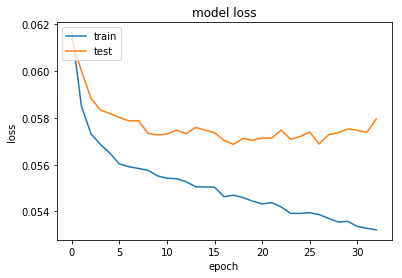

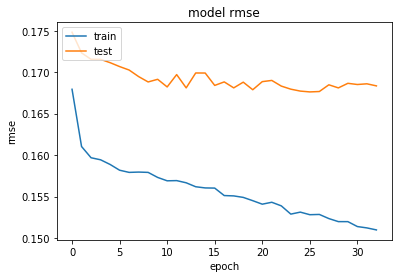

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  107.807452917099 s =  1.796790893872579 min =  0.02994651503033108 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.06130582992851082
Delay 100 ms: 0.005485973310854233
Delay 200 ms: 0.01474985710348355
Delay 300 ms: 0.026455254868270703
Delay 400 ms: 0.039474299402999
Delay 500 ms: 0.0531346310717395
Delay 600 ms: 0.06708802088295475
Delay 700 ms: 0.08111971137851164
Delay 800 ms: 0.09502258822890546
Delay 900 ms: 0.10864460058827606
Delay 1000 ms: 0.1218833624491131

RMSE
Average rmse: 0.13029452350136325
Delay 100 ms: 0.01632633502090481
Delay 200 ms: 0.03294023627764568
Delay 300 ms: 0.054131664744420493
Delay 400 ms: 0.077381836912027
Delay 500 ms: 0.101157933333989
Delay 600 ms: 0.12482422389422393
Delay 700 ms: 0.14801340913594194
Delay 800 ms: 0.1704346492663894
Delay 900 ms: 0.19198421472624924
Delay 1000 ms: 0.21257257125917878

SMAPE
Average smape: 13.33214891513961
Delay 100 ms: 2.355204295649653
Delay 200 ms: 5.199236582530699
Delay 300 ms: 7.977595231950172
Delay 400 ms: 10.54624572367721
Delay 500 ms: 12.920819481250458
Delay 600 ms: 15.106949943672934
Delay 700 ms:

(6035, 25, 3) (6035, 10, 3)


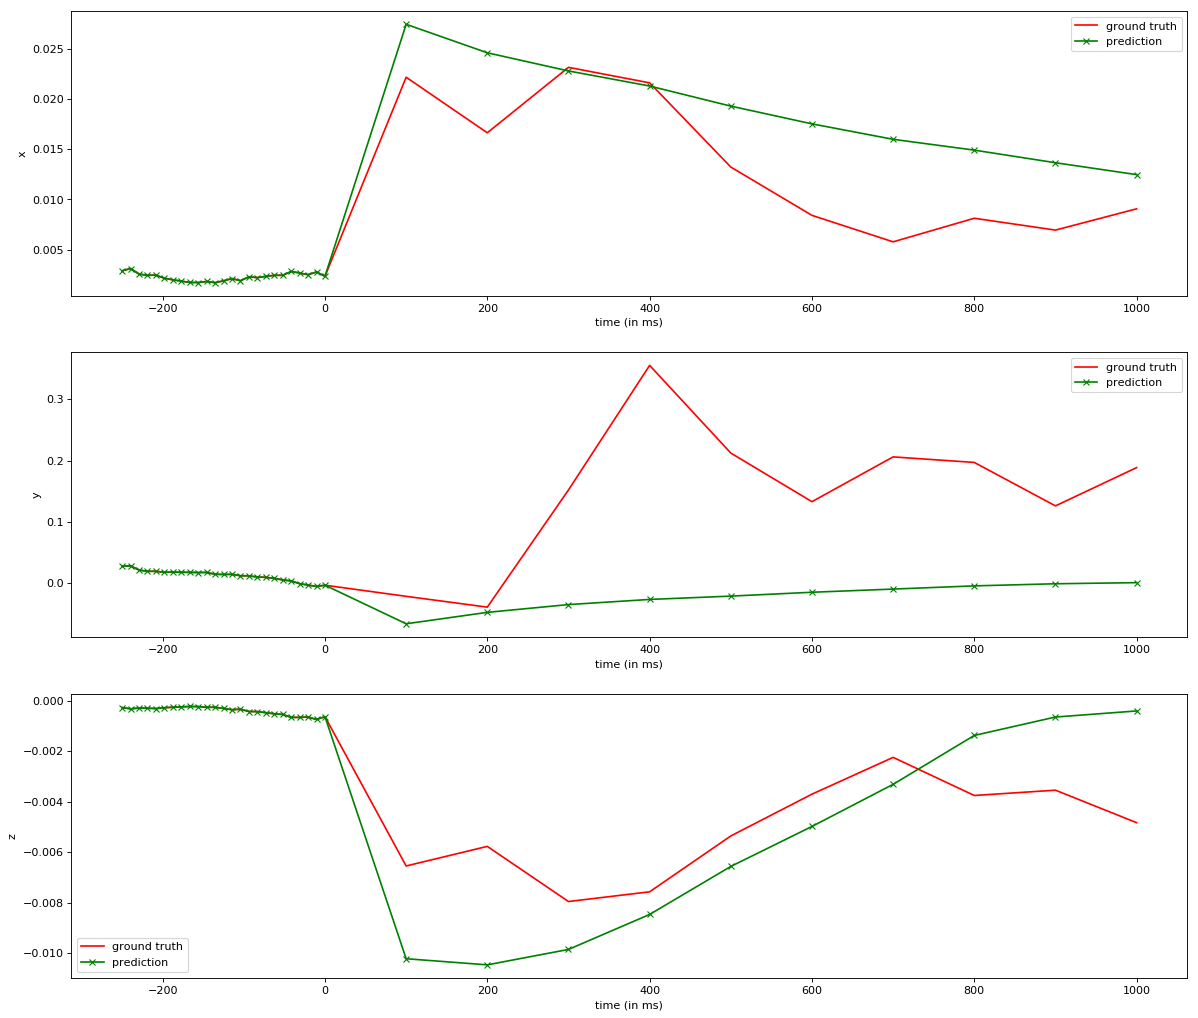

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data